<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Read-data-saved-by-DataPreprocessing.R" data-toc-modified-id="Read-data-saved-by-DataPreprocessing.R-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Read data saved by DataPreprocessing.R</a></span></li></ul></li><li><span><a href="#Model-devolepment" data-toc-modified-id="Model-devolepment-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model devolepment</a></span><ul class="toc-item"><li><span><a href="#Split-dataset-to-train-and-test-dataset" data-toc-modified-id="Split-dataset-to-train-and-test-dataset-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Split dataset to train and test dataset</a></span></li><li><span><a href="#Some-base-function" data-toc-modified-id="Some-base-function-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Some base function</a></span></li><li><span><a href="#Construction-of-NeuralMultiTaskModel" data-toc-modified-id="Construction-of-NeuralMultiTaskModel-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Construction of NeuralMultiTaskModel</a></span></li><li><span><a href="#Construction-of-NonLinearCoxPHModel-(DeepSurv)" data-toc-modified-id="Construction-of-NonLinearCoxPHModel-(DeepSurv)-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Construction of NonLinearCoxPHModel (DeepSurv)</a></span></li><li><span><a href="#Construction-of-RandomSurvivalForestModel" data-toc-modified-id="Construction-of-RandomSurvivalForestModel-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Construction of RandomSurvivalForestModel</a></span></li><li><span><a href="#Construct-CPH-Model" data-toc-modified-id="Construct-CPH-Model-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Construct CPH Model</a></span></li><li><span><a href="#Hyperparameters-tuning" data-toc-modified-id="Hyperparameters-tuning-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Hyperparameters tuning</a></span><ul class="toc-item"><li><span><a href="#Tuning-NMTLR" data-toc-modified-id="Tuning-NMTLR-2.7.1"><span class="toc-item-num">2.7.1&nbsp;&nbsp;</span>Tuning NMTLR</a></span></li><li><span><a href="#Tuning-DeepSurv" data-toc-modified-id="Tuning-DeepSurv-2.7.2"><span class="toc-item-num">2.7.2&nbsp;&nbsp;</span>Tuning DeepSurv</a></span></li><li><span><a href="#Tuning-RSF" data-toc-modified-id="Tuning-RSF-2.7.3"><span class="toc-item-num">2.7.3&nbsp;&nbsp;</span>Tuning RSF</a></span></li></ul></li></ul></li><li><span><a href="#Metrics" data-toc-modified-id="Metrics-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Metrics</a></span><ul class="toc-item"><li><span><a href="#Generate-data-for-prediction-error-curve" data-toc-modified-id="Generate-data-for-prediction-error-curve-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Generate data for prediction error curve</a></span></li><li><span><a href="#Generate-data-for-calibration-curves-and-roc-curves" data-toc-modified-id="Generate-data-for-calibration-curves-and-roc-curves-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Generate data for calibration curves and roc curves</a></span></li><li><span><a href="#Generate-data-for-Loss-converge-graph" data-toc-modified-id="Generate-data-for-Loss-converge-graph-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Generate data for Loss converge graph</a></span></li><li><span><a href="#Feature-importance-plot" data-toc-modified-id="Feature-importance-plot-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Feature importance plot</a></span></li><li><span><a href="#Treatment-recommendation" data-toc-modified-id="Treatment-recommendation-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Treatment recommendation</a></span></li><li><span><a href="#Save-models" data-toc-modified-id="Save-models-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Save models</a></span></li></ul></li></ul></div>

# Machine Learning-Based Individualized Survival Prediction Model for Prognosis in Osteosarcoma: Data From the SEER Database

In [1]:
import torch
import random
import numpy as np
import os
from pysurvival.utils.display import display_loss_values
from pysurvival.utils import check_data

In [2]:
np.seterr(divide='ignore', invalid='ignore') #Ignore warning: #RuntimeWarning: invalid value encountered in true_divide

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Preprocessing

### Read data saved by DataPreprocessing.R

In [3]:
exclude_cols = ['Stage']

In [4]:
import pandas as pd
dataset = pd.read_csv('./data/data_surv.csv')
dataset.columns = [name.replace('.',' ') for name in dataset.columns]
time_column = 'Survival months'
event_column = 'Status'
features = np.setdiff1d(dataset.columns, [time_column, event_column] + exclude_cols).tolist()
dataset[features+[time_column, event_column]].head()

,Age,Distant metastasis,Gender,Grade,Marital status,Number of tumors,Surgery,Systemic therapy,Tumor extension,Tumor size,Survival months,Status
0,78,2,0,3,0,1,0,0,1,61.0,7,1
1,16,2,0,3,0,0,3,1,1,109.0,146,0
2,13,0,1,3,0,0,3,2,0,64.0,150,0
3,14,0,1,3,0,0,3,1,1,89.0,150,0
4,9,2,1,3,0,1,0,0,1,100.0,26,1


In [5]:
dataset.shape

(1243, 13)

## Model devolepment
### Split dataset to train and test dataset

In [6]:
from sklearn.model_selection import train_test_split
import numpy as np
index_train, index_test = train_test_split(range(dataset.shape[0]), test_size = 0.3,random_state=SEED)
data_train = dataset.loc[index_train].reset_index( drop = True )
data_test  = dataset.loc[index_test].reset_index( drop = True )
# Creating the X, T and E inputs
X_train, X_test = data_train[features], data_test[features]
T_train, T_test = data_train[time_column], data_test[time_column]
E_train, E_test = data_train[event_column], data_test[event_column]
data_train.to_csv('data/train.csv')
data_test.to_csv('data/test.csv')

In [8]:
from pysurvival.utils.metrics import concordance_index
from sklearn.model_selection import RepeatedKFold
import threading

### Some base function

In [9]:
class BaseFun:
    def parse_param(self, param):
        for key in param:
            if isinstance(param[key], str):
                param[key] = '"{}"'.format(param[key])
        return ','.join(['{} = {}'.format(key, param[key]) for key in param])
    def get_random_param(self,space):
        param = {}
        for key in space:
            if  key == 'structure':
                items = []
                for i in range(1,random.choice(space['structure']['num_layers'])+1):
                    items.append(
                        {
                        'activation': random.choice(space['structure']['activations']),
                        'num_units':random.choice(space['structure']['num_units'])
                        }
                    )
                param['structure'] = items
            else:
                param[key] = random.choice(space[key])
        return param
    def tuning_and_construct(self,X, T, E,max_iter=100):
        self.tuning_result = self.tuning_with_space(X, T, E,self.space,max_iter=max_iter)
        self.model = self.fit_model(X, T, E,**self.tuning_result['best_param'])
        return self.model
    def cv(self,x,t,e,param,num):
        score_iter = []
        rkf = RepeatedKFold(n_splits=5, n_repeats=1)
        for train_index, test_index in rkf.split(x):
            x_train, x_test = x[train_index], x[test_index]
            t_train, t_test = t[train_index], t[test_index]
            e_train, e_test = e[train_index], e[test_index]
            model = self.fit_model(x_train, t_train, e_train,**param)
            score = concordance_index(model, x_test, t_test, e_test)
            score_iter.append(score)
        print('Number {} thread'.format(num), end=' ... ')
        mean_score = np.mean(score_iter)
        print('mean_c_index: ', mean_score, end=' ')
        if mean_score > self.best_score:
            self.best_score = mean_score
            self.best_param = param
            print('is the best so far')
        else:
            print('')
        self.scores.append({'iteration':num,'mean_score': mean_score, 'param': param})
    def tuning_with_space(self,x,t,e,space,max_iter=100,num_thread=10):
        [x,t,e] = [item if isinstance(item, np.ndarray) else np.array(item) for item in [x,t,e]]
        self.scores = []
        self.best_score = 0
        self.best_param = {}
        num = 1
        while True:
            tasks = []
            for i in range(num_thread):
                param = self.get_random_param(space)
                tasks.append(threading.Thread(target=self.cv,args=(x,t,e,param,num,)))
                num += 1
            for task in tasks:
                task.start()
            for task in tasks:
                task.join()
            print({'total iteration':num,'best_param': self.best_param, 'best_score': self.best_score})
            if num >= max_iter:
                break
        return {'best_param': self.best_param, 'best_score': self.best_score, 'scores': self.scores}

### Construction of NeuralMultiTaskModel

In [10]:
from pysurvival.models.multi_task import NeuralMultiTaskModel
class NMTLR(BaseFun):
    def __init__(self):
        self.space = {
            'structure': {'num_layers':[1,2,3,4,5],
                          'num_units': [i for i in range(8, 100)],
                          'activations': ["Atan", "BentIdentity", "BipolarSigmoid", "CosReLU", 
                                           "Gaussian", "Hardtanh", "InverseSqrt", "LeakyReLU", 
                                          "LeCunTanh", "LogLog", "LogSigmoid", "ReLU", "SELU", "Sigmoid", 
                                          "Sinc", "SinReLU","Softmax", "Softplus", "Softsign", "Swish", "Tanh"]
                         },
            'optimizer':['adadelta','adagrad','adam','adamax','rmsprop','sgd'],
            'bins' : [i for i in range(10,100)],
            'lr': [round(1e-5 * i, 5) for i in range(1, 100 + 1)],
            'num_epochs': [i for i in range(50, 1000 + 1)],
            'dropout': [round(0.1 * i, 2) for i in range(1, 4 + 1)],
            'l2_reg': [round(0.0001 * i, 5) for i in range(1, 100 + 1)],
            'l2_smooth':[round(0.0001 * i, 5) for i in range(1, 100 + 1)],
            'batch_normalization' : [False, True]
        }
    def fit_model(self,X, T, E,**kwargs):
        structure = [{'activation': 'ReLU', 'num_units': 128}]
        bins = 100
        if 'structure' in kwargs:
            structure = kwargs['structure']
            del kwargs['structure']
        if 'bins' in kwargs:
            bins = kwargs['bins']
            del kwargs['bins']
        model = NeuralMultiTaskModel(structure=structure,bins=bins)
        eval('model.fit(X, T, E,{})'.format(self.parse_param(kwargs)))
        return model

### Construction of NonLinearCoxPHModel (DeepSurv)

In [11]:
from pysurvival.models.semi_parametric import NonLinearCoxPHModel
class DeepSurv(BaseFun):
    def __init__(self):
        self.space = {
            'structure': {'num_layers':[1,2,3,4,5],
                          'num_units': [i for i in range(8, 100)],
                          'activations': ["Atan", "BentIdentity", "BipolarSigmoid", "CosReLU", 
                                           "Gaussian", "Hardtanh", "InverseSqrt", "LeakyReLU", 
                                          "LeCunTanh", "LogLog", "LogSigmoid", "ReLU", "SELU", "Sigmoid", 
                                          "Sinc", "SinReLU","Softmax", "Softplus", "Softsign", "Swish", "Tanh"]
                         },
            'optimizer':['adadelta','adagrad','adam','adamax','rmsprop','sgd'],
            'lr': [round(1e-5 * i, 5) for i in range(1, 100 + 1)],
            'num_epochs': [i for i in range(50, 5000 + 1)],
            'dropout': [round(0.1 * i, 2) for i in range(1, 4 + 1)],
            'l2_reg': [round(0.0001 * i, 5) for i in range(1, 100 + 1)],
            'batch_normalization' : [False, True]
        }
    def fit_model(self,X, T, E,**kwargs):
        structure = [{'activation': 'ReLU', 'num_units': 128}]
        bins = 100
        if 'structure' in kwargs:
            structure = kwargs['structure']
            del kwargs['structure']
        model = NonLinearCoxPHModel(structure=structure)
        eval('model.fit(X, T, E,{})'.format(self.parse_param(kwargs)))
        return model

### Construction of RandomSurvivalForestModel

In [12]:
from pysurvival.models.survival_forest import RandomSurvivalForestModel
class RSF(BaseFun):
    def __init__(self):
        self.space = {
            'num_trees': [i for i in range(20, 1000 + 1)],
            'max_features': ['sqrt', 'log2', 'all', 0.1, 0.2],
            'min_node_size': [i for i in range(5, 80 + 1)],
            'sample_size_pct': [round(0.2 * i, 2) for i in range(1, 4 + 1)],
            'importance_mode': ['impurity', 'impurity_corrected', 'permutation', 'normalized_permutation']
        }
    def fit_model(self,X, T, E,**kwargs):
        if 'num_trees' in kwargs:
            model = RandomSurvivalForestModel(num_trees=kwargs['num_trees'])
            del kwargs['num_trees']
        else:
            model = RandomSurvivalForestModel()
        eval('model.fit(X, T, E,seed=SEED,{})'.format(self.parse_param(kwargs)))
        return model

### Construct CPH Model

In [13]:
from pysurvival.models.semi_parametric import CoxPHModel
def cph(X_train, T_train, E_train):
    model = CoxPHModel()
    model.fit(X_train, T_train, E_train, lr=0.2, l2_reg=0.01)
    return model


In [14]:
cph.model = cph(X_train, T_train, E_train)
c_index_train = concordance_index(cph.model, X_train, T_train, E_train)
c_index_test = concordance_index(cph.model, X_test, T_test, E_test)
print('C-index of train: {:.4f}; C-index of test: {:.4f}'.format(c_index_train,c_index_test)) #C-index: 0.6996

Performing Newton-Raphson optimization
 * Iteration #1 - Loss = 2490.412 - ||grad||^2 = 629.82268
 * Iteration #2 - Loss = 2337.608 - ||grad||^2 = 491.90520
 * Iteration #3 - Loss = 2269.205 - ||grad||^2 = 393.84529
 * Iteration #4 - Loss = 2227.970 - ||grad||^2 = 317.11193
 * Iteration #5 - Loss = 2200.943 - ||grad||^2 = 255.71450
 * Iteration #6 - Loss = 2182.685 - ||grad||^2 = 206.16895
 * Iteration #7 - Loss = 2170.270 - ||grad||^2 = 166.07846
 * Iteration #8 - Loss = 2161.862 - ||grad||^2 = 133.64041
 * Iteration #9 - Loss = 2156.212 - ||grad||^2 = 107.42695
 * Iteration #10 - Loss = 2152.448 - ||grad||^2 = 86.27737
 * Iteration #11 - Loss = 2149.959 - ||grad||^2 = 69.23953
 * Iteration #12 - Loss = 2148.323 - ||grad||^2 = 55.53223
 * Iteration #13 - Loss = 2147.254 - ||grad||^2 = 44.51649
 * Iteration #14 - Loss = 2146.558 - ||grad||^2 = 35.67164
 * Iteration #15 - Loss = 2146.106 - ||grad||^2 = 28.57495
 * Iteration #16 - Loss = 2145.814 - ||grad||^2 = 22.88419
 * Iteration #17 

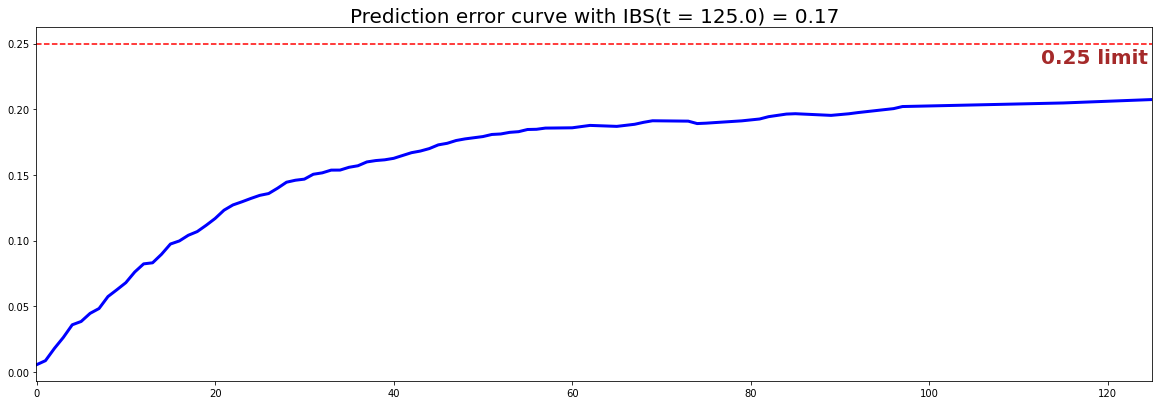

IBS: 0.17


In [15]:
from pysurvival.utils.display import integrated_brier_score
ibs = integrated_brier_score(cph.model, X_train, T_train, E_train,t_max=None, figure_size=(20, 6.5) )
print('IBS: {:.2f}'.format(ibs))

In [16]:
from pysurvival.models.semi_parametric import CoxPHModel
tnm = CoxPHModel()
tnm.model = tnm.fit(data_train[['Stage']], T_train, E_train, lr=0.2, l2_reg=0.01)
c_index_train = concordance_index(tnm.model, data_train[['Stage']], T_train, E_train)
c_index_test = concordance_index(tnm.model, data_test[['Stage']], T_test, E_test)
print('C-index of train: {:.4f}; C-index of test: {:.4f}'.format(c_index_train,c_index_test)) #C-index: 0.6996

Performing Newton-Raphson optimization
 * Iteration #1 - Loss = 2870.366 - ||grad||^2 = 593.27429
 * Iteration #2 - Loss = 2588.640 - ||grad||^2 = 468.04754
 * Iteration #3 - Loss = 2428.751 - ||grad||^2 = 371.69598
 * Iteration #4 - Loss = 2334.121 - ||grad||^2 = 294.63870
 * Iteration #5 - Loss = 2278.990 - ||grad||^2 = 233.69364
 * Iteration #6 - Loss = 2246.557 - ||grad||^2 = 185.76930
 * Iteration #7 - Loss = 2227.032 - ||grad||^2 = 147.98905
 * Iteration #8 - Loss = 2215.031 - ||grad||^2 = 118.07785
 * Iteration #9 - Loss = 2207.541 - ||grad||^2 = 94.31181
 * Iteration #10 - Loss = 2202.819 - ||grad||^2 = 75.38051
 * Iteration #11 - Loss = 2199.823 - ||grad||^2 = 60.27494
 * Iteration #12 - Loss = 2197.915 - ||grad||^2 = 48.20886
 * Iteration #13 - Loss = 2196.695 - ||grad||^2 = 38.56410
 * Iteration #14 - Loss = 2195.916 - ||grad||^2 = 30.85151
 * Iteration #15 - Loss = 2195.416 - ||grad||^2 = 24.68249
 * Iteration #16 - Loss = 2195.097 - ||grad||^2 = 19.74739
 * Iteration #17 -

### Hyperparameters tuning

In [163]:
max_iter = 1000

#### Tuning NMTLR

In [164]:
nmtlr = NMTLR()
nmtlr.tuning_and_construct(X_train, T_train, E_train,max_iter=max_iter)

% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion:  14%|******                                        |Loss: 2200.98 (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 8 thread ... mean_c_index:  0.5622628571896817 is the best so far


% Completion: 100%|**********************************************|Loss: 1756.72
% Completion: 100%|**********************************************|Loss: 1749.62
% Completion: 100%|**********************************************|Loss: 1650.90
% Completion: 100%|**********************************************|Loss: 1782.29
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 804.68
% Completion: 100%|**********************************************|Loss: 1911.15


Number 6 thread ... mean_c_index:  0.6658868123884829 is the best so far


% Completion: 100%|**********************************************|Loss: 1367.55
% Completion: 100%|**********************************************|Loss: 1219.96
% Completion: 100%|***********************************************|Loss: 966.58
% Completion: 100%|***********************************************|Loss: 786.12
% Completion: 100%|**********************************************|Loss: 1934.90
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 754.59
% Completion: 100%|**********************************************|Loss: 1229.92
% Completion: 100%|***********************************************|Loss: 914.13
% Completion: 100%|**********************************************|Loss: 1436.75
% Completion: 100%|***********************************************|Loss: 772.58
% Completion: 100%|**********************************************|Loss: 3553.22
% Completion: 100

Number 1 thread ... mean_c_index:  0.624658798639229 


% Completion:  92%|******************************************    |Loss: 1253.59
% Completion: 100%|**********************************************|Loss: 1244.25
% Completion: 100%|***********************************************|Loss: 780.10
% Completion: 100%|***********************************************|Loss: 973.36
% Completion: 100%|**********************************************|Loss: 1880.62
% Completion: 100%|***********************************************|Loss: 803.56


Number 9 thread ... mean_c_index:  0.5359066843151826 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1513.32


Number 2 thread ... mean_c_index:  0.5683500363999074 


% Completion: 100%|**********************************************|Loss: 1235.20


Number 5 thread ... mean_c_index:  0.7258170781957338 is the best so far


% Completion: 100%|***********************************************|Loss: 926.87


Number 3 thread ... mean_c_index:  0.5408506635962208 


% Completion: 100%|***********************************************|Loss: 788.50
% Completion: 100%|**********************************************|Loss: 2248.38


Number 10 thread ... mean_c_index:  0.7306167611569058 is the best so far
Number 7 thread ... mean_c_index:  0.555115688630623 


% Completion: 100%|***********************************************|Loss: 123.43
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 4 thread ... mean_c_index:  0.5355998295589062 
{'total iteration': 11, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 49}, {'activation': 'ReLU', 'num_units': 43}], 'optimizer': 'sgd', 'bins': 13, 'lr': 0.00022, 'num_epochs': 871, 'dropout': 0.3, 'l2_reg': 0.0093, 'l2_smooth': 0.0027, 'batch_normalization': False}, 'best_score': 0.7306167611569058}


% Completion:   1%|                                              |Loss: 1920.62 (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 14 thread ... mean_c_index:  0.5630540958460866 


% Completion: 100%|***********************************************|Loss: 940.78
% Completion: 100%|**********************************************|Loss: 1539.94
% Completion: 100%|***********************************************|Loss: 747.67
% Completion: 100%|**********************************************|Loss: 2079.26
% Completion: 100%|***********************************************|Loss: 320.98
% Completion: 100%|***********************************************|Loss: 937.47
% Completion: 100%|**********************************************|Loss: 1545.18
% Completion: 100%|**********************************************|Loss: 1124.30
% Completion:  42%|*******************                           |Loss: 1090.40
% Completion: 100%|***********************************************|Loss: 933.91
% Completion: 100%|**********************************************|Loss: 2199.33
% Completion: 100%|**********************************************|Loss: 1673.07
% Completion: 100%|*********************

Number 17 thread ... mean_c_index:  0.5542758582730107 


% Completion: 100%|**********************************************|Loss: 1106.67
% Completion: 100%|***********************************************|Loss: 957.73


Number 13 thread ... mean_c_index:  0.5953788519903482 


% Completion: 100%|**********************************************|Loss: 1290.82
% Completion: 100%|***********************************************|Loss: 814.05
% Completion: 100%|**********************************************|Loss: 1499.36
% Completion: 100%|***********************************************|Loss: 248.38
% Completion: 100%|**********************************************|Loss: 2474.52
% Completion: 100%|**********************************************|Loss: 1133.72
% Completion: 100%|**********************************************|Loss: 1680.31
% Completion: 100%|***********************************************|Loss: 737.34
% Completion: 100%|**********************************************|Loss: 1307.15
% Completion: 100%|***********************************************|Loss: 423.89
% Completion: 100%|***********************************************|Loss: 741.26
% Completion: 100%|**********************************************|Loss: 1100.14
% Completion: 100%|*********************

Number 18 thread ... mean_c_index:  0.5597378795179313 


% Completion: 100%|***********************************************|Loss: 808.56


Number 12 thread ... mean_c_index:  0.5629648146525887 


% Completion: 100%|**********************************************|Loss: 2225.70
% Completion: 100%|**********************************************|Loss: 1321.26
% Completion: 100%|***********************************************|Loss: 366.95


Number 15 thread ... mean_c_index:  0.5346490413193106 


% Completion: 100%|**********************************************|Loss: 1109.61


Number 20 thread ... mean_c_index:  0.733244764048951 is the best so far


% Completion: 100%|**********************************************|Loss: 1334.54


Number 11 thread ... mean_c_index:  0.54142469156699 


% Completion: 100%|***********************************************|Loss: 752.58
% Completion: 100%|**********************************************|Loss: 1971.03
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 2068.09


Number 19 thread ... mean_c_index:  0.5952919675996822 


% Completion: 100%|***********************************************|Loss: 784.85


Number 16 thread ... mean_c_index:  0.5719631222202727 
{'total iteration': 21, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 88}, {'activation': 'Softsign', 'num_units': 23}, {'activation': 'Swish', 'num_units': 37}, {'activation': 'CosReLU', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 35}], 'optimizer': 'adamax', 'bins': 37, 'lr': 0.00058, 'num_epochs': 482, 'dropout': 0.1, 'l2_reg': 0.0081, 'l2_smooth': 0.0044, 'batch_normalization': False}, 'best_score': 0.733244764048951}


% Completion: 100%|**********************************************|Loss: 1596.66
% Completion: 100%|**********************************************|Loss: 1367.17
% Completion: 100%|**********************************************|Loss: 1082.96
% Completion: 100%|**********************************************|Loss: 1813.51
% Completion: 100%|**********************************************|Loss: 1098.49
% Completion: 100%|**********************************************|Loss: 1355.16
% Completion: 100%|**********************************************|Loss: 1519.11
% Completion: 100%|**********************************************|Loss: 1917.97
% Completion: 100%|**********************************************|Loss: 1086.77
% Completion: 100%|**********************************************|Loss: 1426.85
% Completion: 100%|**********************************************|Loss: 2057.62
% Completion: 100%|**********************************************|Loss: 1145.05
% Completion: 100%|*********************

Number 24 thread ... mean_c_index:  0.6002822255537148 


% Completion: 100%|**********************************************|Loss: 1393.15
% Completion: 100%|**********************************************|Loss: 1476.07
% Completion: 100%|**********************************************|Loss: 1075.94
% Completion: 100%|**********************************************|Loss: 1391.47


Number 26 thread ... mean_c_index:  0.5602844753740392 


% Completion: 100%|***********************************************|Loss: 964.31
% Completion: 100%|**********************************************|Loss: 1877.50
% Completion: 100%|***********************************************|Loss: 713.18
% Completion: 100%|**********************************************|Loss: 1050.85


Number 30 thread ... mean_c_index:  0.7073873110319038 


% Completion: 100%|***********************************************|Loss: 517.50
% Completion: 100%|**********************************************|Loss: 1204.36
% Completion: 100%|**********************************************|Loss: 1513.85
% Completion: 100%|**********************************************|Loss: 1324.39
% Completion: 100%|**********************************************|Loss: 1032.07
% Completion: 100%|***********************************************|Loss: 992.43


Number 23 thread ... mean_c_index:  0.541746598808844 


% Completion: 100%|**********************************************|Loss: 1533.92
% Completion:  70%|*********************************              |Loss: 729.31
% Completion: 100%|**********************************************|Loss: 1696.05
% Completion: 100%|**********************************************|Loss: 1526.41


Number 27 thread ... mean_c_index:  0.6317315675950161 


% Completion: 100%|***********************************************|Loss: 580.60
% Completion: 100%|**********************************************|Loss: 1169.10
% Completion: 100%|***********************************************|Loss: 479.63
% Completion: 100%|**********************************************|Loss: 1230.56
% Completion: 100%|**********************************************|Loss: 1175.43


Number 28 thread ... mean_c_index:  0.5920742485400814 


% Completion: 100%|**********************************************|Loss: 1713.46
% Completion: 100%|***********************************************|Loss: 737.01
% Completion: 100%|***********************************************|Loss: 406.52
% Completion: 100%|**********************************************|Loss: 1182.43
% Completion: 100%|**********************************************|Loss: 1999.81
% Completion: 100%|***********************************************|Loss: 444.84
% Completion: 100%|***********************************************|Loss: 579.24
% Completion: 100%|**********************************************|Loss: 1195.66
% Completion: 100%|**********************************************|Loss: 2073.44


Number 25 thread ... mean_c_index:  0.55859926570885 


% Completion: 100%|***********************************************|Loss: 478.64


Number 22 thread ... mean_c_index:  0.5405049872783426 


% Completion: 100%|***********************************************|Loss: 582.38


Number 21 thread ... mean_c_index:  0.5486902643883599 


% Completion: 100%|**********************************************|Loss: 1243.08


Number 29 thread ... mean_c_index:  0.5399036438967727 
{'total iteration': 31, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 88}, {'activation': 'Softsign', 'num_units': 23}, {'activation': 'Swish', 'num_units': 37}, {'activation': 'CosReLU', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 35}], 'optimizer': 'adamax', 'bins': 37, 'lr': 0.00058, 'num_epochs': 482, 'dropout': 0.1, 'l2_reg': 0.0081, 'l2_smooth': 0.0044, 'batch_normalization': False}, 'best_score': 0.733244764048951}


% Completion: 100%|***********************************************|Loss: 965.30
% Completion: 100%|***********************************************|Loss: 562.78
% Completion: 100%|**********************************************|Loss: 1322.46
% Completion: 100%|***********************************************|Loss: 877.86
% Completion: 100%|***********************************************|Loss: 603.58
% Completion: 100%|**********************************************|Loss: 1228.65
% Completion: 100%|***********************************************|Loss: 879.03
% Completion:  91%|******************************************    |Loss: 1259.10
% Completion: 100%|**********************************************|Loss: 1217.34
% Completion: 100%|***********************************************|Loss: 898.71
% Completion: 100%|***********************************************|Loss: 567.44
% Completion: 100%|**********************************************|Loss: 1626.87
% Completion: 100%|*********************

Number 39 thread ... mean_c_index:  0.7205901436410406 


% Completion: 100%|**********************************************|Loss: 1553.29
% Completion: 100%|***********************************************|Loss: 670.17
% Completion: 100%|**********************************************|Loss: 1221.57
% Completion: 100%|***********************************************|Loss: 614.13


Number 34 thread ... mean_c_index:  0.5534798913267871 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1107.43
% Completion: 100%|***********************************************|Loss: 930.17
% Completion: 100%|**********************************************|Loss: 1891.51


Number 36 thread ... mean_c_index:  0.5605136146512428 


% Completion: 100%|***********************************************|Loss: 861.08
% Completion: 100%|***********************************************|Loss: 625.78
% Completion: 100%|**********************************************|Loss: 1297.59
% Completion: 100%|***********************************************|Loss: 975.20


Number 32 thread ... mean_c_index:  0.5487437013632448 


% Completion: 100%|***********************************************|Loss: 622.52
% Completion: 100%|**********************************************|Loss: 1299.60
% Completion: 100%|**********************************************|Loss: 1667.74
% Completion: 100%|***********************************************|Loss: 659.08


Number 37 thread ... mean_c_index:  0.52839509365211 


% Completion: 100%|***********************************************|Loss: 890.34
% Completion: 100%|**********************************************|Loss: 1217.40


Number 33 thread ... mean_c_index:  0.7277099718314239 


% Completion: 100%|**********************************************|Loss: 1252.21


Number 40 thread ... mean_c_index:  0.6816558400038237 


% Completion: 100%|***********************************************|Loss: 802.14


Number 31 thread ... mean_c_index:  0.5328109592903744 


% Completion: 100%|***********************************************|Loss: 914.75


Number 35 thread ... mean_c_index:  0.5582426449061486 


% Completion: 100%|**********************************************|Loss: 1790.94
% Completion: 100%|**********************************************|Loss: 1885.23
% Completion: 100%|**********************************************|Loss: 1643.91


Number 38 thread ... mean_c_index:  0.5708476530177116 
{'total iteration': 41, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 88}, {'activation': 'Softsign', 'num_units': 23}, {'activation': 'Swish', 'num_units': 37}, {'activation': 'CosReLU', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 35}], 'optimizer': 'adamax', 'bins': 37, 'lr': 0.00058, 'num_epochs': 482, 'dropout': 0.1, 'l2_reg': 0.0081, 'l2_smooth': 0.0044, 'batch_normalization': False}, 'best_score': 0.733244764048951}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 47 thread ... mean_c_index:  0.5891680309196553 


% Completion: 100%|**********************************************|Loss: 2113.61
% Completion: 100%|**********************************************|Loss: 2065.66
% Completion: 100%|**********************************************|Loss: 1637.56
% Completion: 100%|**********************************************|Loss: 1706.37
% Completion: 100%|**********************************************|Loss: 1799.28
% Completion: 100%|**********************************************|Loss: 1082.51
% Completion: 100%|**********************************************|Loss: 2000.58


Number 43 thread ... mean_c_index:  0.588551183636979 


% Completion: 100%|**********************************************|Loss: 1734.02
% Completion: 100%|**********************************************|Loss: 1924.20
% Completion: 100%|**********************************************|Loss: 1748.35
% Completion: 100%|**********************************************|Loss: 1126.47
% Completion: 100%|**********************************************|Loss: 1100.06
% Completion: 100%|**********************************************|Loss: 1264.52
% Completion: 100%|**********************************************|Loss: 2562.71
% Completion: 100%|**********************************************|Loss: 1758.29
% Completion: 100%|***********************************************|Loss: 136.29
% Completion: 100%|**********************************************|Loss: 2389.00
% Completion: 100%|**********************************************|Loss: 1132.47
% Completion: 100%|**********************************************|Loss: 1570.38
% Completion: 100%|*********************

Number 42 thread ... mean_c_index:  0.5517406531147445 


% Completion: 100%|**********************************************|Loss: 1855.27
% Completion:  44%|********************                           |Loss: 429.06
% Completion: 100%|**********************************************|Loss: 1232.00
% Completion: 100%|***********************************************|Loss: 232.50
% Completion: 100%|**********************************************|Loss: 1082.84


Number 41 thread ... mean_c_index:  0.5441730082413632 


% Completion: 100%|**********************************************|Loss: 1606.54
% Completion: 100%|**********************************************|Loss: 1774.21
% Completion: 100%|**********************************************|Loss: 1082.39
% Completion: 100%|***********************************************|Loss: 109.47
% Completion: 100%|**********************************************|Loss: 1857.80


Number 50 thread ... mean_c_index:  0.6814135895241674 


% Completion: 100%|**********************************************|Loss: 1281.09
% Completion: 100%|**********************************************|Loss: 1594.43
% Completion: 100%|**********************************************|Loss: 1070.54
% Completion: 100%|**********************************************|Loss: 1576.18


Number 48 thread ... mean_c_index:  0.6897065045580726 


% Completion: 100%|**********************************************|Loss: 1083.56
% Completion: 100%|***********************************************|Loss: 155.07


Number 44 thread ... mean_c_index:  0.7278888374870959 


% Completion: 100%|**********************************************|Loss: 1192.28
% Completion: 100%|***********************************************|Loss: 177.48
% Completion: 100%|**********************************************|Loss: 1157.80


Number 46 thread ... mean_c_index:  0.5400315808078543 


% Completion: 100%|***********************************************|Loss: 131.04
% Completion: 100%|***********************************************|Loss: 312.95
% Completion: 100%|***********************************************|Loss: 206.29


Number 49 thread ... mean_c_index:  0.5337181785427171 


% Completion: 100%|***********************************************|Loss: 209.54
% Completion: 100%|***********************************************|Loss: 228.35


Number 45 thread ... mean_c_index:  0.5402957642833218 
{'total iteration': 51, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 88}, {'activation': 'Softsign', 'num_units': 23}, {'activation': 'Swish', 'num_units': 37}, {'activation': 'CosReLU', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 35}], 'optimizer': 'adamax', 'bins': 37, 'lr': 0.00058, 'num_epochs': 482, 'dropout': 0.1, 'l2_reg': 0.0081, 'l2_smooth': 0.0044, 'batch_normalization': False}, 'best_score': 0.733244764048951}


% Completion:   6%|***                                           |Loss: 1956.56 (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1940.51
% Completion: 100%|**********************************************|Loss: 2938.76
% Completion: 100%|**********************************************|Loss: 2502.41
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion:  15%|******                                        |Loss: 1722.36 (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1960.36
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1994.63
% Completion: 100%|**********************************************|Loss: 1277.59


Number 54 thread ... mean_c_index:  0.5724471199467874 


% Completion: 100%|**********************************************|Loss: 1453.26
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 55 thread ... mean_c_index:  0.5669645801247581 


% Completion: 100%|**********************************************|Loss: 1489.52
% Completion: 100%|**********************************************|Loss: 1280.40
% Completion: 100%|**********************************************|Loss: 1677.43
% Completion: 100%|**********************************************|Loss: 1486.34
% Completion: 100%|**********************************************|Loss: 1319.09
% Completion: 100%|**********************************************|Loss: 1665.95
% Completion: 100%|**********************************************|Loss: 1089.14
% Completion: 100%|**********************************************|Loss: 1908.88
% Completion: 100%|**********************************************|Loss: 1438.29
% Completion:  47%|*********************                         |Loss: 1593.72
% Completion: 100%|**********************************************|Loss: 1943.91
% Completion: 100%|**********************************************|Loss: 1534.83
% Completion: 100%|*********************

Number 60 thread ... mean_c_index:  0.6074218373211957 


% Completion: 100%|**********************************************|Loss: 1225.56
% Completion: 100%|**********************************************|Loss: 1440.57


Number 53 thread ... mean_c_index:  0.5836900490460734 


% Completion: 100%|**********************************************|Loss: 1513.88
% Completion: 100%|***********************************************|Loss: 983.04
% Completion: 100%|**********************************************|Loss: 1959.62
% Completion: 100%|**********************************************|Loss: 1491.93
% Completion: 100%|**********************************************|Loss: 1496.32


Number 52 thread ... mean_c_index:  0.563038663405235 


% Completion: 100%|**********************************************|Loss: 1764.14
% Completion: 100%|**********************************************|Loss: 1222.36
% Completion: 100%|**********************************************|Loss: 1543.10
% Completion: 100%|**********************************************|Loss: 2266.90
% Completion: 100%|**********************************************|Loss: 1267.88
% Completion: 100%|**********************************************|Loss: 1109.84
% Completion: 100%|**********************************************|Loss: 1267.02


Number 59 thread ... mean_c_index:  0.5677032525340943 


% Completion: 100%|**********************************************|Loss: 1807.20
% Completion: 100%|**********************************************|Loss: 1831.41
% Completion: 100%|**********************************************|Loss: 1525.98
% Completion: 100%|**********************************************|Loss: 1012.15


Number 56 thread ... mean_c_index:  0.6290587593960544 


% Completion: 100%|**********************************************|Loss: 2126.42


Number 51 thread ... mean_c_index:  0.5682832724886154 


% Completion: 100%|**********************************************|Loss: 1897.65
% Completion: 100%|**********************************************|Loss: 1526.95
% Completion: 100%|**********************************************|Loss: 1629.83


Number 57 thread ... mean_c_index:  0.6777045887236995 


% Completion: 100%|**********************************************|Loss: 1536.13


Number 58 thread ... mean_c_index:  0.6446990556957967 
{'total iteration': 61, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 88}, {'activation': 'Softsign', 'num_units': 23}, {'activation': 'Swish', 'num_units': 37}, {'activation': 'CosReLU', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 35}], 'optimizer': 'adamax', 'bins': 37, 'lr': 0.00058, 'num_epochs': 482, 'dropout': 0.1, 'l2_reg': 0.0081, 'l2_smooth': 0.0044, 'batch_normalization': False}, 'best_score': 0.733244764048951}


% Completion: 100%|**********************************************|Loss: 1294.64
% Completion: 100%|**********************************************|Loss: 1264.64
% Completion: 100%|**********************************************|Loss: 1226.90
% Completion: 100%|**********************************************|Loss: 1431.14
% Completion: 100%|**********************************************|Loss: 1309.24
% Completion: 100%|**********************************************|Loss: 1237.49
% Completion: 100%|**********************************************|Loss: 1378.03
% Completion: 100%|**********************************************|Loss: 1369.78
% Completion: 100%|**********************************************|Loss: 1297.74


Number 69 thread ... mean_c_index:  0.5702173869411142 


% Completion: 100%|**********************************************|Loss: 1380.35
% Completion: 100%|**********************************************|Loss: 3223.18
% Completion: 100%|**********************************************|Loss: 1320.82
% Completion: 100%|**********************************************|Loss: 1857.58
% Completion: 100%|**********************************************|Loss: 1032.13
% Completion: 100%|**********************************************|Loss: 1366.77
% Completion: 100%|**********************************************|Loss: 1263.64
% Completion: 100%|**********************************************|Loss: 1387.85
% Completion: 100%|**********************************************|Loss: 1303.13
% Completion:  90%|*****************************************     |Loss: 2001.66
% Completion: 100%|**********************************************|Loss: 1260.15
% Completion: 100%|**********************************************|Loss: 3123.94
% Completion: 100%|*********************

Number 70 thread ... mean_c_index:  0.6682143732406297 


% Completion: 100%|**********************************************|Loss: 1163.48
% Completion: 100%|**********************************************|Loss: 1270.52


Number 66 thread ... mean_c_index:  0.5935348808537533 


% Completion: 100%|**********************************************|Loss: 1321.68
% Completion: 100%|**********************************************|Loss: 1254.52
% Completion: 100%|**********************************************|Loss: 1660.69
% Completion: 100%|**********************************************|Loss: 1969.18
% Completion: 100%|**********************************************|Loss: 3207.13
% Completion: 100%|**********************************************|Loss: 1403.11
% Completion: 100%|**********************************************|Loss: 1384.40
% Completion: 100%|**********************************************|Loss: 1084.51
% Completion: 100%|**********************************************|Loss: 2361.01
% Completion: 100%|**********************************************|Loss: 2725.67
% Completion: 100%|***********************************************|Loss: 678.13
% Completion: 100%|**********************************************|Loss: 1358.47


Number 64 thread ... mean_c_index:  0.5511693755181086 


% Completion: 100%|**********************************************|Loss: 1360.75


Number 62 thread ... mean_c_index:  0.5329890617953092 


% Completion: 100%|**********************************************|Loss: 2036.93
% Completion: 100%|**********************************************|Loss: 1104.83


Number 63 thread ... mean_c_index:  0.5612077868402527 


% Completion: 100%|**********************************************|Loss: 3523.68


Number 65 thread ... mean_c_index:  0.5406599441882305 


% Completion: 100%|**********************************************|Loss: 1124.83


Number 68 thread ... mean_c_index:  0.5420879063619062 


% Completion: 100%|**********************************************|Loss: 1531.52
% Completion: 100%|***********************************************|Loss: 528.84
% Completion: 100%|**********************************************|Loss: 1722.50
% Completion: 100%|***********************************************|Loss: 659.60
% Completion: 100%|**********************************************|Loss: 1557.81
% Completion: 100%|***********************************************|Loss: 692.15
% Completion: 100%|**********************************************|Loss: 1544.61


Number 61 thread ... mean_c_index:  0.5562643052641787 


% Completion: 100%|***********************************************|Loss: 618.23


Number 67 thread ... mean_c_index:  0.5149823737242848 
{'total iteration': 71, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 88}, {'activation': 'Softsign', 'num_units': 23}, {'activation': 'Swish', 'num_units': 37}, {'activation': 'CosReLU', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 35}], 'optimizer': 'adamax', 'bins': 37, 'lr': 0.00058, 'num_epochs': 482, 'dropout': 0.1, 'l2_reg': 0.0081, 'l2_smooth': 0.0044, 'batch_normalization': False}, 'best_score': 0.733244764048951}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 78 thread ... mean_c_index:  0.565202955634134 


% Completion: 100%|**********************************************|Loss: 1191.70
% Completion: 100%|**********************************************|Loss: 1235.44
% Completion: 100%|***********************************************|Loss: 856.97
% Completion: 100%|**********************************************|Loss: 1323.36
% Completion: 100%|**********************************************|Loss: 1227.74
% Completion: 100%|**********************************************|Loss: 1314.95
% Completion: 100%|**********************************************|Loss: 1039.24
% Completion: 100%|**********************************************|Loss: 1250.71
% Completion: 100%|**********************************************|Loss: 1263.00
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1305.40
% Completion: 100%|***********************************************|Loss: 813.39
% Completion:  52

Number 72 thread ... mean_c_index:  0.5650668550519005 


% Completion: 100%|**********************************************|Loss: 1032.78
% Completion: 100%|**********************************************|Loss: 1358.83
% Completion: 100%|**********************************************|Loss: 1313.98
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 812.84
% Completion: 100%|**********************************************|Loss: 1192.36
% Completion: 100%|**********************************************|Loss: 1292.71
% Completion: 100%|**********************************************|Loss: 1315.79
% Completion: 100%|***********************************************|Loss: 884.95
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 789.81
% Completion: 100%|**********************************************|Loss: 10

Number 75 thread ... mean_c_index:  0.7285034411672325 


% Completion: 100%|***********************************************|Loss: 802.31


Number 77 thread ... mean_c_index:  0.7282110963932712 


% Completion: 100%|**********************************************|Loss: 1221.57


Number 71 thread ... mean_c_index:  0.675505188406329 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1069.33
% Completion: 100%|**********************************************|Loss: 1291.78
% Completion: 100%|**********************************************|Loss: 1285.60


Number 79 thread ... mean_c_index:  0.5391481540150691 


% Completion: 100%|**********************************************|Loss: 1064.92


Number 76 thread ... mean_c_index:  0.6719680003939527 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 80 thread ... mean_c_index:  0.6009094395474767 


% Completion: 100%|**********************************************|Loss: 1328.49


Number 73 thread ... mean_c_index:  0.7305895038260546 


% Completion: 100%|***********************************************|Loss: 952.98
% Completion: 100%|**********************************************|Loss: 1029.21
% Completion: 100%|***********************************************|Loss: 971.40
% Completion: 100%|**********************************************|Loss: 1023.14


Number 74 thread ... mean_c_index:  0.586870691801444 
{'total iteration': 81, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 88}, {'activation': 'Softsign', 'num_units': 23}, {'activation': 'Swish', 'num_units': 37}, {'activation': 'CosReLU', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 35}], 'optimizer': 'adamax', 'bins': 37, 'lr': 0.00058, 'num_epochs': 482, 'dropout': 0.1, 'l2_reg': 0.0081, 'l2_smooth': 0.0044, 'batch_normalization': False}, 'best_score': 0.733244764048951}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 780.79
% Completion: 100%|**********************************************|Loss: 2210.42
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1203.90
% Completion: 100%|**********************************************|Loss: 2318.86
% Completion: 100%|***********************************************|Loss: 784.09
% Completion: 100%|**********************************************|Loss: 2145.71
% Completion:  56%|*************************                     |Loss: 1017.80
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*********

Number 82 thread ... mean_c_index:  0.5645754727792531 


% Completion: 100%|**********************************************|Loss: 2066.47
% Completion: 100%|**********************************************|Loss: 1362.33
% Completion: 100%|**********************************************|Loss: 2249.30
% Completion: 100%|**********************************************|Loss: 1193.19
% Completion: 100%|**********************************************|Loss: 2153.27
% Completion: 100%|***********************************************|Loss: 792.53


Number 85 thread ... mean_c_index:  0.723894339231799 


% Completion: 100%|***********************************************|Loss: 671.55
% Completion:   7%|***                                            |Loss: 791.43


Number 86 thread ... mean_c_index:  0.5512772931130003 


% Completion: 100%|**********************************************|Loss: 1223.49
% Completion: 100%|**********************************************|Loss: 2823.33
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1193.32


Number 83 thread ... mean_c_index:  0.7333275629190293 is the best so far


% Completion: 100%|**********************************************|Loss: 2656.77


Number 84 thread ... mean_c_index:  0.5587178374160191 


% Completion: 100%|**********************************************|Loss: 1385.80
% Completion: 100%|**********************************************|Loss: 1655.15
% Completion: 100%|***********************************************|Loss: 151.17
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 653.98
% Completion: 100%|**********************************************|Loss: 1367.47
% Completion: 100%|**********************************************|Loss: 1571.62
% Completion: 100%|***********************************************|Loss: 635.11
% Completion: 100%|**********************************************|Loss: 1383.28
% Completion: 100%|***********************************************|Loss: 116.45
% Completion: 100%|**********************************************|Loss: 2725.56
% Completion: 100%|***********************************************|Loss: 195.36
% Completion: 100

Number 87 thread ... mean_c_index:  0.7199995163154277 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 81 thread ... mean_c_index:  0.5395690265570635 


% Completion: 100%|**********************************************|Loss: 1603.49


Number 89 thread ... mean_c_index:  0.5508168950183728 


% Completion: 100%|***********************************************|Loss: 665.40


Number 88 thread ... mean_c_index:  0.7208947263941936 


% Completion: 100%|***********************************************|Loss: 149.74
% Completion: 100%|***********************************************|Loss: 173.58
% Completion: 100%|***********************************************|Loss: 193.48


Number 90 thread ... mean_c_index:  0.5329546549572652 
{'total iteration': 91, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 14}], 'optimizer': 'sgd', 'bins': 69, 'lr': 0.00015, 'num_epochs': 606, 'dropout': 0.3, 'l2_reg': 0.0055, 'l2_smooth': 0.0078, 'batch_normalization': False}, 'best_score': 0.7333275629190293}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 98 thread ... mean_c_index:  0.5882240726676431 


% Completion: 100%|***********************************************|Loss: 388.32
% Completion: 100%|***********************************************|Loss: 354.56
% Completion: 100%|***********************************************|Loss: 428.67
% Completion: 100%|**********************************************|Loss: 1206.94
% Completion: 100%|***********************************************|Loss: 414.56
% Completion: 100%|**********************************************|Loss: 1135.97
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 94 thread ... mean_c_index:  0.6121653540215133 


% Completion: 100%|***********************************************|Loss: 366.94
% Completion: 100%|***********************************************|Loss: 425.78
% Completion: 100%|***********************************************|Loss: 441.39


Number 95 thread ... mean_c_index:  0.544940485394716 


% Completion: 100%|**********************************************|Loss: 1201.36
% Completion: 100%|***********************************************|Loss: 427.78
% Completion: 100%|***********************************************|Loss: 940.40
% Completion: 100%|***********************************************|Loss: 327.60
% Completion: 100%|***********************************************|Loss: 818.29
% Completion: 100%|***********************************************|Loss: 409.46
% Completion: 100%|***********************************************|Loss:  72.03
% Completion:  89%|*****************************************     |Loss: 1273.15
% Completion:  91%|*******************************************    |Loss: 382.61
% Completion: 100%|***********************************************|Loss: 347.95


Number 100 thread ... mean_c_index:  0.5466490898137025 


% Completion: 100%|**********************************************|Loss: 1220.60
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 918.86
% Completion: 100%|***********************************************|Loss: 397.06
% Completion: 100%|***********************************************|Loss: 832.10
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1111.34


Number 97 thread ... mean_c_index:  0.7160760585324877 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 920.43
% Completion: 100%|***********************************************|Loss: 266.73
% Completion: 100%|**********************************************|Loss: 1193.64
% Completion: 100%|***********************************************|Loss: 812.92
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 99 thread ... mean_c_index:  0.5351084275461112 


% Completion: 100%|***********************************************|Loss: 913.74
% Completion: 100%|***********************************************|Loss: 332.54
% Completion: 100%|***********************************************|Loss: 905.71
% Completion: 100%|***********************************************|Loss: 897.61


Number 92 thread ... mean_c_index:  0.6543304193951507 


% Completion:  60%|****************************                   |Loss: 985.04
% Completion: 100%|***********************************************|Loss: 792.12


Number 93 thread ... mean_c_index:  0.5376505655587769 


% Completion: 100%|***********************************************|Loss: 233.89


Number 91 thread ... mean_c_index:  0.5290402063754718 


% Completion: 100%|**********************************************|Loss: 1222.47
% Completion: 100%|**********************************************|Loss: 1333.79


Number 96 thread ... mean_c_index:  0.5246941625799824 
{'total iteration': 101, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 14}], 'optimizer': 'sgd', 'bins': 69, 'lr': 0.00015, 'num_epochs': 606, 'dropout': 0.3, 'l2_reg': 0.0055, 'l2_smooth': 0.0078, 'batch_normalization': False}, 'best_score': 0.7333275629190293}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 107 thread ... mean_c_index:  0.6192526321659185 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 106 thread ... mean_c_index:  0.591656944341627 


% Completion: 100%|**********************************************|Loss: 2824.42
% Completion: 100%|**********************************************|Loss: 1894.17
% Completion: 100%|**********************************************|Loss: 1198.60
% Completion: 100%|**********************************************|Loss: 2030.68
% Completion: 100%|**********************************************|Loss: 2224.28
% Completion: 100%|**********************************************|Loss: 1147.21
% Completion: 100%|***********************************************|Loss: 382.39
% Completion: 100%|**********************************************|Loss: 1969.53
% Completion: 100%|**********************************************|Loss: 2018.75


Number 103 thread ... mean_c_index:  0.5514784683300158 


% Completion: 100%|**********************************************|Loss: 1291.21
% Completion: 100%|**********************************************|Loss: 1118.54
% Completion: 100%|**********************************************|Loss: 1100.22
% Completion: 100%|**********************************************|Loss: 1147.08
% Completion: 100%|**********************************************|Loss: 1089.54
% Completion: 100%|***********************************************|Loss: 695.84
% Completion: 100%|**********************************************|Loss: 2152.05
% Completion: 100%|**********************************************|Loss: 1290.62
% Completion: 100%|**********************************************|Loss: 1103.76


Number 110 thread ... mean_c_index:  0.5647995416399251 


% Completion: 100%|**********************************************|Loss: 1139.04
% Completion: 100%|***********************************************|Loss: 812.90
% Completion: 100%|**********************************************|Loss: 1876.90
% Completion: 100%|***********************************************|Loss: 339.14
% Completion: 100%|**********************************************|Loss: 1270.97
% Completion: 100%|**********************************************|Loss: 1018.25
% Completion: 100%|**********************************************|Loss: 1959.65
% Completion: 100%|**********************************************|Loss: 1069.97
% Completion: 100%|***********************************************|Loss: 350.92
% Completion: 100%|**********************************************|Loss: 1281.68
% Completion: 100%|**********************************************|Loss: 1954.56


Number 108 thread ... mean_c_index:  0.5525468015195188 


% Completion: 100%|***********************************************|Loss: 367.89


Number 105 thread ... mean_c_index:  0.5468894327942587 


% Completion: 100%|**********************************************|Loss: 1287.30


Number 101 thread ... mean_c_index:  0.7234438941097381 


% Completion: 100%|**********************************************|Loss: 1099.72
% Completion: 100%|**********************************************|Loss: 1153.18
% Completion: 100%|***********************************************|Loss: 859.75
% Completion: 100%|**********************************************|Loss: 1125.60


Number 102 thread ... mean_c_index:  0.5895466634987848 


% Completion: 100%|**********************************************|Loss: 1022.32
% Completion: 100%|***********************************************|Loss: 772.32
% Completion: 100%|**********************************************|Loss: 1039.73


Number 109 thread ... mean_c_index:  0.7281037024893104 


% Completion: 100%|***********************************************|Loss: 803.69
% Completion: 100%|***********************************************|Loss: 784.32


Number 104 thread ... mean_c_index:  0.5262988319505808 
{'total iteration': 111, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 14}], 'optimizer': 'sgd', 'bins': 69, 'lr': 0.00015, 'num_epochs': 606, 'dropout': 0.3, 'l2_reg': 0.0055, 'l2_smooth': 0.0078, 'batch_normalization': False}, 'best_score': 0.7333275629190293}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion:  11%|*****                                         |Loss: 1548.95 (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 120 thread ... mean_c_index:  0.5598291918096499 


% Completion: 100%|**********************************************|Loss: 1086.71
% Completion: 100%|**********************************************|Loss: 1152.96
% Completion: 100%|**********************************************|Loss: 2189.22
% Completion: 100%|**********************************************|Loss: 1016.85
% Completion: 100%|**********************************************|Loss: 1135.43
% Completion: 100%|***********************************************|Loss: 882.24
% Completion: 100%|**********************************************|Loss: 1122.94
% Completion: 100%|**********************************************|Loss: 2338.60
% Completion: 100%|***********************************************|Loss: 920.62
% Completion: 100%|**********************************************|Loss: 1191.58
% Completion: 100%|**********************************************|Loss: 1195.45


Number 112 thread ... mean_c_index:  0.5302625404327322 


% Completion: 100%|**********************************************|Loss: 2454.68
% Completion: 100%|**********************************************|Loss: 1719.75
% Completion: 100%|**********************************************|Loss: 1156.58


Number 119 thread ... mean_c_index:  0.7064444499050853 


% Completion: 100%|***********************************************|Loss: 954.94
% Completion: 100%|***********************************************|Loss:  65.45
% Completion: 100%|**********************************************|Loss: 1064.19
% Completion: 100%|**********************************************|Loss: 1989.69
% Completion: 100%|**********************************************|Loss: 3526.68


Number 115 thread ... mean_c_index:  0.5821917261404662 


% Completion: 100%|**********************************************|Loss: 1787.55
% Completion: 100%|**********************************************|Loss: 1547.71
% Completion: 100%|***********************************************|Loss: 985.21
% Completion: 100%|**********************************************|Loss: 1058.26
% Completion: 100%|**********************************************|Loss: 1086.56
% Completion: 100%|***********************************************|Loss:  68.36
% Completion: 100%|**********************************************|Loss: 1599.49
% Completion: 100%|**********************************************|Loss: 1747.44
% Completion: 100%|**********************************************|Loss: 1022.26
% Completion: 100%|**********************************************|Loss: 1081.98
% Completion: 100%|***********************************************|Loss:  87.34
% Completion: 100%|**********************************************|Loss: 1561.08
% Completion: 100%|*********************

Number 114 thread ... mean_c_index:  0.5485490794101547 


% Completion: 100%|**********************************************|Loss: 1112.43
% Completion: 100%|**********************************************|Loss: 1044.68
% Completion: 100%|**********************************************|Loss: 1806.79
% Completion: 100%|***********************************************|Loss:  64.14
% Completion: 100%|***********************************************|Loss: 955.87


Number 116 thread ... mean_c_index:  0.7320806490210668 


% Completion: 100%|**********************************************|Loss: 1073.11


Number 111 thread ... mean_c_index:  0.5290851280422392 


% Completion: 100%|***********************************************|Loss:  90.72


Number 117 thread ... mean_c_index:  0.5367875067298625 


% Completion: 100%|**********************************************|Loss: 1750.71
% Completion: 100%|***********************************************|Loss: 999.29
% Completion: 100%|**********************************************|Loss: 1964.52


Number 118 thread ... mean_c_index:  0.6523784451613405 


% Completion: 100%|**********************************************|Loss: 1142.32
% Completion: 100%|**********************************************|Loss: 1152.02


Number 113 thread ... mean_c_index:  0.7200988731827249 
{'total iteration': 121, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 14}], 'optimizer': 'sgd', 'bins': 69, 'lr': 0.00015, 'num_epochs': 606, 'dropout': 0.3, 'l2_reg': 0.0055, 'l2_smooth': 0.0078, 'batch_normalization': False}, 'best_score': 0.7333275629190293}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 125 thread ... mean_c_index:  0.5840330260983702 


% Completion: 100%|**********************************************|Loss: 1483.82
% Completion: 100%|**********************************************|Loss: 1395.69
% Completion: 100%|**********************************************|Loss: 1397.56
% Completion: 100%|**********************************************|Loss: 1720.37
% Completion: 100%|**********************************************|Loss: 1346.79
% Completion: 100%|**********************************************|Loss: 1538.77
% Completion: 100%|**********************************************|Loss: 1004.81
% Completion: 100%|**********************************************|Loss: 2091.06
% Completion: 100%|**********************************************|Loss: 1411.84
% Completion: 100%|**********************************************|Loss: 1388.92
% Completion: 100%|**********************************************|Loss: 1639.03
% Completion: 100%|**********************************************|Loss: 1307.53
% Completion: 100%|*********************

Number 123 thread ... mean_c_index:  0.6370246450882734 


% Completion: 100%|***********************************************|Loss: 834.30
% Completion:  88%|****************************************      |Loss: 1365.52
% Completion: 100%|**********************************************|Loss: 1340.88


Number 124 thread ... mean_c_index:  0.5369362673767311 


% Completion: 100%|**********************************************|Loss: 1842.92
% Completion: 100%|**********************************************|Loss: 1655.97
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1315.37
% Completion: 100%|**********************************************|Loss: 1676.48
% Completion: 100%|***********************************************|Loss: 948.67


Number 128 thread ... mean_c_index:  0.6894773248214707 


% Completion: 100%|**********************************************|Loss: 2067.71
% Completion: 100%|***********************************************|Loss: 851.51
% Completion: 100%|***********************************************|Loss: 824.43
% Completion: 100%|***********************************************|Loss: 786.84
% Completion: 100%|**********************************************|Loss: 1944.35
% Completion: 100%|**********************************************|Loss: 1453.19
% Completion: 100%|**********************************************|Loss: 1653.33


Number 126 thread ... mean_c_index:  0.5965759857083304 
Number 122 thread ... mean_c_index:  0.5829170730129358 


% Completion: 100%|**********************************************|Loss: 1310.77
% Completion: 100%|***********************************************|Loss: 900.99
% Completion: 100%|***********************************************|Loss: 893.56
% Completion: 100%|***********************************************|Loss:  11.96
% Completion: 100%|***********************************************|Loss: 934.65
% Completion: 100%|**********************************************|Loss: 1309.36
% Completion: 100%|***********************************************|Loss: 841.36


Number 121 thread ... mean_c_index:  0.5833167022140333 


% Completion: 100%|***********************************************|Loss: 925.92
% Completion: 100%|**********************************************|Loss: 1340.91
% Completion: 100%|**********************************************|Loss: 1321.18


Number 130 thread ... mean_c_index:  0.5616505429093989 


% Completion: 100%|***********************************************|Loss: 893.95
% Completion: 100%|***********************************************|Loss:  18.71
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 874.72


Number 127 thread ... mean_c_index:  0.7245757859356191 


% Completion: 100%|***********************************************|Loss:  21.11
% Completion: 100%|***********************************************|Loss:  20.30


Number 129 thread ... mean_c_index:  0.5734123788224545 
{'total iteration': 131, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 14}], 'optimizer': 'sgd', 'bins': 69, 'lr': 0.00015, 'num_epochs': 606, 'dropout': 0.3, 'l2_reg': 0.0055, 'l2_smooth': 0.0078, 'batch_normalization': False}, 'best_score': 0.7333275629190293}


% Completion: 100%|**********************************************|Loss: 1073.79
% Completion: 100%|**********************************************|Loss: 1456.15
% Completion: 100%|**********************************************|Loss: 1023.72
% Completion:  38%|*****************                             |Loss: 1666.25
% Completion: 100%|**********************************************|Loss: 1584.94
% Completion: 100%|**********************************************|Loss: 1026.04
% Completion: 100%|**********************************************|Loss: 1132.46
% Completion: 100%|**********************************************|Loss: 1653.73
% Completion: 100%|**********************************************|Loss: 1044.13
% Completion: 100%|**********************************************|Loss: 1504.15
% Completion: 100%|***********************************************|Loss: 999.16
% Completion: 100%|**********************************************|Loss: 1494.50


Number 138 thread ... mean_c_index:  0.7034353196676276 


% Completion: 100%|**********************************************|Loss: 1676.77
% Completion: 100%|**********************************************|Loss: 1584.46


Number 135 thread ... mean_c_index:  0.5683240259024981 


% Completion: 100%|**********************************************|Loss: 1192.87
% Completion: 100%|**********************************************|Loss: 1464.62
% Completion: 100%|**********************************************|Loss: 1447.52
% Completion: 100%|**********************************************|Loss: 1035.37
% Completion: 100%|**********************************************|Loss: 2494.86
% Completion: 100%|**********************************************|Loss: 1398.93
% Completion: 100%|***********************************************|Loss: 951.06


Number 139 thread ... mean_c_index:  0.7121322065184273 


% Completion: 100%|**********************************************|Loss: 1732.93
% Completion: 100%|**********************************************|Loss: 1308.84
% Completion: 100%|***********************************************|Loss: 798.25
% Completion: 100%|**********************************************|Loss: 1633.40
% Completion: 100%|**********************************************|Loss: 1263.27


Number 132 thread ... mean_c_index:  0.5490164300126542 


% Completion: 100%|***********************************************|Loss: 197.90
% Completion: 100%|**********************************************|Loss: 1774.47
% Completion: 100%|**********************************************|Loss: 1298.98
% Completion: 100%|**********************************************|Loss: 1057.96
% Completion: 100%|**********************************************|Loss: 1771.10
% Completion: 100%|***********************************************|Loss: 743.24
% Completion: 100%|**********************************************|Loss: 1618.64


Number 136 thread ... mean_c_index:  0.564371629479359 


% Completion: 100%|**********************************************|Loss: 1768.66
% Completion: 100%|**********************************************|Loss: 1020.85
% Completion: 100%|***********************************************|Loss: 187.84
% Completion: 100%|**********************************************|Loss: 2081.80
% Completion: 100%|**********************************************|Loss: 1279.98
% Completion: 100%|***********************************************|Loss: 762.27
% Completion: 100%|**********************************************|Loss: 1127.35
% Completion: 100%|**********************************************|Loss: 1961.66


Number 134 thread ... mean_c_index:  0.5717128826948896 


% Completion: 100%|***********************************************|Loss: 809.03
% Completion: 100%|***********************************************|Loss: 961.91


Number 137 thread ... mean_c_index:  0.5467548139950444 


% Completion: 100%|***********************************************|Loss: 211.21
% Completion: 100%|**********************************************|Loss: 1227.18
% Completion: 100%|***********************************************|Loss: 784.45


Number 133 thread ... mean_c_index:  0.6605164652699065 


% Completion: 100%|***********************************************|Loss: 201.19
% Completion: 100%|**********************************************|Loss: 1286.30
% Completion: 100%|***********************************************|Loss: 191.75


Number 140 thread ... mean_c_index:  0.5342838593541224 


% Completion: 100%|**********************************************|Loss: 1257.41


Number 131 thread ... mean_c_index:  0.7322762269180251 
{'total iteration': 141, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 14}], 'optimizer': 'sgd', 'bins': 69, 'lr': 0.00015, 'num_epochs': 606, 'dropout': 0.3, 'l2_reg': 0.0055, 'l2_smooth': 0.0078, 'batch_normalization': False}, 'best_score': 0.7333275629190293}


% Completion: 100%|**********************************************|Loss: 1438.68
% Completion: 100%|**********************************************|Loss: 1799.79
% Completion: 100%|**********************************************|Loss: 1465.03
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1422.39
% Completion: 100%|**********************************************|Loss: 1062.22
% Completion:  87%|*****************************************      |Loss: 911.45
% Completion: 100%|**********************************************|Loss: 1986.42
% Completion: 100%|**********************************************|Loss: 1697.40
% Completion: 100%|***********************************************|Loss: 836.01
% Completion: 100%|**********************************************|Loss: 1081.60
% Completion: 100%|**********************************************|Loss: 1535.20
% Completion: 100

Number 147 thread ... mean_c_index:  0.722323817335653 


% Completion: 100%|**********************************************|Loss: 2006.36
% Completion: 100%|**********************************************|Loss: 1017.66
% Completion: 100%|**********************************************|Loss: 1105.73
% Completion: 100%|**********************************************|Loss: 1932.96
% Completion: 100%|**********************************************|Loss: 1962.52
% Completion: 100%|***********************************************|Loss: 856.95
% Completion: 100%|**********************************************|Loss: 1082.72
% Completion: 100%|***********************************************|Loss: 124.50
% Completion: 100%|**********************************************|Loss: 1474.77
% Completion: 100%|**********************************************|Loss: 2254.53


Number 142 thread ... mean_c_index:  0.7001537296106946 


% Completion: 100%|***********************************************|Loss: 416.16
% Completion: 100%|**********************************************|Loss: 1056.72
% Completion: 100%|**********************************************|Loss: 1157.38
% Completion: 100%|**********************************************|Loss: 1789.93
% Completion: 100%|***********************************************|Loss: 908.15
% Completion:  80%|*************************************         |Loss: 1068.60
% Completion: 100%|**********************************************|Loss: 1062.09
% Completion: 100%|**********************************************|Loss: 1416.88
% Completion: 100%|**********************************************|Loss: 1116.35
% Completion: 100%|***********************************************|Loss:  90.22
% Completion:  49%|**********************                        |Loss: 1188.97
% Completion: 100%|**********************************************|Loss: 1874.11
% Completion: 100%|*********************

Number 143 thread ... mean_c_index:  0.7331360499980284 


% Completion:  16%|*******                                       |Loss: 1364.56
% Completion: 100%|**********************************************|Loss: 1119.04


Number 141 thread ... mean_c_index:  0.6942986168316196 


% Completion: 100%|**********************************************|Loss: 1500.17
% Completion: 100%|**********************************************|Loss: 1842.54


Number 149 thread ... mean_c_index:  0.5726227044731592 


% Completion: 100%|***********************************************|Loss: 418.99
% Completion: 100%|***********************************************|Loss: 854.99


Number 146 thread ... mean_c_index:  0.5539309848819719 


% Completion: 100%|***********************************************|Loss:  79.52
% Completion: 100%|**********************************************|Loss: 1118.92


Number 150 thread ... mean_c_index:  0.728645035076678 


% Completion: 100%|**********************************************|Loss: 1424.13


Number 148 thread ... mean_c_index:  0.5803964322783643 


% Completion: 100%|***********************************************|Loss: 414.39


Number 145 thread ... mean_c_index:  0.5364913117756966 


% Completion: 100%|***********************************************|Loss:  81.05


Number 144 thread ... mean_c_index:  0.5314156091573748 
{'total iteration': 151, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 14}], 'optimizer': 'sgd', 'bins': 69, 'lr': 0.00015, 'num_epochs': 606, 'dropout': 0.3, 'l2_reg': 0.0055, 'l2_smooth': 0.0078, 'batch_normalization': False}, 'best_score': 0.7333275629190293}


% Completion: 100%|***********************************************|Loss: 861.58
% Completion: 100%|***********************************************|Loss: 841.52
% Completion: 100%|**********************************************|Loss: 1707.15
% Completion: 100%|***********************************************|Loss: 846.06
% Completion: 100%|***********************************************|Loss: 861.08
% Completion: 100%|***********************************************|Loss: 861.66


Number 152 thread ... mean_c_index:  0.7252601940519685 


% Completion: 100%|**********************************************|Loss: 1692.59
% Completion:  99%|********************************************* |Loss: 1844.22
% Completion: 100%|**********************************************|Loss: 1885.73
% Completion: 100%|**********************************************|Loss: 1788.56
% Completion: 100%|**********************************************|Loss: 1976.69
% Completion: 100%|***********************************************|Loss: 874.79
% Completion: 100%|***********************************************|Loss: 931.53
% Completion:  19%|*********                                     |Loss: 1820.19
% Completion: 100%|**********************************************|Loss: 1924.72
% Completion: 100%|**********************************************|Loss: 1675.89


Number 156 thread ... mean_c_index:  0.539263855789575 


% Completion: 100%|**********************************************|Loss: 1314.07
% Completion: 100%|**********************************************|Loss: 1879.96
% Completion: 100%|**********************************************|Loss: 1213.83
% Completion: 100%|***********************************************|Loss: 861.18
% Completion: 100%|**********************************************|Loss: 1024.03
% Completion: 100%|**********************************************|Loss: 1686.32
% Completion: 100%|**********************************************|Loss: 1153.81
% Completion: 100%|***********************************************|Loss: 745.30
% Completion: 100%|**********************************************|Loss: 4431.33
% Completion: 100%|**********************************************|Loss: 1170.96
% Completion: 100%|**********************************************|Loss: 1825.04


Number 154 thread ... mean_c_index:  0.5608211908561043 
Number 158 thread ... mean_c_index:  0.6146464841321151 


% Completion: 100%|**********************************************|Loss: 1318.78
% Completion: 100%|***********************************************|Loss: 867.60
% Completion: 100%|**********************************************|Loss: 1071.43
% Completion: 100%|**********************************************|Loss: 1521.94
% Completion: 100%|***********************************************|Loss: 865.24
% Completion: 100%|***********************************************|Loss: 879.18
% Completion: 100%|**********************************************|Loss: 1269.56
% Completion: 100%|***********************************************|Loss: 677.34
% Completion: 100%|***********************************************|Loss: 870.32


Number 151 thread ... mean_c_index:  0.7179840524290373 


% Completion: 100%|**********************************************|Loss: 3567.85
% Completion: 100%|**********************************************|Loss: 1053.57


Number 157 thread ... mean_c_index:  0.5531879915689117 


% Completion: 100%|**********************************************|Loss: 1242.68
% Completion: 100%|***********************************************|Loss: 834.18
% Completion: 100%|**********************************************|Loss: 1328.26


Number 159 thread ... mean_c_index:  0.7283496477970867 


% Completion: 100%|**********************************************|Loss: 1522.67
% Completion: 100%|**********************************************|Loss: 2883.25
% Completion: 100%|***********************************************|Loss: 608.02
% Completion: 100%|**********************************************|Loss: 2767.23
% Completion: 100%|**********************************************|Loss: 1397.55
% Completion: 100%|***********************************************|Loss: 666.73


Number 153 thread ... mean_c_index:  0.528673306933878 


% Completion: 100%|**********************************************|Loss: 4624.81


Number 155 thread ... mean_c_index:  0.5569160400227993 


% Completion: 100%|**********************************************|Loss: 1388.48
% Completion: 100%|**********************************************|Loss: 1382.11


Number 160 thread ... mean_c_index:  0.571778076420242 
{'total iteration': 161, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 14}], 'optimizer': 'sgd', 'bins': 69, 'lr': 0.00015, 'num_epochs': 606, 'dropout': 0.3, 'l2_reg': 0.0055, 'l2_smooth': 0.0078, 'batch_normalization': False}, 'best_score': 0.7333275629190293}


% Completion: 100%|**********************************************|Loss: 1115.51
% Completion: 100%|**********************************************|Loss: 1796.39
% Completion:   1%|                                              |Loss: 2146.42
% Completion: 100%|**********************************************|Loss: 1088.21
% Completion: 100%|**********************************************|Loss: 1997.74
% Completion:  12%|*****                                         |Loss: 2014.94
% Completion: 100%|**********************************************|Loss: 1230.87
% Completion: 100%|**********************************************|Loss: 1901.67
% Completion: 100%|**********************************************|Loss: 1708.38
% Completion: 100%|**********************************************|Loss: 1090.18
% Completion: 100%|**********************************************|Loss: 1788.32
% Completion: 100%|***********************************************|Loss: 807.17
% Completion:  81%|*********************

Number 165 thread ... mean_c_index:  0.6800509159747158 


% Completion: 100%|**********************************************|Loss: 1833.61


Number 161 thread ... mean_c_index:  0.6012262263176134 


% Completion: 100%|**********************************************|Loss: 1712.25


Number 169 thread ... mean_c_index:  0.5662603142839451 


% Completion: 100%|**********************************************|Loss: 1740.65
% Completion: 100%|***********************************************|Loss: 765.70
% Completion: 100%|**********************************************|Loss: 1697.33
% Completion: 100%|**********************************************|Loss: 1393.86
% Completion: 100%|**********************************************|Loss: 1871.71
% Completion: 100%|**********************************************|Loss: 2516.35
% Completion: 100%|***********************************************|Loss: 733.12
% Completion: 100%|***********************************************|Loss: 966.12
% Completion: 100%|**********************************************|Loss: 1684.49
% Completion: 100%|***********************************************|Loss: 768.54
% Completion: 100%|**********************************************|Loss: 1785.05
% Completion: 100%|**********************************************|Loss: 1780.15


Number 162 thread ... mean_c_index:  0.6336032430532852 


% Completion: 100%|***********************************************|Loss: 780.80


Number 163 thread ... mean_c_index:  0.5662739985371404 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 2138.77
% Completion: 100%|**********************************************|Loss: 1830.64
% Completion: 100%|***********************************************|Loss: 942.19
% Completion: 100%|***********************************************|Loss: 155.75
% Completion: 100%|**********************************************|Loss: 1406.74
% Completion: 100%|**********************************************|Loss: 1713.70
% Completion: 100%|**********************************************|Loss: 2000.48
% Completion: 100%|**********************************************|Loss: 1019.26
% Completion: 100%|**********************************************|Loss: 1751.88


Number 168 thread ... mean_c_index:  0.562135108976834 


% Completion: 100%|**********************************************|Loss: 1425.81
% Completion: 100%|**********************************************|Loss: 2060.32
% Completion: 100%|**********************************************|Loss: 1027.70
% Completion: 100%|***********************************************|Loss: 119.56
% Completion: 100%|**********************************************|Loss: 1481.13


Number 166 thread ... mean_c_index:  0.6286634842557361 


% Completion: 100%|**********************************************|Loss: 1896.33


Number 164 thread ... mean_c_index:  0.5548079524657984 


% Completion: 100%|**********************************************|Loss: 1086.39


Number 167 thread ... mean_c_index:  0.6668912355018687 


% Completion: 100%|***********************************************|Loss: 136.12
% Completion: 100%|***********************************************|Loss: 150.14
% Completion: 100%|***********************************************|Loss: 152.05


Number 170 thread ... mean_c_index:  0.5506100754073974 
{'total iteration': 171, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 14}], 'optimizer': 'sgd', 'bins': 69, 'lr': 0.00015, 'num_epochs': 606, 'dropout': 0.3, 'l2_reg': 0.0055, 'l2_smooth': 0.0078, 'batch_normalization': False}, 'best_score': 0.7333275629190293}


% Completion: 100%|**********************************************|Loss: 1697.73
% Completion: 100%|**********************************************|Loss: 1284.39
% Completion: 100%|**********************************************|Loss: 1678.04
% Completion: 100%|**********************************************|Loss: 1184.93
% Completion: 100%|**********************************************|Loss: 1281.08
% Completion: 100%|**********************************************|Loss: 1431.20
% Completion: 100%|***********************************************|Loss: 604.40
% Completion: 100%|**********************************************|Loss: 1727.86
% Completion: 100%|**********************************************|Loss: 1417.53
% Completion: 100%|**********************************************|Loss: 1151.39
% Completion:  22%|**********                                    |Loss: 1928.11
% Completion: 100%|**********************************************|Loss: 2182.66
% Completion: 100%|*********************

Number 171 thread ... mean_c_index:  0.5398206692610732 


% Completion: 100%|**********************************************|Loss: 1282.16
% Completion: 100%|**********************************************|Loss: 1334.34
% Completion: 100%|***********************************************|Loss: 585.08
% Completion: 100%|**********************************************|Loss: 1585.22
% Completion: 100%|**********************************************|Loss: 1136.54


Number 172 thread ... mean_c_index:  0.541995823401584 


% Completion: 100%|**********************************************|Loss: 1257.51
% Completion: 100%|**********************************************|Loss: 1417.23
% Completion: 100%|**********************************************|Loss: 1514.28
% Completion: 100%|**********************************************|Loss: 1350.65
% Completion: 100%|**********************************************|Loss: 1282.29
% Completion: 100%|**********************************************|Loss: 1361.77
% Completion: 100%|***********************************************|Loss: 606.67
% Completion: 100%|**********************************************|Loss: 1415.65
% Completion: 100%|**********************************************|Loss: 1253.15
% Completion: 100%|**********************************************|Loss: 1265.05
% Completion:  14%|******                                        |Loss: 1358.43
% Completion: 100%|**********************************************|Loss: 1538.23
% Completion: 100%|*********************

Number 179 thread ... mean_c_index:  0.6553900978516409 


% Completion: 100%|**********************************************|Loss: 1454.53


Number 174 thread ... mean_c_index:  0.5853147533876049 


% Completion: 100%|***********************************************|Loss: 628.51


Number 177 thread ... mean_c_index:  0.6916195678924735 


% Completion: 100%|**********************************************|Loss: 1920.72
% Completion: 100%|**********************************************|Loss: 1455.83


Number 173 thread ... mean_c_index:  0.7266717830442302 


% Completion: 100%|**********************************************|Loss: 1380.49
% Completion: 100%|**********************************************|Loss: 1606.03
% Completion: 100%|**********************************************|Loss: 1189.82
% Completion: 100%|**********************************************|Loss: 1854.95


Number 176 thread ... mean_c_index:  0.5757674021550183 


% Completion: 100%|**********************************************|Loss: 1262.62


Number 178 thread ... mean_c_index:  0.6662658543458525 


% Completion: 100%|**********************************************|Loss: 1645.78
% Completion: 100%|**********************************************|Loss: 1152.20
% Completion: 100%|**********************************************|Loss: 1635.21


Number 175 thread ... mean_c_index:  0.6674301896950069 


% Completion: 100%|**********************************************|Loss: 1197.91


Number 180 thread ... mean_c_index:  0.5613821526229831 
{'total iteration': 181, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 14}], 'optimizer': 'sgd', 'bins': 69, 'lr': 0.00015, 'num_epochs': 606, 'dropout': 0.3, 'l2_reg': 0.0055, 'l2_smooth': 0.0078, 'batch_normalization': False}, 'best_score': 0.7333275629190293}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 186 thread ... mean_c_index:  0.5771026932615456 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 182 thread ... mean_c_index:  0.5593039584648936 


% Completion: 100%|**********************************************|Loss: 1691.32
% Completion: 100%|**********************************************|Loss: 1960.40
% Completion: 100%|**********************************************|Loss: 1634.70
% Completion: 100%|**********************************************|Loss: 1437.34
% Completion: 100%|**********************************************|Loss: 1757.55
% Completion: 100%|**********************************************|Loss: 2835.77
% Completion:   6%|***                                           |Loss: 1805.62
% Completion: 100%|**********************************************|Loss: 2328.38
% Completion: 100%|**********************************************|Loss: 1681.58
% Completion: 100%|**********************************************|Loss: 1664.52


Number 184 thread ... mean_c_index:  0.5756805459763461 


% Completion: 100%|***********************************************|Loss: 775.12
% Completion: 100%|**********************************************|Loss: 1792.20
% Completion: 100%|**********************************************|Loss: 1412.63
% Completion: 100%|**********************************************|Loss: 3031.50
% Completion: 100%|**********************************************|Loss: 1679.12
% Completion: 100%|**********************************************|Loss: 1435.33
% Completion: 100%|**********************************************|Loss: 1340.04
% Completion: 100%|**********************************************|Loss: 2036.56
% Completion: 100%|**********************************************|Loss: 1372.84
% Completion: 100%|**********************************************|Loss: 1741.79
% Completion: 100%|**********************************************|Loss: 3119.13


Number 185 thread ... mean_c_index:  0.5512274362617096 


% Completion: 100%|**********************************************|Loss: 1983.38
% Completion: 100%|***********************************************|Loss: 869.56
% Completion: 100%|**********************************************|Loss: 1418.40
% Completion: 100%|**********************************************|Loss: 2891.09
% Completion: 100%|**********************************************|Loss: 1746.46
% Completion: 100%|**********************************************|Loss: 1460.00
% Completion: 100%|**********************************************|Loss: 1382.02


Number 188 thread ... mean_c_index:  0.7307385508668697 


% Completion: 100%|**********************************************|Loss: 1269.60
% Completion: 100%|***********************************************|Loss: 860.61
% Completion: 100%|**********************************************|Loss: 3105.73


Number 189 thread ... mean_c_index:  0.5621315173515273 


% Completion: 100%|**********************************************|Loss: 1790.29


Number 181 thread ... mean_c_index:  0.5885710595997613 


% Completion: 100%|***********************************************|Loss: 820.77
% Completion: 100%|**********************************************|Loss: 1494.54
% Completion: 100%|**********************************************|Loss: 1321.23
% Completion: 100%|***********************************************|Loss: 840.66


Number 187 thread ... mean_c_index:  0.6831836482350507 


% Completion: 100%|**********************************************|Loss: 1415.26
% Completion: 100%|**********************************************|Loss: 1360.28
% Completion: 100%|**********************************************|Loss: 1436.65


Number 190 thread ... mean_c_index:  0.5648262971538824 


% Completion: 100%|**********************************************|Loss: 1319.32


Number 183 thread ... mean_c_index:  0.5487676382386012 
{'total iteration': 191, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 14}], 'optimizer': 'sgd', 'bins': 69, 'lr': 0.00015, 'num_epochs': 606, 'dropout': 0.3, 'l2_reg': 0.0055, 'l2_smooth': 0.0078, 'batch_normalization': False}, 'best_score': 0.7333275629190293}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 200 thread ... mean_c_index:  0.5765977716873044 


% Completion: 100%|**********************************************|Loss: 1181.83
% Completion: 100%|**********************************************|Loss: 1135.99
% Completion: 100%|**********************************************|Loss: 2809.06
% Completion: 100%|**********************************************|Loss: 1179.88
% Completion: 100%|**********************************************|Loss: 1183.27
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 191 thread ... mean_c_index:  0.6156988960758198 


% Completion: 100%|**********************************************|Loss: 1000.73
% Completion: 100%|**********************************************|Loss: 1670.80
% Completion: 100%|**********************************************|Loss: 1205.36
% Completion: 100%|***********************************************|Loss: 638.61
% Completion: 100%|**********************************************|Loss: 1381.57
% Completion: 100%|**********************************************|Loss: 1286.41
% Completion: 100%|**********************************************|Loss: 1155.15


Number 197 thread ... mean_c_index:  0.5274332719966803 


% Completion: 100%|**********************************************|Loss: 1285.02
% Completion: 100%|**********************************************|Loss: 3257.87
% Completion: 100%|**********************************************|Loss: 1015.17
% Completion:  54%|************************                      |Loss: 1486.79
% Completion: 100%|**********************************************|Loss: 3595.39
% Completion: 100%|***********************************************|Loss: 701.03
% Completion: 100%|***********************************************|Loss: 995.70
% Completion: 100%|**********************************************|Loss: 1397.99
% Completion: 100%|**********************************************|Loss: 1371.57
% Completion: 100%|**********************************************|Loss: 1242.32
% Completion: 100%|**********************************************|Loss: 2370.20
% Completion: 100%|**********************************************|Loss: 3745.17
% Completion: 100%|*********************

Number 198 thread ... mean_c_index:  0.5670921302613036 


% Completion: 100%|**********************************************|Loss: 1346.09
% Completion: 100%|**********************************************|Loss: 1922.69
% Completion: 100%|***********************************************|Loss: 977.62


Number 192 thread ... mean_c_index:  0.7301986781362377 


% Completion:  56%|**************************                     |Loss: 843.71
% Completion: 100%|***********************************************|Loss: 628.12
% Completion: 100%|**********************************************|Loss: 1714.27
% Completion: 100%|**********************************************|Loss: 1558.70


Number 195 thread ... mean_c_index:  0.5792915901423955 


% Completion: 100%|**********************************************|Loss: 1377.78
% Completion: 100%|**********************************************|Loss: 1288.76
% Completion: 100%|***********************************************|Loss: 674.83


Number 194 thread ... mean_c_index:  0.5427658103086201 


% Completion: 100%|**********************************************|Loss: 1238.23


Number 199 thread ... mean_c_index:  0.6719843821602345 


% Completion: 100%|**********************************************|Loss: 1325.44


Number 193 thread ... mean_c_index:  0.6794010128604058 


% Completion: 100%|**********************************************|Loss: 1258.28


Number 196 thread ... mean_c_index:  0.7217242274356461 
{'total iteration': 201, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 14}], 'optimizer': 'sgd', 'bins': 69, 'lr': 0.00015, 'num_epochs': 606, 'dropout': 0.3, 'l2_reg': 0.0055, 'l2_smooth': 0.0078, 'batch_normalization': False}, 'best_score': 0.7333275629190293}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1392.06
% Completion: 100%|**********************************************|Loss: 1369.55
% Completion: 100%|**********************************************|Loss: 2603.44
% Completion: 100%|**********************************************|Loss: 1359.23
% Completion: 100%|**********************************************|Loss: 1639.93
% Completion: 100%|***********************************************|Loss: 550.71
% Completion: 100%|***********************************************|Loss: 512.94
% Completion: 100%|***********************************************|Loss: 784.74
% Completion: 100%|**********************************************|Loss: 1691.03
% Completion: 100%|**********************************************|Loss: 1329.21
% Completion: 100%|**********************************************|Loss: 3337.96
% Completion: 100

Number 207 thread ... mean_c_index:  0.6001662652066059 


% Completion: 100%|**********************************************|Loss: 1224.62
% Completion: 100%|**********************************************|Loss: 1680.86
% Completion:  97%|*********************************************  |Loss: 884.51
% Completion: 100%|**********************************************|Loss: 2750.74
% Completion: 100%|***********************************************|Loss: 491.46
% Completion: 100%|***********************************************|Loss: 892.09
% Completion: 100%|***********************************************|Loss: 166.71
% Completion: 100%|**********************************************|Loss: 1524.89
% Completion: 100%|**********************************************|Loss: 2157.19
% Completion: 100%|**********************************************|Loss: 1051.68
% Completion: 100%|**********************************************|Loss: 1793.91
% Completion: 100%|***********************************************|Loss: 827.06
% Completion: 100%|*********************

Number 210 thread ... mean_c_index:  0.6057024417853117 


% Completion: 100%|**********************************************|Loss: 1224.31
% Completion: 100%|**********************************************|Loss: 1514.60
% Completion: 100%|**********************************************|Loss: 1472.87
% Completion: 100%|***********************************************|Loss: 813.67


Number 208 thread ... mean_c_index:  0.6969714532093005 


% Completion: 100%|***********************************************|Loss: 560.35
% Completion: 100%|***********************************************|Loss: 506.14
% Completion: 100%|**********************************************|Loss: 1088.16
% Completion: 100%|**********************************************|Loss: 1519.64


Number 203 thread ... mean_c_index:  0.5434312903331817 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1466.17
% Completion: 100%|***********************************************|Loss: 542.79


Number 206 thread ... mean_c_index:  0.5374070257177677 


% Completion: 100%|***********************************************|Loss: 478.89
% Completion: 100%|**********************************************|Loss: 1281.00


Number 202 thread ... mean_c_index:  0.531415267254169 


% Completion: 100%|**********************************************|Loss: 1111.75
% Completion: 100%|**********************************************|Loss: 1531.04


Number 205 thread ... mean_c_index:  0.5634176947625623 


% Completion: 100%|**********************************************|Loss: 1132.83


Number 201 thread ... mean_c_index:  0.7038753897018273 


% Completion: 100%|**********************************************|Loss: 1246.33
% Completion: 100%|***********************************************|Loss: 196.09
% Completion: 100%|**********************************************|Loss: 1274.07


Number 209 thread ... mean_c_index:  0.7202117769984266 


% Completion: 100%|***********************************************|Loss: 133.61


Number 204 thread ... mean_c_index:  0.5249808942465674 
{'total iteration': 211, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 14}], 'optimizer': 'sgd', 'bins': 69, 'lr': 0.00015, 'num_epochs': 606, 'dropout': 0.3, 'l2_reg': 0.0055, 'l2_smooth': 0.0078, 'batch_normalization': False}, 'best_score': 0.7333275629190293}


% Completion: 100%|**********************************************|Loss: 1827.21
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1871.64
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1873.42
% Completion: 100%|**********************************************|Loss: 1264.10
% Completion: 100%|**********************************************|Loss: 1511.44
% Completion: 100%|**********************************************|Loss: 1742.11
% Completion: 100%|**********************************************|Loss: 1864.09


Number 216 thread ... mean_c_index:  0.5512553459503075 


% Completion: 100%|**********************************************|Loss: 2302.86
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1076.57
% Completion: 100%|**********************************************|Loss: 1200.53
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1361.06
% Completion: 100%|**********************************************|Loss: 1038.83
% Completion: 100%|**********************************************|Loss: 1272.60
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 217 thread ... mean_c_index:  0.5545161905555018 


% Completion: 100%|***********************************************|Loss: 488.43
% Completion: 100%|**********************************************|Loss: 1860.16
% Completion: 100%|**********************************************|Loss: 1200.05
% Completion: 100%|**********************************************|Loss: 2436.28
% Completion: 100%|**********************************************|Loss: 1080.65
% Completion: 100%|**********************************************|Loss: 1811.48
% Completion: 100%|**********************************************|Loss: 1179.85
% Completion: 100%|**********************************************|Loss: 1419.47
% Completion: 100%|**********************************************|Loss: 1026.79
% Completion:  54%|*************************                     |Loss: 1825.20
% Completion: 100%|**********************************************|Loss: 1265.04


Number 218 thread ... mean_c_index:  0.6799874428742049 


% Completion: 100%|**********************************************|Loss: 2372.21
% Completion: 100%|**********************************************|Loss: 1654.70
% Completion: 100%|***********************************************|Loss: 492.87
% Completion: 100%|**********************************************|Loss: 1131.67
% Completion: 100%|**********************************************|Loss: 1428.03
% Completion: 100%|**********************************************|Loss: 1046.05
% Completion: 100%|**********************************************|Loss: 1681.46


Number 214 thread ... mean_c_index:  0.7217154809897075 


% Completion: 100%|**********************************************|Loss: 2580.18
% Completion: 100%|**********************************************|Loss: 1332.24
% Completion: 100%|**********************************************|Loss: 1092.64
% Completion: 100%|***********************************************|Loss: 451.83
% Completion: 100%|**********************************************|Loss: 1326.39
% Completion: 100%|**********************************************|Loss: 2389.40


Number 212 thread ... mean_c_index:  0.5741311511774433 


% Completion: 100%|**********************************************|Loss: 1052.21
% Completion: 100%|**********************************************|Loss: 1073.27


Number 211 thread ... mean_c_index:  0.7345499121277455 is the best so far


% Completion: 100%|**********************************************|Loss: 1352.34
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1386.01


Number 213 thread ... mean_c_index:  0.7331677579576537 


% Completion: 100%|**********************************************|Loss: 1063.79


Number 220 thread ... mean_c_index:  0.7120918170886665 


% Completion: 100%|**********************************************|Loss: 1379.58


Number 215 thread ... mean_c_index:  0.7334695743706631 


% Completion: 100%|***********************************************|Loss: 372.14


Number 219 thread ... mean_c_index:  0.5653743715363736 
{'total iteration': 221, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 74}, {'activation': 'LeakyReLU', 'num_units': 28}, {'activation': 'Softsign', 'num_units': 11}], 'optimizer': 'adamax', 'bins': 32, 'lr': 0.00026, 'num_epochs': 902, 'dropout': 0.3, 'l2_reg': 0.0079, 'l2_smooth': 0.0033, 'batch_normalization': False}, 'best_score': 0.7345499121277455}


% Completion: 100%|**********************************************|Loss: 1641.15
% Completion: 100%|**********************************************|Loss: 2821.42
% Completion: 100%|***********************************************|Loss: 808.46
% Completion: 100%|***********************************************|Loss: 531.90
% Completion: 100%|**********************************************|Loss: 1745.97
% Completion: 100%|***********************************************|Loss: 185.94
% Completion: 100%|***********************************************|Loss: 829.35
% Completion: 100%|**********************************************|Loss: 2085.90
% Completion: 100%|**********************************************|Loss: 1184.58
% Completion: 100%|***********************************************|Loss: 812.23
% Completion: 100%|**********************************************|Loss: 1722.56
% Completion: 100%|***********************************************|Loss: 810.00
% Completion: 100%|*********************

Number 224 thread ... mean_c_index:  0.594540646216531 


% Completion: 100%|***********************************************|Loss: 587.52
% Completion: 100%|***********************************************|Loss: 847.33


Number 222 thread ... mean_c_index:  0.7339365252333613 


% Completion: 100%|***********************************************|Loss: 848.65
% Completion: 100%|**********************************************|Loss: 2338.43


Number 230 thread ... mean_c_index:  0.5622939028046535 


% Completion: 100%|***********************************************|Loss: 192.23
% Completion: 100%|**********************************************|Loss: 1119.81
% Completion: 100%|***********************************************|Loss: 629.44
% Completion: 100%|**********************************************|Loss: 2035.62
% Completion: 100%|**********************************************|Loss: 2487.76
% Completion: 100%|***********************************************|Loss: 416.39
% Completion: 100%|***********************************************|Loss: 840.43
% Completion: 100%|***********************************************|Loss: 680.18


Number 226 thread ... mean_c_index:  0.5401802643830229 


% Completion: 100%|**********************************************|Loss: 1215.54
% Completion: 100%|**********************************************|Loss: 1168.46
% Completion: 100%|***********************************************|Loss: 821.70
% Completion: 100%|**********************************************|Loss: 1163.79


Number 228 thread ... mean_c_index:  0.71496192666915 


% Completion: 100%|***********************************************|Loss: 197.95


Number 221 thread ... mean_c_index:  0.5412703433090978 


% Completion: 100%|**********************************************|Loss: 2159.40
% Completion: 100%|**********************************************|Loss: 2152.11
% Completion: 100%|***********************************************|Loss: 436.34
% Completion: 100%|***********************************************|Loss: 888.96


Number 229 thread ... mean_c_index:  0.5244097267618619 


% Completion: 100%|**********************************************|Loss: 2037.67
% Completion: 100%|**********************************************|Loss: 2453.83
% Completion: 100%|**********************************************|Loss: 2374.23
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 223 thread ... mean_c_index:  0.5329699617919766 


% Completion: 100%|**********************************************|Loss: 2142.03


Number 225 thread ... mean_c_index:  0.5260237336818492 


% Completion: 100%|**********************************************|Loss: 2325.21


Number 227 thread ... mean_c_index:  0.5553247756874808 
{'total iteration': 231, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 74}, {'activation': 'LeakyReLU', 'num_units': 28}, {'activation': 'Softsign', 'num_units': 11}], 'optimizer': 'adamax', 'bins': 32, 'lr': 0.00026, 'num_epochs': 902, 'dropout': 0.3, 'l2_reg': 0.0079, 'l2_smooth': 0.0033, 'batch_normalization': False}, 'best_score': 0.7345499121277455}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learni

Number 232 thread ... mean_c_index:  0.5658432489378425 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 238 thread ... mean_c_index:  0.6444511753462866 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 235 thread ... mean_c_index:  0.6047932869956488 


% Completion: 100%|**********************************************|Loss: 1278.22
% Completion: 100%|**********************************************|Loss: 1295.17
% Completion:  12%|*****                                         |Loss: 1464.24
% Completion: 100%|**********************************************|Loss: 1290.20
% Completion: 100%|**********************************************|Loss: 1347.60
% Completion: 100%|**********************************************|Loss: 1088.79
% Completion: 100%|**********************************************|Loss: 1315.15


Number 236 thread ... mean_c_index:  0.7307267210931376 


% Completion: 100%|**********************************************|Loss: 1103.86
% Completion: 100%|**********************************************|Loss: 1077.85
% Completion: 100%|**********************************************|Loss: 1282.04
% Completion: 100%|***********************************************|Loss: 525.09
% Completion: 100%|**********************************************|Loss: 1072.86
% Completion: 100%|**********************************************|Loss: 1072.76


Number 234 thread ... mean_c_index:  0.5902010611349182 


% Completion: 100%|**********************************************|Loss: 1512.85
% Completion: 100%|**********************************************|Loss: 1112.03
% Completion: 100%|**********************************************|Loss: 1308.26
% Completion: 100%|***********************************************|Loss: 516.69
% Completion:  97%|********************************************  |Loss: 1944.24
% Completion: 100%|**********************************************|Loss: 1939.27
% Completion: 100%|**********************************************|Loss: 1255.34
% Completion: 100%|**********************************************|Loss: 1554.82
% Completion: 100%|**********************************************|Loss: 1156.82
% Completion: 100%|**********************************************|Loss: 1262.39
% Completion: 100%|***********************************************|Loss: 469.53
% Completion: 100%|**********************************************|Loss: 1163.46


Number 240 thread ... mean_c_index:  0.7352923705361096 is the best so far


% Completion: 100%|**********************************************|Loss: 1256.06


Number 231 thread ... mean_c_index:  0.7287416720343755 


% Completion: 100%|**********************************************|Loss: 1541.10
% Completion: 100%|***********************************************|Loss: 494.89
% Completion: 100%|**********************************************|Loss: 1881.71
% Completion: 100%|***********************************************|Loss: 523.59


Number 233 thread ... mean_c_index:  0.5366594223512682 


% Completion: 100%|**********************************************|Loss: 1508.40
% Completion: 100%|**********************************************|Loss: 1897.14
% Completion: 100%|**********************************************|Loss: 1554.40


Number 239 thread ... mean_c_index:  0.5915958625808221 


% Completion: 100%|**********************************************|Loss: 2411.53
% Completion: 100%|**********************************************|Loss: 2144.87


Number 237 thread ... mean_c_index:  0.578440957847228 
{'total iteration': 241, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%|**********************************************|Loss: 1389.64
% Completion: 100%|**********************************************|Loss: 1614.64
% Completion: 100%|***********************************************|Loss: 635.87
% Completion: 100%|**********************************************|Loss: 1861.73
% Completion: 100%|**********************************************|Loss: 1196.85
% Completion: 100%|**********************************************|Loss: 1434.14
% Completion:  61%|****************************                   |Loss: 765.38
% Completion: 100%|**********************************************|Loss: 1833.66
% Completion: 100%|***********************************************|Loss: 645.85
% Completion: 100%|***********************************************|Loss: 695.51
% Completion: 100%|**********************************************|Loss: 1486.22
% Completion: 100%|**********************************************|Loss: 1345.79
% Completion: 100%|*********************

Number 250 thread ... mean_c_index:  0.5525753293148188 


% Completion: 100%|**********************************************|Loss: 1358.32


Number 245 thread ... mean_c_index:  0.5968071720550937 


% Completion: 100%|**********************************************|Loss: 1796.26
% Completion: 100%|***********************************************|Loss: 649.77
% Completion: 100%|**********************************************|Loss: 1961.91
% Completion: 100%|**********************************************|Loss: 1130.50
% Completion: 100%|**********************************************|Loss: 1184.49
% Completion: 100%|***********************************************|Loss: 752.23
% Completion: 100%|***********************************************|Loss: 658.04


Number 248 thread ... mean_c_index:  0.5381838774078073 


% Completion: 100%|**********************************************|Loss: 1572.24
% Completion: 100%|**********************************************|Loss: 2474.51
% Completion: 100%|***********************************************|Loss: 825.44
% Completion: 100%|**********************************************|Loss: 2032.34
% Completion:  55%|**************************                     |Loss: 870.90
% Completion: 100%|**********************************************|Loss: 2020.59


Number 243 thread ... mean_c_index:  0.5764814498071071 


% Completion: 100%|***********************************************|Loss: 752.32
% Completion: 100%|**********************************************|Loss: 1118.68
% Completion: 100%|**********************************************|Loss: 1602.39


Number 247 thread ... mean_c_index:  0.5387658147499655 


% Completion: 100%|**********************************************|Loss: 1855.20
% Completion: 100%|**********************************************|Loss: 1007.62
% Completion: 100%|***********************************************|Loss: 853.13
% Completion: 100%|***********************************************|Loss: 787.02
% Completion: 100%|**********************************************|Loss: 1640.63
% Completion: 100%|**********************************************|Loss: 1829.01


Number 242 thread ... mean_c_index:  0.5387470620145904 


% Completion: 100%|***********************************************|Loss: 820.00
% Completion: 100%|**********************************************|Loss: 1556.11


Number 246 thread ... mean_c_index:  0.6317874419805483 


% Completion: 100%|***********************************************|Loss: 728.60


Number 249 thread ... mean_c_index:  0.5839854091546638 


% Completion: 100%|**********************************************|Loss: 1065.32
% Completion: 100%|***********************************************|Loss: 774.24


Number 244 thread ... mean_c_index:  0.5298454310049175 


% Completion: 100%|**********************************************|Loss: 1101.98
% Completion: 100%|**********************************************|Loss: 1055.96


Number 241 thread ... mean_c_index:  0.5668482068590547 
{'total iteration': 251, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%|**********************************************|Loss: 1515.45
% Completion: 100%|**********************************************|Loss: 1937.81
% Completion: 100%|**********************************************|Loss: 1193.68
% Completion: 100%|**********************************************|Loss: 1802.27
% Completion: 100%|**********************************************|Loss: 1493.00
% Completion: 100%|**********************************************|Loss: 2048.84
% Completion: 100%|**********************************************|Loss: 2946.71
% Completion: 100%|**********************************************|Loss: 1114.26
% Completion: 100%|**********************************************|Loss: 1548.15
% Completion: 100%|**********************************************|Loss: 1830.71
% Completion: 100%|**********************************************|Loss: 1394.19
% Completion: 100%|**********************************************|Loss: 1763.64
% Completion: 100%|*********************

Number 260 thread ... mean_c_index:  0.6683073546933802 


% Completion: 100%|**********************************************|Loss: 2099.26
% Completion: 100%|**********************************************|Loss: 1977.61
% Completion: 100%|**********************************************|Loss: 1096.41
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 274.37
% Completion: 100%|**********************************************|Loss: 1756.00
% Completion: 100%|**********************************************|Loss: 1296.11
% Completion: 100%|**********************************************|Loss: 1488.88
% Completion: 100%|**********************************************|Loss: 2173.46


Number 253 thread ... mean_c_index:  0.5647570580802901 


% Completion: 100%|**********************************************|Loss: 1125.06


Number 258 thread ... mean_c_index:  0.5227513877805465 


% Completion: 100%|**********************************************|Loss: 1926.71
% Completion: 100%|**********************************************|Loss: 1808.35


Number 252 thread ... mean_c_index:  0.6088887657235805 


% Completion: 100%|**********************************************|Loss: 1102.67
% Completion: 100%|**********************************************|Loss: 1345.36
% Completion: 100%|**********************************************|Loss: 2086.68
% Completion: 100%|**********************************************|Loss: 1620.82
% Completion: 100%|**********************************************|Loss: 1927.27
% Completion: 100%|***********************************************|Loss: 183.07
% Completion: 100%|**********************************************|Loss: 1348.29


Number 256 thread ... mean_c_index:  0.552082354978727 


% Completion: 100%|**********************************************|Loss: 1327.86
% Completion: 100%|**********************************************|Loss: 2485.56
% Completion: 100%|**********************************************|Loss: 1127.28
% Completion: 100%|**********************************************|Loss: 1402.05


Number 254 thread ... mean_c_index:  0.6081387213401512 


% Completion: 100%|**********************************************|Loss: 1724.01


Number 257 thread ... mean_c_index:  0.5387599259239424 


% Completion: 100%|**********************************************|Loss: 1116.55
% Completion: 100%|**********************************************|Loss: 1997.15


Number 251 thread ... mean_c_index:  0.5904764768799318 


% Completion: 100%|***********************************************|Loss: 287.07
% Completion: 100%|**********************************************|Loss: 1929.42
% Completion: 100%|***********************************************|Loss: 195.76
% Completion: 100%|**********************************************|Loss: 2145.12


Number 255 thread ... mean_c_index:  0.538476029431877 


% Completion: 100%|***********************************************|Loss: 340.46


Number 259 thread ... mean_c_index:  0.5277300155418903 
{'total iteration': 261, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 3199.07
% Completion: 100%|**********************************************|Loss: 1670.47
% Completion: 100%|**********************************************|Loss: 1878.78
% Completion: 100%|**********************************************|Loss: 2823.52
% Completion: 100%|**********************************************|Loss: 1546.17
% Completion: 100%|**********************************************|Loss: 2621.75
% Completion: 100%|**********************************************|Loss: 2120.12
% Completion: 100%|*********

Number 264 thread ... mean_c_index:  0.55052751194795 


% Completion: 100%|**********************************************|Loss: 1687.68
% Completion: 100%|***********************************************|Loss: 950.61
% Completion: 100%|***********************************************|Loss:  58.68


Number 263 thread ... mean_c_index:  0.5293092674825037 


% Completion: 100%|**********************************************|Loss: 1643.54
% Completion: 100%|**********************************************|Loss: 2728.08
% Completion: 100%|**********************************************|Loss: 2069.28
% Completion: 100%|***********************************************|Loss: 911.48
% Completion:  39%|******************                            |Loss: 3285.78
% Completion: 100%|**********************************************|Loss: 1833.83
% Completion:   5%|**                                            |Loss: 2304.88


Number 262 thread ... mean_c_index:  0.7129594774702783 


% Completion: 100%|***********************************************|Loss: 668.80
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 3189.30
% Completion: 100%|**********************************************|Loss: 2081.61
% Completion: 100%|**********************************************|Loss: 1823.83
% Completion: 100%|**********************************************|Loss: 2679.68
% Completion: 100%|***********************************************|Loss: 806.86
% Completion: 100%|***********************************************|Loss: 819.17
% Completion: 100%|**********************************************|Loss: 1963.08
% Completion: 100%|***********************************************|Loss: 957.55
% Completion: 100%|**********************************************|Loss: 3173.06


Number 270 thread ... mean_c_index:  0.5406830659883639 


% Completion: 100%|***********************************************|Loss: 668.12
% Completion: 100%|**********************************************|Loss: 1942.96


Number 269 thread ... mean_c_index:  0.5565266248404994 


% Completion: 100%|**********************************************|Loss: 1895.84
% Completion: 100%|***********************************************|Loss: 916.80
% Completion: 100%|***********************************************|Loss: 975.63
% Completion: 100%|***********************************************|Loss: 894.84
% Completion: 100%|**********************************************|Loss: 1772.75
% Completion: 100%|**********************************************|Loss: 1093.03


Number 266 thread ... mean_c_index:  0.5434860016003555 


% Completion: 100%|***********************************************|Loss: 665.63
% Completion: 100%|***********************************************|Loss: 938.54
% Completion: 100%|***********************************************|Loss: 861.48
% Completion: 100%|**********************************************|Loss: 1766.00


Number 268 thread ... mean_c_index:  0.5291248627638162 


% Completion: 100%|***********************************************|Loss: 806.17


Number 267 thread ... mean_c_index:  0.6562373133280324 


% Completion: 100%|***********************************************|Loss: 873.84


Number 261 thread ... mean_c_index:  0.5213662608806644 


% Completion: 100%|***********************************************|Loss: 674.67
% Completion: 100%|***********************************************|Loss: 658.39


Number 265 thread ... mean_c_index:  0.5435872056105164 
{'total iteration': 271, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 271 thread ... mean_c_index:  0.6075967708636447 


% Completion: 100%|**********************************************|Loss: 1588.59
% Completion: 100%|**********************************************|Loss: 1647.21
% Completion: 100%|**********************************************|Loss: 1539.08
% Completion: 100%|**********************************************|Loss: 1561.43
% Completion: 100%|**********************************************|Loss: 1560.64


Number 274 thread ... mean_c_index:  0.6450383128065706 


% Completion: 100%|**********************************************|Loss: 1332.88
% Completion: 100%|**********************************************|Loss: 1062.86
% Completion: 100%|**********************************************|Loss: 1382.40
% Completion: 100%|***********************************************|Loss: 902.25
% Completion: 100%|**********************************************|Loss: 1689.20
% Completion: 100%|**********************************************|Loss: 1446.51
% Completion: 100%|**********************************************|Loss: 1309.80
% Completion: 100%|**********************************************|Loss: 1290.04
% Completion: 100%|**********************************************|Loss: 1396.06
% Completion: 100%|**********************************************|Loss: 1073.67
% Completion: 100%|***********************************************|Loss: 845.10
% Completion: 100%|***********************************************|Loss:  44.52
% Completion: 100%|*********************

Number 279 thread ... mean_c_index:  0.6999585143155632 


% Completion: 100%|**********************************************|Loss: 1728.58
% Completion: 100%|**********************************************|Loss: 1469.23
% Completion: 100%|**********************************************|Loss: 1069.04
% Completion: 100%|***********************************************|Loss: 860.39
% Completion: 100%|***********************************************|Loss: 295.20
% Completion: 100%|**********************************************|Loss: 1209.80
% Completion: 100%|**********************************************|Loss: 1763.14
% Completion: 100%|**********************************************|Loss: 1457.59
% Completion: 100%|**********************************************|Loss: 1088.06
% Completion: 100%|***********************************************|Loss: 815.75
% Completion: 100%|**********************************************|Loss: 1133.84
% Completion: 100%|***********************************************|Loss:  57.96


Number 273 thread ... mean_c_index:  0.5395155425566416 


% Completion: 100%|**********************************************|Loss: 1728.90
% Completion: 100%|**********************************************|Loss: 1405.28
% Completion: 100%|**********************************************|Loss: 1466.48
% Completion: 100%|***********************************************|Loss: 828.26


Number 280 thread ... mean_c_index:  0.5515424281858788 


% Completion: 100%|**********************************************|Loss: 1616.47


Number 272 thread ... mean_c_index:  0.5629266910635148 


% Completion: 100%|**********************************************|Loss: 1408.50


Number 275 thread ... mean_c_index:  0.7269697351831761 


% Completion: 100%|**********************************************|Loss: 1339.14
% Completion: 100%|***********************************************|Loss: 311.65
% Completion: 100%|***********************************************|Loss:  49.83
% Completion: 100%|**********************************************|Loss: 1347.87


Number 278 thread ... mean_c_index:  0.5631805997892874 


% Completion: 100%|***********************************************|Loss:  50.23
% Completion: 100%|***********************************************|Loss: 297.67
% Completion: 100%|***********************************************|Loss:  52.17


Number 277 thread ... mean_c_index:  0.5440542631422328 


% Completion: 100%|***********************************************|Loss: 286.07
% Completion: 100%|***********************************************|Loss: 280.85


Number 276 thread ... mean_c_index:  0.5375057114003043 
{'total iteration': 281, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 282 thread ... mean_c_index:  0.6134359372855485 


% Completion: 100%|**********************************************|Loss: 1237.14
% Completion: 100%|**********************************************|Loss: 3937.79
% Completion: 100%|**********************************************|Loss: 3172.16
% Completion: 100%|**********************************************|Loss: 1208.76
% Completion: 100%|***********************************************|Loss: 866.43
% Completion: 100%|**********************************************|Loss: 1655.32
% Completion: 100%|**********************************************|Loss: 3821.99
% Completion:  22%|**********                                    |Loss: 1190.16
% Completion: 100%|**********************************************|Loss: 1232.05
% Completion: 100%|**********************************************|Loss: 1227.59
% Completion:  20%|*********                                     |Loss: 1353.13
% Completion: 100%|**********************************************|Loss: 3556.79
% Completion: 100%|*********************

Number 286 thread ... mean_c_index:  0.5603487981545265 


% Completion: 100%|**********************************************|Loss: 3348.43
% Completion: 100%|**********************************************|Loss: 2367.92
% Completion: 100%|**********************************************|Loss: 1239.13
% Completion: 100%|**********************************************|Loss: 3522.70


Number 287 thread ... mean_c_index:  0.5246923120163345 


% Completion: 100%|***********************************************|Loss: 885.93
% Completion: 100%|**********************************************|Loss: 3265.53
% Completion: 100%|**********************************************|Loss: 2494.13
% Completion: 100%|**********************************************|Loss: 1478.55
% Completion: 100%|**********************************************|Loss: 1415.32
% Completion: 100%|**********************************************|Loss: 1191.26
% Completion: 100%|**********************************************|Loss: 3885.81


Number 288 thread ... mean_c_index:  0.5824683721402248 


% Completion: 100%|***********************************************|Loss: 867.00
% Completion: 100%|**********************************************|Loss: 1916.16
% Completion: 100%|**********************************************|Loss: 2073.70
% Completion: 100%|**********************************************|Loss: 1200.12
% Completion: 100%|***********************************************|Loss: 861.44


Number 281 thread ... mean_c_index:  0.5494745614208238 


% Completion:  78%|************************************          |Loss: 1876.82
% Completion: 100%|**********************************************|Loss: 1863.10


Number 284 thread ... mean_c_index:  0.5587280704458564 


% Completion: 100%|**********************************************|Loss: 2250.69


Number 289 thread ... mean_c_index:  0.5590071989188183 


% Completion: 100%|**********************************************|Loss: 1232.70


Number 283 thread ... mean_c_index:  0.7153893941174554 


% Completion: 100%|**********************************************|Loss: 1428.56
% Completion: 100%|**********************************************|Loss: 1559.91
% Completion: 100%|**********************************************|Loss: 1469.31


Number 285 thread ... mean_c_index:  0.7237552891585157 


% Completion: 100%|**********************************************|Loss: 1617.40
% Completion: 100%|**********************************************|Loss: 1602.92
% Completion: 100%|**********************************************|Loss: 1663.96
% Completion: 100%|**********************************************|Loss: 1665.81


Number 290 thread ... mean_c_index:  0.680793882028161 
{'total iteration': 291, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 291 thread ... mean_c_index:  0.5771954541219576 


% Completion: 100%|**********************************************|Loss: 1495.30
% Completion:  66%|******************************                |Loss: 1482.43
% Completion: 100%|**********************************************|Loss: 1399.86
% Completion: 100%|**********************************************|Loss: 1463.55
% Completion: 100%|**********************************************|Loss: 2439.08
% Completion: 100%|**********************************************|Loss: 2045.88
% Completion: 100%|***********************************************|Loss: 989.06
% Completion: 100%|***********************************************|Loss: 622.52
% Completion: 100%|**********************************************|Loss: 1489.44
% Completion:  48%|**********************                        |Loss: 1055.95
% Completion: 100%|**********************************************|Loss: 2148.16
% Completion: 100%|**********************************************|Loss: 1497.12
% Completion: 100%|*********************

Number 295 thread ... mean_c_index:  0.5654160182585072 


% Completion: 100%|**********************************************|Loss: 1403.99
% Completion: 100%|**********************************************|Loss: 2500.54
% Completion: 100%|**********************************************|Loss: 1042.65
% Completion: 100%|***********************************************|Loss: 721.83
% Completion: 100%|**********************************************|Loss: 1140.52
% Completion: 100%|**********************************************|Loss: 1496.90
% Completion: 100%|***********************************************|Loss: 988.21
% Completion: 100%|**********************************************|Loss: 2204.78
% Completion: 100%|***********************************************|Loss: 813.37
% Completion: 100%|***********************************************|Loss: 694.24


Number 293 thread ... mean_c_index:  0.5555978857150078 


% Completion: 100%|***********************************************|Loss: 896.81
% Completion: 100%|***********************************************|Loss: 991.61
% Completion: 100%|**********************************************|Loss: 1472.38


Number 292 thread ... mean_c_index:  0.7186788966257235 


% Completion: 100%|**********************************************|Loss: 2222.82


Number 299 thread ... mean_c_index:  0.6052826224169878 


% Completion: 100%|**********************************************|Loss: 1200.57
% Completion: 100%|**********************************************|Loss: 1012.11
% Completion: 100%|***********************************************|Loss: 790.32
% Completion: 100%|**********************************************|Loss: 1098.11


Number 297 thread ... mean_c_index:  0.7003448567026818 


% Completion: 100%|**********************************************|Loss: 1058.73
% Completion: 100%|**********************************************|Loss: 1140.04
% Completion: 100%|***********************************************|Loss: 877.37
% Completion: 100%|***********************************************|Loss: 862.33
% Completion: 100%|**********************************************|Loss: 1183.61


Number 300 thread ... mean_c_index:  0.7067111369918212 


% Completion: 100%|**********************************************|Loss: 1057.71
% Completion: 100%|***********************************************|Loss: 898.62


Number 296 thread ... mean_c_index:  0.5626113850065917 


% Completion: 100%|***********************************************|Loss: 777.92
% Completion: 100%|**********************************************|Loss: 1016.12
% Completion: 100%|***********************************************|Loss: 756.88
% Completion: 100%|**********************************************|Loss: 1069.33


Number 298 thread ... mean_c_index:  0.7239561220786758 


% Completion: 100%|***********************************************|Loss: 791.36
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 294 thread ... mean_c_index:  0.556050227434825 
{'total iteration': 301, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 303 thread ... mean_c_index:  0.5962996293967721 


% Completion: 100%|**********************************************|Loss: 1098.00
% Completion: 100%|**********************************************|Loss: 2052.35
% Completion: 100%|**********************************************|Loss: 1106.84
% Completion: 100%|**********************************************|Loss: 2385.63
% Completion: 100%|**********************************************|Loss: 2777.93
% Completion: 100%|**********************************************|Loss: 1077.21
% Completion: 100%|**********************************************|Loss: 1227.39
% Completion: 100%|**********************************************|Loss: 2077.26
% Completion: 100%|***********************************************|Loss: 902.95
% Completion: 100%|**********************************************|Loss: 1051.49
% Completion: 100%|***********************************************|Loss: 435.77
% Completion:   0%|                                                           |
% Completion: 100%|*********************

Number 301 thread ... mean_c_index:  0.6361815905936965 


% Completion: 100%|**********************************************|Loss: 2888.25


Number 306 thread ... mean_c_index:  0.5767365644013228 


% Completion: 100%|**********************************************|Loss: 1239.77
% Completion: 100%|**********************************************|Loss: 3151.33
% Completion: 100%|**********************************************|Loss: 2385.68
% Completion: 100%|***********************************************|Loss: 925.98
% Completion:  54%|*************************                      |Loss: 265.44
% Completion: 100%|***********************************************|Loss: 440.08
% Completion: 100%|**********************************************|Loss: 2231.97
% Completion: 100%|**********************************************|Loss: 1238.75
% Completion: 100%|***********************************************|Loss: 119.81
% Completion: 100%|***********************************************|Loss: 891.78
% Completion: 100%|**********************************************|Loss: 2168.96


Number 304 thread ... mean_c_index:  0.5575866284842054 


% Completion: 100%|**********************************************|Loss: 1206.64
% Completion: 100%|***********************************************|Loss: 466.04
% Completion: 100%|***********************************************|Loss: 892.65
% Completion: 100%|**********************************************|Loss: 2541.34
% Completion: 100%|**********************************************|Loss: 1341.14
% Completion: 100%|***********************************************|Loss:  99.98
% Completion: 100%|**********************************************|Loss: 1210.82


Number 309 thread ... mean_c_index:  0.7296912957643714 


% Completion: 100%|***********************************************|Loss: 956.44


Number 308 thread ... mean_c_index:  0.7319429470214682 


% Completion:  44%|********************                          |Loss: 3260.71
% Completion: 100%|***********************************************|Loss: 116.54
% Completion: 100%|**********************************************|Loss: 2596.65
% Completion: 100%|***********************************************|Loss: 446.56
% Completion: 100%|**********************************************|Loss: 1516.74


Number 302 thread ... mean_c_index:  0.5355653230616348 


% Completion: 100%|***********************************************|Loss: 180.93


Number 305 thread ... mean_c_index:  0.5457476465111416 


% Completion: 100%|**********************************************|Loss: 2480.58
% Completion: 100%|**********************************************|Loss: 1627.24
% Completion: 100%|**********************************************|Loss: 1780.43


Number 310 thread ... mean_c_index:  0.541995399496082 


% Completion: 100%|**********************************************|Loss: 2395.78


Number 307 thread ... mean_c_index:  0.5631510077543666 
{'total iteration': 311, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion:  12%|*****                                         |Loss: 1504.35 (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 319 thread ... mean_c_index:  0.5825702620371779 


% Completion: 100%|**********************************************|Loss: 1212.67
% Completion: 100%|**********************************************|Loss: 1069.41
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1101.31
% Completion: 100%|**********************************************|Loss: 1140.67
% Completion: 100%|**********************************************|Loss: 1274.30
% Completion: 100%|***********************************************|Loss: 986.93
% Completion: 100%|**********************************************|Loss: 1006.78
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1075.61
% Completion: 100%|**********************************************|Loss: 1767.86
% Completion: 100%|**********************************************|Loss: 10

Number 313 thread ... mean_c_index:  0.5765093756181684 


% Completion: 100%|**********************************************|Loss: 1133.85
% Completion: 100%|**********************************************|Loss: 1167.28
% Completion: 100%|**********************************************|Loss: 1269.46
% Completion: 100%|**********************************************|Loss: 1136.39


Number 316 thread ... mean_c_index:  0.557031319875519 


% Completion: 100%|***********************************************|Loss: 924.82
% Completion: 100%|***********************************************|Loss: 965.35
% Completion: 100%|**********************************************|Loss: 1170.51
% Completion: 100%|**********************************************|Loss: 1243.41
% Completion: 100%|**********************************************|Loss: 1536.91
% Completion: 100%|***********************************************|Loss: 702.19
% Completion: 100%|**********************************************|Loss: 1005.04
% Completion: 100%|**********************************************|Loss: 1176.94
% Completion: 100%|**********************************************|Loss: 1298.34
% Completion: 100%|***********************************************|Loss:  91.27
% Completion: 100%|**********************************************|Loss: 1183.61
% Completion: 100%|***********************************************|Loss: 932.79


Number 318 thread ... mean_c_index:  0.6928213523244289 


% Completion: 100%|**********************************************|Loss: 1002.53
% Completion: 100%|**********************************************|Loss: 1652.60
% Completion: 100%|***********************************************|Loss: 736.64
% Completion: 100%|**********************************************|Loss: 1272.53


Number 315 thread ... mean_c_index:  0.7294728566650474 


% Completion: 100%|***********************************************|Loss: 982.69


Number 320 thread ... mean_c_index:  0.5567778612632346 


% Completion: 100%|**********************************************|Loss: 1669.91
% Completion: 100%|***********************************************|Loss: 669.09
% Completion: 100%|***********************************************|Loss: 818.98
% Completion: 100%|**********************************************|Loss: 1561.60


Number 317 thread ... mean_c_index:  0.6290001032295406 


% Completion: 100%|***********************************************|Loss: 721.39


Number 312 thread ... mean_c_index:  0.6595695139849935 


% Completion: 100%|***********************************************|Loss: 948.15
% Completion: 100%|***********************************************|Loss: 110.08
% Completion: 100%|***********************************************|Loss: 905.56


Number 314 thread ... mean_c_index:  0.5974980013845794 


% Completion: 100%|***********************************************|Loss:  96.07
% Completion: 100%|***********************************************|Loss: 147.16
% Completion: 100%|***********************************************|Loss:  82.47
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 311 thread ... mean_c_index:  0.5230815889682046 
{'total iteration': 321, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion:   2%|*                                             |Loss: 1384.74 (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion:   1%|                                              |Loss: 1985.32 (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 330 thread ... mean_c_index:  0.544821297265982 


Number 328 thread ... mean_c_index:  0.5619103696648194 


% Completion: 100%|**********************************************|Loss: 1241.74
% Completion: 100%|***********************************************|Loss: 774.19
% Completion: 100%|**********************************************|Loss: 1119.05
% Completion: 100%|**********************************************|Loss: 1239.42
% Completion: 100%|**********************************************|Loss: 1326.39
% Completion: 100%|***********************************************|Loss: 744.27
% Completion: 100%|**********************************************|Loss: 1116.48
% Completion: 100%|**********************************************|Loss: 1188.18
% Completion:  88%|****************************************      |Loss: 1229.49
% Completion: 100%|**********************************************|Loss: 1210.84
% Completion: 100%|**********************************************|Loss: 1117.83
% Completion: 100%|***********************************************|Loss: 639.68
% Completion: 100%|*********************

Number 326 thread ... mean_c_index:  0.5295944399270687 


% Completion: 100%|***********************************************|Loss: 732.88
% Completion: 100%|**********************************************|Loss: 1123.25
% Completion: 100%|**********************************************|Loss: 3410.66
% Completion: 100%|***********************************************|Loss: 731.03


Number 323 thread ... mean_c_index:  0.7047299131370514 


% Completion: 100%|**********************************************|Loss: 1106.47


Number 322 thread ... mean_c_index:  0.7074124845776948 


% Completion: 100%|**********************************************|Loss: 1376.05
% Completion: 100%|***********************************************|Loss: 745.86
% Completion: 100%|**********************************************|Loss: 1328.31
% Completion: 100%|**********************************************|Loss: 1436.92
% Completion: 100%|**********************************************|Loss: 1448.83
% Completion: 100%|**********************************************|Loss: 1388.08


Number 324 thread ... mean_c_index:  0.6832727147655614 


% Completion: 100%|**********************************************|Loss: 3654.92
% Completion: 100%|***********************************************|Loss: 728.17
% Completion: 100%|***********************************************|Loss: 752.78
% Completion: 100%|**********************************************|Loss: 3711.26
% Completion: 100%|**********************************************|Loss: 1416.36
% Completion: 100%|**********************************************|Loss: 1510.52
% Completion: 100%|***********************************************|Loss: 742.72


Number 321 thread ... mean_c_index:  0.5587651097951002 


% Completion: 100%|**********************************************|Loss: 2612.07
% Completion:  72%|*********************************             |Loss: 1466.10
% Completion: 100%|**********************************************|Loss: 2600.58


Number 329 thread ... mean_c_index:  0.5490650383483979 


% Completion: 100%|**********************************************|Loss: 1404.02
% Completion: 100%|**********************************************|Loss: 1483.98
% Completion: 100%|**********************************************|Loss: 1482.27
% Completion: 100%|**********************************************|Loss: 1503.01


Number 327 thread ... mean_c_index:  0.5662036893000552 


% Completion: 100%|**********************************************|Loss: 1472.30


Number 325 thread ... mean_c_index:  0.7220605375323247 
{'total iteration': 331, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 334 thread ... mean_c_index:  0.56725415286143 


% Completion: 100%|***********************************************|Loss: 889.44
% Completion: 100%|***********************************************|Loss: 907.88
% Completion: 100%|***********************************************|Loss: 892.24
% Completion: 100%|***********************************************|Loss: 866.39
% Completion: 100%|**********************************************|Loss: 1281.15
% Completion: 100%|***********************************************|Loss: 933.77


Number 338 thread ... mean_c_index:  0.7168632590852715 


% Completion: 100%|**********************************************|Loss: 1126.94
% Completion: 100%|**********************************************|Loss: 1522.06
% Completion: 100%|**********************************************|Loss: 1088.62
% Completion: 100%|**********************************************|Loss: 1246.34
% Completion: 100%|**********************************************|Loss: 1103.91
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 332 thread ... mean_c_index:  0.6277464195546103 


% Completion: 100%|**********************************************|Loss: 1548.67
% Completion: 100%|**********************************************|Loss: 1183.40
% Completion: 100%|**********************************************|Loss: 1149.41
% Completion: 100%|**********************************************|Loss: 1237.00
% Completion: 100%|**********************************************|Loss: 1044.94
% Completion: 100%|**********************************************|Loss: 1555.27
% Completion: 100%|**********************************************|Loss: 1044.74
% Completion: 100%|**********************************************|Loss: 1206.54
% Completion: 100%|**********************************************|Loss: 1128.49
% Completion: 100%|**********************************************|Loss: 1587.39
% Completion: 100%|**********************************************|Loss: 1241.25


Number 336 thread ... mean_c_index:  0.7311240277790145 


% Completion: 100%|**********************************************|Loss: 1544.78
% Completion: 100%|***********************************************|Loss: 999.88
% Completion: 100%|**********************************************|Loss: 1106.67
% Completion: 100%|**********************************************|Loss: 1108.12
% Completion: 100%|**********************************************|Loss: 1034.15
% Completion: 100%|**********************************************|Loss: 1696.13
% Completion: 100%|**********************************************|Loss: 1513.36
% Completion: 100%|**********************************************|Loss: 1179.02


Number 335 thread ... mean_c_index:  0.7126922903788054 


% Completion: 100%|**********************************************|Loss: 1039.92
% Completion: 100%|**********************************************|Loss: 1135.72
% Completion:  86%|***************************************       |Loss: 1652.23


Number 339 thread ... mean_c_index:  0.5729554979914384 


% Completion: 100%|**********************************************|Loss: 1656.65
% Completion: 100%|**********************************************|Loss: 1044.86


Number 331 thread ... mean_c_index:  0.7265778990886635 


% Completion: 100%|**********************************************|Loss: 1044.75
% Completion: 100%|**********************************************|Loss: 1539.48


Number 337 thread ... mean_c_index:  0.5568025330539788 


% Completion: 100%|**********************************************|Loss: 1148.06
% Completion: 100%|**********************************************|Loss: 1078.99
% Completion: 100%|**********************************************|Loss: 1138.80


Number 340 thread ... mean_c_index:  0.5512676996163121 


% Completion: 100%|**********************************************|Loss: 1020.29


Number 333 thread ... mean_c_index:  0.543540402116216 
{'total iteration': 341, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%|**********************************************|Loss: 1578.23
% Completion: 100%|**********************************************|Loss: 1570.29
% Completion: 100%|**********************************************|Loss: 1138.05
% Completion: 100%|**********************************************|Loss: 1485.77
% Completion: 100%|**********************************************|Loss: 1874.29
% Completion: 100%|**********************************************|Loss: 1348.83
% Completion: 100%|**********************************************|Loss: 1181.22


Number 348 thread ... mean_c_index:  0.6457554805004392 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 728.13
% Completion: 100%|***********************************************|Loss: 715.02
% Completion: 100%|**********************************************|Loss: 1136.67
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 343 thread ... mean_c_index:  0.6773534240424651 


% Completion: 100%|**********************************************|Loss: 1050.65
% Completion: 100%|***********************************************|Loss: 947.88
% Completion: 100%|**********************************************|Loss: 1270.96
% Completion: 100%|***********************************************|Loss: 621.82
% Completion:  36%|****************                              |Loss: 1019.90
% Completion: 100%|***********************************************|Loss: 750.16
% Completion: 100%|**********************************************|Loss: 2330.92
% Completion: 100%|**********************************************|Loss: 1086.78
% Completion: 100%|**********************************************|Loss: 1304.06
% Completion: 100%|***********************************************|Loss: 712.93
% Completion: 100%|***********************************************|Loss: 983.11
% Completion: 100%|***********************************************|Loss: 743.70
% Completion: 100%|*********************

Number 344 thread ... mean_c_index:  0.5345628865488343 


% Completion: 100%|**********************************************|Loss: 1129.10
% Completion: 100%|**********************************************|Loss: 1297.12
% Completion: 100%|**********************************************|Loss: 1204.70
% Completion: 100%|***********************************************|Loss: 717.07


Number 342 thread ... mean_c_index:  0.5773968039801142 


% Completion: 100%|***********************************************|Loss: 981.19
% Completion: 100%|***********************************************|Loss: 488.33
% Completion: 100%|**********************************************|Loss: 1096.98


Number 349 thread ... mean_c_index:  0.7247604669461828 


% Completion: 100%|**********************************************|Loss: 2226.34
% Completion: 100%|**********************************************|Loss: 1276.82
% Completion: 100%|**********************************************|Loss: 1028.43


Number 346 thread ... mean_c_index:  0.7179735448534601 


% Completion: 100%|***********************************************|Loss: 540.34
% Completion: 100%|**********************************************|Loss: 1268.14


Number 350 thread ... mean_c_index:  0.7250591562461358 


% Completion: 100%|**********************************************|Loss: 1227.17
% Completion: 100%|**********************************************|Loss: 1993.31
% Completion: 100%|***********************************************|Loss: 566.33


Number 347 thread ... mean_c_index:  0.5536923261497178 


% Completion: 100%|**********************************************|Loss: 2344.21


Number 341 thread ... mean_c_index:  0.5760179192234409 


% Completion: 100%|**********************************************|Loss: 1195.69
% Completion: 100%|**********************************************|Loss: 1264.61


Number 345 thread ... mean_c_index:  0.5365499128957398 
{'total iteration': 351, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%|**********************************************|Loss: 1306.46
% Completion: 100%|***********************************************|Loss: 882.21
% Completion: 100%|**********************************************|Loss: 1352.74
% Completion: 100%|**********************************************|Loss: 1326.96
% Completion: 100%|**********************************************|Loss: 1294.06
% Completion: 100%|***********************************************|Loss: 906.54
% Completion: 100%|**********************************************|Loss: 1061.60
% Completion: 100%|**********************************************|Loss: 1288.81
% Completion: 100%|**********************************************|Loss: 1008.40
% Completion: 100%|**********************************************|Loss: 1292.42
% Completion: 100%|**********************************************|Loss: 1280.07


Number 360 thread ... mean_c_index:  0.697569679802144 


% Completion: 100%|***********************************************|Loss: 915.83
% Completion:  73%|*********************************             |Loss: 1487.14
% Completion: 100%|***********************************************|Loss: 901.56
% Completion: 100%|***********************************************|Loss: 964.89
% Completion: 100%|**********************************************|Loss: 1271.48
% Completion:   4%|**                                            |Loss: 1605.57
% Completion: 100%|**********************************************|Loss: 1475.19
% Completion: 100%|**********************************************|Loss: 1017.26
% Completion: 100%|**********************************************|Loss: 1168.93
% Completion: 100%|***********************************************|Loss: 899.42


Number 351 thread ... mean_c_index:  0.5910707805894725 


% Completion: 100%|**********************************************|Loss: 1295.33
% Completion: 100%|**********************************************|Loss: 1129.05
% Completion: 100%|***********************************************|Loss: 317.77
% Completion: 100%|**********************************************|Loss: 1055.79
% Completion: 100%|**********************************************|Loss: 1316.38


Number 352 thread ... mean_c_index:  0.7279132132869337 


% Completion: 100%|**********************************************|Loss: 1082.11
% Completion: 100%|**********************************************|Loss: 1331.82
% Completion: 100%|**********************************************|Loss: 1331.84
% Completion: 100%|***********************************************|Loss: 980.54
% Completion: 100%|**********************************************|Loss: 1199.56
% Completion: 100%|***********************************************|Loss: 355.12
% Completion: 100%|**********************************************|Loss: 1052.12


Number 359 thread ... mean_c_index:  0.5474580893888031 


% Completion: 100%|***********************************************|Loss:  99.50
% Completion: 100%|**********************************************|Loss: 1011.24


Number 353 thread ... mean_c_index:  0.525363765524021 


% Completion: 100%|**********************************************|Loss: 1504.16
% Completion: 100%|***********************************************|Loss: 275.58
% Completion: 100%|**********************************************|Loss: 1271.92
% Completion: 100%|**********************************************|Loss: 1179.08
% Completion: 100%|***********************************************|Loss: 319.12


Number 357 thread ... mean_c_index:  0.541191805213528 


% Completion: 100%|**********************************************|Loss: 1344.72
% Completion: 100%|**********************************************|Loss: 1419.39
% Completion: 100%|**********************************************|Loss: 1189.21
% Completion: 100%|**********************************************|Loss: 1457.31


Number 355 thread ... mean_c_index:  0.5626208792895734 


% Completion: 100%|**********************************************|Loss: 1176.55
% Completion: 100%|***********************************************|Loss: 122.67


Number 356 thread ... mean_c_index:  0.5487801385305087 


% Completion: 100%|**********************************************|Loss: 1244.65


Number 358 thread ... mean_c_index:  0.5299766989458288 


% Completion: 100%|***********************************************|Loss: 112.10
% Completion: 100%|***********************************************|Loss: 104.07
% Completion: 100%|***********************************************|Loss: 124.74


Number 354 thread ... mean_c_index:  0.5524582685539328 
{'total iteration': 361, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%|**********************************************|Loss: 1402.65
% Completion:  76%|***********************************            |Loss: 964.94
% Completion:  57%|**************************                    |Loss: 1369.51
% Completion: 100%|***********************************************|Loss: 938.82
% Completion: 100%|**********************************************|Loss: 1341.47
% Completion: 100%|**********************************************|Loss: 3538.67
% Completion: 100%|**********************************************|Loss: 1842.84
% Completion: 100%|**********************************************|Loss: 1353.05
% Completion: 100%|**********************************************|Loss: 1043.50
% Completion: 100%|***********************************************|Loss: 457.57
% Completion: 100%|**********************************************|Loss: 1323.67


Number 364 thread ... mean_c_index:  0.654970668668571 


% Completion:  83%|***************************************        |Loss: 995.01
% Completion: 100%|**********************************************|Loss: 1018.54
% Completion: 100%|***********************************************|Loss: 988.75
% Completion: 100%|**********************************************|Loss: 1023.61
% Completion: 100%|**********************************************|Loss: 2794.94
% Completion: 100%|**********************************************|Loss: 1830.86
% Completion: 100%|**********************************************|Loss: 1570.72
% Completion: 100%|***********************************************|Loss: 930.59
% Completion: 100%|***********************************************|Loss: 935.62
% Completion: 100%|***********************************************|Loss: 881.38
% Completion: 100%|**********************************************|Loss: 3011.77
% Completion: 100%|***********************************************|Loss: 435.29
% Completion: 100%|*********************

Number 361 thread ... mean_c_index:  0.6390189324261708 
Number 369 thread ... mean_c_index:  0.7194199279629865 


% Completion: 100%|**********************************************|Loss: 2723.94
% Completion: 100%|**********************************************|Loss: 1988.06
% Completion:  58%|**************************                    |Loss: 3072.04
% Completion: 100%|**********************************************|Loss: 2982.98


Number 365 thread ... mean_c_index:  0.60168739645939 


% Completion: 100%|**********************************************|Loss: 1755.87


Number 363 thread ... mean_c_index:  0.5781848149869334 


% Completion: 100%|**********************************************|Loss: 1085.05
% Completion: 100%|**********************************************|Loss: 1104.35
% Completion: 100%|***********************************************|Loss: 937.91
% Completion: 100%|***********************************************|Loss: 993.96
% Completion: 100%|***********************************************|Loss: 487.46
% Completion: 100%|**********************************************|Loss: 1107.53


Number 362 thread ... mean_c_index:  0.5239856199462725 


% Completion: 100%|**********************************************|Loss: 1055.09
% Completion: 100%|**********************************************|Loss: 1002.32
% Completion: 100%|***********************************************|Loss: 476.51


Number 366 thread ... mean_c_index:  0.5722885315162748 


% Completion: 100%|***********************************************|Loss: 901.54
% Completion: 100%|**********************************************|Loss: 1091.36


Number 368 thread ... mean_c_index:  0.7199020336545877 


% Completion: 100%|**********************************************|Loss: 1008.97


Number 370 thread ... mean_c_index:  0.6970333094918173 


% Completion: 100%|***********************************************|Loss: 891.56
% Completion: 100%|***********************************************|Loss: 847.41


Number 367 thread ... mean_c_index:  0.5341068900394219 
{'total iteration': 371, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1361.39
% Completion: 100%|**********************************************|Loss: 1516.37
% Completion: 100%|**********************************************|Loss: 1252.53
% Completion: 100%|**********************************************|Loss: 1153.24
% Completion: 100%|***********************************************|Loss: 729.02
% Completion: 100%|**********************************************|Loss: 1772.08
% Completion: 100%|**********************************************|Loss: 1807.51
% Completion: 100%|**********************************************|Loss: 2519.76
% Completion: 100%|***********************************************|Loss: 452.87
% Completion: 100%|**********************************************|Loss: 1295.92
% Completion: 100%|***********************************************|Loss: 604.83
% Completion: 100

Number 380 thread ... mean_c_index:  0.7203054670280187 


% Completion: 100%|**********************************************|Loss: 1390.33
% Completion: 100%|**********************************************|Loss: 1663.61
% Completion: 100%|**********************************************|Loss: 2411.58
% Completion: 100%|***********************************************|Loss: 476.97
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 610.82


Number 374 thread ... mean_c_index:  0.5536625211972873 


% Completion: 100%|**********************************************|Loss: 1150.62
% Completion: 100%|**********************************************|Loss: 1447.41


Number 372 thread ... mean_c_index:  0.5594240983704569 


% Completion: 100%|***********************************************|Loss: 922.02
% Completion: 100%|***********************************************|Loss: 651.23
% Completion: 100%|**********************************************|Loss: 1832.68
% Completion: 100%|**********************************************|Loss: 2496.52
% Completion:   0%|                                                           |
% Completion: 100%|***********************************************|Loss: 545.68
% Completion:  28%|*************                                 |Loss: 2021.88
% Completion: 100%|**********************************************|Loss: 1154.58


Number 371 thread ... mean_c_index:  0.7233068668544391 


% Completion: 100%|**********************************************|Loss: 1805.85
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 376 thread ... mean_c_index:  0.5343884818925378 


% Completion: 100%|**********************************************|Loss: 2315.12
% Completion: 100%|***********************************************|Loss: 872.69
% Completion: 100%|***********************************************|Loss: 418.12
% Completion: 100%|***********************************************|Loss: 674.20
% Completion: 100%|**********************************************|Loss: 1742.10


Number 373 thread ... mean_c_index:  0.5999175272667869 


% Completion: 100%|**********************************************|Loss: 2465.73


Number 378 thread ... mean_c_index:  0.5234684628663487 


% Completion: 100%|***********************************************|Loss: 445.62


Number 377 thread ... mean_c_index:  0.5428777497818157 


% Completion: 100%|***********************************************|Loss: 846.12
% Completion: 100%|***********************************************|Loss: 705.49
% Completion: 100%|***********************************************|Loss: 865.07


Number 379 thread ... mean_c_index:  0.6590624295253573 


% Completion: 100%|***********************************************|Loss: 637.72


Number 375 thread ... mean_c_index:  0.539548688674186 
{'total iteration': 381, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%|**********************************************|Loss: 1572.97
% Completion: 100%|***********************************************|Loss: 927.97
% Completion: 100%|**********************************************|Loss: 1551.58
% Completion: 100%|***********************************************|Loss: 693.68
% Completion: 100%|***********************************************|Loss: 904.53
% Completion: 100%|**********************************************|Loss: 1429.98
% Completion: 100%|**********************************************|Loss: 1268.08
% Completion: 100%|***********************************************|Loss: 496.17
% Completion: 100%|**********************************************|Loss: 1057.40
% Completion: 100%|**********************************************|Loss: 1237.78
% Completion: 100%|**********************************************|Loss: 1382.99
% Completion: 100%|**********************************************|Loss: 1941.65
% Completion: 100%|*********************

Number 381 thread ... mean_c_index:  0.6163750360685382 


% Completion: 100%|***********************************************|Loss: 944.55
% Completion: 100%|***********************************************|Loss: 664.05
% Completion: 100%|**********************************************|Loss: 1259.88
% Completion:  13%|******                                        |Loss: 2277.03


Number 389 thread ... mean_c_index:  0.5371705891078201 


% Completion: 100%|***********************************************|Loss: 958.02
% Completion: 100%|***********************************************|Loss: 481.69
% Completion: 100%|**********************************************|Loss: 1278.58
% Completion: 100%|**********************************************|Loss: 1613.70
% Completion: 100%|***********************************************|Loss: 622.04
% Completion: 100%|**********************************************|Loss: 1310.78
% Completion: 100%|**********************************************|Loss: 1360.31
% Completion: 100%|**********************************************|Loss: 1564.07
% Completion: 100%|***********************************************|Loss: 385.43
% Completion: 100%|***********************************************|Loss: 638.58


Number 383 thread ... mean_c_index:  0.5741885419385742 


% Completion: 100%|**********************************************|Loss: 1613.44
% Completion: 100%|**********************************************|Loss: 1231.83
% Completion: 100%|**********************************************|Loss: 1294.64
% Completion: 100%|***********************************************|Loss: 934.61
% Completion: 100%|***********************************************|Loss: 421.02
% Completion: 100%|**********************************************|Loss: 1536.09
% Completion: 100%|**********************************************|Loss: 1638.30
% Completion: 100%|**********************************************|Loss: 1205.80
% Completion: 100%|**********************************************|Loss: 1287.68


Number 385 thread ... mean_c_index:  0.717574417989091 


% Completion: 100%|***********************************************|Loss: 466.99


Number 382 thread ... mean_c_index:  0.5346610301210588 


% Completion: 100%|**********************************************|Loss: 1282.98
% Completion: 100%|**********************************************|Loss: 1484.71
% Completion: 100%|**********************************************|Loss: 1587.04


Number 388 thread ... mean_c_index:  0.5300404678348589 


% Completion: 100%|**********************************************|Loss: 1284.78


Number 387 thread ... mean_c_index:  0.7190069932204581 


% Completion: 100%|***********************************************|Loss: 930.06
% Completion: 100%|**********************************************|Loss: 1528.26


Number 384 thread ... mean_c_index:  0.5800374268451656 


% Completion: 100%|***********************************************|Loss: 986.13
% Completion: 100%|**********************************************|Loss: 1376.61
% Completion: 100%|***********************************************|Loss: 974.73


Number 390 thread ... mean_c_index:  0.7144949574093913 


% Completion: 100%|**********************************************|Loss: 1292.05
% Completion: 100%|**********************************************|Loss: 1333.95


Number 386 thread ... mean_c_index:  0.5596716537352183 
{'total iteration': 391, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%|**********************************************|Loss: 1612.06
% Completion: 100%|**********************************************|Loss: 1578.62
% Completion: 100%|**********************************************|Loss: 1500.06
% Completion:  17%|********                                      |Loss: 1979.54
% Completion: 100%|**********************************************|Loss: 1534.42


Number 400 thread ... mean_c_index:  0.6883686034371317 


% Completion: 100%|**********************************************|Loss: 1367.83
% Completion: 100%|***********************************************|Loss: 757.84
% Completion: 100%|***********************************************|Loss: 519.16
% Completion: 100%|***********************************************|Loss: 918.54
% Completion: 100%|**********************************************|Loss: 1481.77
% Completion:  92%|******************************************    |Loss: 1397.11
% Completion: 100%|**********************************************|Loss: 1361.71
% Completion: 100%|**********************************************|Loss: 1342.67
% Completion: 100%|***********************************************|Loss: 795.33
% Completion: 100%|***********************************************|Loss: 541.37
% Completion: 100%|***********************************************|Loss: 987.86
% Completion: 100%|**********************************************|Loss: 1443.95
% Completion: 100%|*********************

Number 399 thread ... mean_c_index:  0.7183543887164785 


% Completion: 100%|**********************************************|Loss: 1006.83
% Completion: 100%|***********************************************|Loss: 811.53
% Completion: 100%|**********************************************|Loss: 1275.27


Number 391 thread ... mean_c_index:  0.73044259888987 


% Completion: 100%|**********************************************|Loss: 1548.34
% Completion: 100%|**********************************************|Loss: 1275.31
% Completion: 100%|***********************************************|Loss: 551.71


Number 395 thread ... mean_c_index:  0.5457372473185574 


% Completion: 100%|**********************************************|Loss: 1356.55
% Completion: 100%|**********************************************|Loss: 1481.65
% Completion: 100%|***********************************************|Loss: 945.03


Number 396 thread ... mean_c_index:  0.7141769722476251 


% Completion: 100%|**********************************************|Loss: 1253.33
% Completion: 100%|**********************************************|Loss: 1447.86


Number 398 thread ... mean_c_index:  0.5562024170912807 


% Completion: 100%|**********************************************|Loss: 1397.02
% Completion: 100%|**********************************************|Loss: 1360.15
% Completion: 100%|**********************************************|Loss: 1201.57


Number 392 thread ... mean_c_index:  0.5681447583436523 


% Completion: 100%|**********************************************|Loss: 1329.61
% Completion: 100%|**********************************************|Loss: 1519.39


Number 397 thread ... mean_c_index:  0.7185668683821714 


% Completion: 100%|**********************************************|Loss: 1359.58
% Completion: 100%|**********************************************|Loss: 1393.58


Number 393 thread ... mean_c_index:  0.723369469145444 


% Completion: 100%|**********************************************|Loss: 1362.14
% Completion: 100%|**********************************************|Loss: 1368.46
% Completion: 100%|**********************************************|Loss: 1424.70


Number 394 thread ... mean_c_index:  0.5307422985053363 
{'total iteration': 401, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%|**********************************************|Loss: 1216.51
% Completion: 100%|***********************************************|Loss: 954.66
% Completion: 100%|**********************************************|Loss: 1325.73
% Completion: 100%|**********************************************|Loss: 1245.28
% Completion: 100%|***********************************************|Loss: 905.93
% Completion: 100%|**********************************************|Loss: 1212.26
% Completion: 100%|***********************************************|Loss: 799.72
% Completion: 100%|***********************************************|Loss: 875.66
% Completion: 100%|***********************************************|Loss: 841.79
% Completion: 100%|**********************************************|Loss: 1817.44
% Completion: 100%|**********************************************|Loss: 1343.08
% Completion: 100%|**********************************************|Loss: 1152.48
% Completion: 100%|*********************

Number 406 thread ... mean_c_index:  0.7125760529347686 


% Completion: 100%|**********************************************|Loss: 1330.23
% Completion: 100%|***********************************************|Loss: 873.83
% Completion: 100%|***********************************************|Loss: 916.38
% Completion: 100%|**********************************************|Loss: 1022.86
% Completion: 100%|**********************************************|Loss: 1996.48
% Completion: 100%|***********************************************|Loss: 897.37
% Completion: 100%|***********************************************|Loss:  22.79
% Completion: 100%|**********************************************|Loss: 1323.08
% Completion: 100%|**********************************************|Loss: 1206.63
% Completion: 100%|**********************************************|Loss: 1023.64
% Completion: 100%|***********************************************|Loss: 966.41


Number 402 thread ... mean_c_index:  0.5294296015671396 


% Completion: 100%|***********************************************|Loss: 892.41
% Completion: 100%|**********************************************|Loss: 1368.26


Number 404 thread ... mean_c_index:  0.7293802869788718 


% Completion: 100%|***********************************************|Loss: 811.01
% Completion: 100%|**********************************************|Loss: 1778.08
% Completion: 100%|***********************************************|Loss: 922.99
% Completion: 100%|**********************************************|Loss: 1001.37
% Completion: 100%|**********************************************|Loss: 1118.35
% Completion: 100%|***********************************************|Loss: 885.60
% Completion: 100%|***********************************************|Loss: 860.98
% Completion: 100%|**********************************************|Loss: 2020.78
% Completion: 100%|***********************************************|Loss: 911.60
% Completion: 100%|***********************************************|Loss: 897.96


Number 403 thread ... mean_c_index:  0.731747696306207 


% Completion: 100%|**********************************************|Loss: 1030.32
% Completion: 100%|***********************************************|Loss:  28.05
% Completion: 100%|**********************************************|Loss: 1148.59
% Completion: 100%|***********************************************|Loss: 834.52


Number 407 thread ... mean_c_index:  0.5693578332125894 


% Completion: 100%|**********************************************|Loss: 1926.58


Number 408 thread ... mean_c_index:  0.5523927712341078 


% Completion: 100%|***********************************************|Loss: 929.78


Number 410 thread ... mean_c_index:  0.6974749364993392 


% Completion: 100%|**********************************************|Loss: 1046.68


Number 409 thread ... mean_c_index:  0.6117306034638503 


% Completion: 100%|**********************************************|Loss: 1174.69


Number 405 thread ... mean_c_index:  0.5544931911173819 


% Completion: 100%|***********************************************|Loss:  23.67
% Completion: 100%|***********************************************|Loss:  30.19
% Completion: 100%|***********************************************|Loss:  23.07


Number 401 thread ... mean_c_index:  0.5682927443490857 
{'total iteration': 411, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 413 thread ... mean_c_index:  0.5759677230066076 


% Completion: 100%|**********************************************|Loss: 1226.78
% Completion: 100%|**********************************************|Loss: 1146.28
% Completion: 100%|**********************************************|Loss: 1172.65
% Completion: 100%|**********************************************|Loss: 1471.37
% Completion: 100%|**********************************************|Loss: 1220.40
% Completion: 100%|**********************************************|Loss: 1190.17
% Completion: 100%|**********************************************|Loss: 1129.82
% Completion: 100%|**********************************************|Loss: 1196.57


Number 411 thread ... mean_c_index:  0.7087524214343223 


% Completion: 100%|**********************************************|Loss: 1449.03
% Completion: 100%|**********************************************|Loss: 1025.75
% Completion: 100%|**********************************************|Loss: 1127.31
% Completion: 100%|**********************************************|Loss: 1678.52
% Completion: 100%|**********************************************|Loss: 1340.42
% Completion: 100%|**********************************************|Loss: 1081.70
% Completion: 100%|**********************************************|Loss: 2295.26
% Completion:  44%|********************                          |Loss: 1244.69
% Completion: 100%|**********************************************|Loss: 1039.98
% Completion: 100%|**********************************************|Loss: 1100.49
% Completion: 100%|**********************************************|Loss: 1408.75


Number 420 thread ... mean_c_index:  0.5636696515260148 


% Completion: 100%|**********************************************|Loss: 1429.11


Number 415 thread ... mean_c_index:  0.7206096481730079 


% Completion: 100%|**********************************************|Loss: 2172.34
% Completion: 100%|***********************************************|Loss: 999.70
% Completion: 100%|**********************************************|Loss: 1290.66
% Completion: 100%|**********************************************|Loss: 1141.75
% Completion: 100%|**********************************************|Loss: 2222.32
% Completion: 100%|**********************************************|Loss: 1393.18
% Completion: 100%|**********************************************|Loss: 1084.62
% Completion: 100%|**********************************************|Loss: 1278.28
% Completion: 100%|**********************************************|Loss: 1059.39


Number 414 thread ... mean_c_index:  0.6970385700014128 


% Completion: 100%|**********************************************|Loss: 2290.22
% Completion: 100%|**********************************************|Loss: 1984.20
% Completion: 100%|**********************************************|Loss: 1443.71
% Completion: 100%|**********************************************|Loss: 1284.98
% Completion: 100%|**********************************************|Loss: 1215.66
% Completion: 100%|**********************************************|Loss: 2457.46
% Completion: 100%|**********************************************|Loss: 1338.68


Number 419 thread ... mean_c_index:  0.7263477842137877 


% Completion: 100%|**********************************************|Loss: 1454.17
% Completion: 100%|**********************************************|Loss: 2793.42
% Completion: 100%|**********************************************|Loss: 2025.70


Number 412 thread ... mean_c_index:  0.5277941380599945 


% Completion: 100%|**********************************************|Loss: 1426.90


Number 416 thread ... mean_c_index:  0.7106769080846856 


% Completion: 100%|**********************************************|Loss: 1138.27
% Completion: 100%|**********************************************|Loss: 2196.61
% Completion: 100%|**********************************************|Loss: 2581.48


Number 418 thread ... mean_c_index:  0.5470369060331114 


% Completion: 100%|**********************************************|Loss: 1228.26
% Completion: 100%|**********************************************|Loss: 1163.23


Number 417 thread ... mean_c_index:  0.6029883889344273 
{'total iteration': 421, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%|**********************************************|Loss: 2134.41
% Completion: 100%|**********************************************|Loss: 2712.26
% Completion: 100%|**********************************************|Loss: 1568.38
% Completion: 100%|**********************************************|Loss: 2384.14
% Completion: 100%|**********************************************|Loss: 2219.82
% Completion: 100%|**********************************************|Loss: 1612.73
% Completion: 100%|**********************************************|Loss: 2294.67


Number 422 thread ... mean_c_index:  0.5699234473412822 


% Completion: 100%|**********************************************|Loss: 2943.28
% Completion: 100%|**********************************************|Loss: 1282.79
% Completion: 100%|**********************************************|Loss: 1331.49
% Completion: 100%|**********************************************|Loss: 1152.34
% Completion: 100%|**********************************************|Loss: 2003.58
% Completion: 100%|**********************************************|Loss: 2620.54
% Completion: 100%|***********************************************|Loss: 101.03
% Completion: 100%|**********************************************|Loss: 1410.82
% Completion: 100%|**********************************************|Loss: 1666.64


Number 429 thread ... mean_c_index:  0.5816107662023586 


% Completion: 100%|**********************************************|Loss: 1286.73
% Completion: 100%|**********************************************|Loss: 1294.25
% Completion: 100%|**********************************************|Loss: 1315.38
% Completion: 100%|**********************************************|Loss: 1176.40
% Completion: 100%|**********************************************|Loss: 1960.78
% Completion: 100%|***********************************************|Loss: 133.71
% Completion: 100%|**********************************************|Loss: 1335.64
% Completion: 100%|**********************************************|Loss: 1404.00
% Completion: 100%|**********************************************|Loss: 1303.05
% Completion: 100%|**********************************************|Loss: 1117.26
% Completion: 100%|**********************************************|Loss: 1293.16
% Completion: 100%|**********************************************|Loss: 1300.86
% Completion: 100%|*********************

Number 421 thread ... mean_c_index:  0.5593913934634853 


% Completion: 100%|**********************************************|Loss: 1254.78


Number 424 thread ... mean_c_index:  0.7333552450030051 


% Completion: 100%|**********************************************|Loss: 3631.37
% Completion: 100%|**********************************************|Loss: 1316.51
% Completion: 100%|**********************************************|Loss: 1385.81
% Completion: 100%|***********************************************|Loss: 107.63
% Completion: 100%|**********************************************|Loss: 1078.27


Number 430 thread ... mean_c_index:  0.5288134145912646 


% Completion: 100%|**********************************************|Loss: 2550.42


Number 423 thread ... mean_c_index:  0.5526261538440058 


% Completion: 100%|**********************************************|Loss: 1264.07
% Completion: 100%|**********************************************|Loss: 1395.04


Number 427 thread ... mean_c_index:  0.7313463381922599 


% Completion: 100%|***********************************************|Loss: 124.07


Number 428 thread ... mean_c_index:  0.5220960584034826 


% Completion: 100%|**********************************************|Loss: 1295.61


Number 426 thread ... mean_c_index:  0.7279191018883642 


% Completion: 100%|**********************************************|Loss: 1601.49
% Completion: 100%|**********************************************|Loss: 1579.36
% Completion: 100%|**********************************************|Loss: 1539.58
% Completion: 100%|**********************************************|Loss: 1652.79


Number 425 thread ... mean_c_index:  0.5643725006672741 
{'total iteration': 431, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion:  22%|**********                                    |Loss: 1891.47 (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 431 thread ... mean_c_index:  0.5401179749921754 


% Completion: 100%|**********************************************|Loss: 1596.65
% Completion: 100%|**********************************************|Loss: 1487.96
% Completion: 100%|**********************************************|Loss: 1559.93
% Completion: 100%|**********************************************|Loss: 1539.36
% Completion: 100%|**********************************************|Loss: 1523.73
% Completion: 100%|**********************************************|Loss: 1630.09
% Completion: 100%|***********************************************|Loss: 986.21
% Completion: 100%|**********************************************|Loss: 1617.50
% Completion: 100%|**********************************************|Loss: 1441.66
% Completion:  34%|***************                               |Loss: 1612.33


Number 439 thread ... mean_c_index:  0.6895209315811839 


% Completion: 100%|**********************************************|Loss: 1298.47
% Completion: 100%|**********************************************|Loss: 1384.93
% Completion: 100%|**********************************************|Loss: 1353.20
% Completion: 100%|**********************************************|Loss: 1507.60
% Completion: 100%|***********************************************|Loss: 926.13
% Completion: 100%|**********************************************|Loss: 1661.96
% Completion: 100%|**********************************************|Loss: 1033.30
% Completion: 100%|**********************************************|Loss: 1414.64


Number 435 thread ... mean_c_index:  0.5504973426968809 


% Completion: 100%|**********************************************|Loss: 1588.15
% Completion: 100%|***********************************************|Loss: 917.06
% Completion: 100%|***********************************************|Loss: 968.81
% Completion: 100%|**********************************************|Loss: 1323.64
% Completion: 100%|**********************************************|Loss: 1388.24
% Completion: 100%|**********************************************|Loss: 1317.79
% Completion: 100%|**********************************************|Loss: 1560.60
% Completion: 100%|***********************************************|Loss: 977.16
% Completion: 100%|***********************************************|Loss: 999.61
% Completion: 100%|**********************************************|Loss: 1257.80
% Completion: 100%|**********************************************|Loss: 1627.62


Number 434 thread ... mean_c_index:  0.7211242892722918 


% Completion: 100%|**********************************************|Loss: 1005.02


Number 438 thread ... mean_c_index:  0.6891327800271464 


% Completion: 100%|**********************************************|Loss: 1383.78
% Completion: 100%|**********************************************|Loss: 1316.29
% Completion: 100%|***********************************************|Loss: 971.94
% Completion: 100%|***********************************************|Loss: 972.16
% Completion: 100%|**********************************************|Loss: 1285.96
% Completion: 100%|**********************************************|Loss: 1417.07
% Completion: 100%|**********************************************|Loss: 1344.93
% Completion:  72%|*********************************             |Loss: 1016.97


Number 433 thread ... mean_c_index:  0.732451452288233 


% Completion: 100%|**********************************************|Loss: 1358.09


Number 432 thread ... mean_c_index:  0.5826240378392409 


% Completion: 100%|***********************************************|Loss: 957.11
% Completion: 100%|***********************************************|Loss: 965.00
% Completion: 100%|**********************************************|Loss: 1285.04


Number 437 thread ... mean_c_index:  0.5380742422783845 


% Completion: 100%|***********************************************|Loss: 924.60


Number 436 thread ... mean_c_index:  0.5376406897889231 


% Completion: 100%|***********************************************|Loss: 965.78
% Completion: 100%|***********************************************|Loss: 962.10


Number 440 thread ... mean_c_index:  0.5428368266872096 
{'total iteration': 441, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%|***********************************************|Loss: 735.35
% Completion: 100%|***********************************************|Loss: 721.43
% Completion: 100%|***********************************************|Loss: 727.04
% Completion: 100%|***********************************************|Loss: 731.95
% Completion: 100%|***********************************************|Loss: 732.01
% Completion: 100%|***********************************************|Loss: 742.88
% Completion: 100%|***********************************************|Loss: 743.56


Number 449 thread ... mean_c_index:  0.7313355891950571 


% Completion: 100%|***********************************************|Loss: 734.15
% Completion: 100%|***********************************************|Loss: 971.66
% Completion: 100%|**********************************************|Loss: 3189.71
% Completion: 100%|***********************************************|Loss: 722.91
% Completion: 100%|**********************************************|Loss: 1074.96
% Completion: 100%|***********************************************|Loss: 710.04


Number 442 thread ... mean_c_index:  0.665029802188818 


% Completion: 100%|***********************************************|Loss: 253.35
% Completion: 100%|***********************************************|Loss: 936.54
% Completion: 100%|**********************************************|Loss: 1788.46
% Completion: 100%|***********************************************|Loss: 983.77
% Completion: 100%|***********************************************|Loss: 843.08
% Completion: 100%|**********************************************|Loss: 2342.51
% Completion: 100%|**********************************************|Loss: 1116.83
% Completion: 100%|***********************************************|Loss: 971.46
% Completion: 100%|**********************************************|Loss: 2692.37
% Completion: 100%|***********************************************|Loss: 250.83
% Completion: 100%|**********************************************|Loss: 1582.98
% Completion: 100%|**********************************************|Loss: 1917.57
% Completion: 100%|*********************

Number 448 thread ... mean_c_index:  0.680570883715979 


% Completion: 100%|**********************************************|Loss: 2136.58


Number 450 thread ... mean_c_index:  0.5959822814845014 


% Completion: 100%|***********************************************|Loss: 246.83
% Completion: 100%|**********************************************|Loss: 1816.79
% Completion: 100%|***********************************************|Loss: 879.73
% Completion: 100%|**********************************************|Loss: 1097.45
% Completion: 100%|***********************************************|Loss: 737.16
% Completion: 100%|***********************************************|Loss: 254.11
% Completion: 100%|**********************************************|Loss: 1221.94
% Completion: 100%|**********************************************|Loss: 1707.62
% Completion: 100%|**********************************************|Loss: 1126.00


Number 444 thread ... mean_c_index:  0.5854962862335974 


% Completion: 100%|***********************************************|Loss: 940.82
% Completion: 100%|***********************************************|Loss: 786.87
% Completion: 100%|***********************************************|Loss: 255.97


Number 443 thread ... mean_c_index:  0.5670931515875717 


% Completion: 100%|**********************************************|Loss: 1761.24


Number 441 thread ... mean_c_index:  0.6231282947946257 


% Completion: 100%|***********************************************|Loss: 881.93


Number 445 thread ... mean_c_index:  0.5376272108702553 


% Completion: 100%|***********************************************|Loss: 821.85


Number 447 thread ... mean_c_index:  0.5450171184687662 


% Completion: 100%|**********************************************|Loss: 1672.59
% Completion: 100%|**********************************************|Loss: 1437.01
% Completion: 100%|**********************************************|Loss: 1600.93


Number 446 thread ... mean_c_index:  0.5848328426846605 
{'total iteration': 451, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 453 thread ... mean_c_index:  0.6219989868234423 


% Completion: 100%|***********************************************|Loss: 987.45
% Completion: 100%|**********************************************|Loss: 1067.81
% Completion: 100%|**********************************************|Loss: 1519.50
% Completion: 100%|**********************************************|Loss: 1048.44
% Completion: 100%|**********************************************|Loss: 1093.96
% Completion: 100%|**********************************************|Loss: 1941.71
% Completion: 100%|**********************************************|Loss: 1028.14
% Completion: 100%|**********************************************|Loss: 1064.13


Number 459 thread ... mean_c_index:  0.5281977480702917 


% Completion: 100%|***********************************************|Loss: 811.47
% Completion: 100%|**********************************************|Loss: 1511.80
% Completion: 100%|**********************************************|Loss: 1894.27
% Completion: 100%|**********************************************|Loss: 2119.14
% Completion: 100%|**********************************************|Loss: 1496.33
% Completion: 100%|**********************************************|Loss: 1051.93
% Completion: 100%|**********************************************|Loss: 1861.14
% Completion: 100%|**********************************************|Loss: 1552.84
% Completion:  51%|***********************                       |Loss: 1886.03
% Completion: 100%|***********************************************|Loss: 667.27
% Completion: 100%|**********************************************|Loss: 1487.04
% Completion: 100%|**********************************************|Loss: 2970.75
% Completion: 100%|*********************

Number 451 thread ... mean_c_index:  0.6524352715913955 


% Completion: 100%|**********************************************|Loss: 1041.48
% Completion: 100%|**********************************************|Loss: 2195.77
% Completion: 100%|***********************************************|Loss: 709.16
% Completion: 100%|**********************************************|Loss: 2905.59
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 454 thread ... mean_c_index:  0.5845756905999688 


% Completion: 100%|**********************************************|Loss: 2144.67
% Completion: 100%|**********************************************|Loss: 1010.09
% Completion: 100%|**********************************************|Loss: 1554.25
% Completion: 100%|**********************************************|Loss: 1923.56


Number 458 thread ... mean_c_index:  0.5444628034051849 


% Completion: 100%|***********************************************|Loss: 716.96
% Completion: 100%|**********************************************|Loss: 1894.23
% Completion: 100%|***********************************************|Loss: 970.77


Number 455 thread ... mean_c_index:  0.5424677090111265 


% Completion: 100%|**********************************************|Loss: 1026.82
% Completion:  35%|****************                              |Loss: 1251.50
% Completion: 100%|***********************************************|Loss: 696.97


Number 452 thread ... mean_c_index:  0.5806077244373077 


% Completion: 100%|**********************************************|Loss: 2480.08


Number 460 thread ... mean_c_index:  0.5633860814543769 


% Completion: 100%|**********************************************|Loss: 1056.96
% Completion: 100%|**********************************************|Loss: 1590.44


Number 456 thread ... mean_c_index:  0.5442326179159558 


% Completion: 100%|**********************************************|Loss: 1156.08


Number 457 thread ... mean_c_index:  0.527037047722841 
{'total iteration': 461, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion:   1%|                                              |Loss: 1680.36 (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 468 thread ... mean_c_index:  0.5681867702069547 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 467 thread ... mean_c_index:  0.5693375807762995 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1091.29
% Completion: 100%|**********************************************|Loss: 1658.46
% Completion: 100%|**********************************************|Loss: 1493.82
% Completion: 100%|**********************************************|Loss: 1223.36
% Completion: 100%|**********************************************|Loss: 1153.49
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion:  47%|*********************                         |Loss: 1247.41
% Completion: 100%|**********************************************|Loss: 1162.14
% Completion: 100%|**********************************************|Loss: 1688.29
% Completion: 100%|**********************************************|Loss: 1534.34
% Completion: 100%|**********************************************|Loss: 12

Number 469 thread ... mean_c_index:  0.5434971993692359 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 465 thread ... mean_c_index:  0.5485555660901597 


% Completion: 100%|**********************************************|Loss: 1441.24
% Completion: 100%|**********************************************|Loss: 1224.83
% Completion: 100%|**********************************************|Loss: 1785.19
% Completion: 100%|**********************************************|Loss: 1204.49
% Completion: 100%|**********************************************|Loss: 1590.71
% Completion: 100%|**********************************************|Loss: 1426.99
% Completion: 100%|**********************************************|Loss: 2070.34
% Completion: 100%|**********************************************|Loss: 1678.22


Number 461 thread ... mean_c_index:  0.5419314755925583 


% Completion: 100%|**********************************************|Loss: 1648.69
% Completion: 100%|**********************************************|Loss: 1250.55


Number 463 thread ... mean_c_index:  0.680164237644435

% Completion: 100%|**********************************************|Loss: 1533.21


Number 466 thread ... mean_c_index:  0.5841726219869232 


% Completion: 100%|**********************************************|Loss: 1356.23
% Completion: 100%|**********************************************|Loss: 2076.15
% Completion: 100%|**********************************************|Loss: 1428.60


Number 464 thread ... mean_c_index:  0.7306954966488427 


% Completion: 100%|**********************************************|Loss: 1459.85
% Completion: 100%|**********************************************|Loss: 2126.14
% Completion: 100%|**********************************************|Loss: 1742.91
% Completion: 100%|**********************************************|Loss: 2157.46


Number 470 thread ... mean_c_index:  0.5620961535420186 


% Completion: 100%|**********************************************|Loss: 1640.11


Number 462 thread ... mean_c_index:  0.6473980231188783 
{'total iteration': 471, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion:  48%|**********************                        |Loss: 1294.23
% Completion: 100%|**********************************************|Loss: 1292.98
% Completion: 100%|**********************************************|Loss: 1330.48
% Completion: 100%|**********************************************|Loss: 1655.91
% Completion: 100%|**********************************************|Loss: 1594.69
% Completion: 100%|**********************************************|Loss: 1594.69
% Completion: 100%|**********************************************|Loss: 1238.15
% Completion: 100%|**********************************************|Loss: 1616.26
% Completion: 100%|**********************************************|Loss: 1282.02
% Completion: 100%|**********************************************|Loss: 1552.46


Number 471 thread ... mean_c_index:  0.6754951065740593 


% Completion: 100%|**********************************************|Loss: 1312.78
% Completion: 100%|**********************************************|Loss: 1297.74
% Completion: 100%|***********************************************|Loss: 688.92
% Completion: 100%|**********************************************|Loss: 1213.59
% Completion: 100%|***********************************************|Loss: 415.26
% Completion:   0%|                                                           |


Number 480 thread ... mean_c_index:  0.537547064264379 


% Completion: 100%|**********************************************|Loss: 1394.24
% Completion: 100%|**********************************************|Loss: 1300.96
% Completion: 100%|**********************************************|Loss: 1260.96
% Completion: 100%|**********************************************|Loss: 1165.16


Number 474 thread ... mean_c_index:  0.7074347525829506 


% Completion: 100%|**********************************************|Loss: 1149.23
% Completion: 100%|***********************************************|Loss: 749.06
% Completion: 100%|**********************************************|Loss: 1147.23
% Completion: 100%|**********************************************|Loss: 1325.94
% Completion: 100%|***********************************************|Loss: 417.78
% Completion: 100%|**********************************************|Loss: 1257.45
% Completion: 100%|**********************************************|Loss: 1096.38
% Completion: 100%|***********************************************|Loss: 676.55
% Completion: 100%|**********************************************|Loss: 1410.68
% Completion: 100%|**********************************************|Loss: 1184.18
% Completion: 100%|***********************************************|Loss: 415.58
% Completion: 100%|**********************************************|Loss: 1256.70
% Completion: 100%|*********************

Number 476 thread ... mean_c_index:  0.5334646274550323 


% Completion:  77%|************************************           |Loss: 477.72


Number 477 thread ... mean_c_index:  0.609362192638873 


% Completion: 100%|**********************************************|Loss: 1191.01


Number 478 thread ... mean_c_index:  0.5322144030106231 


% Completion: 100%|**********************************************|Loss: 1111.76
% Completion: 100%|***********************************************|Loss: 414.83


Number 475 thread ... mean_c_index:  0.5357054962093752 


% Completion: 100%|**********************************************|Loss: 1271.00


Number 472 thread ... mean_c_index:  0.7278612880678285 


% Completion: 100%|**********************************************|Loss: 1118.53


Number 479 thread ... mean_c_index:  0.7292788613813056 


% Completion: 100%|***********************************************|Loss:  38.00
% Completion: 100%|***********************************************|Loss:  61.61
% Completion: 100%|***********************************************|Loss:  45.15
% Completion: 100%|***********************************************|Loss:  47.36


Number 473 thread ... mean_c_index:  0.5834180855431366 
{'total iteration': 481, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%|**********************************************|Loss: 1895.08
% Completion: 100%|**********************************************|Loss: 1573.57
% Completion: 100%|**********************************************|Loss: 1719.80
% Completion: 100%|**********************************************|Loss: 1511.48
% Completion: 100%|**********************************************|Loss: 1580.84
% Completion: 100%|**********************************************|Loss: 1699.26
% Completion: 100%|**********************************************|Loss: 1263.69
% Completion: 100%|**********************************************|Loss: 1635.88
% Completion: 100%|**********************************************|Loss: 1807.66
% Completion: 100%|**********************************************|Loss: 1686.19
% Completion: 100%|**********************************************|Loss: 1310.99
% Completion: 100%|**********************************************|Loss: 1669.51
% Completion: 100%|*********************

Number 486 thread ... mean_c_index:  0.5739567123608109 


% Completion: 100%|***********************************************|Loss: 755.38
% Completion: 100%|**********************************************|Loss: 1537.72
% Completion: 100%|**********************************************|Loss: 1394.04
% Completion: 100%|**********************************************|Loss: 1284.89
% Completion: 100%|**********************************************|Loss: 1535.38
% Completion: 100%|**********************************************|Loss: 1530.55
% Completion: 100%|**********************************************|Loss: 1630.16
% Completion: 100%|**********************************************|Loss: 1550.09


Number 485 thread ... mean_c_index:  0.6278402879831327 


% Completion: 100%|**********************************************|Loss: 1316.11
% Completion: 100%|**********************************************|Loss: 1619.12
% Completion: 100%|**********************************************|Loss: 1281.48
% Completion:  63%|******************************                 |Loss: 827.38
% Completion: 100%|**********************************************|Loss: 1488.94


Number 489 thread ... mean_c_index:  0.5829747836089634 


% Completion: 100%|**********************************************|Loss: 2624.36
% Completion: 100%|***********************************************|Loss: 658.47
% Completion: 100%|**********************************************|Loss: 1612.06
% Completion: 100%|**********************************************|Loss: 1293.59
% Completion:  31%|**************                                |Loss: 1054.66
% Completion: 100%|**********************************************|Loss: 1533.11
% Completion: 100%|**********************************************|Loss: 1461.76


Number 488 thread ... mean_c_index:  0.5964701931097549 


% Completion: 100%|**********************************************|Loss: 1291.93


Number 487 thread ... mean_c_index:  0.7099857551158099 


% Completion: 100%|***********************************************|Loss: 633.21
% Completion: 100%|**********************************************|Loss: 1251.68
% Completion: 100%|**********************************************|Loss: 1236.97
% Completion: 100%|**********************************************|Loss: 1560.46
% Completion: 100%|**********************************************|Loss: 2467.62
% Completion: 100%|**********************************************|Loss: 1292.66


Number 481 thread ... mean_c_index:  0.7290751693920119 


% Completion: 100%|***********************************************|Loss: 746.07
% Completion: 100%|**********************************************|Loss: 1481.10
% Completion: 100%|**********************************************|Loss: 1237.20
% Completion: 100%|***********************************************|Loss: 756.20


Number 483 thread ... mean_c_index:  0.5379750781487832 


% Completion: 100%|**********************************************|Loss: 2167.10
% Completion: 100%|**********************************************|Loss: 1435.68


Number 482 thread ... mean_c_index:  0.6303063924781108 


% Completion: 100%|**********************************************|Loss: 1182.97
% Completion: 100%|**********************************************|Loss: 2771.00
% Completion: 100%|**********************************************|Loss: 1152.43


Number 490 thread ... mean_c_index:  0.5387239124825071 


% Completion: 100%|**********************************************|Loss: 2100.30
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 484 thread ... mean_c_index:  0.5687588394265471 
{'total iteration': 491, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 491 thread ... mean_c_index:  0.6385113909070337 


% Completion: 100%|**********************************************|Loss: 2002.16
% Completion: 100%|**********************************************|Loss: 1449.86
% Completion: 100%|**********************************************|Loss: 1439.83
% Completion: 100%|**********************************************|Loss: 1046.24
% Completion: 100%|**********************************************|Loss: 1242.94
% Completion: 100%|**********************************************|Loss: 1765.72
% Completion: 100%|**********************************************|Loss: 1178.11
% Completion: 100%|***********************************************|Loss: 710.35
% Completion: 100%|**********************************************|Loss: 1495.59
% Completion: 100%|**********************************************|Loss: 1611.34
% Completion: 100%|***********************************************|Loss: 989.96
% Completion: 100%|**********************************************|Loss: 1028.80
% Completion: 100%|*********************

Number 497 thread ... mean_c_index:  0.6121891619128558 


% Completion: 100%|**********************************************|Loss: 1293.51
% Completion: 100%|***********************************************|Loss: 828.55
% Completion: 100%|**********************************************|Loss: 1464.31
% Completion: 100%|**********************************************|Loss: 1061.05
% Completion: 100%|**********************************************|Loss: 1001.71
% Completion: 100%|***********************************************|Loss: 711.08
% Completion: 100%|**********************************************|Loss: 1244.63
% Completion: 100%|**********************************************|Loss: 1474.19
% Completion: 100%|**********************************************|Loss: 1092.97
% Completion: 100%|**********************************************|Loss: 1081.10
% Completion: 100%|**********************************************|Loss: 1008.74
% Completion: 100%|**********************************************|Loss: 1491.51


Number 496 thread ... mean_c_index:  0.6682477229089802 


% Completion: 100%|**********************************************|Loss: 1678.97
% Completion: 100%|**********************************************|Loss: 1260.94
% Completion: 100%|***********************************************|Loss: 717.71
% Completion: 100%|***********************************************|Loss: 853.93
% Completion: 100%|**********************************************|Loss: 1040.15


Number 492 thread ... mean_c_index:  0.6899733878706986 


% Completion: 100%|**********************************************|Loss: 1123.77
% Completion: 100%|**********************************************|Loss: 1258.82


Number 493 thread ... mean_c_index:  0.5160045043283941 


% Completion: 100%|**********************************************|Loss: 1112.97
% Completion: 100%|***********************************************|Loss: 696.57
% Completion: 100%|**********************************************|Loss: 1055.16


Number 500 thread ... mean_c_index:  0.5131824483182555 


% Completion: 100%|***********************************************|Loss: 855.42
% Completion: 100%|***********************************************|Loss: 703.92


Number 499 thread ... mean_c_index:  0.5630495814011099 


% Completion: 100%|**********************************************|Loss: 1065.98
% Completion: 100%|***********************************************|Loss: 856.87
% Completion: 100%|**********************************************|Loss: 1576.14
% Completion: 100%|***********************************************|Loss: 841.80


Number 498 thread ... mean_c_index:  0.7276043003274826 


% Completion: 100%|**********************************************|Loss: 1085.66


Number 494 thread ... mean_c_index:  0.5647801663553653 


% Completion: 100%|**********************************************|Loss: 1545.85
% Completion: 100%|**********************************************|Loss: 1573.05
% Completion: 100%|**********************************************|Loss: 1576.46


Number 495 thread ... mean_c_index:  0.520311797121216 
{'total iteration': 501, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%|**********************************************|Loss: 3274.21
% Completion:  47%|*********************                         |Loss: 1232.36
% Completion: 100%|**********************************************|Loss: 1340.72
% Completion: 100%|**********************************************|Loss: 3299.94
% Completion: 100%|***********************************************|Loss: 868.13
% Completion: 100%|***********************************************|Loss: 996.20
% Completion: 100%|**********************************************|Loss: 3062.70
% Completion:  77%|***********************************           |Loss: 1411.39
% Completion: 100%|***********************************************|Loss: 821.17
% Completion: 100%|***********************************************|Loss: 849.65
% Completion: 100%|**********************************************|Loss: 1382.64
% Completion: 100%|**********************************************|Loss: 3204.77
% Completion: 100%|*********************

Number 504 thread ... mean_c_index:  0.5888900893234751 


% Completion: 100%|***********************************************|Loss: 859.03
% Completion: 100%|**********************************************|Loss: 1342.59
% Completion: 100%|***********************************************|Loss: 886.18
% Completion: 100%|**********************************************|Loss: 1080.35
% Completion: 100%|**********************************************|Loss: 1005.10
% Completion: 100%|***********************************************|Loss: 848.22
% Completion: 100%|***********************************************|Loss: 828.17
% Completion: 100%|**********************************************|Loss: 1290.94
% Completion: 100%|**********************************************|Loss: 1425.81
% Completion: 100%|***********************************************|Loss: 906.75
% Completion: 100%|**********************************************|Loss: 1130.56
% Completion: 100%|***********************************************|Loss: 958.93
% Completion: 100%|*********************

Number 509 thread ... mean_c_index:  0.5196317367363947 


% Completion: 100%|**********************************************|Loss: 1295.79
% Completion: 100%|**********************************************|Loss: 1067.41


Number 507 thread ... mean_c_index:  0.6152216111388673 


% Completion: 100%|***********************************************|Loss: 907.85


Number 501 thread ... mean_c_index:  0.7305037376955374 


% Completion: 100%|**********************************************|Loss: 1065.99
% Completion: 100%|***********************************************|Loss: 843.67
% Completion: 100%|**********************************************|Loss: 1418.14
% Completion: 100%|**********************************************|Loss: 1058.75


Number 508 thread ... mean_c_index:  0.7103589611898149 


% Completion: 100%|**********************************************|Loss: 1084.43
% Completion: 100%|**********************************************|Loss: 1045.03
% Completion: 100%|***********************************************|Loss: 856.71
% Completion: 100%|***********************************************|Loss: 845.08
% Completion: 100%|**********************************************|Loss: 1380.88
% Completion: 100%|**********************************************|Loss: 1137.72
% Completion: 100%|**********************************************|Loss: 1039.53


Number 503 thread ... mean_c_index:  0.730006987187195 


% Completion: 100%|***********************************************|Loss: 855.46


Number 510 thread ... mean_c_index:  0.7182801913731313 


% Completion: 100%|***********************************************|Loss: 909.20
% Completion: 100%|**********************************************|Loss: 1161.10


Number 502 thread ... mean_c_index:  0.716516125318502 


% Completion: 100%|**********************************************|Loss: 1400.02


Number 506 thread ... mean_c_index:  0.5794011829481264 


% Completion: 100%|***********************************************|Loss: 939.55


Number 505 thread ... mean_c_index:  0.5196436933028988 
{'total iteration': 511, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion:  14%|******                                         |Loss: 885.10
% Completion: 100%|**********************************************|Loss: 1370.99
% Completion: 100%|**********************************************|Loss: 1265.57
% Completion: 100%|**********************************************|Loss: 1038.72
% Completion: 100%|**********************************************|Loss: 1594.53
% Completion: 100%|**********************************************|Loss: 1239.24
% Completion: 100%|***********************************************|Loss: 965.99
% Completion: 100%|**********************************************|Loss: 1501.35
% Completion: 100%|**********************************************|Loss: 1642.19
% Completion: 100%|**********************************************|Loss: 1029.72
% Completion: 100%|**********************************************|Loss: 1606.08
% Completion: 100%|**********************************************|Loss: 1487.01


Number 514 thread ... mean_c_index:  0.5418843903131554 


% Completion:  54%|************************                      |Loss: 1940.70


Number 511 thread ... mean_c_index:  0.6176662311119148 


% Completion: 100%|***********************************************|Loss: 434.53
% Completion: 100%|**********************************************|Loss: 1561.49
% Completion: 100%|**********************************************|Loss: 1495.50
% Completion: 100%|**********************************************|Loss: 1628.77
% Completion: 100%|**********************************************|Loss: 1855.41
% Completion: 100%|***********************************************|Loss: 748.74
% Completion: 100%|***********************************************|Loss:  82.77
% Completion: 100%|**********************************************|Loss: 1530.62
% Completion: 100%|**********************************************|Loss: 1608.94


Number 512 thread ... mean_c_index:  0.5925601894845682 


% Completion: 100%|**********************************************|Loss: 1060.18
% Completion: 100%|***********************************************|Loss: 442.19
% Completion: 100%|**********************************************|Loss: 1566.44
% Completion: 100%|**********************************************|Loss: 1307.59
% Completion: 100%|**********************************************|Loss: 1525.10


Number 513 thread ... mean_c_index:  0.5875643246901375 


% Completion: 100%|**********************************************|Loss: 2014.15
% Completion: 100%|***********************************************|Loss:  59.96
% Completion: 100%|***********************************************|Loss: 464.55
% Completion: 100%|***********************************************|Loss: 755.47
% Completion: 100%|**********************************************|Loss: 1064.80
% Completion: 100%|**********************************************|Loss: 2409.42
% Completion: 100%|***********************************************|Loss: 488.51
% Completion: 100%|**********************************************|Loss: 1322.13
% Completion: 100%|***********************************************|Loss: 694.22
% Completion: 100%|***********************************************|Loss:  71.63
% Completion: 100%|***********************************************|Loss: 444.70


Number 516 thread ... mean_c_index:  0.5137299935083716 


% Completion: 100%|**********************************************|Loss: 2061.72
% Completion: 100%|**********************************************|Loss: 1072.26
% Completion: 100%|***********************************************|Loss: 709.20
% Completion: 100%|***********************************************|Loss:  64.42
% Completion: 100%|**********************************************|Loss: 1259.79
% Completion: 100%|**********************************************|Loss: 2022.37


Number 518 thread ... mean_c_index:  0.5962583432411355 


% Completion: 100%|**********************************************|Loss: 1058.91
% Completion: 100%|***********************************************|Loss: 734.94


Number 520 thread ... mean_c_index:  0.5323740031188071 


% Completion: 100%|***********************************************|Loss:  71.66


Number 515 thread ... mean_c_index:  0.5383061067579467 


% Completion: 100%|**********************************************|Loss: 1220.26
% Completion: 100%|**********************************************|Loss: 1018.51


Number 517 thread ... mean_c_index:  0.6206881987968211 


% Completion: 100%|**********************************************|Loss: 1226.26


Number 519 thread ... mean_c_index:  0.7236538214079394 
{'total iteration': 521, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%|**********************************************|Loss: 1412.32
% Completion: 100%|**********************************************|Loss: 1458.95
% Completion:  42%|********************                           |Loss: 904.97
% Completion: 100%|**********************************************|Loss: 1439.76
% Completion: 100%|**********************************************|Loss: 1398.82


Number 530 thread ... mean_c_index:  0.5593945943821057 


% Completion: 100%|**********************************************|Loss: 1742.68
% Completion: 100%|***********************************************|Loss: 902.58
% Completion: 100%|**********************************************|Loss: 1634.51
% Completion: 100%|**********************************************|Loss: 1490.05
% Completion: 100%|***********************************************|Loss: 800.32
% Completion: 100%|**********************************************|Loss: 1431.78
% Completion: 100%|**********************************************|Loss: 2065.84
% Completion:  21%|*********                                     |Loss: 2216.10
% Completion: 100%|**********************************************|Loss: 1077.60
% Completion: 100%|**********************************************|Loss: 1469.56
% Completion: 100%|**********************************************|Loss: 1409.52
% Completion: 100%|***********************************************|Loss: 731.21
% Completion: 100%|*********************

Number 528 thread ... mean_c_index:  0.5872500510166692 


% Completion: 100%|**********************************************|Loss: 1448.74
% Completion: 100%|**********************************************|Loss: 1595.75


Number 521 thread ... mean_c_index:  0.5538162263316591 


% Completion: 100%|**********************************************|Loss: 1412.30


Number 522 thread ... mean_c_index:  0.7243113549225804 


% Completion: 100%|***********************************************|Loss: 899.88


Number 526 thread ... mean_c_index:  0.6113514908432389 


% Completion: 100%|***********************************************|Loss: 906.84
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1466.12
% Completion: 100%|**********************************************|Loss: 1456.83
% Completion: 100%|***********************************************|Loss: 911.74


Number 527 thread ... mean_c_index:  0.6444642227356779 


% Completion: 100%|**********************************************|Loss: 1496.63


Number 523 thread ... mean_c_index:  0.6172143748601702 


% Completion: 100%|**********************************************|Loss: 1569.48
% Completion: 100%|**********************************************|Loss: 1439.86
% Completion: 100%|**********************************************|Loss: 1427.23
% Completion: 100%|**********************************************|Loss: 1452.56


Number 525 thread ... mean_c_index:  0.6036909926968266 


% Completion: 100%|**********************************************|Loss: 1454.23
% Completion: 100%|**********************************************|Loss: 3332.61
% Completion: 100%|**********************************************|Loss: 1453.94


Number 529 thread ... mean_c_index:  0.6368995399171113 


% Completion: 100%|**********************************************|Loss: 1254.91
% Completion: 100%|**********************************************|Loss: 1303.86
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 524 thread ... mean_c_index:  0.5394663121843157 
{'total iteration': 531, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion:   2%|                                              |Loss: 2720.63 (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion:  15%|*******                                       |Loss: 1217.97 (lr) of your optimizer


Number 532 thread ... mean_c_index:  0.5531287234374026 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 536 thread ... mean_c_index:  0.5410017249106638 


% Completion: 100%|**********************************************|Loss: 1090.25
% Completion: 100%|**********************************************|Loss: 1381.01
% Completion: 100%|**********************************************|Loss: 1386.20
% Completion: 100%|**********************************************|Loss: 1057.84
% Completion: 100%|**********************************************|Loss: 1263.49
% Completion: 100%|***********************************************|Loss: 997.18
% Completion: 100%|**********************************************|Loss: 1327.62
% Completion: 100%|***********************************************|Loss: 985.96
% Completion: 100%|**********************************************|Loss: 1448.75
% Completion: 100%|**********************************************|Loss: 1065.46
% Completion: 100%|**********************************************|Loss: 1310.85
% Completion: 100%|**********************************************|Loss: 1290.13
% Completion: 100%|*********************

Number 538 thread ... mean_c_index:  0.6340890551069982 


% Completion: 100%|**********************************************|Loss: 1371.23
% Completion: 100%|**********************************************|Loss: 1357.87
% Completion: 100%|**********************************************|Loss: 1272.67
% Completion: 100%|**********************************************|Loss: 1244.00
% Completion: 100%|**********************************************|Loss: 1371.36
% Completion: 100%|**********************************************|Loss: 1040.63
% Completion: 100%|**********************************************|Loss: 1370.15
% Completion: 100%|**********************************************|Loss: 1350.01
% Completion: 100%|**********************************************|Loss: 1392.62


Number 535 thread ... mean_c_index:  0.5890939154758457 


% Completion: 100%|**********************************************|Loss: 1308.53
% Completion: 100%|***********************************************|Loss: 751.13
% Completion: 100%|**********************************************|Loss: 1344.94


Number 539 thread ... mean_c_index:  0.5844903751141481 


% Completion: 100%|***********************************************|Loss: 998.77
% Completion: 100%|**********************************************|Loss: 1257.93


Number 531 thread ... mean_c_index:  0.7060514572591223 


% Completion: 100%|**********************************************|Loss: 1279.67
% Completion: 100%|**********************************************|Loss: 1322.20
% Completion: 100%|***********************************************|Loss: 999.90
% Completion: 100%|**********************************************|Loss: 1295.10
% Completion: 100%|***********************************************|Loss: 969.86


Number 540 thread ... mean_c_index:  0.7183861106037335 


% Completion: 100%|**********************************************|Loss: 1462.08


Number 537 thread ... mean_c_index:  0.5540675730652667 


% Completion: 100%|**********************************************|Loss: 1407.35
% Completion: 100%|***********************************************|Loss: 702.58
% Completion: 100%|**********************************************|Loss: 1347.04
% Completion: 100%|***********************************************|Loss: 684.80
% Completion: 100%|**********************************************|Loss: 1490.36


Number 534 thread ... mean_c_index:  0.5505463074136121 


% Completion: 100%|***********************************************|Loss: 748.00
% Completion: 100%|***********************************************|Loss: 672.75


Number 533 thread ... mean_c_index:  0.5300976649020381 
{'total iteration': 541, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%|***********************************************|Loss: 884.34
% Completion: 100%|***********************************************|Loss: 459.67
% Completion: 100%|**********************************************|Loss: 1184.88
% Completion: 100%|***********************************************|Loss: 972.42
% Completion: 100%|**********************************************|Loss: 1332.51
% Completion: 100%|**********************************************|Loss: 2003.95
% Completion: 100%|***********************************************|Loss: 980.53
% Completion: 100%|***********************************************|Loss: 655.38
% Completion: 100%|***********************************************|Loss: 457.40
% Completion:   4%|**                                            |Loss: 1342.85
% Completion: 100%|**********************************************|Loss: 1201.27
% Completion: 100%|**********************************************|Loss: 1274.25
% Completion: 100%|*********************

Number 547 thread ... mean_c_index:  0.5632468442022291 


% Completion: 100%|**********************************************|Loss: 2279.90
% Completion:  77%|***********************************           |Loss: 1325.30 (lr) of your optimizer
% Completion:  81%|**************************************         |Loss: 508.76
% Completion: 100%|***********************************************|Loss: 465.19
% Completion: 100%|**********************************************|Loss: 1197.63
% Completion: 100%|**********************************************|Loss: 1253.39
% Completion: 100%|**********************************************|Loss: 2003.35
% Completion:  12%|*****                                         |Loss: 2212.83
% Completion: 100%|***********************************************|Loss: 283.68
% Completion: 100%|***********************************************|Loss: 463.08


Number 548 thread ... mean_c_index:  0.5401798597672564 


% Completion: 100%|**********************************************|Loss: 1512.79
% Completion:  46%|*********************                         |Loss: 1294.50


Number 550 thread ... mean_c_index:  0.5798422047950199 


% Completion: 100%|***********************************************|Loss: 577.90
% Completion: 100%|**********************************************|Loss: 1931.46
% Completion: 100%|**********************************************|Loss: 1121.10
% Completion: 100%|**********************************************|Loss: 1219.51


Number 543 thread ... mean_c_index:  0.6401040052433457 


% Completion:  95%|********************************************   |Loss: 408.74
% Completion: 100%|***********************************************|Loss: 379.75
% Completion: 100%|**********************************************|Loss: 2637.11
% Completion: 100%|**********************************************|Loss: 1963.12


Number 545 thread ... mean_c_index:  0.551975350286729 


% Completion: 100%|***********************************************|Loss: 688.61
% Completion: 100%|**********************************************|Loss: 1187.55
% Completion: 100%|**********************************************|Loss: 1304.04
% Completion: 100%|***********************************************|Loss: 313.92
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 549 thread ... mean_c_index:  0.5396518648933922 


% Completion: 100%|**********************************************|Loss: 2613.75
% Completion: 100%|**********************************************|Loss: 1149.33


Number 544 thread ... mean_c_index:  0.5235980774918675 


% Completion: 100%|**********************************************|Loss: 1280.24


Number 546 thread ... mean_c_index:  0.7212114352325724 


% Completion: 100%|***********************************************|Loss: 367.15


Number 542 thread ... mean_c_index:  0.5677187217743692 


% Completion: 100%|**********************************************|Loss: 2370.07
% Completion: 100%|**********************************************|Loss: 2579.08


Number 541 thread ... mean_c_index:  0.5748682228656892 
{'total iteration': 551, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%|**********************************************|Loss: 1295.91
% Completion: 100%|**********************************************|Loss: 1291.73
% Completion: 100%|**********************************************|Loss: 1267.54
% Completion: 100%|**********************************************|Loss: 1280.98
% Completion:  86%|***************************************       |Loss: 1099.65


Number 555 thread ... mean_c_index:  0.7153044416034916 


% Completion: 100%|**********************************************|Loss: 1193.70
% Completion: 100%|**********************************************|Loss: 1081.32
% Completion: 100%|**********************************************|Loss: 1982.93
% Completion: 100%|**********************************************|Loss: 1186.62
% Completion: 100%|**********************************************|Loss: 1243.29
% Completion: 100%|**********************************************|Loss: 1352.32
% Completion: 100%|***********************************************|Loss: 989.05
% Completion: 100%|**********************************************|Loss: 1245.45
% Completion: 100%|**********************************************|Loss: 1880.27
% Completion: 100%|**********************************************|Loss: 1157.04
% Completion: 100%|**********************************************|Loss: 1519.72
% Completion: 100%|**********************************************|Loss: 1170.08
% Completion: 100%|*********************

Number 556 thread ... mean_c_index:  0.6861449878809344 


% Completion: 100%|**********************************************|Loss: 1034.81


Number 554 thread ... mean_c_index:  0.5574743514632738 


% Completion: 100%|**********************************************|Loss: 1145.62
% Completion: 100%|**********************************************|Loss: 2270.43
% Completion: 100%|**********************************************|Loss: 1441.96
% Completion: 100%|***********************************************|Loss:  46.15
% Completion: 100%|**********************************************|Loss: 1578.49
% Completion: 100%|**********************************************|Loss: 1388.97


Number 551 thread ... mean_c_index:  0.5949397563364544 


% Completion: 100%|**********************************************|Loss: 2671.34


Number 557 thread ... mean_c_index:  0.5486432853272207 


% Completion: 100%|**********************************************|Loss: 1372.83
% Completion: 100%|**********************************************|Loss: 1015.88
% Completion: 100%|***********************************************|Loss: 799.75
% Completion: 100%|**********************************************|Loss: 1923.93
% Completion: 100%|**********************************************|Loss: 1373.96


Number 559 thread ... mean_c_index:  0.731093991587709 


% Completion: 100%|***********************************************|Loss: 994.69
% Completion: 100%|**********************************************|Loss: 1792.15
% Completion: 100%|***********************************************|Loss:  53.51
% Completion: 100%|***********************************************|Loss: 763.98
% Completion: 100%|***********************************************|Loss: 985.11
% Completion: 100%|**********************************************|Loss: 1516.53


Number 560 thread ... mean_c_index:  0.5524844308101396 


% Completion: 100%|***********************************************|Loss: 747.45
% Completion: 100%|**********************************************|Loss: 1059.16


Number 558 thread ... mean_c_index:  0.7242692556273782 


% Completion: 100%|***********************************************|Loss:  59.77
% Completion: 100%|***********************************************|Loss: 803.23


Number 553 thread ... mean_c_index:  0.5496088921922556 


% Completion: 100%|***********************************************|Loss:  60.09
% Completion: 100%|***********************************************|Loss:  64.47


Number 552 thread ... mean_c_index:  0.5442819717677967 
{'total iteration': 561, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 562 thread ... mean_c_index:  0.5639449763156577 


% Completion:  25%|***********                                   |Loss: 1370.49
% Completion: 100%|***********************************************|Loss: 994.64
% Completion: 100%|**********************************************|Loss: 1259.53
% Completion: 100%|**********************************************|Loss: 2186.53
% Completion: 100%|**********************************************|Loss: 1334.17
% Completion: 100%|***********************************************|Loss: 858.51
% Completion: 100%|**********************************************|Loss: 1047.60
% Completion:  93%|*******************************************   |Loss: 1410.90
% Completion: 100%|**********************************************|Loss: 1362.27
% Completion: 100%|**********************************************|Loss: 2224.30
% Completion: 100%|**********************************************|Loss: 1311.53
% Completion: 100%|**********************************************|Loss: 1214.74
% Completion: 100%|*********************

Number 569 thread ... mean_c_index:  0.7197839507759282 


% Completion: 100%|**********************************************|Loss: 1804.66
% Completion: 100%|***********************************************|Loss: 910.36
% Completion: 100%|**********************************************|Loss: 3412.42
% Completion: 100%|***********************************************|Loss: 985.70
% Completion: 100%|**********************************************|Loss: 1289.87
% Completion: 100%|***********************************************|Loss: 973.56
% Completion: 100%|**********************************************|Loss: 2057.21


Number 570 thread ... mean_c_index:  0.7174886902374731 


% Completion: 100%|**********************************************|Loss: 1270.70


Number 568 thread ... mean_c_index:  0.7221544431943984 


% Completion: 100%|***********************************************|Loss: 908.22
% Completion: 100%|**********************************************|Loss: 1263.90
% Completion: 100%|**********************************************|Loss: 2235.70


Number 567 thread ... mean_c_index:  0.5442814918655715 


% Completion: 100%|**********************************************|Loss: 2055.81
% Completion: 100%|***********************************************|Loss: 887.27
% Completion: 100%|**********************************************|Loss: 1280.43
% Completion: 100%|***********************************************|Loss: 977.64


Number 561 thread ... mean_c_index:  0.593559476646204 


% Completion: 100%|**********************************************|Loss: 2052.33
% Completion: 100%|***********************************************|Loss: 738.65
% Completion: 100%|**********************************************|Loss: 1213.89
% Completion: 100%|***********************************************|Loss: 136.91
% Completion: 100%|**********************************************|Loss: 1492.31
% Completion: 100%|**********************************************|Loss: 1234.40


Number 565 thread ... mean_c_index:  0.5544541103377539 


% Completion: 100%|**********************************************|Loss: 1509.91


Number 563 thread ... mean_c_index:  0.5457693506622057 


% Completion: 100%|***********************************************|Loss: 704.58
% Completion: 100%|***********************************************|Loss: 174.48
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 777.25
% Completion: 100%|***********************************************|Loss: 217.31
% Completion: 100%|***********************************************|Loss: 751.91
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 566 thread ... mean_c_index:  0.5373455387236488 


% Completion: 100%|***********************************************|Loss: 768.81


Number 564 thread ... mean_c_index:  0.5345252496282723 
{'total iteration': 571, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 578 thread ... mean_c_index:  0.573907362943799 


% Completion: 100%|**********************************************|Loss: 1207.13
% Completion: 100%|**********************************************|Loss: 1368.77
% Completion: 100%|***********************************************|Loss: 984.92
% Completion: 100%|**********************************************|Loss: 1315.25
% Completion: 100%|**********************************************|Loss: 1154.89
% Completion: 100%|***********************************************|Loss: 183.00
% Completion: 100%|**********************************************|Loss: 2716.38
% Completion: 100%|**********************************************|Loss: 1384.33
% Completion:   7%|***                                           |Loss: 1747.64
% Completion: 100%|**********************************************|Loss: 1017.55
% Completion: 100%|**********************************************|Loss: 1350.73
% Completion: 100%|**********************************************|Loss: 1211.20
% Completion: 100%|*********************

Number 577 thread ... mean_c_index:  0.601751035779093 


% Completion:  90%|******************************************     |Loss: 222.37
% Completion: 100%|**********************************************|Loss: 1083.29
% Completion: 100%|**********************************************|Loss: 2213.49
% Completion: 100%|***********************************************|Loss: 191.26
% Completion: 100%|**********************************************|Loss: 1346.91
% Completion: 100%|**********************************************|Loss: 1285.09
% Completion: 100%|**********************************************|Loss: 1828.18
% Completion: 100%|**********************************************|Loss: 1200.89


Number 579 thread ... mean_c_index:  0.7240988744888888 


% Completion: 100%|**********************************************|Loss: 1001.62
% Completion: 100%|**********************************************|Loss: 1348.67


Number 580 thread ... mean_c_index:  0.5341344537852979 


% Completion: 100%|**********************************************|Loss: 1152.27
% Completion: 100%|***********************************************|Loss: 922.37
% Completion: 100%|***********************************************|Loss: 207.82
% Completion: 100%|**********************************************|Loss: 2051.05
% Completion: 100%|***********************************************|Loss: 991.97


Number 575 thread ... mean_c_index:  0.6987320045855545 


% Completion: 100%|**********************************************|Loss: 1655.22
% Completion: 100%|**********************************************|Loss: 1285.06


Number 574 thread ... mean_c_index:  0.7271670217994658 


% Completion: 100%|***********************************************|Loss: 181.60
% Completion: 100%|**********************************************|Loss: 2079.16
% Completion: 100%|**********************************************|Loss: 1914.27
% Completion: 100%|***********************************************|Loss: 918.82
% Completion: 100%|**********************************************|Loss: 1786.51


Number 572 thread ... mean_c_index:  0.5346365285557051 


% Completion: 100%|***********************************************|Loss: 202.33


Number 576 thread ... mean_c_index:  0.5435301562486279 


% Completion: 100%|**********************************************|Loss: 1748.13


Number 571 thread ... mean_c_index:  0.5475129812518275 


% Completion: 100%|***********************************************|Loss: 957.83
% Completion: 100%|***********************************************|Loss: 948.65


Number 573 thread ... mean_c_index:  0.591708584998335 
{'total iteration': 581, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%|**********************************************|Loss: 1265.10
% Completion: 100%|**********************************************|Loss: 1312.36
% Completion: 100%|***********************************************|Loss: 958.20
% Completion: 100%|**********************************************|Loss: 1228.22
% Completion: 100%|**********************************************|Loss: 1197.76
% Completion: 100%|***********************************************|Loss: 988.30
% Completion: 100%|**********************************************|Loss: 1230.47
% Completion: 100%|***********************************************|Loss: 519.28
% Completion: 100%|**********************************************|Loss: 1485.34
% Completion: 100%|**********************************************|Loss: 1327.38
% Completion: 100%|**********************************************|Loss: 1316.08
% Completion: 100%|***********************************************|Loss: 967.76
% Completion: 100%|*********************

Number 582 thread ... mean_c_index:  0.7218803337157802 


% Completion: 100%|***********************************************|Loss: 975.54
% Completion: 100%|**********************************************|Loss: 1175.54


Number 590 thread ... mean_c_index:  0.7087088040742741 


% Completion:  49%|**********************                        |Loss: 1014.48
% Completion: 100%|**********************************************|Loss: 1627.82
% Completion: 100%|***********************************************|Loss: 945.33


Number 586 thread ... mean_c_index:  0.7286303269420885 


% Completion: 100%|**********************************************|Loss: 1677.01
% Completion: 100%|**********************************************|Loss: 1051.10
% Completion: 100%|***********************************************|Loss: 594.51
% Completion: 100%|**********************************************|Loss: 1623.87
% Completion: 100%|**********************************************|Loss: 2769.60
% Completion: 100%|***********************************************|Loss: 523.73
% Completion: 100%|**********************************************|Loss: 1535.86
% Completion: 100%|**********************************************|Loss: 1217.55
% Completion: 100%|**********************************************|Loss: 1072.98
% Completion: 100%|**********************************************|Loss: 1640.75
% Completion: 100%|***********************************************|Loss: 542.79


Number 584 thread ... mean_c_index:  0.5384170731472486 


% Completion: 100%|**********************************************|Loss: 1617.18


Number 583 thread ... mean_c_index:  0.7163940201199253 


% Completion: 100%|***********************************************|Loss: 865.24
% Completion: 100%|**********************************************|Loss: 1552.50
% Completion: 100%|**********************************************|Loss: 1115.08
% Completion: 100%|**********************************************|Loss: 2440.35
% Completion: 100%|**********************************************|Loss: 1132.19
% Completion: 100%|**********************************************|Loss: 1690.78
% Completion: 100%|**********************************************|Loss: 1090.75
% Completion: 100%|**********************************************|Loss: 1999.40


Number 585 thread ... mean_c_index:  0.5707464023431992 


% Completion: 100%|***********************************************|Loss: 743.17
% Completion: 100%|**********************************************|Loss: 1868.71
% Completion: 100%|**********************************************|Loss: 1044.61


Number 589 thread ... mean_c_index:  0.7203652416966937 


% Completion: 100%|**********************************************|Loss: 1158.04
% Completion: 100%|**********************************************|Loss: 2642.09
% Completion: 100%|***********************************************|Loss: 711.83
% Completion: 100%|**********************************************|Loss: 1106.59
% Completion: 100%|**********************************************|Loss: 1761.11


Number 588 thread ... mean_c_index:  0.5809236202459404 


% Completion: 100%|***********************************************|Loss: 718.29
% Completion: 100%|**********************************************|Loss: 1136.54


Number 587 thread ... mean_c_index:  0.5283786730064925 


% Completion: 100%|***********************************************|Loss: 779.42


Number 581 thread ... mean_c_index:  0.5153639341910321 
{'total iteration': 591, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%|**********************************************|Loss: 1383.12
% Completion: 100%|**********************************************|Loss: 2208.89
% Completion: 100%|**********************************************|Loss: 1449.51
% Completion: 100%|**********************************************|Loss: 1419.40
% Completion: 100%|**********************************************|Loss: 1840.45
% Completion: 100%|**********************************************|Loss: 1361.65
% Completion: 100%|**********************************************|Loss: 1393.85
% Completion: 100%|**********************************************|Loss: 1775.69
% Completion: 100%|**********************************************|Loss: 1457.54


Number 592 thread ... mean_c_index:  0.517657340209988 


% Completion: 100%|**********************************************|Loss: 1036.67
% Completion: 100%|**********************************************|Loss: 4264.92
% Completion: 100%|**********************************************|Loss: 1914.16
% Completion: 100%|**********************************************|Loss: 1803.42
% Completion: 100%|**********************************************|Loss: 1019.96
% Completion: 100%|***********************************************|Loss: 186.79
% Completion: 100%|**********************************************|Loss: 1553.26
% Completion: 100%|**********************************************|Loss: 1969.91
% Completion:  65%|******************************                |Loss: 1221.62


Number 600 thread ... mean_c_index:  0.5325816057542816 


% Completion: 100%|**********************************************|Loss: 1334.25
% Completion: 100%|**********************************************|Loss: 1120.90
% Completion: 100%|**********************************************|Loss: 1522.29
% Completion: 100%|**********************************************|Loss: 1217.15
% Completion: 100%|**********************************************|Loss: 1958.62
% Completion: 100%|**********************************************|Loss: 2035.12
% Completion: 100%|**********************************************|Loss: 1060.00
% Completion: 100%|***********************************************|Loss: 141.34
% Completion: 100%|**********************************************|Loss: 1517.18
% Completion: 100%|**********************************************|Loss: 2395.04
% Completion: 100%|***********************************************|Loss: 970.52
% Completion: 100%|**********************************************|Loss: 1248.79
% Completion: 100%|*********************

Number 593 thread ... mean_c_index:  0.5776774507651139 


% Completion: 100%|**********************************************|Loss: 1953.54


Number 599 thread ... mean_c_index:  0.5802134624449431 


% Completion: 100%|**********************************************|Loss: 2366.05
% Completion: 100%|***********************************************|Loss: 962.22
% Completion: 100%|**********************************************|Loss: 1060.42
% Completion: 100%|***********************************************|Loss: 159.76
% Completion: 100%|**********************************************|Loss: 1270.37
% Completion: 100%|**********************************************|Loss: 1002.86


Number 598 thread ... mean_c_index:  0.5253454240079972 


% Completion: 100%|**********************************************|Loss: 1251.37
% Completion: 100%|**********************************************|Loss: 1082.47
% Completion: 100%|**********************************************|Loss: 1783.72
% Completion: 100%|***********************************************|Loss: 131.39
% Completion: 100%|**********************************************|Loss: 1040.42


Number 597 thread ... mean_c_index:  0.7294901860870653 


% Completion: 100%|**********************************************|Loss: 1260.82
% Completion: 100%|**********************************************|Loss: 1230.47
% Completion: 100%|***********************************************|Loss: 179.61


Number 591 thread ... mean_c_index:  0.546199921152625 


% Completion: 100%|**********************************************|Loss: 1993.19


Number 596 thread ... mean_c_index:  0.5573112221813722 


% Completion: 100%|**********************************************|Loss: 1270.48


Number 595 thread ... mean_c_index:  0.7292218952711831 


% Completion: 100%|**********************************************|Loss: 1200.83
% Completion: 100%|**********************************************|Loss: 1159.47


Number 594 thread ... mean_c_index:  0.7199860339535278 
{'total iteration': 601, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%|**********************************************|Loss: 2147.83
% Completion:  52%|************************                      |Loss: 1058.60
% Completion: 100%|**********************************************|Loss: 1841.79
% Completion: 100%|***********************************************|Loss: 923.51
% Completion: 100%|***********************************************|Loss: 876.45
% Completion: 100%|**********************************************|Loss: 1832.79
% Completion: 100%|**********************************************|Loss: 1062.01
% Completion: 100%|**********************************************|Loss: 1859.82


Number 601 thread ... mean_c_index:  0.5608502818223151 


% Completion:  32%|**************                                |Loss: 1310.93
% Completion: 100%|**********************************************|Loss: 1881.43
% Completion: 100%|***********************************************|Loss: 875.12
% Completion: 100%|***********************************************|Loss: 923.38
% Completion: 100%|***********************************************|Loss: 243.62
% Completion: 100%|**********************************************|Loss: 1092.44
% Completion: 100%|***********************************************|Loss: 957.30
% Completion: 100%|***********************************************|Loss: 919.50
% Completion: 100%|**********************************************|Loss: 1966.39
% Completion: 100%|***********************************************|Loss: 680.13
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 2166.27
% Completion: 100

Number 604 thread ... mean_c_index:  0.5843405142892524 


% Completion: 100%|***********************************************|Loss: 943.92


Number 610 thread ... mean_c_index:  0.725508930139922 


% Completion: 100%|**********************************************|Loss: 1631.14
% Completion: 100%|***********************************************|Loss: 961.75
% Completion: 100%|**********************************************|Loss: 1432.73
% Completion: 100%|***********************************************|Loss: 512.27
% Completion: 100%|***********************************************|Loss: 903.22
% Completion: 100%|**********************************************|Loss: 1816.79
% Completion: 100%|***********************************************|Loss: 260.28
% Completion: 100%|**********************************************|Loss: 1811.43
% Completion: 100%|**********************************************|Loss: 1073.97


Number 607 thread ... mean_c_index:  0.5621893132731233 


% Completion: 100%|**********************************************|Loss: 1462.82
% Completion: 100%|***********************************************|Loss: 973.78
% Completion: 100%|**********************************************|Loss: 1904.36


Number 609 thread ... mean_c_index:  0.6318909561873148 


% Completion: 100%|***********************************************|Loss: 550.48
% Completion: 100%|**********************************************|Loss: 2088.37
% Completion: 100%|**********************************************|Loss: 1434.76


Number 605 thread ... mean_c_index:  0.6023961905578201 


% Completion: 100%|***********************************************|Loss: 914.54


Number 603 thread ... mean_c_index:  0.5369090514024816 


% Completion: 100%|***********************************************|Loss: 241.37


Number 608 thread ... mean_c_index:  0.5205638272590353 


% Completion: 100%|**********************************************|Loss: 1949.55
% Completion: 100%|***********************************************|Loss: 540.81
% Completion: 100%|**********************************************|Loss: 1925.09


Number 606 thread ... mean_c_index:  0.5379895913465682 


% Completion: 100%|***********************************************|Loss: 424.44
% Completion: 100%|***********************************************|Loss: 428.83
% Completion: 100%|***********************************************|Loss: 590.64


Number 602 thread ... mean_c_index:  0.5372063813348193 
{'total iteration': 611, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 618 thread ... mean_c_index:  0.5831258902077321 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 619 thread ... mean_c_index:  0.5824622015693507 


% Completion: 100%|**********************************************|Loss: 1253.00
% Completion: 100%|**********************************************|Loss: 1412.78
% Completion:  60%|***************************                   |Loss: 1135.84
% Completion:  61%|****************************                  |Loss: 1135.81
% Completion: 100%|**********************************************|Loss: 1415.64
% Completion: 100%|**********************************************|Loss: 1611.56
% Completion: 100%|**********************************************|Loss: 1332.77
% Completion: 100%|**********************************************|Loss: 1134.81
% Completion: 100%|**********************************************|Loss: 1806.22
% Completion: 100%|**********************************************|Loss: 1633.15
% Completion: 100%|**********************************************|Loss: 1341.75
% Completion: 100%|**********************************************|Loss: 1700.53
% Completion: 100%|*********************

Number 617 thread ... mean_c_index:  0.6632476562783458 


% Completion: 100%|**********************************************|Loss: 1620.10
% Completion: 100%|**********************************************|Loss: 1297.03


Number 615 thread ... mean_c_index:  0.6913628652207293 


% Completion: 100%|**********************************************|Loss: 1671.58
% Completion: 100%|**********************************************|Loss: 1267.37
% Completion: 100%|**********************************************|Loss: 1429.72
% Completion: 100%|***********************************************|Loss: 341.54
% Completion: 100%|**********************************************|Loss: 1636.90
% Completion: 100%|**********************************************|Loss: 1481.02
% Completion: 100%|**********************************************|Loss: 1332.87
% Completion: 100%|**********************************************|Loss: 1604.58


Number 611 thread ... mean_c_index:  0.6914627121809712 


% Completion: 100%|**********************************************|Loss: 1518.04
% Completion: 100%|***********************************************|Loss:  38.87
% Completion: 100%|**********************************************|Loss: 1498.42


Number 614 thread ... mean_c_index:  0.6111930407242401 


% Completion: 100%|**********************************************|Loss: 1153.96
% Completion: 100%|***********************************************|Loss: 343.92
% Completion: 100%|**********************************************|Loss: 1703.54
% Completion: 100%|**********************************************|Loss: 1199.82


Number 613 thread ... mean_c_index:  0.5718260068517096 


% Completion: 100%|***********************************************|Loss:  41.36
% Completion: 100%|**********************************************|Loss: 1527.07
% Completion: 100%|***********************************************|Loss: 294.29
% Completion: 100%|***********************************************|Loss:  38.90
% Completion: 100%|**********************************************|Loss: 1623.43


Number 620 thread ... mean_c_index:  0.5997443183414 


% Completion: 100%|***********************************************|Loss:  37.96


Number 616 thread ... mean_c_index:  0.5497205649796628 


% Completion: 100%|***********************************************|Loss: 334.12
% Completion: 100%|***********************************************|Loss: 320.45


Number 612 thread ... mean_c_index:  0.5397209233232468 
{'total iteration': 621, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1237.69
% Completion: 100%|**********************************************|Loss: 1184.38
% Completion:  35%|****************                              |Loss: 2109.29
% Completion: 100%|**********************************************|Loss: 1206.19
% Completion: 100%|**********************************************|Loss: 1857.77
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1280.84
% Completion: 100%|***********************************************|Loss: 901.13
% Completion: 100%|**********************************************|Loss: 1780.67
% Completion: 100%|********************************

Number 630 thread ... mean_c_index:  0.6419999948480405 


% Completion: 100%|**********************************************|Loss: 2223.77
% Completion: 100%|**********************************************|Loss: 1186.45


Number 628 thread ... mean_c_index:  0.7284211675892391 


% Completion: 100%|**********************************************|Loss: 1793.01
% Completion: 100%|**********************************************|Loss: 1731.18
% Completion: 100%|**********************************************|Loss: 1309.94
% Completion: 100%|**********************************************|Loss: 1170.57
% Completion: 100%|***********************************************|Loss: 457.76
% Completion:  68%|*******************************               |Loss: 2226.02
% Completion:   8%|***                                           |Loss: 1042.54
% Completion: 100%|**********************************************|Loss: 1972.23
% Completion: 100%|**********************************************|Loss: 1154.99
% Completion: 100%|**********************************************|Loss: 1571.12
% Completion: 100%|**********************************************|Loss: 1847.43


Number 624 thread ... mean_c_index:  0.547130859527422 


% Completion: 100%|**********************************************|Loss: 1134.37


Number 625 thread ... mean_c_index:  0.7292031381076138 


% Completion: 100%|***********************************************|Loss: 930.67
% Completion: 100%|**********************************************|Loss: 1922.24
% Completion: 100%|**********************************************|Loss: 1286.33
% Completion: 100%|**********************************************|Loss: 1633.86
% Completion: 100%|***********************************************|Loss: 962.06
% Completion: 100%|***********************************************|Loss: 479.93
% Completion: 100%|**********************************************|Loss: 2163.37
% Completion: 100%|***********************************************|Loss: 982.95
% Completion: 100%|**********************************************|Loss: 1471.72


Number 629 thread ... mean_c_index:  0.6076795308536325 


% Completion: 100%|**********************************************|Loss: 1897.18
% Completion: 100%|**********************************************|Loss: 1320.56
% Completion: 100%|**********************************************|Loss: 1455.88


Number 622 thread ... mean_c_index:  0.5481075267014052 


% Completion: 100%|***********************************************|Loss: 529.53
% Completion: 100%|**********************************************|Loss: 2229.93
% Completion: 100%|**********************************************|Loss: 2076.51
% Completion: 100%|**********************************************|Loss: 1307.58
% Completion: 100%|**********************************************|Loss: 2342.12
% Completion: 100%|***********************************************|Loss: 561.13
% Completion: 100%|**********************************************|Loss: 1898.11


Number 626 thread ... mean_c_index:  0.5666975399866782 


% Completion: 100%|**********************************************|Loss: 1270.32


Number 627 thread ... mean_c_index:  0.5681913013262807 


% Completion: 100%|***********************************************|Loss: 534.28
% Completion: 100%|**********************************************|Loss: 2456.49


Number 621 thread ... mean_c_index:  0.5469264809108596 
Number 623 thread ... mean_c_index:  0.5424709631765496 
{'total iteration': 631, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%|**********************************************|Loss: 1277.03
% Completion: 100%|***********************************************|Loss: 943.97
% Completion: 100%|**********************************************|Loss: 1450.20
% Completion: 100%|**********************************************|Loss: 1283.84
% Completion:  51%|************************                       |Loss: 941.48
% Completion: 100%|**********************************************|Loss: 1350.69
% Completion: 100%|**********************************************|Loss: 1080.73
% Completion: 100%|***********************************************|Loss: 920.42
% Completion: 100%|**********************************************|Loss: 1282.50
% Completion: 100%|**********************************************|Loss: 1377.81
% Completion: 100%|**********************************************|Loss: 1267.83
% Completion: 100%|**********************************************|Loss: 1391.30
% Completion: 100%|*********************

Number 639 thread ... mean_c_index:  0.7170498528029232 


% Completion:  29%|*************                                 |Loss: 1604.86
% Completion: 100%|***********************************************|Loss: 921.43
% Completion: 100%|**********************************************|Loss: 1548.94
% Completion: 100%|***********************************************|Loss: 925.43
% Completion: 100%|**********************************************|Loss: 1324.07
% Completion: 100%|**********************************************|Loss: 1401.41
% Completion:   9%|****                                          |Loss: 1503.79
% Completion: 100%|***********************************************|Loss: 934.60


Number 633 thread ... mean_c_index:  0.7214380112364692 


% Completion: 100%|***********************************************|Loss: 976.78
% Completion: 100%|**********************************************|Loss: 1129.20
% Completion: 100%|**********************************************|Loss: 1427.30
% Completion: 100%|**********************************************|Loss: 1858.40
% Completion: 100%|**********************************************|Loss: 1375.47
% Completion: 100%|**********************************************|Loss: 1705.91
% Completion: 100%|**********************************************|Loss: 1430.22
% Completion: 100%|**********************************************|Loss: 1453.93


Number 636 thread ... mean_c_index:  0.7249039602983103 


% Completion: 100%|**********************************************|Loss: 1192.50
% Completion: 100%|**********************************************|Loss: 1555.18


Number 632 thread ... mean_c_index:  0.6667792288598644 


% Completion: 100%|**********************************************|Loss: 1340.92


Number 637 thread ... mean_c_index:  0.5436513360321568 


% Completion: 100%|**********************************************|Loss: 1836.69
% Completion: 100%|***********************************************|Loss: 885.69
% Completion: 100%|**********************************************|Loss: 1094.93


Number 638 thread ... mean_c_index:  0.5790719125451023 


% Completion: 100%|**********************************************|Loss: 1431.84


Number 635 thread ... mean_c_index:  0.5611405966812567 


% Completion: 100%|***********************************************|Loss: 972.79
% Completion: 100%|**********************************************|Loss: 1862.72
% Completion: 100%|***********************************************|Loss: 889.88
% Completion: 100%|***********************************************|Loss: 912.10
% Completion: 100%|***********************************************|Loss: 967.18
% Completion: 100%|**********************************************|Loss: 1782.55
% Completion: 100%|***********************************************|Loss: 855.71


Number 634 thread ... mean_c_index:  0.515338950707419 


% Completion: 100%|**********************************************|Loss: 1912.93
% Completion: 100%|***********************************************|Loss: 927.49
% Completion: 100%|**********************************************|Loss: 1783.90


Number 640 thread ... mean_c_index:  0.552610447498027 


% Completion: 100%|***********************************************|Loss: 957.61
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 631 thread ... mean_c_index:  0.5833378019520005 
{'total iteration': 641, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%|**********************************************|Loss: 1245.85
% Completion: 100%|***********************************************|Loss: 901.98
% Completion: 100%|**********************************************|Loss: 2060.60
% Completion: 100%|**********************************************|Loss: 2117.04
% Completion: 100%|**********************************************|Loss: 1401.14
% Completion: 100%|**********************************************|Loss: 1288.06
% Completion: 100%|**********************************************|Loss: 1208.41
% Completion: 100%|**********************************************|Loss: 1738.45
% Completion: 100%|**********************************************|Loss: 1359.11
% Completion: 100%|**********************************************|Loss: 2078.85
% Completion: 100%|**********************************************|Loss: 1314.38
% Completion: 100%|**********************************************|Loss: 1274.07
% Completion: 100%|*********************

Number 646 thread ... mean_c_index:  0.6562558367548172 


% Completion: 100%|**********************************************|Loss: 1649.67
% Completion: 100%|**********************************************|Loss: 1409.31
% Completion: 100%|**********************************************|Loss: 2144.97
% Completion: 100%|***********************************************|Loss: 173.10
% Completion: 100%|***********************************************|Loss: 936.95
% Completion: 100%|**********************************************|Loss: 1758.34
% Completion: 100%|**********************************************|Loss: 1827.59
% Completion: 100%|**********************************************|Loss: 1324.35
% Completion: 100%|**********************************************|Loss: 1305.10
% Completion: 100%|***********************************************|Loss: 916.43


Number 645 thread ... mean_c_index:  0.5562702835212164 


% Completion: 100%|**********************************************|Loss: 1202.85
% Completion: 100%|**********************************************|Loss: 1688.62


Number 643 thread ... mean_c_index:  0.5742806330306479 


% Completion: 100%|**********************************************|Loss: 1150.07
% Completion: 100%|**********************************************|Loss: 2046.96


Number 649 thread ... mean_c_index:  0.5774333828244529 


% Completion: 100%|**********************************************|Loss: 1377.63


Number 642 thread ... mean_c_index:  0.7270000886187592 


% Completion: 100%|***********************************************|Loss: 434.47
% Completion: 100%|**********************************************|Loss: 1250.62
% Completion: 100%|***********************************************|Loss: 211.21
% Completion: 100%|**********************************************|Loss: 1121.08
% Completion: 100%|***********************************************|Loss: 963.03
% Completion: 100%|**********************************************|Loss: 1267.57
% Completion: 100%|***********************************************|Loss: 459.94
% Completion: 100%|**********************************************|Loss: 1273.42


Number 644 thread ... mean_c_index:  0.7175492144972331 


% Completion: 100%|**********************************************|Loss: 1229.13
% Completion: 100%|**********************************************|Loss: 1023.27
% Completion: 100%|***********************************************|Loss: 159.76
% Completion: 100%|***********************************************|Loss: 398.09
% Completion: 100%|**********************************************|Loss: 1215.91


Number 648 thread ... mean_c_index:  0.5249980024306311 


% Completion: 100%|**********************************************|Loss: 1161.18


Number 650 thread ... mean_c_index:  0.5380918056571791 


% Completion: 100%|***********************************************|Loss: 188.03
% Completion: 100%|***********************************************|Loss: 404.30


Number 647 thread ... mean_c_index:  0.550225486270171 


% Completion: 100%|***********************************************|Loss: 166.54
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 641 thread ... mean_c_index:  0.546272544864945 
{'total iteration': 651, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 657 thread ... mean_c_index:  0.5555746059799004 


% Completion: 100%|**********************************************|Loss: 1010.26
% Completion: 100%|***********************************************|Loss: 950.41
% Completion: 100%|**********************************************|Loss: 1060.59
% Completion: 100%|***********************************************|Loss: 912.13
% Completion: 100%|**********************************************|Loss: 2457.75
% Completion: 100%|**********************************************|Loss: 1083.50
% Completion: 100%|**********************************************|Loss: 1035.75
% Completion: 100%|**********************************************|Loss: 1073.59


Number 660 thread ... mean_c_index:  0.7071785384093193 


% Completion: 100%|**********************************************|Loss: 1147.29
% Completion: 100%|**********************************************|Loss: 1079.32
% Completion: 100%|**********************************************|Loss: 2779.75
% Completion: 100%|***********************************************|Loss: 689.22
% Completion: 100%|**********************************************|Loss: 1009.80
% Completion: 100%|***********************************************|Loss: 709.84
% Completion: 100%|**********************************************|Loss: 1089.71
% Completion:  41%|*******************                            |Loss: 911.09
% Completion:   1%|                                              |Loss: 1822.80
% Completion: 100%|**********************************************|Loss: 2452.07
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1080.96
% Completion: 100

Number 659 thread ... mean_c_index:  0.686564433812689 


% Completion: 100%|**********************************************|Loss: 3314.20


Number 655 thread ... mean_c_index:  0.5755962953168591 


% Completion: 100%|***********************************************|Loss: 553.50
% Completion: 100%|**********************************************|Loss: 1115.07
% Completion: 100%|**********************************************|Loss: 1073.65
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 651 thread ... mean_c_index:  0.7259632481747746 


% Completion: 100%|***********************************************|Loss: 634.92
% Completion: 100%|***********************************************|Loss:  29.37
% Completion: 100%|**********************************************|Loss: 1138.41


Number 658 thread ... mean_c_index:  0.5273497901384885 


% Completion: 100%|***********************************************|Loss: 646.25
% Completion: 100%|***********************************************|Loss: 747.81


Number 656 thread ... mean_c_index:  0.5422808507501353 


% Completion: 100%|***********************************************|Loss: 518.97
% Completion: 100%|***********************************************|Loss: 632.14


Number 654 thread ... mean_c_index:  0.561265126641356 


% Completion: 100%|***********************************************|Loss: 562.27
% Completion: 100%|***********************************************|Loss:  12.44
% Completion: 100%|***********************************************|Loss: 674.59


Number 653 thread ... mean_c_index:  0.5475173899654094 


% Completion: 100%|***********************************************|Loss:  19.53
% Completion: 100%|***********************************************|Loss:  29.04
% Completion: 100%|***********************************************|Loss:  23.74


Number 652 thread ... mean_c_index:  0.5727145701356249 
{'total iteration': 661, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 667 thread ... mean_c_index:  0.6005226386922953 


% Completion: 100%|**********************************************|Loss: 1380.87
% Completion: 100%|***********************************************|Loss: 973.76
% Completion:   1%|                                              |Loss: 1609.84
% Completion: 100%|**********************************************|Loss: 1423.70
% Completion: 100%|***********************************************|Loss: 991.02
% Completion: 100%|**********************************************|Loss: 1376.29
% Completion: 100%|**********************************************|Loss: 1411.23


Number 668 thread ... mean_c_index:  0.5330586565958967 


% Completion: 100%|***********************************************|Loss: 995.23
% Completion: 100%|**********************************************|Loss: 1026.95
% Completion: 100%|**********************************************|Loss: 1360.51
% Completion: 100%|**********************************************|Loss: 1030.08
% Completion: 100%|***********************************************|Loss: 979.94


Number 664 thread ... mean_c_index:  0.7184020913617292 


% Completion: 100%|**********************************************|Loss: 1080.86
% Completion: 100%|***********************************************|Loss: 866.10
% Completion: 100%|**********************************************|Loss: 1279.10
% Completion: 100%|**********************************************|Loss: 1199.85
% Completion: 100%|**********************************************|Loss: 1484.05
% Completion: 100%|**********************************************|Loss: 1058.72
% Completion: 100%|**********************************************|Loss: 1107.19
% Completion: 100%|**********************************************|Loss: 1284.68
% Completion: 100%|**********************************************|Loss: 1001.72
% Completion: 100%|***********************************************|Loss: 264.89
% Completion: 100%|***********************************************|Loss: 868.98
% Completion: 100%|**********************************************|Loss: 1327.72
% Completion: 100%|*********************

Number 663 thread ... mean_c_index:  0.7144302961140961 


% Completion: 100%|**********************************************|Loss: 1089.25
% Completion: 100%|**********************************************|Loss: 1491.30
% Completion: 100%|**********************************************|Loss: 1288.07


Number 669 thread ... mean_c_index:  0.721599513685284 


% Completion: 100%|**********************************************|Loss: 1125.13
% Completion: 100%|***********************************************|Loss: 893.48
% Completion: 100%|**********************************************|Loss: 1308.21
% Completion: 100%|**********************************************|Loss: 1576.28
% Completion: 100%|***********************************************|Loss: 258.99
% Completion: 100%|***********************************************|Loss: 934.42
% Completion:  20%|*********                                      |Loss: 634.08
% Completion: 100%|**********************************************|Loss: 1156.21

% Completion: 100%|***********************************************|Loss: 888.20


Number 662 thread ... mean_c_index:  0.5375155806191491 


% Completion: 100%|**********************************************|Loss: 1089.43


Number 661 thread ... mean_c_index:  0.5675481708802497 


% Completion: 100%|**********************************************|Loss: 1533.81


Number 665 thread ... mean_c_index:  0.6174426281778306 


% Completion: 100%|***********************************************|Loss: 233.22
% Completion: 100%|**********************************************|Loss: 1051.13
% Completion: 100%|**********************************************|Loss: 1085.49


Number 666 thread ... mean_c_index:  0.5352868898007583 


% Completion: 100%|***********************************************|Loss: 308.16
% Completion: 100%|***********************************************|Loss: 299.81


Number 670 thread ... mean_c_index:  0.5707471036877501 
{'total iteration': 671, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%|**********************************************|Loss: 1209.86
% Completion: 100%|**********************************************|Loss: 1423.11
% Completion: 100%|**********************************************|Loss: 1230.52
% Completion: 100%|**********************************************|Loss: 1436.94
% Completion: 100%|**********************************************|Loss: 1593.16
% Completion: 100%|**********************************************|Loss: 1204.12
% Completion: 100%|**********************************************|Loss: 1441.98
% Completion: 100%|**********************************************|Loss: 1215.61
% Completion: 100%|**********************************************|Loss: 1270.30
% Completion: 100%|**********************************************|Loss: 1386.19
% Completion: 100%|**********************************************|Loss: 1195.91


Number 672 thread ... mean_c_index:  0.7159398506417354 


% Completion: 100%|**********************************************|Loss: 1941.18
% Completion: 100%|**********************************************|Loss: 1451.80


Number 671 thread ... mean_c_index:  0.6237736929240668 


% Completion: 100%|**********************************************|Loss: 1192.60
% Completion: 100%|***********************************************|Loss: 947.21
% Completion: 100%|**********************************************|Loss: 1015.38
% Completion:   2%|                                              |Loss: 1349.97
% Completion: 100%|**********************************************|Loss: 1191.31
% Completion: 100%|***********************************************|Loss: 435.07
% Completion: 100%|**********************************************|Loss: 1667.33
% Completion: 100%|**********************************************|Loss: 1423.82
% Completion:  96%|********************************************  |Loss: 1209.01
% Completion: 100%|**********************************************|Loss: 1915.55
% Completion: 100%|**********************************************|Loss: 1204.66
% Completion: 100%|**********************************************|Loss: 1722.26


Number 676 thread ... mean_c_index:  0.5961732977845012 


% Completion: 100%|**********************************************|Loss: 1046.71
% Completion: 100%|***********************************************|Loss: 937.84
% Completion: 100%|**********************************************|Loss: 1271.07
% Completion: 100%|**********************************************|Loss: 1232.04
% Completion: 100%|***********************************************|Loss: 412.42
% Completion: 100%|**********************************************|Loss: 1291.35


Number 680 thread ... mean_c_index:  0.7132210395454995 


% Completion: 100%|**********************************************|Loss: 1036.23
% Completion: 100%|***********************************************|Loss: 927.17
% Completion: 100%|**********************************************|Loss: 1166.75
% Completion: 100%|**********************************************|Loss: 1260.34
% Completion: 100%|**********************************************|Loss: 2122.21
% Completion: 100%|**********************************************|Loss: 1039.00
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1199.04


Number 678 thread ... mean_c_index:  0.7093084914083724 


% Completion: 100%|***********************************************|Loss: 888.64
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1002.29


Number 677 thread ... mean_c_index:  0.6173536169580411 


% Completion: 100%|**********************************************|Loss: 2164.85
% Completion: 100%|***********************************************|Loss: 926.58
% Completion: 100%|**********************************************|Loss: 1373.81


Number 679 thread ... mean_c_index:  0.71316174496126 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 675 thread ... mean_c_index:  0.5600978297962615 


% Completion: 100%|**********************************************|Loss: 1919.49
% Completion: 100%|**********************************************|Loss: 1291.12
% Completion: 100%|**********************************************|Loss: 2079.31


Number 674 thread ... mean_c_index:  0.5595105265599168 


% Completion: 100%|**********************************************|Loss: 1361.66


Number 673 thread ... mean_c_index:  0.5757063669864317 
{'total iteration': 681, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%|**********************************************|Loss: 1085.58
% Completion: 100%|**********************************************|Loss: 1019.88
% Completion: 100%|**********************************************|Loss: 1305.29
% Completion: 100%|**********************************************|Loss: 1393.36
% Completion: 100%|**********************************************|Loss: 1002.72
% Completion: 100%|***********************************************|Loss: 872.51
% Completion: 100%|**********************************************|Loss: 1201.55
% Completion: 100%|**********************************************|Loss: 1161.19
% Completion: 100%|**********************************************|Loss: 1334.14
% Completion: 100%|**********************************************|Loss: 1458.52
% Completion: 100%|**********************************************|Loss: 1123.14
% Completion: 100%|**********************************************|Loss: 1100.20


Number 682 thread ... mean_c_index:  0.5556960883626335 


% Completion: 100%|***********************************************|Loss: 937.40
% Completion: 100%|***********************************************|Loss: 868.86
% Completion: 100%|***********************************************|Loss: 845.38
% Completion: 100%|**********************************************|Loss: 1441.05
% Completion: 100%|**********************************************|Loss: 1434.66
% Completion: 100%|***********************************************|Loss:  65.31
% Completion: 100%|**********************************************|Loss: 3243.77
% Completion: 100%|***********************************************|Loss: 921.30
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 863.75
% Completion: 100%|**********************************************|Loss: 1373.51
% Completion: 100%|**********************************************|Loss: 1431.27
% Completion: 100

Number 687 thread ... mean_c_index:  0.7208417749651679 


% Completion: 100%|***********************************************|Loss: 765.87
% Completion: 100%|**********************************************|Loss: 1424.12


Number 690 thread ... mean_c_index:  0.7259237585718359 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1023.62


Number 685 thread ... mean_c_index:  0.5347757643042673 


% Completion: 100%|***********************************************|Loss: 923.27


Number 688 thread ... mean_c_index:  0.5150314709916712 


% Completion: 100%|***********************************************|Loss:  69.78
% Completion: 100%|**********************************************|Loss: 1091.28
% Completion: 100%|**********************************************|Loss: 3411.57
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 772.88
% Completion: 100%|**********************************************|Loss: 1087.44
% Completion: 100%|***********************************************|Loss:  58.00
% Completion: 100%|**********************************************|Loss: 2765.37
% Completion: 100%|***********************************************|Loss: 729.48
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1127.10


Number 686 thread ... mean_c_index:  0.6031282524949519 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 3148.45


Number 681 thread ... mean_c_index:  0.5530547219979561 


% Completion: 100%|***********************************************|Loss: 790.25


Number 684 thread ... mean_c_index:  0.5702919606510064 


% Completion: 100%|***********************************************|Loss:  59.09
% Completion: 100%|**********************************************|Loss: 3894.70


Number 683 thread ... mean_c_index:  0.5728475678855002 


% Completion: 100%|***********************************************|Loss:  49.36


Number 689 thread ... mean_c_index:  0.5757411313181373 
{'total iteration': 691, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 75}, {'activation': 'Sigmoid', 'num_units': 86}, {'activation': 'LogLog', 'num_units': 61}, {'activation': 'Softsign', 'num_units': 65}, {'activation': 'Sigmoid', 'num_units': 99}], 'optimizer': 'adam', 'bins': 40, 'lr': 0.00024, 'num_epochs': 465, 'dropout': 0.2, 'l2_reg': 0.0089, 'l2_smooth': 0.0031, 'batch_normalization': False}, 'best_score': 0.7352923705361096}


% Completion: 100%|**********************************************|Loss: 1344.42
% Completion: 100%|**********************************************|Loss: 1394.71
% Completion: 100%|**********************************************|Loss: 1174.13
% Completion: 100%|**********************************************|Loss: 1334.06
% Completion: 100%|**********************************************|Loss: 1331.89
% Completion: 100%|**********************************************|Loss: 2004.31
% Completion:  94%|*******************************************   |Loss: 2963.63
% Completion: 100%|**********************************************|Loss: 1361.38


Number 694 thread ... mean_c_index:  0.7182569147904567 


% Completion:  71%|********************************              |Loss: 1525.36
% Completion: 100%|**********************************************|Loss: 2936.59
% Completion: 100%|**********************************************|Loss: 1154.59
% Completion: 100%|**********************************************|Loss: 1271.55
% Completion: 100%|**********************************************|Loss: 1494.26
% Completion: 100%|**********************************************|Loss: 1501.85
% Completion: 100%|**********************************************|Loss: 1204.62
% Completion: 100%|**********************************************|Loss: 1853.84
% Completion: 100%|**********************************************|Loss: 1851.38
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1330.63
% Completion:   0%|                                                           |
% Completion: 100

Number 692 thread ... mean_c_index:  0.724292125847868 


% Completion: 100%|**********************************************|Loss: 2142.10
% Completion: 100%|**********************************************|Loss: 1430.43
% Completion: 100%|**********************************************|Loss: 1597.94
% Completion: 100%|**********************************************|Loss: 2409.85
% Completion: 100%|**********************************************|Loss: 1274.08
% Completion: 100%|**********************************************|Loss: 2176.90
% Completion: 100%|**********************************************|Loss: 2069.13
% Completion: 100%|**********************************************|Loss: 1276.56
% Completion: 100%|**********************************************|Loss: 2558.86
% Completion: 100%|**********************************************|Loss: 1228.99
% Completion: 100%|**********************************************|Loss: 1378.90
% Completion: 100%|***********************************************|Loss: 476.86
% Completion: 100%|*********************

Number 698 thread ... mean_c_index:  0.5812445728561075 


% Completion: 100%|**********************************************|Loss: 1518.68
% Completion: 100%|**********************************************|Loss: 2094.28


Number 693 thread ... mean_c_index:  0.6055916656806029 


% Completion: 100%|**********************************************|Loss: 3319.80


Number 695 thread ... mean_c_index:  0.5690803487855766 


% Completion: 100%|**********************************************|Loss: 1291.91
% Completion: 100%|**********************************************|Loss: 1249.09


Number 691 thread ... mean_c_index:  0.7337676379071876 


% Completion: 100%|**********************************************|Loss: 1463.84
% Completion: 100%|**********************************************|Loss: 1555.01
% Completion:  73%|**********************************             |Loss: 836.82


Number 697 thread ... mean_c_index:  0.735320196327101 is the best so far


% Completion: 100%|***********************************************|Loss: 688.74
% Completion: 100%|**********************************************|Loss: 1447.14


Number 696 thread ... mean_c_index:  0.5713508515419481 


% Completion: 100%|**********************************************|Loss: 1644.44


Number 699 thread ... mean_c_index:  0.5263270667236845 


% Completion: 100%|***********************************************|Loss: 560.09
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 700 thread ... mean_c_index:  0.5747430969324725 
{'total iteration': 701, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 32}, {'activation': 'BipolarSigmoid', 'num_units': 76}], 'optimizer': 'adam', 'bins': 76, 'lr': 0.0002, 'num_epochs': 653, 'dropout': 0.1, 'l2_reg': 0.0094, 'l2_smooth': 0.0036, 'batch_normalization': False}, 'best_score': 0.735320196327101}


% Completion: 100%|**********************************************|Loss: 1368.13
% Completion: 100%|**********************************************|Loss: 1444.11
% Completion: 100%|**********************************************|Loss: 1080.92
% Completion: 100%|**********************************************|Loss: 2126.06
% Completion: 100%|**********************************************|Loss: 1379.52
% Completion: 100%|**********************************************|Loss: 1269.47
% Completion: 100%|**********************************************|Loss: 1096.72
% Completion: 100%|**********************************************|Loss: 1090.90
% Completion: 100%|***********************************************|Loss: 818.78
% Completion: 100%|**********************************************|Loss: 1449.87
% Completion: 100%|**********************************************|Loss: 1640.42
% Completion: 100%|***********************************************|Loss: 891.15
% Completion: 100%|*********************

Number 710 thread ... mean_c_index:  0.5429177098861098 


% Completion: 100%|**********************************************|Loss: 1072.62
% Completion: 100%|**********************************************|Loss: 1366.57
% Completion: 100%|**********************************************|Loss: 1363.65
% Completion: 100%|**********************************************|Loss: 1372.52
% Completion: 100%|***********************************************|Loss: 835.45
% Completion: 100%|**********************************************|Loss: 1740.93
% Completion: 100%|**********************************************|Loss: 1441.48
% Completion: 100%|**********************************************|Loss: 1063.03
% Completion: 100%|**********************************************|Loss: 1194.43
% Completion: 100%|**********************************************|Loss: 1382.86
% Completion: 100%|***********************************************|Loss: 338.62
% Completion: 100%|***********************************************|Loss: 817.65
% Completion: 100%|*********************

Number 702 thread ... mean_c_index:  0.7233740267534834 


% Completion: 100%|**********************************************|Loss: 2130.42
% Completion: 100%|***********************************************|Loss: 857.85
% Completion: 100%|**********************************************|Loss: 1105.16
% Completion: 100%|**********************************************|Loss: 1323.06
% Completion: 100%|**********************************************|Loss: 1473.67
% Completion: 100%|**********************************************|Loss: 1669.19
% Completion: 100%|**********************************************|Loss: 1964.66


Number 706 thread ... mean_c_index:  0.5671177961429141 


% Completion: 100%|**********************************************|Loss: 1060.35


Number 703 thread ... mean_c_index:  0.6968313103891285 


% Completion: 100%|***********************************************|Loss: 829.62
% Completion: 100%|***********************************************|Loss: 759.59
% Completion: 100%|**********************************************|Loss: 1241.25


Number 704 thread ... mean_c_index:  0.5515670938155598 


% Completion: 100%|**********************************************|Loss: 1388.70


Number 707 thread ... mean_c_index:  0.5744169773788735 


% Completion: 100%|***********************************************|Loss: 790.94


Number 701 thread ... mean_c_index:  0.683464688336147 


% Completion: 100%|***********************************************|Loss: 362.62
% Completion: 100%|***********************************************|Loss: 871.56
% Completion: 100%|***********************************************|Loss: 814.90


Number 708 thread ... mean_c_index:  0.6876571304844569 


% Completion: 100%|**********************************************|Loss: 1478.89
% Completion: 100%|***********************************************|Loss: 390.15
% Completion: 100%|**********************************************|Loss: 1685.26
% Completion: 100%|***********************************************|Loss: 382.07
% Completion: 100%|***********************************************|Loss: 366.54


Number 709 thread ... mean_c_index:  0.5508748646443126 


% Completion: 100%|**********************************************|Loss: 1452.47
% Completion: 100%|**********************************************|Loss: 1585.04


Number 705 thread ... mean_c_index:  0.5262771844826926 
{'total iteration': 711, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 32}, {'activation': 'BipolarSigmoid', 'num_units': 76}], 'optimizer': 'adam', 'bins': 76, 'lr': 0.0002, 'num_epochs': 653, 'dropout': 0.1, 'l2_reg': 0.0094, 'l2_smooth': 0.0036, 'batch_normalization': False}, 'best_score': 0.735320196327101}


% Completion: 100%|**********************************************|Loss: 1324.83
% Completion: 100%|**********************************************|Loss: 1342.72
% Completion: 100%|**********************************************|Loss: 1125.12
% Completion: 100%|**********************************************|Loss: 1315.32
% Completion: 100%|**********************************************|Loss: 1295.05
% Completion: 100%|**********************************************|Loss: 1583.30
% Completion: 100%|**********************************************|Loss: 1214.39
% Completion: 100%|**********************************************|Loss: 1081.51
% Completion: 100%|**********************************************|Loss: 1259.01


Number 711 thread ... mean_c_index:  0.7161730026233849 


% Completion: 100%|**********************************************|Loss: 1005.50
% Completion: 100%|**********************************************|Loss: 1320.20
% Completion: 100%|***********************************************|Loss: 994.53
% Completion: 100%|***********************************************|Loss:  63.18
% Completion: 100%|**********************************************|Loss: 1588.60
% Completion: 100%|**********************************************|Loss: 1331.45
% Completion: 100%|**********************************************|Loss: 1553.21
% Completion: 100%|**********************************************|Loss: 1086.71
% Completion: 100%|**********************************************|Loss: 1081.03


Number 714 thread ... mean_c_index:  0.5420517928319453 


% Completion: 100%|**********************************************|Loss: 1523.95
% Completion: 100%|**********************************************|Loss: 1256.08
% Completion: 100%|**********************************************|Loss: 1318.95
% Completion: 100%|***********************************************|Loss: 987.65
% Completion: 100%|***********************************************|Loss: 285.60
% Completion: 100%|**********************************************|Loss: 1430.57
% Completion: 100%|***********************************************|Loss:  50.19
% Completion: 100%|**********************************************|Loss: 1613.06
% Completion: 100%|**********************************************|Loss: 1336.01
% Completion: 100%|**********************************************|Loss: 1503.14
% Completion: 100%|**********************************************|Loss: 1614.64


Number 716 thread ... mean_c_index:  0.6004472896522961 


% Completion:  83%|**************************************        |Loss: 1343.40
% Completion: 100%|**********************************************|Loss: 1025.67
% Completion: 100%|**********************************************|Loss: 1339.56


Number 715 thread ... mean_c_index:  0.5486521006804495 


% Completion: 100%|***********************************************|Loss:  60.36
% Completion: 100%|**********************************************|Loss: 1017.74
% Completion: 100%|**********************************************|Loss: 1293.03
% Completion: 100%|**********************************************|Loss: 1641.65
% Completion: 100%|**********************************************|Loss: 1442.03
% Completion: 100%|***********************************************|Loss: 252.19
% Completion: 100%|***********************************************|Loss: 949.24


Number 719 thread ... mean_c_index:  0.6980268889271681 


% Completion: 100%|***********************************************|Loss:  58.11
% Completion: 100%|**********************************************|Loss: 1285.56


Number 717 thread ... mean_c_index:  0.73362926456231 


% Completion: 100%|**********************************************|Loss: 1467.82
% Completion: 100%|***********************************************|Loss:  58.79


Number 720 thread ... mean_c_index:  0.5111499519203923 


% Completion: 100%|**********************************************|Loss: 1562.42


Number 713 thread ... mean_c_index:  0.539824228850182 


% Completion: 100%|**********************************************|Loss: 1381.38
% Completion: 100%|***********************************************|Loss: 235.44
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1362.59
% Completion: 100%|***********************************************|Loss: 267.17


Number 718 thread ... mean_c_index:  0.5493321900912023 


% Completion: 100%|**********************************************|Loss: 1438.94


Number 712 thread ... mean_c_index:  0.5412629273178595 
{'total iteration': 721, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 32}, {'activation': 'BipolarSigmoid', 'num_units': 76}], 'optimizer': 'adam', 'bins': 76, 'lr': 0.0002, 'num_epochs': 653, 'dropout': 0.1, 'l2_reg': 0.0094, 'l2_smooth': 0.0036, 'batch_normalization': False}, 'best_score': 0.735320196327101}


% Completion: 100%|**********************************************|Loss: 2134.48
% Completion: 100%|***********************************************|Loss: 543.77
% Completion: 100%|**********************************************|Loss: 1330.47
% Completion: 100%|**********************************************|Loss: 1489.52
% Completion: 100%|**********************************************|Loss: 2094.32
% Completion: 100%|**********************************************|Loss: 1722.29
% Completion: 100%|**********************************************|Loss: 1351.82
% Completion:  78%|***********************************           |Loss: 2352.36
% Completion: 100%|**********************************************|Loss: 1290.08
% Completion: 100%|**********************************************|Loss: 1691.54
% Completion: 100%|**********************************************|Loss: 1435.02
% Completion: 100%|**********************************************|Loss: 1534.34
% Completion: 100%|*********************

Number 722 thread ... mean_c_index:  0.5894195228897272 


% Completion: 100%|**********************************************|Loss: 1855.04
% Completion: 100%|***********************************************|Loss: 578.66
% Completion: 100%|**********************************************|Loss: 1367.72
% Completion: 100%|**********************************************|Loss: 1836.91
% Completion: 100%|**********************************************|Loss: 1585.34
% Completion: 100%|**********************************************|Loss: 1469.39
% Completion: 100%|***********************************************|Loss: 599.45


Number 727 thread ... mean_c_index:  0.5587639868811041 


% Completion: 100%|**********************************************|Loss: 1341.03


Number 724 thread ... mean_c_index:  0.7277867302553152 


% Completion: 100%|**********************************************|Loss: 1375.69
% Completion: 100%|**********************************************|Loss: 1480.87


Number 721 thread ... mean_c_index:  0.5592393773059327 


% Completion: 100%|**********************************************|Loss: 1917.06
% Completion: 100%|***********************************************|Loss: 359.61
% Completion: 100%|**********************************************|Loss: 1732.42
% Completion:  10%|*****                                         |Loss: 1956.49
% Completion:  89%|****************************************      |Loss: 1401.40
% Completion: 100%|**********************************************|Loss: 1770.22
% Completion: 100%|**********************************************|Loss: 1390.21
% Completion: 100%|**********************************************|Loss: 1738.57
% Completion: 100%|**********************************************|Loss: 1915.69


Number 723 thread ... mean_c_index:  0.5953414516840588 


% Completion: 100%|**********************************************|Loss: 1651.02
% Completion: 100%|**********************************************|Loss: 1322.87


Number 729 thread ... mean_c_index:  0.6433201710908556 


% Completion: 100%|**********************************************|Loss: 1695.16


Number 725 thread ... mean_c_index:  0.6662484671353957 


% Completion: 100%|**********************************************|Loss: 1865.28
% Completion: 100%|**********************************************|Loss: 1648.47


Number 728 thread ... mean_c_index:  0.5578315076054663 


% Completion: 100%|***********************************************|Loss: 339.25
% Completion: 100%|**********************************************|Loss: 2240.14
% Completion: 100%|***********************************************|Loss: 328.28
% Completion: 100%|**********************************************|Loss: 1875.47


Number 726 thread ... mean_c_index:  0.5282222962455727 


% Completion: 100%|***********************************************|Loss: 340.54
% Completion: 100%|***********************************************|Loss: 365.52
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 730 thread ... mean_c_index:  0.5660454556878637 
{'total iteration': 731, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 32}, {'activation': 'BipolarSigmoid', 'num_units': 76}], 'optimizer': 'adam', 'bins': 76, 'lr': 0.0002, 'num_epochs': 653, 'dropout': 0.1, 'l2_reg': 0.0094, 'l2_smooth': 0.0036, 'batch_normalization': False}, 'best_score': 0.735320196327101}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion:  19%|********                                      |Loss: 1545.29 (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion:  37%|*****************                             |Loss: 1472.19 (lr) of your optimizer


Number 734 thread ... mean_c_index:  0.5385548819534162 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 732 thread ... mean_c_index:  0.5505052182756467 


% Completion: 100%|**********************************************|Loss: 1396.50
% Completion: 100%|**********************************************|Loss: 1348.23
% Completion: 100%|**********************************************|Loss: 1346.28
% Completion: 100%|**********************************************|Loss: 1378.80
% Completion: 100%|**********************************************|Loss: 1327.46


Number 733 thread ... mean_c_index:  0.7142530902454345 


% Completion: 100%|**********************************************|Loss: 1372.40
% Completion: 100%|**********************************************|Loss: 1511.47
% Completion: 100%|***********************************************|Loss: 884.54
% Completion: 100%|**********************************************|Loss: 1226.04
% Completion: 100%|**********************************************|Loss: 1320.90
% Completion: 100%|***********************************************|Loss: 413.08
% Completion: 100%|**********************************************|Loss: 1540.96
% Completion: 100%|**********************************************|Loss: 1241.29
% Completion: 100%|***********************************************|Loss: 929.61
% Completion: 100%|**********************************************|Loss: 1450.35
% Completion: 100%|**********************************************|Loss: 1240.30
% Completion: 100%|**********************************************|Loss: 1331.60
% Completion: 100%|*********************

Number 738 thread ... mean_c_index:  0.6831956840050037 


% Completion: 100%|**********************************************|Loss: 1265.69
% Completion: 100%|**********************************************|Loss: 1408.09


Number 736 thread ... mean_c_index:  0.6104982591480909 


% Completion: 100%|***********************************************|Loss: 414.53
% Completion: 100%|***********************************************|Loss: 857.26
% Completion: 100%|**********************************************|Loss: 1825.76
% Completion: 100%|**********************************************|Loss: 1207.00
% Completion: 100%|**********************************************|Loss: 1618.31
% Completion: 100%|**********************************************|Loss: 1203.78


Number 740 thread ... mean_c_index:  0.7249347116329432 


% Completion: 100%|***********************************************|Loss: 866.97


Number 737 thread ... mean_c_index:  0.5595644140146974 


% Completion: 100%|***********************************************|Loss: 501.28
% Completion: 100%|***********************************************|Loss: 442.06


Number 739 thread ... mean_c_index:  0.5347580418615234 


% Completion: 100%|**********************************************|Loss: 1873.99
% Completion: 100%|**********************************************|Loss: 1659.00
% Completion: 100%|**********************************************|Loss: 1795.28
% Completion: 100%|**********************************************|Loss: 2058.55
% Completion: 100%|**********************************************|Loss: 1765.06
% Completion: 100%|**********************************************|Loss: 1594.70
% Completion: 100%|**********************************************|Loss: 2000.10


Number 731 thread ... mean_c_index:  0.5357895003447055 


% Completion: 100%|**********************************************|Loss: 1537.89


Number 735 thread ... mean_c_index:  0.5446050561428085 
{'total iteration': 741, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 32}, {'activation': 'BipolarSigmoid', 'num_units': 76}], 'optimizer': 'adam', 'bins': 76, 'lr': 0.0002, 'num_epochs': 653, 'dropout': 0.1, 'l2_reg': 0.0094, 'l2_smooth': 0.0036, 'batch_normalization': False}, 'best_score': 0.735320196327101}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 744 thread ... mean_c_index:  0.5695000842302209 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1334.43
% Completion: 100%|**********************************************|Loss: 1504.02
% Completion: 100%|***********************************************|Loss: 490.39
% Completion: 100%|***********************************************|Loss: 741.91
% Completion: 100%|**********************************************|Loss: 1349.62
% Completion: 100%|***********************************************|Loss: 920.40
% Completion: 100%|**********************************************|Loss: 1480.65
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 421.38
% Completion: 100%|**********************************************|Loss: 1241.13
% Completion: 100%|***********************************************|Loss: 7

Number 745 thread ... mean_c_index:  0.7178476114403497 


% Completion: 100%|**********************************************|Loss: 1240.35
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 750 thread ... mean_c_index:  0.5535676241517609 


% Completion: 100%|**********************************************|Loss: 1412.60


Number 741 thread ... mean_c_index:  0.5632439137140628 


% Completion: 100%|***********************************************|Loss: 751.49
% Completion: 100%|***********************************************|Loss: 516.74


Number 742 thread ... mean_c_index:  0.5629202670474515 


% Completion: 100%|***********************************************|Loss: 915.61
% Completion: 100%|***********************************************|Loss: 637.69
% Completion: 100%|***********************************************|Loss: 727.43


Number 747 thread ... mean_c_index:  0.6467966911854242 


% Completion: 100%|**********************************************|Loss: 1280.74
% Completion: 100%|***********************************************|Loss: 936.63
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 946.97


Number 746 thread ... mean_c_index:  0.7280181554642539 


% Completion: 100%|**********************************************|Loss: 1250.13
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1241.69


Number 748 thread ... mean_c_index:  0.7233833731099698 


% Completion: 100%|***********************************************|Loss: 601.11
% Completion: 100%|***********************************************|Loss: 177.93
% Completion: 100%|***********************************************|Loss: 689.54
% Completion: 100%|***********************************************|Loss: 180.90


Number 743 thread ... mean_c_index:  0.5564486327057567 


% Completion: 100%|***********************************************|Loss: 670.56
% Completion: 100%|***********************************************|Loss: 623.70


Number 749 thread ... mean_c_index:  0.5560738258456338 
{'total iteration': 751, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 32}, {'activation': 'BipolarSigmoid', 'num_units': 76}], 'optimizer': 'adam', 'bins': 76, 'lr': 0.0002, 'num_epochs': 653, 'dropout': 0.1, 'l2_reg': 0.0094, 'l2_smooth': 0.0036, 'batch_normalization': False}, 'best_score': 0.735320196327101}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion:   1%|                                              |Loss: 3516.54 (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 757 thread ... mean_c_index:  0.5395096191126616 


% Completion: 100%|**********************************************|Loss: 1749.22
% Completion: 100%|**********************************************|Loss: 1025.92
% Completion:  96%|********************************************  |Loss: 1337.15
% Completion: 100%|**********************************************|Loss: 1330.73
% Completion: 100%|***********************************************|Loss: 545.10
% Completion: 100%|**********************************************|Loss: 1603.96
% Completion: 100%|**********************************************|Loss: 1775.46
% Completion: 100%|**********************************************|Loss: 2094.51
% Completion: 100%|**********************************************|Loss: 1086.53
% Completion: 100%|**********************************************|Loss: 1331.02
% Completion: 100%|**********************************************|Loss: 1014.27
% Completion: 100%|**********************************************|Loss: 1049.12
% Completion: 100%|*********************

Number 755 thread ... mean_c_index:  0.549994409134156 


% Completion: 100%|**********************************************|Loss: 1042.65
% Completion: 100%|***********************************************|Loss: 990.74
% Completion: 100%|***********************************************|Loss: 627.69
% Completion: 100%|**********************************************|Loss: 2123.48
% Completion: 100%|**********************************************|Loss: 1330.33
% Completion: 100%|**********************************************|Loss: 1043.58


Number 759 thread ... mean_c_index:  0.7276803933689646 


% Completion: 100%|**********************************************|Loss: 1662.83
% Completion: 100%|**********************************************|Loss: 1296.48
% Completion: 100%|**********************************************|Loss: 1058.29
% Completion: 100%|**********************************************|Loss: 1054.31


Number 754 thread ... mean_c_index:  0.710893701078372 


% Completion: 100%|***********************************************|Loss: 534.27


Number 756 thread ... mean_c_index:  0.5806458358269011 


% Completion: 100%|**********************************************|Loss: 1368.10


Number 753 thread ... mean_c_index:  0.7365094756169263 is the best so far


% Completion: 100%|**********************************************|Loss: 2096.50
% Completion: 100%|**********************************************|Loss: 1612.36


Number 752 thread ... mean_c_index:  0.542606614185817 


% Completion: 100%|**********************************************|Loss: 1099.07
% Completion: 100%|**********************************************|Loss: 1219.30
% Completion: 100%|**********************************************|Loss: 1945.25


Number 758 thread ... mean_c_index:  0.5564134326154913 


% Completion: 100%|**********************************************|Loss: 1197.17


Number 760 thread ... mean_c_index:  0.5423360398270202 


% Completion: 100%|**********************************************|Loss: 1083.81


Number 751 thread ... mean_c_index:  0.7233928982005114 
{'total iteration': 761, 'best_param': {'structure': [{'activation': 'Sigmoid', 'num_units': 98}, {'activation': 'ReLU', 'num_units': 60}], 'optimizer': 'adam', 'bins': 80, 'lr': 8e-05, 'num_epochs': 864, 'dropout': 0.1, 'l2_reg': 0.003, 'l2_smooth': 0.0016, 'batch_normalization': False}, 'best_score': 0.7365094756169263}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 767 thread ... mean_c_index:  0.5534252115323142 


% Completion:  71%|********************************              |Loss: 1306.23
% Completion: 100%|***********************************************|Loss: 457.73
% Completion: 100%|**********************************************|Loss: 1268.63
% Completion: 100%|**********************************************|Loss: 1231.92
% Completion: 100%|**********************************************|Loss: 1367.87
% Completion: 100%|**********************************************|Loss: 1286.82
% Completion: 100%|**********************************************|Loss: 1276.80
% Completion: 100%|***********************************************|Loss: 479.28
% Completion: 100%|***********************************************|Loss: 379.33
% Completion: 100%|**********************************************|Loss: 1307.69
% Completion: 100%|**********************************************|Loss: 1292.34
% Completion:  79%|************************************          |Loss: 1433.86
% Completion: 100%|*********************

Number 763 thread ... mean_c_index:  0.5409189655348878 


% Completion: 100%|***********************************************|Loss: 334.57
% Completion: 100%|**********************************************|Loss: 1374.97


Number 761 thread ... mean_c_index:  0.714361615248413 


% Completion: 100%|**********************************************|Loss: 1354.99
% Completion: 100%|**********************************************|Loss: 1340.21
% Completion: 100%|**********************************************|Loss: 1266.01
% Completion: 100%|**********************************************|Loss: 1149.87
% Completion: 100%|**********************************************|Loss: 1357.78
% Completion: 100%|**********************************************|Loss: 1245.45


Number 768 thread ... mean_c_index:  0.5544812349903282 


% Completion: 100%|***********************************************|Loss: 304.54
% Completion: 100%|***********************************************|Loss: 333.49
% Completion: 100%|**********************************************|Loss: 1156.77


Number 764 thread ... mean_c_index:  0.6340111379368636 


% Completion: 100%|**********************************************|Loss: 1331.48
% Completion: 100%|**********************************************|Loss: 1451.58


Number 765 thread ... mean_c_index:  0.724267418326721 


% Completion: 100%|***********************************************|Loss: 229.19
% Completion: 100%|**********************************************|Loss: 1282.66


Number 770 thread ... mean_c_index:  0.7232613156574296 


% Completion: 100%|***********************************************|Loss: 449.22
% Completion: 100%|***********************************************|Loss: 311.28
% Completion: 100%|***********************************************|Loss: 434.54


Number 762 thread ... mean_c_index:  0.5397402125321867 


% Completion: 100%|***********************************************|Loss: 139.69
% Completion: 100%|***********************************************|Loss: 288.19
% Completion: 100%|***********************************************|Loss: 254.58
% Completion: 100%|***********************************************|Loss: 273.44


Number 769 thread ... mean_c_index:  0.5355072740455931 


% Completion: 100%|***********************************************|Loss: 161.63
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 766 thread ... mean_c_index:  0.5462518038985172 
{'total iteration': 771, 'best_param': {'structure': [{'activation': 'Sigmoid', 'num_units': 98}, {'activation': 'ReLU', 'num_units': 60}], 'optimizer': 'adam', 'bins': 80, 'lr': 8e-05, 'num_epochs': 864, 'dropout': 0.1, 'l2_reg': 0.003, 'l2_smooth': 0.0016, 'batch_normalization': False}, 'best_score': 0.7365094756169263}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learni

Number 779 thread ... mean_c_index:  0.5535356962840495 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 774 thread ... mean_c_index:  0.5621070963941801 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 776 thread ... mean_c_index:  0.605010954422214 


% Completion: 100%|**********************************************|Loss: 1817.25
% Completion: 100%|**********************************************|Loss: 1933.77
% Completion: 100%|**********************************************|Loss: 1935.29
% Completion: 100%|**********************************************|Loss: 1245.27
% Completion: 100%|***********************************************|Loss: 858.98
% Completion: 100%|**********************************************|Loss: 2060.03
% Completion: 100%|**********************************************|Loss: 2058.17


Number 778 thread ... mean_c_index:  0.5493628632844209 


% Completion: 100%|**********************************************|Loss: 1290.70
% Completion: 100%|***********************************************|Loss: 909.24
% Completion: 100%|***********************************************|Loss: 994.65
% Completion: 100%|**********************************************|Loss: 1123.82
% Completion: 100%|**********************************************|Loss: 1229.93
% Completion: 100%|***********************************************|Loss: 848.02
% Completion: 100%|**********************************************|Loss: 1467.05
% Completion: 100%|**********************************************|Loss: 2182.30
% Completion: 100%|**********************************************|Loss: 1299.21
% Completion: 100%|***********************************************|Loss: 925.86
% Completion: 100%|**********************************************|Loss: 1084.09
% Completion: 100%|**********************************************|Loss: 1125.93
% Completion: 100%|*********************

Number 777 thread ... mean_c_index:  0.5432434344219956 


% Completion: 100%|***********************************************|Loss: 918.77


Number 775 thread ... mean_c_index:  0.535806257807592 


% Completion: 100%|***********************************************|Loss: 990.21
% Completion: 100%|**********************************************|Loss: 1433.24
% Completion:  24%|***********                                   |Loss: 1319.36
% Completion: 100%|**********************************************|Loss: 2153.94
% Completion: 100%|**********************************************|Loss: 1030.05
% Completion: 100%|**********************************************|Loss: 1137.35
% Completion: 100%|**********************************************|Loss: 1469.47
% Completion: 100%|**********************************************|Loss: 1755.21
% Completion: 100%|**********************************************|Loss: 1089.13


Number 771 thread ... mean_c_index:  0.5571013199238696 


% Completion: 100%|**********************************************|Loss: 1054.87


Number 780 thread ... mean_c_index:  0.7271458227620746 


% Completion: 100%|**********************************************|Loss: 1494.26
% Completion: 100%|**********************************************|Loss: 1772.38
% Completion: 100%|**********************************************|Loss: 1457.54


Number 772 thread ... mean_c_index:  0.5790902291240767 


% Completion: 100%|**********************************************|Loss: 1981.90
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 773 thread ... mean_c_index:  0.6216514157728863 
{'total iteration': 781, 'best_param': {'structure': [{'activation': 'Sigmoid', 'num_units': 98}, {'activation': 'ReLU', 'num_units': 60}], 'optimizer': 'adam', 'bins': 80, 'lr': 8e-05, 'num_epochs': 864, 'dropout': 0.1, 'l2_reg': 0.003, 'l2_smooth': 0.0016, 'batch_normalization': False}, 'best_score': 0.7365094756169263}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion:   2%|*                                             |Loss: 1517.71 (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion:   3%|*                                             |Loss: 5013.78 (lr) of your optimizer


Number 784 thread ... mean_c_index:  0.5878641050816976 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 783 thread ... mean_c_index:  0.5835822298945181 


% Completion:  37%|*****************                             |Loss: 1112.45
% Completion: 100%|**********************************************|Loss: 2068.47
% Completion: 100%|**********************************************|Loss: 1101.48
% Completion: 100%|**********************************************|Loss: 2271.21
% Completion: 100%|**********************************************|Loss: 1795.16
% Completion: 100%|**********************************************|Loss: 2709.65
% Completion: 100%|**********************************************|Loss: 1083.86
% Completion: 100%|**********************************************|Loss: 2414.81


Number 788 thread ... mean_c_index:  0.6045851039198507 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1096.94
% Completion: 100%|**********************************************|Loss: 1129.60
% Completion: 100%|**********************************************|Loss: 2100.70
% Completion: 100%|**********************************************|Loss: 1191.74
% Completion: 100%|**********************************************|Loss: 1420.62
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1449.17
% Completion: 100%|**********************************************|Loss: 1154.84


Number 785 thread ... mean_c_index:  0.64467572017594 


% Completion: 100%|**********************************************|Loss: 2767.88
% Completion: 100%|**********************************************|Loss: 1094.01
% Completion: 100%|**********************************************|Loss: 1354.78
% Completion: 100%|**********************************************|Loss: 2912.62
% Completion: 100%|**********************************************|Loss: 1934.22
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 2799.30


Number 790 thread ... mean_c_index:  0.5964536386421974 


% Completion: 100%|**********************************************|Loss: 1156.88
% Completion: 100%|**********************************************|Loss: 1578.06
% Completion: 100%|**********************************************|Loss: 1322.09


Number 786 thread ... mean_c_index:  0.6500140288886143 


% Completion: 100%|**********************************************|Loss: 1035.47
% Completion: 100%|**********************************************|Loss: 2240.40
% Completion: 100%|**********************************************|Loss: 1074.11
% Completion: 100%|**********************************************|Loss: 1388.50
% Completion: 100%|**********************************************|Loss: 1205.41


Number 782 thread ... mean_c_index:  0.552854506317483 


% Completion: 100%|**********************************************|Loss: 2898.80
% Completion: 100%|**********************************************|Loss: 1508.80
% Completion: 100%|**********************************************|Loss: 2014.37


Number 787 thread ... mean_c_index:  0.5359035500691739 


% Completion: 100%|**********************************************|Loss: 1506.52


Number 781 thread ... mean_c_index:  0.626623080360095 


% Completion: 100%|**********************************************|Loss: 1072.04
% Completion: 100%|**********************************************|Loss: 1130.78
% Completion: 100%|**********************************************|Loss: 1079.18
% Completion: 100%|**********************************************|Loss: 1035.57


Number 789 thread ... mean_c_index:  0.5550148350521595 
{'total iteration': 791, 'best_param': {'structure': [{'activation': 'Sigmoid', 'num_units': 98}, {'activation': 'ReLU', 'num_units': 60}], 'optimizer': 'adam', 'bins': 80, 'lr': 8e-05, 'num_epochs': 864, 'dropout': 0.1, 'l2_reg': 0.003, 'l2_smooth': 0.0016, 'batch_normalization': False}, 'best_score': 0.7365094756169263}


% Completion: 100%|**********************************************|Loss: 1408.82
% Completion: 100%|**********************************************|Loss: 1135.55
% Completion:  60%|****************************                  |Loss: 1184.80
% Completion: 100%|**********************************************|Loss: 1145.25
% Completion: 100%|**********************************************|Loss: 1111.05
% Completion: 100%|**********************************************|Loss: 1481.38
% Completion: 100%|**********************************************|Loss: 1108.43
% Completion: 100%|**********************************************|Loss: 1476.22
% Completion: 100%|**********************************************|Loss: 1139.58
% Completion: 100%|**********************************************|Loss: 1466.25
% Completion: 100%|**********************************************|Loss: 1136.59
% Completion: 100%|**********************************************|Loss: 1387.37


Number 791 thread ... mean_c_index:  0.5589118021193846 


% Completion: 100%|**********************************************|Loss: 1129.30
% Completion: 100%|**********************************************|Loss: 1174.05
% Completion: 100%|**********************************************|Loss: 1123.75


Number 794 thread ... mean_c_index:  0.7176253243376756 


% Completion: 100%|**********************************************|Loss: 1420.94
% Completion: 100%|**********************************************|Loss: 1107.88
% Completion: 100%|**********************************************|Loss: 1074.14
% Completion: 100%|**********************************************|Loss: 1455.91
% Completion:  56%|**************************                    |Loss: 1232.79
% Completion: 100%|**********************************************|Loss: 1469.56
% Completion: 100%|**********************************************|Loss: 1227.73
% Completion: 100%|**********************************************|Loss: 1082.09
% Completion: 100%|**********************************************|Loss: 1415.25
% Completion: 100%|***********************************************|Loss: 161.18
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1099.53


Number 793 thread ... mean_c_index:  0.7328488648872968 


% Completion: 100%|**********************************************|Loss: 1317.50
% Completion: 100%|**********************************************|Loss: 1445.37
% Completion: 100%|**********************************************|Loss: 1653.61
% Completion: 100%|**********************************************|Loss: 1255.11
% Completion: 100%|**********************************************|Loss: 1180.32
% Completion: 100%|**********************************************|Loss: 1446.09


Number 798 thread ... mean_c_index:  0.7158579597354005 


% Completion: 100%|**********************************************|Loss: 1340.52
% Completion: 100%|**********************************************|Loss: 1100.38


Number 797 thread ... mean_c_index:  0.5183772748116569 


% Completion: 100%|**********************************************|Loss: 1181.15
% Completion: 100%|**********************************************|Loss: 1310.72
% Completion: 100%|***********************************************|Loss: 130.37
% Completion: 100%|**********************************************|Loss: 1380.12
% Completion: 100%|**********************************************|Loss: 1171.40


Number 800 thread ... mean_c_index:  0.553166648811388 


% Completion: 100%|**********************************************|Loss: 1623.49
% Completion: 100%|**********************************************|Loss: 1277.59


Number 799 thread ... mean_c_index:  0.6918687694176098 


% Completion: 100%|**********************************************|Loss: 1592.46
% Completion: 100%|***********************************************|Loss:  96.35
% Completion: 100%|**********************************************|Loss: 1598.33
% Completion: 100%|**********************************************|Loss: 1317.01
% Completion: 100%|***********************************************|Loss: 117.04


Number 795 thread ... mean_c_index:  0.576687389946426 


% Completion: 100%|**********************************************|Loss: 1473.85


Number 792 thread ... mean_c_index:  0.5319483169070451 


% Completion: 100%|**********************************************|Loss: 1659.35
% Completion: 100%|**********************************************|Loss: 1578.42


Number 796 thread ... mean_c_index:  0.5540979435759036 
{'total iteration': 801, 'best_param': {'structure': [{'activation': 'Sigmoid', 'num_units': 98}, {'activation': 'ReLU', 'num_units': 60}], 'optimizer': 'adam', 'bins': 80, 'lr': 8e-05, 'num_epochs': 864, 'dropout': 0.1, 'l2_reg': 0.003, 'l2_smooth': 0.0016, 'batch_normalization': False}, 'best_score': 0.7365094756169263}


% Completion: 100%|**********************************************|Loss: 2221.83
% Completion: 100%|***********************************************|Loss: 972.98
% Completion: 100%|**********************************************|Loss: 2049.11
% Completion: 100%|**********************************************|Loss: 1245.14
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion:   2%|*                                             |Loss: 2894.48
% Completion: 100%|***********************************************|Loss: 787.24
% Completion: 100%|***********************************************|Loss: 873.90
% Completion: 100%|**********************************************|Loss: 2105.26
% Completion: 100%|**********************************************|Loss: 1302.28
% Completion: 100%|***********************************************|Loss: 714.92
% Completion: 100%|***********************************************|Loss: 638.81
% Completion: 100

Number 802 thread ... mean_c_index:  0.5763225205989607 


% Completion: 100%|**********************************************|Loss: 1020.17
% Completion: 100%|**********************************************|Loss: 1216.47
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1571.21
% Completion: 100%|**********************************************|Loss: 1207.91
% Completion: 100%|***********************************************|Loss: 952.70
% Completion: 100%|***********************************************|Loss: 938.22
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1408.07
% Completion: 100%|**********************************************|Loss: 1214.92
% Completion: 100%|***********************************************|Loss: 642.69
% Completion: 100%|***********************************************|Loss: 6

Number 807 thread ... mean_c_index:  0.565494265312234 


% Completion: 100%|***********************************************|Loss: 779.51
% Completion: 100%|**********************************************|Loss: 1220.35
% Completion: 100%|***********************************************|Loss: 304.83
% Completion: 100%|**********************************************|Loss: 1674.09
% Completion: 100%|**********************************************|Loss: 1989.03
% Completion:  83%|**************************************        |Loss: 1052.71
% Completion: 100%|***********************************************|Loss: 668.04
% Completion: 100%|***********************************************|Loss: 983.54
% Completion: 100%|***********************************************|Loss: 842.82
% Completion: 100%|**********************************************|Loss: 1174.48


Number 806 thread ... mean_c_index:  0.7283655219932605 


% Completion: 100%|***********************************************|Loss: 296.39


Number 805 thread ... mean_c_index:  0.5572348611224496 


% Completion: 100%|**********************************************|Loss: 1534.61
% Completion: 100%|***********************************************|Loss: 824.15


Number 808 thread ... mean_c_index:  0.5611759168094889 


% Completion: 100%|***********************************************|Loss: 676.86
% Completion: 100%|**********************************************|Loss: 1540.79
% Completion: 100%|***********************************************|Loss: 485.82
% Completion: 100%|**********************************************|Loss: 1204.56
% Completion: 100%|**********************************************|Loss: 1392.02


Number 810 thread ... mean_c_index:  0.5877541499442698 


% Completion: 100%|***********************************************|Loss: 689.42


Number 801 thread ... mean_c_index:  0.5342282034199675 


% Completion: 100%|***********************************************|Loss: 703.19


Number 809 thread ... mean_c_index:  0.5241226511793744 


% Completion: 100%|**********************************************|Loss: 1624.09
% Completion: 100%|**********************************************|Loss: 1216.12
% Completion: 100%|**********************************************|Loss: 1675.81


Number 803 thread ... mean_c_index:  0.5475689869553427 


% Completion: 100%|**********************************************|Loss: 1245.88


Number 804 thread ... mean_c_index:  0.5490130341744803 
{'total iteration': 811, 'best_param': {'structure': [{'activation': 'Sigmoid', 'num_units': 98}, {'activation': 'ReLU', 'num_units': 60}], 'optimizer': 'adam', 'bins': 80, 'lr': 8e-05, 'num_epochs': 864, 'dropout': 0.1, 'l2_reg': 0.003, 'l2_smooth': 0.0016, 'batch_normalization': False}, 'best_score': 0.7365094756169263}


% Completion: 100%|**********************************************|Loss: 1113.49
% Completion: 100%|**********************************************|Loss: 1547.79
% Completion: 100%|***********************************************|Loss: 665.85
% Completion: 100%|**********************************************|Loss: 1094.87
% Completion: 100%|***********************************************|Loss: 263.68
% Completion: 100%|**********************************************|Loss: 1097.94
% Completion: 100%|***********************************************|Loss: 714.30
% Completion: 100%|***********************************************|Loss: 210.60
% Completion: 100%|**********************************************|Loss: 1920.01
% Completion: 100%|**********************************************|Loss: 1099.02
% Completion:  52%|************************                       |Loss: 426.10
% Completion:  18%|********                                      |Loss: 1577.61
% Completion: 100%|*********************

Number 817 thread ... mean_c_index:  0.5350987110485199 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1581.31
% Completion: 100%|**********************************************|Loss: 1123.22
% Completion: 100%|***********************************************|Loss: 694.91
% Completion: 100%|***********************************************|Loss: 254.43
% Completion:  52%|************************                       |Loss: 515.34
% Completion: 100%|**********************************************|Loss: 1029.45
% Completion: 100%|**********************************************|Loss: 1860.04


Number 819 thread ... mean_c_index:  0.6019492355930678 


% Completion: 100%|***********************************************|Loss: 247.45
% Completion: 100%|***********************************************|Loss: 651.87


Number 812 thread ... mean_c_index:  0.5828650991312996 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1113.84
% Completion: 100%|***********************************************|Loss: 272.53
% Completion: 100%|***********************************************|Loss: 661.02
% Completion: 100%|**********************************************|Loss: 1993.27
% Completion: 100%|**********************************************|Loss: 1076.58
% Completion: 100%|**********************************************|Loss: 1157.32
% Completion: 100%|***********************************************|Loss: 179.73


Number 820 thread ... mean_c_index:  0.7259985616438528 


% Completion: 100%|***********************************************|Loss: 245.17


Number 816 thread ... mean_c_index:  0.5251825496762086 


% Completion: 100%|***********************************************|Loss: 772.93


Number 814 thread ... mean_c_index:  0.5468448461261064 


% Completion: 100%|***********************************************|Loss: 349.62
% Completion: 100%|***********************************************|Loss: 170.45


Number 811 thread ... mean_c_index:  0.5603257682627725 


% Completion: 100%|**********************************************|Loss: 1056.75
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 813 thread ... mean_c_index:  0.5336768183962224 


% Completion: 100%|**********************************************|Loss: 1940.93
% Completion: 100%|**********************************************|Loss: 1140.52


Number 815 thread ... mean_c_index:  0.5375746442538566 


% Completion: 100%|**********************************************|Loss: 2128.35
% Completion: 100%|**********************************************|Loss: 1834.58


Number 818 thread ... mean_c_index:  0.5458772510770376 
{'total iteration': 821, 'best_param': {'structure': [{'activation': 'Sigmoid', 'num_units': 98}, {'activation': 'ReLU', 'num_units': 60}], 'optimizer': 'adam', 'bins': 80, 'lr': 8e-05, 'num_epochs': 864, 'dropout': 0.1, 'l2_reg': 0.003, 'l2_smooth': 0.0016, 'batch_normalization': False}, 'best_score': 0.7365094756169263}


% Completion: 100%|**********************************************|Loss: 1083.09
% Completion: 100%|**********************************************|Loss: 1090.80
% Completion:  80%|************************************          |Loss: 1406.24
% Completion: 100%|**********************************************|Loss: 1109.66
% Completion: 100%|**********************************************|Loss: 1387.21
% Completion: 100%|**********************************************|Loss: 1079.87
% Completion: 100%|**********************************************|Loss: 1157.19


Number 821 thread ... mean_c_index:  0.7173034638769156 


% Completion: 100%|**********************************************|Loss: 1594.29
% Completion: 100%|**********************************************|Loss: 1428.25
% Completion: 100%|**********************************************|Loss: 1367.42
% Completion: 100%|***********************************************|Loss: 847.97
% Completion: 100%|**********************************************|Loss: 1747.37
% Completion: 100%|***********************************************|Loss: 979.50
% Completion: 100%|**********************************************|Loss: 1398.76
% Completion: 100%|**********************************************|Loss: 1700.34
% Completion: 100%|**********************************************|Loss: 1638.06
% Completion: 100%|***********************************************|Loss: 813.48


Number 822 thread ... mean_c_index:  0.5389971161367193 


% Completion: 100%|**********************************************|Loss: 1471.47
% Completion: 100%|**********************************************|Loss: 1358.46
% Completion: 100%|***********************************************|Loss: 828.78
% Completion: 100%|***********************************************|Loss: 875.59
% Completion: 100%|***********************************************|Loss: 942.53
% Completion: 100%|**********************************************|Loss: 1382.97


Number 828 thread ... mean_c_index:  0.730178963909023 


% Completion: 100%|***********************************************|Loss: 983.16
% Completion: 100%|**********************************************|Loss: 1521.04
% Completion: 100%|***********************************************|Loss: 874.13
% Completion: 100%|**********************************************|Loss: 1373.36
% Completion: 100%|***********************************************|Loss: 802.89
% Completion: 100%|***********************************************|Loss: 988.58
% Completion: 100%|***********************************************|Loss: 627.91
% Completion: 100%|***********************************************|Loss: 770.75
% Completion: 100%|***********************************************|Loss: 897.07
% Completion: 100%|**********************************************|Loss: 1369.94


Number 825 thread ... mean_c_index:  0.69309961975544 


% Completion: 100%|***********************************************|Loss: 956.48
% Completion: 100%|***********************************************|Loss: 940.55
% Completion: 100%|***********************************************|Loss: 882.45


Number 824 thread ... mean_c_index:  0.7274328854145088 


% Completion: 100%|***********************************************|Loss: 798.87
% Completion: 100%|***********************************************|Loss: 994.09


Number 830 thread ... mean_c_index:  0.7134095925609532 


% Completion: 100%|***********************************************|Loss: 789.68
% Completion: 100%|***********************************************|Loss: 945.84
% Completion: 100%|***********************************************|Loss: 794.02
% Completion: 100%|***********************************************|Loss: 559.29
% Completion: 100%|***********************************************|Loss: 803.12
% Completion: 100%|***********************************************|Loss: 948.14
% Completion: 100%|***********************************************|Loss: 931.42


Number 827 thread ... mean_c_index:  0.5496139537770091 


% Completion: 100%|***********************************************|Loss: 830.47


Number 826 thread ... mean_c_index:  0.7322126861033793 


% Completion: 100%|***********************************************|Loss: 926.07


Number 829 thread ... mean_c_index:  0.7324657404596204 


% Completion: 100%|***********************************************|Loss: 545.14
% Completion: 100%|***********************************************|Loss: 545.49
% Completion: 100%|***********************************************|Loss: 578.33


Number 823 thread ... mean_c_index:  0.538608718916682 
{'total iteration': 831, 'best_param': {'structure': [{'activation': 'Sigmoid', 'num_units': 98}, {'activation': 'ReLU', 'num_units': 60}], 'optimizer': 'adam', 'bins': 80, 'lr': 8e-05, 'num_epochs': 864, 'dropout': 0.1, 'l2_reg': 0.003, 'l2_smooth': 0.0016, 'batch_normalization': False}, 'best_score': 0.7365094756169263}


% Completion: 100%|**********************************************|Loss: 1026.84
% Completion: 100%|***********************************************|Loss: 969.26
% Completion:  19%|********                                      |Loss: 1344.32
% Completion: 100%|**********************************************|Loss: 1116.94
% Completion: 100%|**********************************************|Loss: 1010.04
% Completion: 100%|**********************************************|Loss: 1216.49
% Completion: 100%|**********************************************|Loss: 1419.06
% Completion: 100%|**********************************************|Loss: 1036.64


Number 832 thread ... mean_c_index:  0.5853714100009174 


% Completion: 100%|**********************************************|Loss: 1286.20
% Completion: 100%|**********************************************|Loss: 1360.93
% Completion: 100%|**********************************************|Loss: 2547.37
% Completion: 100%|**********************************************|Loss: 1992.92
% Completion: 100%|**********************************************|Loss: 1204.61
% Completion: 100%|**********************************************|Loss: 1251.97
% Completion: 100%|**********************************************|Loss: 1405.03
% Completion: 100%|**********************************************|Loss: 1038.91
% Completion: 100%|**********************************************|Loss: 1308.25
% Completion: 100%|**********************************************|Loss: 1378.43


Number 833 thread ... mean_c_index:  0.7177650246897438 


% Completion: 100%|**********************************************|Loss: 1203.26
% Completion: 100%|**********************************************|Loss: 1467.57
% Completion: 100%|**********************************************|Loss: 1256.82
% Completion: 100%|**********************************************|Loss: 2105.71
% Completion: 100%|**********************************************|Loss: 1175.51
% Completion: 100%|**********************************************|Loss: 1272.76
% Completion: 100%|**********************************************|Loss: 1032.86
% Completion: 100%|**********************************************|Loss: 1036.34
% Completion: 100%|**********************************************|Loss: 1296.54
% Completion: 100%|**********************************************|Loss: 1220.50


Number 838 thread ... mean_c_index:  0.7283392260164505 


% Completion: 100%|**********************************************|Loss: 1760.93
% Completion: 100%|**********************************************|Loss: 3042.97
% Completion: 100%|**********************************************|Loss: 1877.94
% Completion: 100%|**********************************************|Loss: 1274.58


Number 831 thread ... mean_c_index:  0.7259512700098278 


% Completion: 100%|**********************************************|Loss: 1286.78
% Completion: 100%|***********************************************|Loss: 998.52
% Completion: 100%|**********************************************|Loss: 1716.30
% Completion: 100%|**********************************************|Loss: 2227.65
% Completion: 100%|**********************************************|Loss: 1269.57
% Completion: 100%|**********************************************|Loss: 1077.50
% Completion: 100%|**********************************************|Loss: 1777.10


Number 836 thread ... mean_c_index:  0.5615977787177477 


% Completion: 100%|**********************************************|Loss: 1050.18
% Completion: 100%|**********************************************|Loss: 2411.51


Number 834 thread ... mean_c_index:  0.5714984398314397 


% Completion: 100%|**********************************************|Loss: 1292.24


Number 840 thread ... mean_c_index:  0.7294954404950151 


% Completion: 100%|***********************************************|Loss: 992.57


Number 839 thread ... mean_c_index:  0.5576564053798927 


% Completion: 100%|**********************************************|Loss: 2006.27
% Completion: 100%|**********************************************|Loss: 1038.34
% Completion: 100%|**********************************************|Loss: 1052.40
% Completion: 100%|**********************************************|Loss: 1782.91
% Completion: 100%|**********************************************|Loss: 1086.34


Number 835 thread ... mean_c_index:  0.56279320610843 


% Completion: 100%|**********************************************|Loss: 1868.55
% Completion: 100%|**********************************************|Loss: 1884.03


Number 837 thread ... mean_c_index:  0.5477782696239225 
{'total iteration': 841, 'best_param': {'structure': [{'activation': 'Sigmoid', 'num_units': 98}, {'activation': 'ReLU', 'num_units': 60}], 'optimizer': 'adam', 'bins': 80, 'lr': 8e-05, 'num_epochs': 864, 'dropout': 0.1, 'l2_reg': 0.003, 'l2_smooth': 0.0016, 'batch_normalization': False}, 'best_score': 0.7365094756169263}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 850 thread ... mean_c_index:  0.5516787114318527 


% Completion: 100%|**********************************************|Loss: 1572.36
% Completion: 100%|***********************************************|Loss: 365.64
% Completion: 100%|**********************************************|Loss: 1586.06
% Completion: 100%|**********************************************|Loss: 1014.15
% Completion: 100%|**********************************************|Loss: 2530.71
% Completion: 100%|***********************************************|Loss: 655.04
% Completion: 100%|**********************************************|Loss: 1634.66
% Completion: 100%|***********************************************|Loss: 350.38
% Completion:  87%|****************************************      |Loss: 1628.71 (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1624.52
% Completion: 100%|***********************************************|Loss: 986.24
% Completion: 100%|**********************************************|Loss: 1629.16
% Completion: 100

Number 841 thread ... mean_c_index:  0.6125476492889219 


% Completion: 100%|***********************************************|Loss: 537.87
% Completion: 100%|**********************************************|Loss: 1517.91
% Completion: 100%|***********************************************|Loss: 587.03
% Completion: 100%|***********************************************|Loss: 384.09
% Completion: 100%|**********************************************|Loss: 1064.32
% Completion: 100%|**********************************************|Loss: 1764.33
% Completion: 100%|***********************************************|Loss: 339.61


Number 846 thread ... mean_c_index:  0.591284474665745 


% Completion: 100%|**********************************************|Loss: 1030.08
% Completion: 100%|***********************************************|Loss: 685.50
% Completion: 100%|**********************************************|Loss: 1838.46
% Completion: 100%|***********************************************|Loss: 981.67


Number 848 thread ... mean_c_index:  0.7336786504964496 


% Completion: 100%|**********************************************|Loss: 1589.53
% Completion: 100%|***********************************************|Loss: 488.96
% Completion: 100%|***********************************************|Loss: 118.21
% Completion: 100%|***********************************************|Loss: 595.98
% Completion: 100%|**********************************************|Loss: 1814.43


Number 842 thread ... mean_c_index:  0.5761936073024178 


% Completion: 100%|**********************************************|Loss: 1305.71
% Completion: 100%|***********************************************|Loss: 605.47


Number 847 thread ... mean_c_index:  0.5402660291733193 


% Completion: 100%|**********************************************|Loss: 1837.23
% Completion: 100%|***********************************************|Loss: 517.39
% Completion: 100%|**********************************************|Loss: 1601.45
% Completion: 100%|***********************************************|Loss: 516.11
% Completion: 100%|***********************************************|Loss: 124.56
% Completion: 100%|**********************************************|Loss: 1559.29


Number 843 thread ... mean_c_index:  0.5913015688746326 


% Completion: 100%|***********************************************|Loss: 503.52


Number 845 thread ... mean_c_index:  0.5614751009456918 


% Completion: 100%|**********************************************|Loss: 1183.72
% Completion: 100%|***********************************************|Loss: 101.91
% Completion: 100%|**********************************************|Loss: 1257.09
% Completion: 100%|***********************************************|Loss:  92.96
% Completion: 100%|**********************************************|Loss: 1318.20
% Completion: 100%|***********************************************|Loss:  95.05


Number 849 thread ... mean_c_index:  0.5203201533450823 


% Completion: 100%|**********************************************|Loss: 1223.74


Number 844 thread ... mean_c_index:  0.5551903704851062 
{'total iteration': 851, 'best_param': {'structure': [{'activation': 'Sigmoid', 'num_units': 98}, {'activation': 'ReLU', 'num_units': 60}], 'optimizer': 'adam', 'bins': 80, 'lr': 8e-05, 'num_epochs': 864, 'dropout': 0.1, 'l2_reg': 0.003, 'l2_smooth': 0.0016, 'batch_normalization': False}, 'best_score': 0.7365094756169263}


% Completion: 100%|***********************************************|Loss: 799.00
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1102.54
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1357.73
% Completion: 100%|***********************************************|Loss: 762.95
% Completion: 100%|**********************************************|Loss: 1230.11
% Completion: 100%|**********************************************|Loss: 1467.98
% Completion: 100%|**********************************************|Loss: 1088.45
% Completion: 100%|*********

Number 860 thread ... mean_c_index:  0.7309496462421932 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 852 thread ... mean_c_index:  0.5665823582420786 


% Completion: 100%|**********************************************|Loss: 1051.24
% Completion: 100%|**********************************************|Loss: 1309.08
% Completion: 100%|**********************************************|Loss: 1212.36
% Completion:  48%|**********************                        |Loss: 1227.97
% Completion: 100%|***********************************************|Loss: 261.54


Number 859 thread ... mean_c_index:  0.5383938353391345 


% Completion: 100%|**********************************************|Loss: 1209.39
% Completion: 100%|**********************************************|Loss: 1467.73
% Completion: 100%|***********************************************|Loss: 274.60
% Completion: 100%|**********************************************|Loss: 1349.02
% Completion: 100%|**********************************************|Loss: 1228.68
% Completion: 100%|**********************************************|Loss: 1199.24
% Completion: 100%|**********************************************|Loss: 1473.48
% Completion: 100%|**********************************************|Loss: 1359.35


Number 854 thread ... mean_c_index:  0.7302978411887958 


% Completion: 100%|**********************************************|Loss: 1274.59
% Completion: 100%|**********************************************|Loss: 1180.83


Number 857 thread ... mean_c_index:  0.7289431104745583 


% Completion: 100%|***********************************************|Loss: 318.30
% Completion: 100%|**********************************************|Loss: 1484.70


Number 851 thread ... mean_c_index:  0.5555904863566118 


% Completion: 100%|**********************************************|Loss: 1245.94
% Completion: 100%|**********************************************|Loss: 1261.37
% Completion: 100%|***********************************************|Loss: 298.76
% Completion: 100%|***********************************************|Loss: 293.27
% Completion: 100%|**********************************************|Loss: 1236.09


Number 853 thread ... mean_c_index:  0.7332561283472533 


% Completion: 100%|**********************************************|Loss: 1268.94
% Completion: 100%|***********************************************|Loss: 342.22


Number 856 thread ... mean_c_index:  0.5327104295355675 


% Completion: 100%|***********************************************|Loss: 212.75
% Completion: 100%|**********************************************|Loss: 1239.08


Number 855 thread ... mean_c_index:  0.72912881193261 


% Completion: 100%|***********************************************|Loss: 204.68
% Completion: 100%|***********************************************|Loss: 195.69


Number 858 thread ... mean_c_index:  0.5423460780100685 
{'total iteration': 861, 'best_param': {'structure': [{'activation': 'Sigmoid', 'num_units': 98}, {'activation': 'ReLU', 'num_units': 60}], 'optimizer': 'adam', 'bins': 80, 'lr': 8e-05, 'num_epochs': 864, 'dropout': 0.1, 'l2_reg': 0.003, 'l2_smooth': 0.0016, 'batch_normalization': False}, 'best_score': 0.7365094756169263}


% Completion: 100%|**********************************************|Loss: 1332.27
% Completion: 100%|**********************************************|Loss: 1521.76
% Completion: 100%|**********************************************|Loss: 1234.58
% Completion:   8%|****                                          |Loss: 1122.64
% Completion: 100%|**********************************************|Loss: 1420.35
% Completion: 100%|**********************************************|Loss: 1578.02
% Completion: 100%|**********************************************|Loss: 2540.49
% Completion: 100%|**********************************************|Loss: 1357.10
% Completion: 100%|**********************************************|Loss: 1349.42
% Completion: 100%|**********************************************|Loss: 1366.45
% Completion: 100%|**********************************************|Loss: 1537.96


Number 862 thread ... mean_c_index:  0.724418143884695 


% Completion: 100%|**********************************************|Loss: 1330.02
% Completion: 100%|**********************************************|Loss: 1860.24
% Completion: 100%|**********************************************|Loss: 1590.73
% Completion: 100%|**********************************************|Loss: 1024.30
% Completion: 100%|**********************************************|Loss: 2879.31
% Completion: 100%|**********************************************|Loss: 1211.99
% Completion: 100%|**********************************************|Loss: 1502.56


Number 865 thread ... mean_c_index:  0.702506409054449 


% Completion: 100%|**********************************************|Loss: 1206.76


Number 869 thread ... mean_c_index:  0.5364172312855484 


% Completion: 100%|**********************************************|Loss: 1207.30
% Completion: 100%|**********************************************|Loss: 2767.94
% Completion: 100%|***********************************************|Loss: 670.24
% Completion: 100%|**********************************************|Loss: 1960.14
% Completion: 100%|**********************************************|Loss: 1034.93
% Completion: 100%|**********************************************|Loss: 2688.69
% Completion: 100%|**********************************************|Loss: 1698.94
% Completion: 100%|**********************************************|Loss: 3165.19


Number 867 thread ... mean_c_index:  0.529165218790782 


% Completion: 100%|**********************************************|Loss: 1296.69
% Completion: 100%|***********************************************|Loss: 776.81
% Completion: 100%|**********************************************|Loss: 1031.95
% Completion: 100%|**********************************************|Loss: 1967.14
% Completion: 100%|***********************************************|Loss: 649.10
% Completion: 100%|**********************************************|Loss: 1014.07
% Completion:   6%|***                                           |Loss: 1185.67
% Completion: 100%|**********************************************|Loss: 2326.82


Number 868 thread ... mean_c_index:  0.6027922759674494 


% Completion: 100%|**********************************************|Loss: 1536.88
% Completion: 100%|**********************************************|Loss: 1038.51
% Completion: 100%|***********************************************|Loss: 673.74


Number 864 thread ... mean_c_index:  0.7109453482893058 


% Completion: 100%|**********************************************|Loss: 1265.81
% Completion: 100%|***********************************************|Loss: 805.58
% Completion: 100%|***********************************************|Loss: 662.75
% Completion: 100%|**********************************************|Loss: 1265.96


Number 870 thread ... mean_c_index:  0.5661245151291004 


% Completion: 100%|***********************************************|Loss: 789.62
% Completion: 100%|***********************************************|Loss: 668.16


Number 861 thread ... mean_c_index:  0.5597558180647881 


% Completion: 100%|**********************************************|Loss: 1590.95
% Completion: 100%|***********************************************|Loss: 704.20
% Completion: 100%|***********************************************|Loss: 794.99


Number 863 thread ... mean_c_index:  0.6558561588036729 


% Completion: 100%|**********************************************|Loss: 1667.27
% Completion: 100%|**********************************************|Loss: 1565.21
% Completion: 100%|**********************************************|Loss: 1588.89


Number 866 thread ... mean_c_index:  0.5914394542881821 
{'total iteration': 871, 'best_param': {'structure': [{'activation': 'Sigmoid', 'num_units': 98}, {'activation': 'ReLU', 'num_units': 60}], 'optimizer': 'adam', 'bins': 80, 'lr': 8e-05, 'num_epochs': 864, 'dropout': 0.1, 'l2_reg': 0.003, 'l2_smooth': 0.0016, 'batch_normalization': False}, 'best_score': 0.7365094756169263}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 871 thread ... mean_c_index:  0.5651702691991912 


% Completion: 100%|**********************************************|Loss: 1227.76
% Completion: 100%|**********************************************|Loss: 1415.45
% Completion: 100%|**********************************************|Loss: 1040.13
% Completion: 100%|**********************************************|Loss: 1014.86
% Completion: 100%|**********************************************|Loss: 1001.48
% Completion: 100%|**********************************************|Loss: 1328.96
% Completion: 100%|**********************************************|Loss: 1595.98
% Completion: 100%|**********************************************|Loss: 1037.83
% Completion: 100%|**********************************************|Loss: 1388.06
% Completion: 100%|***********************************************|Loss: 871.42
% Completion:  82%|**************************************        |Loss: 1622.54
% Completion: 100%|**********************************************|Loss: 1053.22


Number 879 thread ... mean_c_index:  0.5510769637499469 


% Completion: 100%|**********************************************|Loss: 1320.99
% Completion: 100%|**********************************************|Loss: 1647.14
% Completion: 100%|***********************************************|Loss: 533.36
% Completion: 100%|***********************************************|Loss: 362.14
% Completion: 100%|**********************************************|Loss: 1132.55
% Completion: 100%|**********************************************|Loss: 1362.10
% Completion: 100%|**********************************************|Loss: 1652.26
% Completion: 100%|**********************************************|Loss: 1393.53
% Completion:  93%|*******************************************   |Loss: 2741.72


Number 880 thread ... mean_c_index:  0.7198316311739565 


% Completion: 100%|**********************************************|Loss: 1091.99
% Completion: 100%|**********************************************|Loss: 2646.08
% Completion: 100%|**********************************************|Loss: 1581.50
% Completion: 100%|**********************************************|Loss: 1659.28
% Completion: 100%|**********************************************|Loss: 1089.93


Number 875 thread ... mean_c_index:  0.5409690397385487 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 322.47
% Completion: 100%|**********************************************|Loss: 1368.00
% Completion:  71%|********************************              |Loss: 1670.65
% Completion: 100%|**********************************************|Loss: 1651.95
% Completion: 100%|**********************************************|Loss: 1796.58
% Completion: 100%|**********************************************|Loss: 1323.80
% Completion: 100%|**********************************************|Loss: 2207.93
% Completion: 100%|**********************************************|Loss: 1588.57


Number 878 thread ... mean_c_index:  0.5980029161217022 


% Completion: 100%|***********************************************|Loss: 550.95
% Completion: 100%|***********************************************|Loss: 345.29
% Completion: 100%|**********************************************|Loss: 1363.95


Number 876 thread ... mean_c_index:  0.6499910932265838 


% Completion: 100%|**********************************************|Loss: 1822.52
% Completion: 100%|**********************************************|Loss: 1896.78


Number 873 thread ... mean_c_index:  0.5619981880796043 


% Completion: 100%|***********************************************|Loss: 571.44
% Completion: 100%|***********************************************|Loss: 340.16
% Completion: 100%|**********************************************|Loss: 1671.14


Number 872 thread ... mean_c_index:  0.5595992900788846 


% Completion: 100%|***********************************************|Loss: 352.28


Number 874 thread ... mean_c_index:  0.5269571596018093 


% Completion: 100%|***********************************************|Loss: 581.34


Number 877 thread ... mean_c_index:  0.5468553604773027 
{'total iteration': 881, 'best_param': {'structure': [{'activation': 'Sigmoid', 'num_units': 98}, {'activation': 'ReLU', 'num_units': 60}], 'optimizer': 'adam', 'bins': 80, 'lr': 8e-05, 'num_epochs': 864, 'dropout': 0.1, 'l2_reg': 0.003, 'l2_smooth': 0.0016, 'batch_normalization': False}, 'best_score': 0.7365094756169263}


% Completion: 100%|**********************************************|Loss: 1223.52
% Completion: 100%|**********************************************|Loss: 1357.88
% Completion: 100%|**********************************************|Loss: 1199.41
% Completion: 100%|**********************************************|Loss: 1356.88
% Completion: 100%|***********************************************|Loss: 890.81
% Completion: 100%|**********************************************|Loss: 1697.79
% Completion: 100%|**********************************************|Loss: 1721.08
% Completion: 100%|**********************************************|Loss: 1193.37
% Completion: 100%|**********************************************|Loss: 1290.94
% Completion: 100%|**********************************************|Loss: 1434.75
% Completion:  10%|****                                          |Loss: 1888.75
% Completion: 100%|**********************************************|Loss: 1230.47
% Completion: 100%|*********************

Number 886 thread ... mean_c_index:  0.7292345189661356 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 888.14
% Completion: 100%|**********************************************|Loss: 1625.56
% Completion: 100%|**********************************************|Loss: 1765.50
% Completion: 100%|**********************************************|Loss: 1363.26


Number 881 thread ... mean_c_index:  0.7190382188274296 


% Completion: 100%|**********************************************|Loss: 1453.21
% Completion: 100%|**********************************************|Loss: 1241.79
% Completion: 100%|**********************************************|Loss: 1299.50
% Completion: 100%|**********************************************|Loss: 1171.63
% Completion: 100%|***********************************************|Loss: 890.36
% Completion: 100%|**********************************************|Loss: 1650.92
% Completion: 100%|**********************************************|Loss: 1742.01
% Completion: 100%|**********************************************|Loss: 1463.52
% Completion: 100%|**********************************************|Loss: 1256.96
% Completion: 100%|**********************************************|Loss: 1254.86
% Completion:  43%|********************                          |Loss: 1505.46
% Completion: 100%|**********************************************|Loss: 1212.27
% Completion: 100%|*********************

Number 883 thread ... mean_c_index:  0.7259425883102911 


% Completion: 100%|**********************************************|Loss: 1655.59


Number 885 thread ... mean_c_index:  0.5322239660586792 


% Completion: 100%|**********************************************|Loss: 1200.30
% Completion: 100%|**********************************************|Loss: 1794.82


Number 882 thread ... mean_c_index:  0.5470826183679002 


% Completion: 100%|**********************************************|Loss: 1482.44


Number 890 thread ... mean_c_index:  0.7244161932584019 


% Completion: 100%|**********************************************|Loss: 1279.16


Number 889 thread ... mean_c_index:  0.7299815895911274 


% Completion: 100%|**********************************************|Loss: 1340.58


Number 884 thread ... mean_c_index:  0.5339688572578158 


% Completion: 100%|**********************************************|Loss: 1167.58


Number 888 thread ... mean_c_index:  0.7105780962202046 


% Completion: 100%|***********************************************|Loss: 917.23
% Completion: 100%|***********************************************|Loss: 978.40
% Completion: 100%|***********************************************|Loss: 973.71


Number 887 thread ... mean_c_index:  0.5293753104080763 
{'total iteration': 891, 'best_param': {'structure': [{'activation': 'Sigmoid', 'num_units': 98}, {'activation': 'ReLU', 'num_units': 60}], 'optimizer': 'adam', 'bins': 80, 'lr': 8e-05, 'num_epochs': 864, 'dropout': 0.1, 'l2_reg': 0.003, 'l2_smooth': 0.0016, 'batch_normalization': False}, 'best_score': 0.7365094756169263}


% Completion: 100%|***********************************************|Loss: 651.64
% Completion: 100%|***********************************************|Loss: 606.69
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1841.80
% Completion:  50%|***********************                       |Loss: 1687.40
% Completion: 100%|**********************************************|Loss: 1170.00
% Completion: 100%|**********************************************|Loss: 1595.71
% Completion: 100%|**********************************************|Loss: 2267.49
% Completion: 100%|***********************************************|Loss: 609.58
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion:  29%|*************                                 |Loss: 2431.84


Number 897 thread ... mean_c_index:  0.5502529152216281 


% Completion: 100%|**********************************************|Loss: 1769.34
% Completion: 100%|**********************************************|Loss: 1640.25
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 677.19
% Completion: 100%|**********************************************|Loss: 1210.45
% Completion:  84%|***************************************        |Loss: 801.29
% Completion: 100%|**********************************************|Loss: 2367.29
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 747.08
% Completion: 100%|**********************************************|Loss: 1810.47
% Completion: 100%|**********************************************|Loss: 1211.08
% Completion: 100%|**********************************************|Loss: 16

Number 896 thread ... mean_c_index:  0.5598070384270787 


% Completion: 100%|**********************************************|Loss: 1103.88
% Completion: 100%|**********************************************|Loss: 1691.64
% Completion: 100%|**********************************************|Loss: 1675.91


Number 895 thread ... mean_c_index:  0.6048597091028273 


% Completion: 100%|**********************************************|Loss: 3039.39
% Completion: 100%|**********************************************|Loss: 1176.65


Number 891 thread ... mean_c_index:  0.6987963804860634 


% Completion: 100%|**********************************************|Loss: 3067.32
% Completion: 100%|**********************************************|Loss: 1415.29


Number 893 thread ... mean_c_index:  0.5547162917390027 


% Completion: 100%|***********************************************|Loss: 824.22
% Completion: 100%|**********************************************|Loss: 2873.53


Number 892 thread ... mean_c_index:  0.5590807613861268 


% Completion: 100%|***********************************************|Loss: 615.74
% Completion: 100%|***********************************************|Loss: 747.34
% Completion: 100%|**********************************************|Loss: 1579.70
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 622.29
% Completion: 100%|***********************************************|Loss: 787.84
% Completion: 100%|**********************************************|Loss: 2134.38


Number 898 thread ... mean_c_index:  0.5141982435583682 


% Completion: 100%|***********************************************|Loss: 622.14


Number 899 thread ... mean_c_index:  0.5498930485051843 


% Completion: 100%|***********************************************|Loss: 779.82


Number 900 thread ... mean_c_index:  0.5421435901801476 


% Completion: 100%|***********************************************|Loss: 804.34
% Completion: 100%|***********************************************|Loss: 782.28
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 894 thread ... mean_c_index:  0.5325958803801226 
{'total iteration': 901, 'best_param': {'structure': [{'activation': 'Sigmoid', 'num_units': 98}, {'activation': 'ReLU', 'num_units': 60}], 'optimizer': 'adam', 'bins': 80, 'lr': 8e-05, 'num_epochs': 864, 'dropout': 0.1, 'l2_reg': 0.003, 'l2_smooth': 0.0016, 'batch_normalization': False}, 'best_score': 0.7365094756169263}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion:   0%|                                                           | (lr) of your optimizer


Number 901 thread ... mean_c_index:  0.5875280625739876 



% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 908 thread ... mean_c_index:  0.5994193533607436 


% Completion: 100%|**********************************************|Loss: 1589.61
% Completion: 100%|**********************************************|Loss: 1628.11
% Completion: 100%|**********************************************|Loss: 1346.34
% Completion: 100%|**********************************************|Loss: 1674.15
% Completion: 100%|***********************************************|Loss: 912.32
% Completion: 100%|**********************************************|Loss: 1717.83
% Completion: 100%|**********************************************|Loss: 1631.95
% Completion: 100%|**********************************************|Loss: 1573.30
% Completion: 100%|**********************************************|Loss: 1338.27
% Completion: 100%|**********************************************|Loss: 1766.96
% Completion: 100%|**********************************************|Loss: 1077.39
% Completion: 100%|**********************************************|Loss: 1536.58
% Completion: 100%|*********************

Number 907 thread ... mean_c_index:  0.6180635273915579 


% Completion: 100%|***********************************************|Loss: 958.43
% Completion: 100%|**********************************************|Loss: 1322.93
% Completion: 100%|**********************************************|Loss: 1445.17
% Completion: 100%|**********************************************|Loss: 1628.29
% Completion: 100%|**********************************************|Loss: 1354.15
% Completion: 100%|**********************************************|Loss: 1709.40


Number 902 thread ... mean_c_index:  0.7272884016928145 
Number 903 thread ... mean_c_index:  0.5822099799441167 


% Completion: 100%|***********************************************|Loss: 962.88
% Completion: 100%|**********************************************|Loss: 1083.32
% Completion: 100%|**********************************************|Loss: 1435.72
% Completion: 100%|**********************************************|Loss: 1756.76
% Completion: 100%|**********************************************|Loss: 1314.15
% Completion: 100%|***********************************************|Loss: 939.04
% Completion: 100%|**********************************************|Loss: 1073.95
% Completion: 100%|**********************************************|Loss: 1696.23
% Completion: 100%|***********************************************|Loss: 973.05


Number 906 thread ... mean_c_index:  0.6851256292548766 


% Completion: 100%|**********************************************|Loss: 1652.18


Number 904 thread ... mean_c_index:  0.6906560935749578 


% Completion: 100%|**********************************************|Loss: 1127.02
% Completion: 100%|**********************************************|Loss: 1421.89
% Completion:  48%|**********************                        |Loss: 1465.28


Number 909 thread ... mean_c_index:  0.7062698568236897 


% Completion: 100%|**********************************************|Loss: 1315.56
% Completion: 100%|**********************************************|Loss: 1443.39
% Completion: 100%|**********************************************|Loss: 1276.90
% Completion: 100%|**********************************************|Loss: 1411.72
% Completion: 100%|**********************************************|Loss: 1429.84


Number 905 thread ... mean_c_index:  0.6002984967141234 


% Completion: 100%|**********************************************|Loss: 1250.10
% Completion: 100%|**********************************************|Loss: 1298.57


Number 910 thread ... mean_c_index:  0.5558025088092353 
{'total iteration': 911, 'best_param': {'structure': [{'activation': 'Sigmoid', 'num_units': 98}, {'activation': 'ReLU', 'num_units': 60}], 'optimizer': 'adam', 'bins': 80, 'lr': 8e-05, 'num_epochs': 864, 'dropout': 0.1, 'l2_reg': 0.003, 'l2_smooth': 0.0016, 'batch_normalization': False}, 'best_score': 0.7365094756169263}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion:  82%|*************************************         |Loss: 1473.72 (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1462.12
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 912 thread ... mean_c_index:  0.5921076868342154 


% Completion: 100%|**********************************************|Loss: 1509.77
% Completion: 100%|**********************************************|Loss: 1820.38
% Completion: 100%|**********************************************|Loss: 1767.26
% Completion: 100%|**********************************************|Loss: 1814.69


Number 916 thread ... mean_c_index:  0.5469297463959595 


% Completion: 100%|**********************************************|Loss: 1306.52
% Completion: 100%|**********************************************|Loss: 1250.40
% Completion: 100%|**********************************************|Loss: 1902.84
% Completion: 100%|**********************************************|Loss: 1445.16
% Completion: 100%|***********************************************|Loss: 790.12
% Completion:  43%|********************                           |Loss: 490.41
% Completion: 100%|**********************************************|Loss: 1281.46
% Completion: 100%|**********************************************|Loss: 1328.24
% Completion: 100%|**********************************************|Loss: 1726.87
% Completion:  21%|*********                                     |Loss: 1438.98
% Completion: 100%|***********************************************|Loss: 747.08
% Completion: 100%|***********************************************|Loss: 289.93
% Completion: 100%|*********************

Number 913 thread ... mean_c_index:  0.692654887489242 


% Completion: 100%|**********************************************|Loss: 1297.54


Number 917 thread ... mean_c_index:  0.7190712848257002 


% Completion: 100%|**********************************************|Loss: 1676.56
% Completion: 100%|**********************************************|Loss: 1464.88


Number 915 thread ... mean_c_index:  0.5633830181411046 
Number 911 thread ... mean_c_index: 

 0.7163445958601022 


% Completion: 100%|***********************************************|Loss: 268.85
% Completion: 100%|***********************************************|Loss: 664.06


Number 914 thread ... mean_c_index:  0.5444123870481985 


% Completion: 100%|***********************************************|Loss: 190.68
% Completion: 100%|***********************************************|Loss: 228.36


Number 919 thread ... mean_c_index:  0.5742155646745046 


% Completion: 100%|***********************************************|Loss: 190.02
% Completion: 100%|***********************************************|Loss: 271.03
% Completion: 100%|***********************************************|Loss: 255.79
% Completion: 100%|***********************************************|Loss: 297.29
% Completion: 100%|***********************************************|Loss: 161.51


Number 918 thread ... mean_c_index:  0.5237354978308773 


% Completion: 100%|***********************************************|Loss: 202.49
% Completion: 100%|***********************************************|Loss: 229.65


Number 920 thread ... mean_c_index:  0.5760495277767204 
{'total iteration': 921, 'best_param': {'structure': [{'activation': 'Sigmoid', 'num_units': 98}, {'activation': 'ReLU', 'num_units': 60}], 'optimizer': 'adam', 'bins': 80, 'lr': 8e-05, 'num_epochs': 864, 'dropout': 0.1, 'l2_reg': 0.003, 'l2_smooth': 0.0016, 'batch_normalization': False}, 'best_score': 0.7365094756169263}


% Completion:  10%|*****                                         |Loss: 1102.16
% Completion: 100%|**********************************************|Loss: 1286.82
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1053.67
% Completion: 100%|**********************************************|Loss: 1267.54


Number 927 thread ... mean_c_index:  0.641472063379298 


% Completion: 100%|**********************************************|Loss: 1411.68
% Completion: 100%|**********************************************|Loss: 1050.37
% Completion: 100%|**********************************************|Loss: 1939.97
% Completion: 100%|**********************************************|Loss: 1017.49
% Completion: 100%|***********************************************|Loss: 518.70
% Completion: 100%|**********************************************|Loss: 1028.35
% Completion: 100%|**********************************************|Loss: 1484.77
% Completion: 100%|**********************************************|Loss: 1250.12
% Completion: 100%|**********************************************|Loss: 1084.52


Number 929 thread ... mean_c_index:  0.7309328224955965 


% Completion: 100%|**********************************************|Loss: 1538.28
% Completion: 100%|**********************************************|Loss: 1397.10
% Completion: 100%|**********************************************|Loss: 1617.70
% Completion: 100%|***********************************************|Loss: 472.66


Number 921 thread ... mean_c_index:  0.5547837366932338 


% Completion:  30%|*************                                 |Loss: 1381.04
% Completion: 100%|**********************************************|Loss: 1552.35
% Completion: 100%|***********************************************|Loss: 824.72
% Completion: 100%|***********************************************|Loss: 427.81
% Completion: 100%|***********************************************|Loss: 513.78
% Completion: 100%|**********************************************|Loss: 1302.12
% Completion: 100%|**********************************************|Loss: 1494.47
% Completion: 100%|***********************************************|Loss: 438.10
% Completion: 100%|**********************************************|Loss: 1154.96
% Completion: 100%|***********************************************|Loss: 183.06
% Completion: 100%|**********************************************|Loss: 1572.54
% Completion: 100%|**********************************************|Loss: 1346.22
% Completion: 100%|*********************

Number 923 thread ... mean_c_index:  0.5428580425759512 


% Completion: 100%|***********************************************|Loss: 817.08
% Completion: 100%|**********************************************|Loss: 1594.41


Number 925 thread ... mean_c_index:  0.7176476296343091 


% Completion: 100%|***********************************************|Loss: 507.01
% Completion: 100%|**********************************************|Loss: 1191.30
% Completion: 100%|**********************************************|Loss: 1333.10
% Completion: 100%|***********************************************|Loss: 821.57
% Completion: 100%|**********************************************|Loss: 1290.67
% Completion: 100%|**********************************************|Loss: 1213.06


Number 924 thread ... mean_c_index:  0.6664368698162189 


% Completion: 100%|***********************************************|Loss: 114.38
% Completion: 100%|***********************************************|Loss: 488.87
% Completion: 100%|**********************************************|Loss: 1201.20


Number 928 thread ... mean_c_index:  0.5912575520541319 


% Completion: 100%|***********************************************|Loss: 836.38
% Completion: 100%|***********************************************|Loss: 455.98
% Completion: 100%|***********************************************|Loss: 123.95
% Completion: 100%|***********************************************|Loss: 814.20


Number 926 thread ... mean_c_index:  0.7151888911860058 


% Completion: 100%|***********************************************|Loss: 471.87


Number 930 thread ... mean_c_index:  0.5492908436000954 


% Completion: 100%|***********************************************|Loss: 227.57
% Completion: 100%|***********************************************|Loss: 169.58
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 922 thread ... mean_c_index:  0.5500416713928714 
{'total iteration': 931, 'best_param': {'structure': [{'activation': 'Sigmoid', 'num_units': 98}, {'activation': 'ReLU', 'num_units': 60}], 'optimizer': 'adam', 'bins': 80, 'lr': 8e-05, 'num_epochs': 864, 'dropout': 0.1, 'l2_reg': 0.003, 'l2_smooth': 0.0016, 'batch_normalization': False}, 'best_score': 0.7365094756169263}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 3143.27


Number 938 thread ... mean_c_index:  0.5927528964056881 


% Completion: 100%|**********************************************|Loss: 1425.37
% Completion: 100%|**********************************************|Loss: 1394.56
% Completion: 100%|**********************************************|Loss: 1000.92
% Completion: 100%|**********************************************|Loss: 1517.36
% Completion: 100%|***********************************************|Loss: 869.91
% Completion:  87%|****************************************      |Loss: 2329.25
% Completion: 100%|**********************************************|Loss: 2318.18
% Completion: 100%|**********************************************|Loss: 1401.42
% Completion: 100%|**********************************************|Loss: 1575.01
% Completion: 100%|**********************************************|Loss: 1117.37
% Completion: 100%|**********************************************|Loss: 1511.07


Number 935 thread ... mean_c_index:  0.7232868680781059 


% Completion: 100%|***********************************************|Loss: 824.02
% Completion: 100%|**********************************************|Loss: 1136.63
% Completion: 100%|**********************************************|Loss: 2187.84
% Completion: 100%|**********************************************|Loss: 1147.74
% Completion: 100%|**********************************************|Loss: 1600.77
% Completion: 100%|***********************************************|Loss: 933.52
% Completion: 100%|**********************************************|Loss: 1115.74
% Completion: 100%|**********************************************|Loss: 1517.78
% Completion: 100%|**********************************************|Loss: 1099.20
% Completion: 100%|**********************************************|Loss: 2939.66
% Completion: 100%|***********************************************|Loss: 814.88
% Completion: 100%|**********************************************|Loss: 1394.94
% Completion: 100%|*********************

Number 934 thread ... mean_c_index:  0.7263483535403257 


% Completion: 100%|**********************************************|Loss: 2471.38
% Completion: 100%|***********************************************|Loss: 860.42


Number 933 thread ... mean_c_index:  0.5670949797501483 


% Completion: 100%|**********************************************|Loss: 1398.95
% Completion: 100%|***********************************************|Loss: 127.82
% Completion: 100%|**********************************************|Loss: 1216.00


Number 937 thread ... mean_c_index:  0.6968932770423966 


% Completion: 100%|**********************************************|Loss: 1573.99
% Completion: 100%|**********************************************|Loss: 2239.57


Number 936 thread ... mean_c_index:  0.5829158145591469 


% Completion: 100%|**********************************************|Loss: 1517.02
% Completion: 100%|**********************************************|Loss: 1297.62
% Completion: 100%|**********************************************|Loss: 1605.38


Number 940 thread ... mean_c_index:  0.5876928284232786 


% Completion: 100%|**********************************************|Loss: 1637.98
% Completion: 100%|**********************************************|Loss: 1327.49
% Completion: 100%|***********************************************|Loss: 103.28
% Completion: 100%|**********************************************|Loss: 1534.66
% Completion: 100%|**********************************************|Loss: 1340.42
% Completion: 100%|**********************************************|Loss: 1499.00


Number 939 thread ... mean_c_index:  0.5608999617678667 


% Completion: 100%|***********************************************|Loss:  77.27
% Completion: 100%|**********************************************|Loss: 1271.83


Number 932 thread ... mean_c_index:  0.6294356039307699 


% Completion: 100%|***********************************************|Loss:  73.22
% Completion: 100%|***********************************************|Loss:  82.88


Number 931 thread ... mean_c_index:  0.5577141120711413 
{'total iteration': 941, 'best_param': {'structure': [{'activation': 'Sigmoid', 'num_units': 98}, {'activation': 'ReLU', 'num_units': 60}], 'optimizer': 'adam', 'bins': 80, 'lr': 8e-05, 'num_epochs': 864, 'dropout': 0.1, 'l2_reg': 0.003, 'l2_smooth': 0.0016, 'batch_normalization': False}, 'best_score': 0.7365094756169263}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1191.12
% Completion: 100%|**********************************************|Loss: 2202.88
% Completion:  23%|**********                                    |Loss: 1550.20
% Completion: 100%|**********************************************|Loss: 2230.99
% Completion: 100%|***********************************************|Loss: 375.72
% Completion: 100%|***********************************************|Loss: 860.77
% Completion: 100%|**********************************************|Loss: 1257.00
% Completion: 100%|**********************************************|Loss: 2554.63
% Completion: 100%||The gradient exploded... You sh

Number 944 thread ... mean_c_index:  0.7127270584046063 


% Completion: 100%|***********************************************|Loss: 851.97
% Completion: 100%|**********************************************|Loss: 2072.38


Number 946 thread ... mean_c_index:  0.5808519209943297 


% Completion: 100%|**********************************************|Loss: 2642.18
% Completion: 100%|***********************************************|Loss: 368.46
% Completion: 100%|***********************************************|Loss: 450.64
% Completion: 100%|***********************************************|Loss: 891.76
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 941 thread ... mean_c_index:  0.5975671765534181 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1572.09
% Completion: 100%|***********************************************|Loss: 396.62
% Completion: 100%|***********************************************|Loss: 863.17
% Completion: 100%|***********************************************|Loss: 441.09


Number 948 thread ... mean_c_index:  0.5387687183820337 


% Completion: 100%|**********************************************|Loss: 2636.80
% Completion: 100%|***********************************************|Loss: 905.38
% Completion: 100%|**********************************************|Loss: 1434.80


Number 945 thread ... mean_c_index:  0.723628975758142 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 445.81
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1617.66
% Completion: 100%|**********************************************|Loss: 2683.50
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1618.27


Number 947 thread ... mean_c_index:  0.7010212724514624 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 942 thread ... mean_c_index:  0.5430506722194718 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 2186.94
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 477.52
% Completion: 100%|**********************************************|Loss: 3025.41


Number 949 thread ... mean_c_index:  0.5608603769548848 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 950 thread ... mean_c_index:  0.535340177131177 


% Completion: 100%|***********************************************|Loss: 549.10
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 480.02


Number 943 thread ... mean_c_index:  0.5256347205040102 
{'total iteration': 951, 'best_param': {'structure': [{'activation': 'Sigmoid', 'num_units': 98}, {'activation': 'ReLU', 'num_units': 60}], 'optimizer': 'adam', 'bins': 80, 'lr': 8e-05, 'num_epochs': 864, 'dropout': 0.1, 'l2_reg': 0.003, 'l2_smooth': 0.0016, 'batch_normalization': False}, 'best_score': 0.7365094756169263}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 951 thread ... mean_c_index:  0.5894579155879338 


% Completion: 100%|**********************************************|Loss: 1273.55
% Completion: 100%|**********************************************|Loss: 1234.51
% Completion: 100%|***********************************************|Loss: 766.60
% Completion: 100%|**********************************************|Loss: 1202.33
% Completion: 100%|**********************************************|Loss: 1656.17
% Completion:  21%|*********                                      |Loss: 630.64
% Completion: 100%|**********************************************|Loss: 1082.70
% Completion: 100%|**********************************************|Loss: 1251.92
% Completion: 100%|***********************************************|Loss: 767.51


Number 960 thread ... mean_c_index:  0.6683979987412585 


% Completion: 100%|**********************************************|Loss: 1963.99
% Completion: 100%|***********************************************|Loss: 733.63
% Completion: 100%|**********************************************|Loss: 1087.79
% Completion: 100%|**********************************************|Loss: 1566.45
% Completion: 100%|***********************************************|Loss: 761.89
% Completion: 100%|**********************************************|Loss: 1123.95
% Completion: 100%|***********************************************|Loss: 160.64
% Completion: 100%|***********************************************|Loss: 742.63


Number 959 thread ... mean_c_index:  0.5525915305975547 


% Completion: 100%|**********************************************|Loss: 1490.52
% Completion: 100%|**********************************************|Loss: 1093.29
% Completion: 100%|**********************************************|Loss: 1562.28


Number 957 thread ... mean_c_index:  0.5759454734996086 


% Completion: 100%|***********************************************|Loss: 990.88
% Completion: 100%|***********************************************|Loss: 151.20
% Completion: 100%|***********************************************|Loss: 837.82
% Completion: 100%|**********************************************|Loss: 1066.77


Number 954 thread ... mean_c_index:  0.7204471803409389 


% Completion: 100%|***********************************************|Loss: 181.33
% Completion: 100%|***********************************************|Loss: 899.52
% Completion: 100%|***********************************************|Loss:  74.96
% Completion: 100%|***********************************************|Loss: 148.78
% Completion: 100%|***********************************************|Loss: 751.08
% Completion: 100%|***********************************************|Loss: 180.54
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 137.54
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1001.20
% Completion: 100%|***********************************************|Loss: 813.67
% Completion: 100%|***********************************************|Loss: 1

Number 953 thread ... mean_c_index:  0.5364746728030788 


% Completion: 100%|***********************************************|Loss: 958.18
% Completion: 100%|***********************************************|Loss: 799.03
% Completion: 100%|***********************************************|Loss: 163.61


Number 952 thread ... mean_c_index:  0.5258861409628194 


% Completion: 100%|***********************************************|Loss: 921.69
% Completion: 100%|***********************************************|Loss: 117.71


Number 956 thread ... mean_c_index:  0.5226907777102973 


% Completion: 100%|***********************************************|Loss: 856.70


Number 955 thread ... mean_c_index:  0.5408423174091954 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 958 thread ... mean_c_index:  0.5398489794498149 
{'total iteration': 961, 'best_param': {'structure': [{'activation': 'Sigmoid', 'num_units': 98}, {'activation': 'ReLU', 'num_units': 60}], 'optimizer': 'adam', 'bins': 80, 'lr': 8e-05, 'num_epochs': 864, 'dropout': 0.1, 'l2_reg': 0.003, 'l2_smooth': 0.0016, 'batch_normalization': False}, 'best_score': 0.7365094756169263}


% Completion: 100%|**********************************************|Loss: 1908.08
% Completion: 100%|**********************************************|Loss: 2093.51
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 2288.99
% Completion: 100%|**********************************************|Loss: 1150.07
% Completion: 100%|**********************************************|Loss: 2082.98
% Completion: 100%|**********************************************|Loss: 1043.60
% Completion: 100%|**********************************************|Loss: 1235.96
% Completion: 100%|**********************************************|Loss: 2355.69
% Completion: 100%|**********************************************|Loss: 1910.77
% Completion: 100%|**********************************************|Loss: 1154.91
% Completion: 100%|**********************************************|Loss: 1921.18


Number 965 thread ... mean_c_index:  0.6491118509044749 


% Completion: 100%|**********************************************|Loss: 1043.73
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 2094.11
% Completion: 100%|**********************************************|Loss: 2725.69
% Completion: 100%|**********************************************|Loss: 1290.61
% Completion: 100%|**********************************************|Loss: 1112.10
% Completion: 100%|**********************************************|Loss: 2230.27
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1167.87
% Completion: 100%|**********************************************|Loss: 1032.58
% Completion: 100%|***********************************************|Loss: 228.49
% Completion: 100%|**********************************************|Loss: 12

Number 961 thread ... mean_c_index:  0.5288372681050364 


% Completion: 100%|***********************************************|Loss: 148.82
% Completion: 100%|**********************************************|Loss: 1156.30


Number 968 thread ... mean_c_index:  0.7360085217989903 


% Completion: 100%|**********************************************|Loss: 1038.93
% Completion: 100%|**********************************************|Loss: 2511.63
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1281.93
% Completion: 100%|***********************************************|Loss:  17.57
% Completion: 100%|**********************************************|Loss: 1013.72


Number 967 thread ... mean_c_index:  0.7243457916655057 


% Completion: 100%|**********************************************|Loss: 1222.40


Number 969 thread ... mean_c_index:  0.7078708517450318 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 963 thread ... mean_c_index:  0.5408971595148702 


% Completion: 100%|**********************************************|Loss: 2628.65
% Completion: 100%|***********************************************|Loss: 242.19
% Completion: 100%|***********************************************|Loss: 160.62
% Completion: 100%|**********************************************|Loss: 4077.76
% Completion: 100%|**********************************************|Loss: 2194.16


Number 966 thread ... mean_c_index:  0.6070781016447325 


% Completion: 100%|***********************************************|Loss: 264.65
% Completion: 100%|***********************************************|Loss:  31.21
% Completion: 100%|***********************************************|Loss: 197.63
% Completion: 100%|***********************************************|Loss: 251.30
% Completion: 100%|***********************************************|Loss: 108.31
% Completion: 100%|***********************************************|Loss:  17.75
% Completion: 100%|***********************************************|Loss: 250.77


Number 964 thread ... mean_c_index:  0.5370227029755574 


% Completion: 100%|***********************************************|Loss: 103.79


Number 962 thread ... mean_c_index:  0.5662400790098147 


% Completion: 100%|***********************************************|Loss:  30.60
% Completion: 100%|***********************************************|Loss:  35.58


Number 970 thread ... mean_c_index:  0.5180313203149585 
{'total iteration': 971, 'best_param': {'structure': [{'activation': 'Sigmoid', 'num_units': 98}, {'activation': 'ReLU', 'num_units': 60}], 'optimizer': 'adam', 'bins': 80, 'lr': 8e-05, 'num_epochs': 864, 'dropout': 0.1, 'l2_reg': 0.003, 'l2_smooth': 0.0016, 'batch_normalization': False}, 'best_score': 0.7365094756169263}


% Completion:   1%|                                              |Loss: 1830.33 (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 973 thread ... mean_c_index:  0.5705184991388419 


% Completion: 100%|***********************************************|Loss: 673.60
% Completion:  32%|***************                                |Loss: 822.68
% Completion:  15%|******                                        |Loss: 1393.94
% Completion: 100%|***********************************************|Loss: 652.20
% Completion: 100%|**********************************************|Loss: 1312.41
% Completion: 100%|**********************************************|Loss: 1691.90
% Completion: 100%|**********************************************|Loss: 1092.97
% Completion: 100%|***********************************************|Loss: 641.80
% Completion: 100%|***********************************************|Loss: 635.81
% Completion: 100%|**********************************************|Loss: 1913.43
% Completion: 100%|**********************************************|Loss: 1157.17
% Completion: 100%|***********************************************|Loss: 973.35
% Completion: 100%|*********************

Number 977 thread ... mean_c_index:  0.5309969911878968 


% Completion: 100%|**********************************************|Loss: 1321.22
% Completion: 100%|**********************************************|Loss: 1870.85
% Completion: 100%|**********************************************|Loss: 1143.34
% Completion:  31%|**************                                |Loss: 1286.31
% Completion: 100%|**********************************************|Loss: 2042.90


Number 972 thread ... mean_c_index:  0.5627286560832504 


% Completion: 100%|**********************************************|Loss: 1171.22


Number 971 thread ... mean_c_index:  0.5682088708372174 


% Completion: 100%|**********************************************|Loss: 1393.45
% Completion: 100%|**********************************************|Loss: 1003.85
% Completion: 100%|**********************************************|Loss: 1219.53
% Completion: 100%|**********************************************|Loss: 1510.72
% Completion: 100%|**********************************************|Loss: 1540.70
% Completion: 100%|***********************************************|Loss: 660.50
% Completion: 100%|**********************************************|Loss: 1137.52


Number 979 thread ... mean_c_index:  0.5378579567669777 


% Completion: 100%|***********************************************|Loss: 964.12
% Completion: 100%|**********************************************|Loss: 1628.53
% Completion: 100%|**********************************************|Loss: 1628.21
% Completion: 100%|***********************************************|Loss: 966.08
% Completion: 100%|**********************************************|Loss: 1284.97
% Completion: 100%|**********************************************|Loss: 1924.17
% Completion: 100%|***********************************************|Loss: 926.93


Number 976 thread ... mean_c_index:  0.5411336459451441 


% Completion: 100%|***********************************************|Loss: 735.18
% Completion: 100%|**********************************************|Loss: 1486.06


Number 974 thread ... mean_c_index:  0.5845279465958773 


% Completion: 100%|**********************************************|Loss: 1179.01
% Completion: 100%|**********************************************|Loss: 1626.85
% Completion: 100%|***********************************************|Loss: 706.00
% Completion: 100%|**********************************************|Loss: 1180.83
% Completion: 100%|**********************************************|Loss: 1512.05
% Completion: 100%|**********************************************|Loss: 1180.18
% Completion: 100%|***********************************************|Loss: 742.27


Number 978 thread ... mean_c_index:  0.7329218622935578 


% Completion: 100%|**********************************************|Loss: 1480.52
% Completion: 100%|***********************************************|Loss: 762.70


Number 980 thread ... mean_c_index:  0.5387269120487687 


% Completion: 100%|**********************************************|Loss: 1526.67


Number 975 thread ... mean_c_index:  0.6526709053768609 
{'total iteration': 981, 'best_param': {'structure': [{'activation': 'Sigmoid', 'num_units': 98}, {'activation': 'ReLU', 'num_units': 60}], 'optimizer': 'adam', 'bins': 80, 'lr': 8e-05, 'num_epochs': 864, 'dropout': 0.1, 'l2_reg': 0.003, 'l2_smooth': 0.0016, 'batch_normalization': False}, 'best_score': 0.7365094756169263}


% Completion: 100%|***********************************************|Loss: 773.66
% Completion: 100%|**********************************************|Loss: 1163.66
% Completion: 100%|***********************************************|Loss: 755.92
% Completion: 100%|**********************************************|Loss: 1160.25
% Completion: 100%|***********************************************|Loss: 934.31
% Completion: 100%|***********************************************|Loss: 747.49
% Completion: 100%|**********************************************|Loss: 1163.07
% Completion: 100%|**********************************************|Loss: 1074.44
% Completion: 100%|**********************************************|Loss: 1798.04
% Completion: 100%|**********************************************|Loss: 1679.41
% Completion: 100%|***********************************************|Loss: 788.96
% Completion: 100%|**********************************************|Loss: 1097.18
% Completion: 100%|*********************

Number 985 thread ... mean_c_index:  0.7299651249346206 


% Completion: 100%|***********************************************|Loss:  14.73
% Completion: 100%|**********************************************|Loss: 1437.30
% Completion: 100%|***********************************************|Loss: 921.87
% Completion:  10%|****                                          |Loss: 1681.28
% Completion: 100%|**********************************************|Loss: 1115.53


Number 981 thread ... mean_c_index:  0.6824533573030097 


% Completion: 100%|***********************************************|Loss: 973.11
% Completion: 100%|**********************************************|Loss: 1066.36
% Completion: 100%|**********************************************|Loss: 1980.57
% Completion: 100%|**********************************************|Loss: 1862.18
% Completion: 100%|***********************************************|Loss: 973.93
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1222.97
% Completion: 100%|**********************************************|Loss: 1433.36
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 940.85
% Completion:  20%|*********                                      |Loss: 488.15
% Completion: 100%|**********************************************|Loss: 17

Number 982 thread ... mean_c_index:  0.7302801657374951 


% Completion: 100%|**********************************************|Loss: 1007.07
% Completion: 100%|**********************************************|Loss: 1204.50


Number 987 thread ... mean_c_index:  0.5485534305305384 


% Completion: 100%|**********************************************|Loss: 1563.92
% Completion: 100%|**********************************************|Loss: 1471.29
% Completion: 100%|***********************************************|Loss:  34.20
% Completion: 100%|**********************************************|Loss: 1833.99
% Completion: 100%|**********************************************|Loss: 1677.32


Number 989 thread ... mean_c_index:  0.6010208459477486 


% Completion: 100%|***********************************************|Loss: 878.89
% Completion: 100%|**********************************************|Loss: 1491.47
% Completion: 100%|**********************************************|Loss: 1798.22


Number 988 thread ... mean_c_index:  0.6887666820203613 


% Completion: 100%|***********************************************|Loss: 981.45
% Completion: 100%|***********************************************|Loss:  16.98


Number 984 thread ... mean_c_index:  0.5664380379191419 


% Completion: 100%|**********************************************|Loss: 1425.83


Number 990 thread ... mean_c_index:  0.5774553854381828 


% Completion: 100%|***********************************************|Loss: 838.75
% Completion: 100%|**********************************************|Loss: 1193.02
% Completion: 100%|**********************************************|Loss: 1038.51


Number 986 thread ... mean_c_index:  0.5375111371588039 


% Completion: 100%|**********************************************|Loss: 1165.94
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 983 thread ... mean_c_index:  0.5315787292320263 
{'total iteration': 991, 'best_param': {'structure': [{'activation': 'Sigmoid', 'num_units': 98}, {'activation': 'ReLU', 'num_units': 60}], 'optimizer': 'adam', 'bins': 80, 'lr': 8e-05, 'num_epochs': 864, 'dropout': 0.1, 'l2_reg': 0.003, 'l2_smooth': 0.0016, 'batch_normalization': False}, 'best_score': 0.7365094756169263}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 991 thread ... mean_c_index:  0.5779440753353349 


% Completion: 100%|**********************************************|Loss: 1134.28
% Completion: 100%|**********************************************|Loss: 1344.49
% Completion: 100%|**********************************************|Loss: 1376.11
% Completion: 100%|**********************************************|Loss: 1388.24
% Completion: 100%|**********************************************|Loss: 1084.85
% Completion: 100%|**********************************************|Loss: 1274.42
% Completion: 100%|**********************************************|Loss: 1323.94
% Completion: 100%|***********************************************|Loss: 914.72
% Completion: 100%|**********************************************|Loss: 1109.63
% Completion: 100%|**********************************************|Loss: 1316.63
% Completion: 100%|**********************************************|Loss: 1559.50
% Completion:  10%|****                                          |Loss: 1629.54
% Completion: 100%|*********************

Number 1000 thread ... mean_c_index:  0.6435294505126633 


% Completion: 100%|**********************************************|Loss: 1232.71
% Completion: 100%|**********************************************|Loss: 3029.30


Number 998 thread ... mean_c_index:  0.5726702339191221 


% Completion: 100%|**********************************************|Loss: 1417.08
% Completion: 100%|**********************************************|Loss: 1425.12


Number 997 thread ... mean_c_index:  0.549029221056592 


% Completion: 100%|***********************************************|Loss: 930.59
% Completion: 100%|**********************************************|Loss: 1264.35
% Completion: 100%|**********************************************|Loss: 1723.40
% Completion: 100%|**********************************************|Loss: 1403.45
% Completion: 100%|***********************************************|Loss:  78.24
% Completion: 100%|***********************************************|Loss: 926.92
% Completion: 100%|**********************************************|Loss: 1401.52


Number 995 thread ... mean_c_index:  0.727523321218041 


% Completion: 100%|**********************************************|Loss: 2494.42
% Completion: 100%|***********************************************|Loss: 896.03
% Completion: 100%|**********************************************|Loss: 1908.74
% Completion: 100%|**********************************************|Loss: 1283.23
% Completion: 100%|***********************************************|Loss: 882.73


Number 996 thread ... mean_c_index:  0.722979645034233 


% Completion: 100%|**********************************************|Loss: 1781.35
% Completion: 100%|***********************************************|Loss:  73.05
% Completion:   3%|*                                              |Loss: 805.73
% Completion: 100%|**********************************************|Loss: 1292.83
% Completion: 100%|**********************************************|Loss: 1963.70


Number 992 thread ... mean_c_index:  0.577232504507944 


% Completion: 100%|**********************************************|Loss: 2209.04
% Completion: 100%|**********************************************|Loss: 1299.54
% Completion: 100%|***********************************************|Loss:  67.95
% Completion: 100%|**********************************************|Loss: 2857.71


Number 993 thread ... mean_c_index:  0.5854088659002594 


% Completion: 100%|**********************************************|Loss: 1280.05


Number 999 thread ... mean_c_index:  0.7310533629469486 


% Completion: 100%|***********************************************|Loss:  79.72
% Completion: 100%|***********************************************|Loss: 101.08


Number 994 thread ... mean_c_index:  0.5254154371626213 
{'total iteration': 1001, 'best_param': {'structure': [{'activation': 'Sigmoid', 'num_units': 98}, {'activation': 'ReLU', 'num_units': 60}], 'optimizer': 'adam', 'bins': 80, 'lr': 8e-05, 'num_epochs': 864, 'dropout': 0.1, 'l2_reg': 0.003, 'l2_smooth': 0.0016, 'batch_normalization': False}, 'best_score': 0.7365094756169263}


% Completion: 100%|****************************************************************************************************************************************************|Loss: 1661.78


NeuralMultiTaskModel( Layer(1): activation = Sigmoid, units = 98 ; 
                      Layer(2): activation = ReLU, units = 60 )

In [1]:
c_index_train = concordance_index(nmtlr.model, X_train, T_train, E_train)
c_index_test = concordance_index(nmtlr.model, X_test, T_test, E_test)
print('C-index of train: {:.4f}; C-index of test: {:.4f}'.format(c_index_train,c_index_test)) 


C-index of train: 0.7504; C-index of test: 0.7445


In [168]:
nmtlr.tuning_result['best_param']

{'structure': [{'activation': 'Sigmoid', 'num_units': 98},
  {'activation': 'ReLU', 'num_units': 60}],
 'optimizer': 'adam',
 'bins': 80,
 'lr': 8e-05,
 'num_epochs': 864,
 'dropout': 0.1,
 'l2_reg': 0.003,
 'l2_smooth': 0.0016,
 'batch_normalization': False}

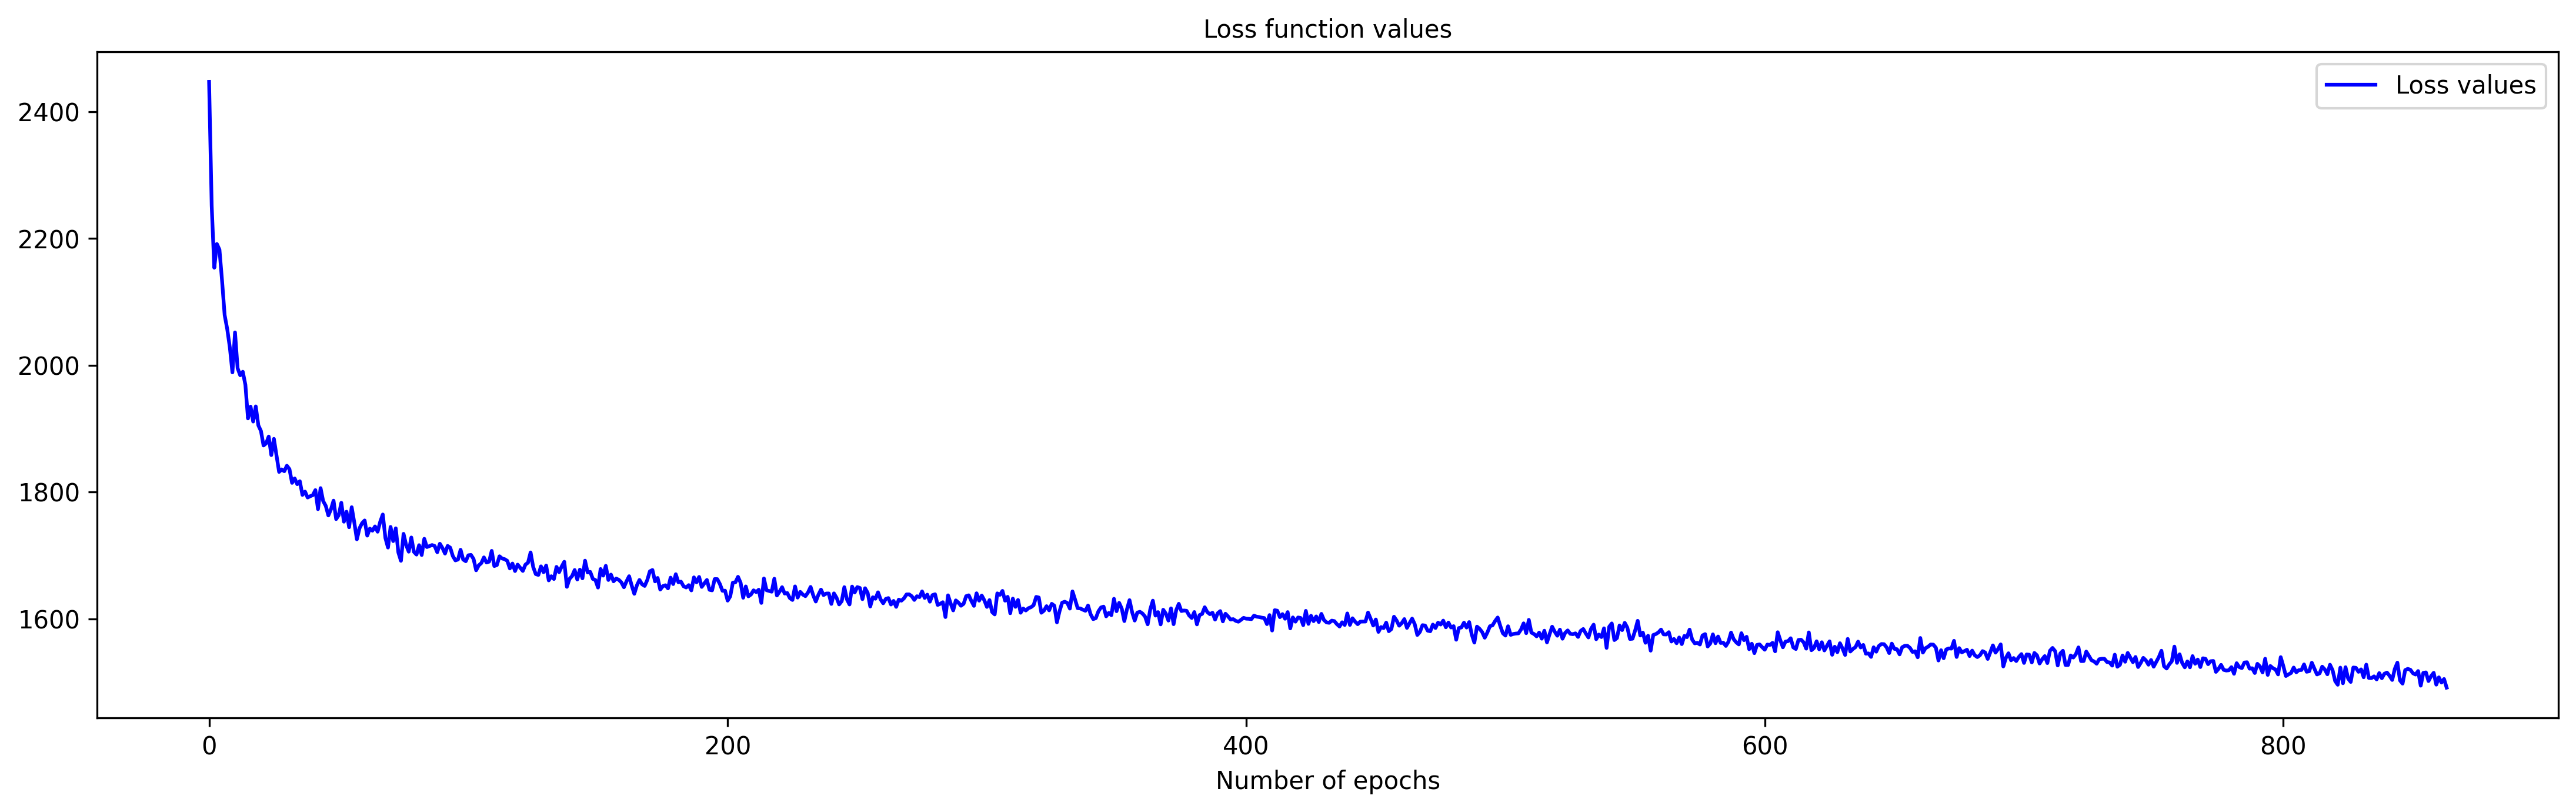

In [194]:
display_loss_values(nmtlr.model)

#### Tuning DeepSurv

In [170]:
deepsurv = DeepSurv()
deepsurv.tuning_and_construct(X_train, T_train, E_train,max_iter=max_iter)

% Completion: 100%|**********************************************|Loss: 1657.29
% Completion: 100%|**********************************************|Loss: 1350.86
% Completion: 100%|**********************************************|Loss: 1712.89
% Completion: 100%|**********************************************|Loss: 1404.74
% Completion: 100%|**********************************************|Loss: 1548.80
% Completion: 100%|**********************************************|Loss: 1643.42
% Completion: 100%|**********************************************|Loss: 1532.26
% Completion: 100%|**********************************************|Loss: 1818.24
% Completion: 100%|**********************************************|Loss: 1602.57
% Completion: 100%|**********************************************|Loss: 1772.93
% Completion: 100%|**********************************************|Loss: 1309.32
% Completion: 100%|**********************************************|Loss: 1653.71
% Completion: 100%|*********************

Number 4 thread ... mean_c_index:  0.648662179069879 is the best so far


% Completion: 100%|**********************************************|Loss: 1370.76
% Completion: 100%|**********************************************|Loss: 1610.58
% Completion: 100%|**********************************************|Loss: 1524.98
% Completion: 100%|**********************************************|Loss: 1669.18
% Completion: 100%|**********************************************|Loss: 1567.50
% Completion: 100%|**********************************************|Loss: 1826.45
% Completion: 100%|**********************************************|Loss: 1343.19


Number 10 thread ... mean_c_index:  0.6092933113666535 


% Completion: 100%|**********************************************|Loss: 1815.37
% Completion: 100%|**********************************************|Loss: 1356.50
% Completion: 100%|**********************************************|Loss: 1677.85


Number 3 thread ... mean_c_index:  0.6757719283971575 is the best so far


% Completion: 100%|***********************************************|Loss: 909.41
% Completion: 100%|**********************************************|Loss: 1532.91
% Completion: 100%|**********************************************|Loss: 1507.09
% Completion: 100%|**********************************************|Loss: 1698.73
% Completion: 100%|**********************************************|Loss: 1775.16
% Completion: 100%|**********************************************|Loss: 1431.36


Number 6 thread ... mean_c_index:  0.6708680445284522 


% Completion: 100%|**********************************************|Loss: 1824.89
% Completion: 100%|**********************************************|Loss: 1564.10


Number 5 thread ... mean_c_index:  0.6885875688811094 is the best so far


% Completion: 100%|**********************************************|Loss: 1550.07


Number 1 thread ... mean_c_index:  0.6890737816287634 is the best so far


% Completion: 100%|**********************************************|Loss: 1641.25


Number 8 thread ... mean_c_index:  0.7279935659566581 is the best so far


% Completion: 100%|**********************************************|Loss: 1799.97


Number 2 thread ... mean_c_index:  0.617947101512571 


% Completion: 100%|**********************************************|Loss: 1828.01


Number 9 thread ... mean_c_index:  0.5719409097881367 


% Completion: 100%|***********************************************|Loss: 914.71
% Completion: 100%|***********************************************|Loss: 979.09
% Completion: 100%|**********************************************|Loss: 1155.21


Number 7 thread ... mean_c_index:  0.6582810701511617 
{'total iteration': 11, 'best_param': {'structure': [{'activation': 'Hardtanh', 'num_units': 97}, {'activation': 'SELU', 'num_units': 83}, {'activation': 'Hardtanh', 'num_units': 75}, {'activation': 'BipolarSigmoid', 'num_units': 88}], 'optimizer': 'adadelta', 'lr': 0.00097, 'num_epochs': 2517, 'dropout': 0.1, 'l2_reg': 0.0022, 'batch_normalization': False}, 'best_score': 0.7279935659566581}


% Completion: 100%|**********************************************|Loss: 1910.88
% Completion: 100%|**********************************************|Loss: 1591.99
% Completion: 100%|**********************************************|Loss: 1759.73
% Completion: 100%|**********************************************|Loss: 1743.06
% Completion: 100%|**********************************************|Loss: 1873.96
% Completion: 100%|**********************************************|Loss: 1640.14
% Completion: 100%|**********************************************|Loss: 1820.20
% Completion: 100%|**********************************************|Loss: 1949.58
% Completion: 100%|**********************************************|Loss: 2119.20
% Completion: 100%|**********************************************|Loss: 1773.41
% Completion: 100%|**********************************************|Loss: 2000.07
% Completion: 100%|**********************************************|Loss: 1609.34
% Completion: 100%|*********************

Number 19 thread ... mean_c_index:  0.6692466183440466 


% Completion: 100%|**********************************************|Loss: 1655.16
% Completion: 100%|**********************************************|Loss: 1612.01
% Completion: 100%|**********************************************|Loss: 1833.02
% Completion: 100%|**********************************************|Loss: 1803.46
% Completion: 100%|**********************************************|Loss: 1826.03
% Completion: 100%|**********************************************|Loss: 1646.91


Number 15 thread ... mean_c_index:  0.7307547064299731 is the best so far


% Completion: 100%|**********************************************|Loss: 1733.78
% Completion: 100%|**********************************************|Loss: 1792.62


Number 13 thread ... mean_c_index:  0.594686565345395 


% Completion: 100%|**********************************************|Loss: 1495.57
% Completion: 100%|**********************************************|Loss: 1763.08
% Completion: 100%|**********************************************|Loss: 1732.65


Number 17 thread ... mean_c_index:  0.5866066512852698 


% Completion: 100%|***********************************************|Loss: 900.69
% Completion: 100%|**********************************************|Loss: 1713.72
% Completion: 100%|**********************************************|Loss: 1883.40
% Completion: 100%|***********************************************|Loss: 939.37
% Completion: 100%|***********************************************|Loss: 985.25
% Completion: 100%|**********************************************|Loss: 1810.04


Number 18 thread ... mean_c_index:  0.6106971113864368 


% Completion: 100%|**********************************************|Loss: 1674.60
% Completion: 100%|**********************************************|Loss: 1504.91
% Completion: 100%|***********************************************|Loss: 940.82
% Completion: 100%|**********************************************|Loss: 1664.75
% Completion: 100%|**********************************************|Loss: 1471.41
% Completion: 100%|**********************************************|Loss: 1104.73
% Completion: 100%|**********************************************|Loss: 1632.06


Number 12 thread ... mean_c_index:  0.7172119927932131 


% Completion: 100%|***********************************************|Loss: 809.96
% Completion: 100%|**********************************************|Loss: 1124.42
% Completion: 100%|**********************************************|Loss: 1518.72
% Completion: 100%|***********************************************|Loss: 837.84
% Completion: 100%|***********************************************|Loss: 966.05
% Completion: 100%|**********************************************|Loss: 1516.29


Number 11 thread ... mean_c_index:  0.680028427374878 


% Completion: 100%|***********************************************|Loss: 770.03


Number 14 thread ... mean_c_index:  0.6040761965279127 


% Completion: 100%|**********************************************|Loss: 1084.50
% Completion: 100%|***********************************************|Loss: 981.77
% Completion: 100%|***********************************************|Loss: 990.88
% Completion: 100%|***********************************************|Loss: 893.77


Number 20 thread ... mean_c_index:  0.6734354806361446 


% Completion: 100%|**********************************************|Loss: 1024.07


Number 16 thread ... mean_c_index:  0.6533552150535695 
{'total iteration': 21, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 10}], 'optimizer': 'adamax', 'lr': 0.00071, 'num_epochs': 941, 'dropout': 0.3, 'l2_reg': 0.004, 'batch_normalization': True}, 'best_score': 0.7307547064299731}


% Completion: 100%|**********************************************|Loss: 1740.43
% Completion: 100%|**********************************************|Loss: 1715.50
% Completion: 100%|**********************************************|Loss: 1867.88
% Completion: 100%|**********************************************|Loss: 1858.46
% Completion: 100%|**********************************************|Loss: 1764.53


Number 23 thread ... mean_c_index:  0.5767586914472084 


% Completion: 100%|**********************************************|Loss: 1718.61
% Completion: 100%|**********************************************|Loss: 1261.13
% Completion: 100%|**********************************************|Loss: 1730.20
% Completion: 100%|**********************************************|Loss: 1409.47
% Completion: 100%|**********************************************|Loss: 1619.88
% Completion: 100%|**********************************************|Loss: 1535.48
% Completion: 100%|***********************************************|Loss: 929.72
% Completion: 100%|**********************************************|Loss: 1155.97
% Completion: 100%|**********************************************|Loss: 1643.25
% Completion: 100%|**********************************************|Loss: 1806.35
% Completion: 100%|**********************************************|Loss: 1706.06
% Completion:  85%|***************************************       |Loss: 1399.69
% Completion: 100%|*********************

Number 21 thread ... mean_c_index:  0.7127448188737102 


% Completion: 100%|**********************************************|Loss: 1640.93
% Completion: 100%|**********************************************|Loss: 1774.05
% Completion: 100%|**********************************************|Loss: 1223.66


Number 28 thread ... mean_c_index:  0.6436307036721013 


% Completion: 100%|**********************************************|Loss: 1830.11
% Completion: 100%|**********************************************|Loss: 1566.25
% Completion: 100%|**********************************************|Loss: 1563.57
% Completion: 100%|**********************************************|Loss: 1436.99
% Completion: 100%|***********************************************|Loss: 950.66
% Completion: 100%|**********************************************|Loss: 1696.10


Number 25 thread ... mean_c_index:  0.7066879387110757 


% Completion: 100%|**********************************************|Loss: 1309.55


Number 29 thread ... mean_c_index:  0.6267083087436163 


% Completion: 100%|**********************************************|Loss: 1567.92
% Completion: 100%|**********************************************|Loss: 1615.58
% Completion: 100%|***********************************************|Loss: 861.86
% Completion: 100%|**********************************************|Loss: 1772.51
% Completion: 100%|**********************************************|Loss: 1594.05


Number 30 thread ... mean_c_index:  0.6972006576608839 


% Completion: 100%|**********************************************|Loss: 1470.48
% Completion: 100%|***********************************************|Loss: 968.76


Number 27 thread ... mean_c_index:  0.6092733066295594 


% Completion: 100%|**********************************************|Loss: 1639.59
% Completion: 100%|**********************************************|Loss: 1785.02
% Completion: 100%|**********************************************|Loss: 1689.63


Number 22 thread ... mean_c_index:  0.732035724736442 is the best so far


% Completion: 100%|**********************************************|Loss: 1497.48
% Completion: 100%|**********************************************|Loss: 1780.28


Number 24 thread ... mean_c_index:  0.721745333527911 


% Completion: 100%|**********************************************|Loss: 1456.24


Number 26 thread ... mean_c_index:  0.6758193963367525 
{'total iteration': 31, 'best_param': {'structure': [{'activation': 'Sigmoid', 'num_units': 40}, {'activation': 'Gaussian', 'num_units': 36}, {'activation': 'Softmax', 'num_units': 86}, {'activation': 'Tanh', 'num_units': 53}], 'optimizer': 'adamax', 'lr': 0.00062, 'num_epochs': 2846, 'dropout': 0.2, 'l2_reg': 0.0085, 'batch_normalization': False}, 'best_score': 0.732035724736442}


% Completion: 100%|**********************************************|Loss: 1916.40
% Completion: 100%|**********************************************|Loss: 1738.16
% Completion: 100%|**********************************************|Loss: 2144.41
% Completion: 100%|**********************************************|Loss: 1483.29
% Completion: 100%|**********************************************|Loss: 2536.95
% Completion: 100%|**********************************************|Loss: 1769.38
% Completion:  96%|********************************************  |Loss: 1405.40
% Completion: 100%|**********************************************|Loss: 1395.17
% Completion: 100%|**********************************************|Loss: 2375.26
% Completion: 100%|**********************************************|Loss: 1775.81


Number 31 thread ... mean_c_index:  0.5457332659266854 


% Completion: 100%|**********************************************|Loss: 1405.08
% Completion: 100%|**********************************************|Loss: 1788.23
% Completion: 100%|***********************************************|Loss: 945.72
% Completion: 100%|**********************************************|Loss: 1046.54
% Completion: 100%|**********************************************|Loss: 1493.71
% Completion: 100%|**********************************************|Loss: 1737.49


Number 40 thread ... mean_c_index:  0.687137638895261 


% Completion: 100%|**********************************************|Loss: 1474.67


Number 33 thread ... mean_c_index:  0.6865599570565124 


% Completion: 100%|**********************************************|Loss: 1067.05
% Completion: 100%|**********************************************|Loss: 1035.01
% Completion: 100%|**********************************************|Loss: 1099.07
% Completion: 100%|**********************************************|Loss: 1599.00
% Completion: 100%|**********************************************|Loss: 1009.27
% Completion: 100%|**********************************************|Loss: 1194.76
% Completion: 100%|**********************************************|Loss: 1089.67
% Completion: 100%|**********************************************|Loss: 1554.82
% Completion:  85%|***************************************       |Loss: 1038.80
% Completion: 100%|**********************************************|Loss: 1009.09
% Completion: 100%|**********************************************|Loss: 1799.04
% Completion: 100%|**********************************************|Loss: 1099.73
% Completion: 100%|*********************

Number 34 thread ... mean_c_index:  0.6394356386489719 


% Completion: 100%|**********************************************|Loss: 1110.59


Number 39 thread ... mean_c_index:  0.6193118531745351 


% Completion: 100%|**********************************************|Loss: 1515.11
% Completion: 100%|**********************************************|Loss: 1126.17
% Completion: 100%|**********************************************|Loss: 1602.69
% Completion: 100%|**********************************************|Loss: 1097.91
% Completion: 100%|**********************************************|Loss: 1842.83


Number 36 thread ... mean_c_index:  0.6384289718171181 


% Completion: 100%|**********************************************|Loss: 1585.92
% Completion: 100%|**********************************************|Loss: 1793.13
% Completion: 100%|**********************************************|Loss: 1585.44
% Completion: 100%|**********************************************|Loss: 1661.83
% Completion: 100%|**********************************************|Loss: 1885.73
% Completion: 100%|**********************************************|Loss: 1800.21
% Completion: 100%|**********************************************|Loss: 1592.37
% Completion: 100%|**********************************************|Loss: 1580.16


Number 38 thread ... mean_c_index:  0.7084273286507875 


% Completion: 100%|**********************************************|Loss: 1843.03
% Completion: 100%|**********************************************|Loss: 1624.60


Number 35 thread ... mean_c_index:  0.7265862543565518 


% Completion: 100%|**********************************************|Loss: 1753.32
% Completion: 100%|**********************************************|Loss: 1842.93


Number 32 thread ... mean_c_index:  0.6405710846236071 


% Completion: 100%|**********************************************|Loss: 1728.28


Number 37 thread ... mean_c_index:  0.6463534074019217 
{'total iteration': 41, 'best_param': {'structure': [{'activation': 'Sigmoid', 'num_units': 40}, {'activation': 'Gaussian', 'num_units': 36}, {'activation': 'Softmax', 'num_units': 86}, {'activation': 'Tanh', 'num_units': 53}], 'optimizer': 'adamax', 'lr': 0.00062, 'num_epochs': 2846, 'dropout': 0.2, 'l2_reg': 0.0085, 'batch_normalization': False}, 'best_score': 0.732035724736442}


% Completion: 100%|**********************************************|Loss: 1283.70
% Completion: 100%|**********************************************|Loss: 1380.13
% Completion: 100%|**********************************************|Loss: 1348.20
% Completion: 100%|**********************************************|Loss: 1275.00
% Completion: 100%|**********************************************|Loss: 1366.77


Number 44 thread ... mean_c_index:  0.6759829469946798 


% Completion: 100%|**********************************************|Loss: 1655.09
% Completion: 100%|**********************************************|Loss: 1748.03
% Completion: 100%|**********************************************|Loss: 1627.40
% Completion: 100%|**********************************************|Loss: 1832.85
% Completion: 100%|**********************************************|Loss: 1697.55
% Completion: 100%|**********************************************|Loss: 1071.79
% Completion: 100%|**********************************************|Loss: 1644.93
% Completion: 100%|**********************************************|Loss: 1035.03
% Completion: 100%|**********************************************|Loss: 1822.79
% Completion: 100%|**********************************************|Loss: 1605.64
% Completion: 100%|**********************************************|Loss: 1522.20
% Completion: 100%|**********************************************|Loss: 1633.67
% Completion: 100%|*********************

Number 41 thread ... mean_c_index:  0.732264732837807 is the best so far


% Completion: 100%|**********************************************|Loss: 1618.50
% Completion: 100%|**********************************************|Loss: 1484.37
% Completion: 100%|**********************************************|Loss: 1804.68
% Completion: 100%|**********************************************|Loss: 1727.24
% Completion: 100%|**********************************************|Loss: 1094.92
% Completion: 100%|**********************************************|Loss: 1788.70


Number 47 thread ... mean_c_index:  0.6961682381617181 


% Completion: 100%|***********************************************|Loss: 861.13
% Completion: 100%|**********************************************|Loss: 1561.64


Number 46 thread ... mean_c_index:  0.708616473473713 


% Completion: 100%|**********************************************|Loss: 1876.15
% Completion: 100%|**********************************************|Loss: 1707.67
% Completion: 100%|**********************************************|Loss: 1632.63
% Completion: 100%|**********************************************|Loss: 1052.18
% Completion: 100%|**********************************************|Loss: 1730.20
% Completion: 100%|***********************************************|Loss: 793.31
% Completion: 100%|**********************************************|Loss: 1731.37


Number 43 thread ... mean_c_index:  0.7233328991450614 


% Completion: 100%|**********************************************|Loss: 1900.78


Number 42 thread ... mean_c_index:  0.7129767203829063 


% Completion: 100%|**********************************************|Loss: 1039.51


Number 50 thread ... mean_c_index:  0.6027424172093547 


% Completion: 100%|***********************************************|Loss: 976.49


Number 48 thread ... mean_c_index:  0.6102992207957342 


% Completion: 100%|**********************************************|Loss: 1582.61
% Completion: 100%|**********************************************|Loss: 1712.23
% Completion: 100%|**********************************************|Loss: 1649.67


Number 49 thread ... mean_c_index:  0.7207263445106893 


% Completion: 100%|**********************************************|Loss: 1698.09
% Completion: 100%|**********************************************|Loss: 1712.34


Number 45 thread ... mean_c_index:  0.6418084486270421 
{'total iteration': 51, 'best_param': {'structure': [{'activation': 'BentIdentity', 'num_units': 65}], 'optimizer': 'rmsprop', 'lr': 9e-05, 'num_epochs': 2818, 'dropout': 0.2, 'l2_reg': 0.0092, 'batch_normalization': False}, 'best_score': 0.732264732837807}


% Completion: 100%|**********************************************|Loss: 1761.60
% Completion: 100%|**********************************************|Loss: 1662.14
% Completion: 100%|**********************************************|Loss: 1698.44
% Completion: 100%|**********************************************|Loss: 1628.22
% Completion: 100%|**********************************************|Loss: 1838.39
% Completion: 100%|**********************************************|Loss: 1661.66
% Completion: 100%|**********************************************|Loss: 1728.67
% Completion: 100%|**********************************************|Loss: 1899.11
% Completion: 100%|**********************************************|Loss: 1638.91
% Completion: 100%|**********************************************|Loss: 1610.79
% Completion: 100%|**********************************************|Loss: 1539.99
% Completion: 100%|**********************************************|Loss: 1717.16
% Completion: 100%|*********************

Number 58 thread ... mean_c_index:  0.7271729621882264 


% Completion: 100%|**********************************************|Loss: 1763.65
% Completion: 100%|**********************************************|Loss: 1677.87


Number 60 thread ... mean_c_index:  0.7223734025098667 


% Completion: 100%|**********************************************|Loss: 1646.01
% Completion: 100%|**********************************************|Loss: 1514.28
% Completion: 100%|**********************************************|Loss: 1096.83
% Completion: 100%|**********************************************|Loss: 1899.79
% Completion: 100%|**********************************************|Loss: 1671.24
% Completion: 100%|**********************************************|Loss: 1456.15
% Completion: 100%|**********************************************|Loss: 1744.95
% Completion: 100%|**********************************************|Loss: 1656.94
% Completion: 100%|**********************************************|Loss: 1707.54
% Completion: 100%|**********************************************|Loss: 1846.09
% Completion: 100%|**********************************************|Loss: 1626.56
% Completion: 100%|**********************************************|Loss: 1618.96
% Completion: 100%|*********************

Number 56 thread ... mean_c_index:  0.6754676370294305 


% Completion: 100%|**********************************************|Loss: 1677.44


Number 51 thread ... mean_c_index:  0.7364659453288431 is the best so far


% Completion: 100%|**********************************************|Loss: 1480.31
% Completion: 100%|**********************************************|Loss: 1817.20


Number 53 thread ... mean_c_index:  0.5715101349559666 


% Completion: 100%|**********************************************|Loss: 1632.67


Number 54 thread ... mean_c_index:  0.7354805934591865 


% Completion: 100%|**********************************************|Loss: 1608.48


Number 59 thread ... mean_c_index:  0.675590797999007 


% Completion: 100%|**********************************************|Loss: 1638.69
% Completion: 100%|**********************************************|Loss: 1473.32
% Completion: 100%|**********************************************|Loss: 1119.15
% Completion: 100%|**********************************************|Loss: 1633.75


Number 52 thread ... mean_c_index:  0.7293628424172391 


% Completion: 100%|**********************************************|Loss: 1471.65
% Completion: 100%|**********************************************|Loss: 1095.09
% Completion: 100%|**********************************************|Loss: 1439.46


Number 55 thread ... mean_c_index:  0.6931385724755474 


% Completion: 100%|**********************************************|Loss: 1211.06


Number 57 thread ... mean_c_index:  0.60786440140829 
{'total iteration': 61, 'best_param': {'structure': [{'activation': 'SELU', 'num_units': 15}], 'optimizer': 'adam', 'lr': 0.00014, 'num_epochs': 3977, 'dropout': 0.1, 'l2_reg': 0.0064, 'batch_normalization': False}, 'best_score': 0.7364659453288431}


% Completion: 100%|**********************************************|Loss: 1655.41
% Completion: 100%|**********************************************|Loss: 1472.97
% Completion: 100%|**********************************************|Loss: 1720.66
% Completion: 100%|**********************************************|Loss: 1704.77
% Completion: 100%|**********************************************|Loss: 1466.96
% Completion: 100%|**********************************************|Loss: 1637.79
% Completion: 100%|**********************************************|Loss: 1544.69
% Completion: 100%|**********************************************|Loss: 1567.89


Number 64 thread ... mean_c_index:  0.71713771935934 


% Completion: 100%|**********************************************|Loss: 1581.66
% Completion: 100%|**********************************************|Loss: 1543.80
% Completion: 100%|**********************************************|Loss: 1643.12
% Completion: 100%|**********************************************|Loss: 1544.83


Number 62 thread ... mean_c_index:  0.6842648316441557 


% Completion: 100%|**********************************************|Loss: 1639.71
% Completion: 100%|**********************************************|Loss: 1549.02
% Completion: 100%|**********************************************|Loss: 1632.74
% Completion: 100%|**********************************************|Loss: 1602.49
% Completion: 100%|**********************************************|Loss: 1029.51
% Completion: 100%|**********************************************|Loss: 1571.23
% Completion: 100%|**********************************************|Loss: 1258.14
% Completion: 100%|**********************************************|Loss: 1695.77
% Completion: 100%|**********************************************|Loss: 1698.12
% Completion: 100%|**********************************************|Loss: 1131.94
% Completion: 100%|**********************************************|Loss: 1502.71
% Completion: 100%|**********************************************|Loss: 1702.50
% Completion: 100%|*********************

Number 69 thread ... mean_c_index:  0.7354123880907963 


% Completion: 100%|**********************************************|Loss: 1602.38
% Completion: 100%|**********************************************|Loss: 1030.56
% Completion: 100%|**********************************************|Loss: 1545.22
% Completion: 100%|**********************************************|Loss: 1158.63
% Completion: 100%|**********************************************|Loss: 1518.31
% Completion: 100%|**********************************************|Loss: 1684.17


Number 65 thread ... mean_c_index:  0.7227544826280684 


% Completion: 100%|**********************************************|Loss: 1521.66
% Completion: 100%|**********************************************|Loss: 1086.61
% Completion: 100%|***********************************************|Loss: 932.15
% Completion: 100%|**********************************************|Loss: 1523.36
% Completion: 100%|**********************************************|Loss: 1153.35
% Completion: 100%|***********************************************|Loss: 883.81
% Completion: 100%|**********************************************|Loss: 1451.57


Number 63 thread ... mean_c_index:  0.6787537959811425 


% Completion: 100%|**********************************************|Loss: 1479.66
% Completion:  54%|************************                      |Loss: 1111.58
% Completion: 100%|**********************************************|Loss: 1185.63
% Completion: 100%|**********************************************|Loss: 1078.88
% Completion: 100%|***********************************************|Loss: 956.73
% Completion: 100%|**********************************************|Loss: 1560.18


Number 70 thread ... mean_c_index:  0.6530070888751192 


% Completion: 100%|**********************************************|Loss: 1059.41


Number 68 thread ... mean_c_index:  0.6441991773293079 


% Completion: 100%|**********************************************|Loss: 1124.37


Number 67 thread ... mean_c_index:  0.6618037408310447 


% Completion: 100%|***********************************************|Loss: 981.69
% Completion: 100%|**********************************************|Loss: 1103.77
% Completion: 100%|***********************************************|Loss: 934.17
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)


Number 61 thread ... mean_c_index:  0.5643128238443637 


% Completion: 100%|**********************************************|Loss: 1145.05


Number 66 thread ... mean_c_index:  0.6517189737774567 
{'total iteration': 71, 'best_param': {'structure': [{'activation': 'SELU', 'num_units': 15}], 'optimizer': 'adam', 'lr': 0.00014, 'num_epochs': 3977, 'dropout': 0.1, 'l2_reg': 0.0064, 'batch_normalization': False}, 'best_score': 0.7364659453288431}


% Completion: 100%|**********************************************|Loss: 1865.75
% Completion: 100%|**********************************************|Loss: 1762.40
% Completion: 100%|**********************************************|Loss: 1756.44
% Completion: 100%|**********************************************|Loss: 1723.88
% Completion: 100%|**********************************************|Loss: 1420.22
% Completion: 100%|**********************************************|Loss: 1841.50


Number 76 thread ... mean_c_index:  0.7124060169653974 


% Completion: 100%|**********************************************|Loss: 1773.41
% Completion: 100%|**********************************************|Loss: 1508.07
% Completion: 100%|**********************************************|Loss: 1799.73
% Completion: 100%|**********************************************|Loss: 1473.52
% Completion: 100%|**********************************************|Loss: 1819.72
% Completion: 100%|**********************************************|Loss: 1517.43
% Completion: 100%|**********************************************|Loss: 1767.38
% Completion: 100%|**********************************************|Loss: 1511.80


Number 78 thread ... mean_c_index:  0.6841834340604609 


% Completion: 100%|**********************************************|Loss: 1767.75


Number 80 thread ... mean_c_index:  0.714294668488685 


% Completion: 100%|***********************************************|Loss: 924.27
% Completion: 100%|**********************************************|Loss: 1194.86
% Completion: 100%|**********************************************|Loss: 1709.58
% Completion: 100%|***********************************************|Loss: 612.92
% Completion: 100%|**********************************************|Loss: 1596.59
% Completion: 100%|***********************************************|Loss: 926.76
% Completion: 100%|**********************************************|Loss: 1616.20
% Completion: 100%|**********************************************|Loss: 1216.25
% Completion: 100%|**********************************************|Loss: 1171.97
% Completion: 100%|**********************************************|Loss: 1729.69
% Completion: 100%|***********************************************|Loss: 870.18
% Completion: 100%|***********************************************|Loss: 577.37
% Completion: 100%|*********************

Number 74 thread ... mean_c_index:  0.6386083466811661 


% Completion: 100%|**********************************************|Loss: 1305.90
% Completion: 100%|**********************************************|Loss: 1276.67
% Completion: 100%|**********************************************|Loss: 1697.09
% Completion: 100%|**********************************************|Loss: 1551.32
% Completion: 100%|***********************************************|Loss: 563.45
% Completion: 100%|**********************************************|Loss: 1188.40


Number 77 thread ... mean_c_index:  0.6609969812850924 


% Completion: 100%|**********************************************|Loss: 1740.30


Number 71 thread ... mean_c_index:  0.6427822502132112 


% Completion: 100%|**********************************************|Loss: 1250.71
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 618.33


Number 73 thread ... mean_c_index:  0.619330692391012 


% Completion: 100%|**********************************************|Loss: 1574.37
% Completion: 100%|**********************************************|Loss: 1593.09


Number 75 thread ... mean_c_index:  0.6876845532311122 


% Completion: 100%|**********************************************|Loss: 1121.46
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|**********************************************|Loss: 1162.87


Number 72 thread ... mean_c_index:  0.6221915669747007 
{'total iteration': 81, 'best_param': {'structure': [{'activation': 'SELU', 'num_units': 15}], 'optimizer': 'adam', 'lr': 0.00014, 'num_epochs': 3977, 'dropout': 0.1, 'l2_reg': 0.0064, 'batch_normalization': False}, 'best_score': 0.7364659453288431}


% Completion: 100%|**********************************************|Loss: 1788.33
% Completion: 100%|**********************************************|Loss: 1629.86
% Completion: 100%|**********************************************|Loss: 1921.86
% Completion: 100%|**********************************************|Loss: 1593.64
% Completion: 100%|**********************************************|Loss: 1690.30
% Completion: 100%|**********************************************|Loss: 1589.49
% Completion: 100%|**********************************************|Loss: 1765.48
% Completion: 100%|**********************************************|Loss: 1597.46
% Completion: 100%|**********************************************|Loss: 1749.83
% Completion: 100%|**********************************************|Loss: 1713.42
% Completion: 100%|***********************************************|Loss: 980.47
% Completion: 100%|**********************************************|Loss: 1796.36


Number 87 thread ... mean_c_index:  0.5829024516850808 


% Completion: 100%|**********************************************|Loss: 1649.38


Number 86 thread ... mean_c_index:  0.7361519915838857 


% Completion: 100%|**********************************************|Loss: 1735.02
% Completion: 100%|**********************************************|Loss: 1756.35
% Completion: 100%|**********************************************|Loss: 1523.09
% Completion: 100%|**********************************************|Loss: 1178.05
% Completion: 100%|**********************************************|Loss: 1015.41
% Completion: 100%|***********************************************|Loss: 954.96
% Completion: 100%|**********************************************|Loss: 1778.86
% Completion: 100%|**********************************************|Loss: 1510.35
% Completion: 100%|**********************************************|Loss: 1628.49
% Completion: 100%|**********************************************|Loss: 1228.63
% Completion: 100%|***********************************************|Loss: 975.63
% Completion: 100%|**********************************************|Loss: 1726.13
% Completion: 100%|*********************

Number 90 thread ... mean_c_index:  0.6246256668593188 


% Completion: 100%|**********************************************|Loss: 1577.32


Number 88 thread ... mean_c_index:  0.707186296887917 


% Completion: 100%|***********************************************|Loss: 921.92
% Completion: 100%|**********************************************|Loss: 1022.13


Number 89 thread ... mean_c_index:  0.644260036442817 


% Completion: 100%|**********************************************|Loss: 1722.04
% Completion: 100%|***********************************************|Loss: 846.97
% Completion: 100%|**********************************************|Loss: 1178.54
% Completion: 100%|**********************************************|Loss: 1755.74


Number 82 thread ... mean_c_index:  0.7041179596662926 


% Completion: 100%|***********************************************|Loss: 997.66
% Completion: 100%|**********************************************|Loss: 1697.61
% Completion: 100%|**********************************************|Loss: 1204.25
% Completion: 100%|***********************************************|Loss: 950.81
% Completion: 100%|**********************************************|Loss: 1003.51
% Completion: 100%|**********************************************|Loss: 1176.39


Number 84 thread ... mean_c_index:  0.622807959432376 


% Completion: 100%|**********************************************|Loss: 1795.71
% Completion: 100%|**********************************************|Loss: 1000.27


Number 81 thread ... mean_c_index:  0.6368092179321073 


% Completion: 100%|**********************************************|Loss: 1405.23
% Completion: 100%|**********************************************|Loss: 1679.83
% Completion: 100%|**********************************************|Loss: 1093.26


Number 83 thread ... mean_c_index:  0.6212436922295262 


% Completion: 100%|**********************************************|Loss: 1778.80


Number 85 thread ... mean_c_index:  0.6235704100447359 
{'total iteration': 91, 'best_param': {'structure': [{'activation': 'SELU', 'num_units': 15}], 'optimizer': 'adam', 'lr': 0.00014, 'num_epochs': 3977, 'dropout': 0.1, 'l2_reg': 0.0064, 'batch_normalization': False}, 'best_score': 0.7364659453288431}


% Completion: 100%|**********************************************|Loss: 1675.22
% Completion: 100%|**********************************************|Loss: 1773.63
% Completion: 100%|**********************************************|Loss: 1580.51
% Completion: 100%|**********************************************|Loss: 1626.19
% Completion: 100%|**********************************************|Loss: 1741.26
% Completion: 100%|**********************************************|Loss: 1794.71
% Completion: 100%|**********************************************|Loss: 1642.83
% Completion: 100%|**********************************************|Loss: 1723.97
% Completion: 100%|**********************************************|Loss: 1655.19
% Completion: 100%|**********************************************|Loss: 1759.59
% Completion: 100%|**********************************************|Loss: 1673.25
% Completion: 100%|**********************************************|Loss: 1760.25
% Completion: 100%|*********************

Number 98 thread ... mean_c_index:  0.7362826735163563 


% Completion: 100%|**********************************************|Loss: 1888.87
% Completion: 100%|**********************************************|Loss: 1687.07
% Completion: 100%|**********************************************|Loss: 1762.59
% Completion: 100%|**********************************************|Loss: 1802.96


Number 95 thread ... mean_c_index:  0.5834313826997766 


% Completion: 100%|**********************************************|Loss: 1650.00
% Completion: 100%|**********************************************|Loss: 1770.97
% Completion: 100%|**********************************************|Loss: 1665.00
% Completion: 100%|**********************************************|Loss: 1032.65
% Completion: 100%|**********************************************|Loss: 1644.70


Number 100 thread ... mean_c_index:  0.7306918094189057 


% Completion: 100%|**********************************************|Loss: 1779.08
% Completion: 100%|**********************************************|Loss: 1775.98
% Completion: 100%|**********************************************|Loss: 1607.04
% Completion: 100%|**********************************************|Loss: 1648.47
% Completion: 100%|**********************************************|Loss: 1810.44


Number 97 thread ... mean_c_index:  0.5985029620428748 


% Completion: 100%|**********************************************|Loss: 1757.86
% Completion: 100%|**********************************************|Loss: 1473.45
% Completion: 100%|**********************************************|Loss: 1834.74
% Completion: 100%|**********************************************|Loss: 1645.50
% Completion: 100%|***********************************************|Loss: 918.97
% Completion: 100%|**********************************************|Loss: 1595.02
% Completion: 100%|**********************************************|Loss: 1796.15
% Completion: 100%|**********************************************|Loss: 1829.71
% Completion: 100%|**********************************************|Loss: 1613.49


Number 91 thread ... mean_c_index:  0.7350640973481596 


% Completion: 100%|**********************************************|Loss: 1654.98
% Completion: 100%|***********************************************|Loss: 959.29
% Completion: 100%|**********************************************|Loss: 1803.70


Number 93 thread ... mean_c_index:  0.6471254315429782 


% Completion: 100%|**********************************************|Loss: 1879.02
% Completion: 100%|**********************************************|Loss: 1735.25


Number 99 thread ... mean_c_index:  0.7253655646610446 


% Completion: 100%|**********************************************|Loss: 1424.49
% Completion: 100%|***********************************************|Loss: 872.90
% Completion: 100%|**********************************************|Loss: 1783.92


Number 94 thread ... mean_c_index:  0.6824707803195146 


% Completion: 100%|**********************************************|Loss: 1481.39
% Completion: 100%|***********************************************|Loss: 991.32


Number 96 thread ... mean_c_index:  0.6156104662268872 


% Completion: 100%|**********************************************|Loss: 1384.84
% Completion: 100%|**********************************************|Loss: 1512.18


Number 92 thread ... mean_c_index:  0.6535796611486341 
{'total iteration': 101, 'best_param': {'structure': [{'activation': 'SELU', 'num_units': 15}], 'optimizer': 'adam', 'lr': 0.00014, 'num_epochs': 3977, 'dropout': 0.1, 'l2_reg': 0.0064, 'batch_normalization': False}, 'best_score': 0.7364659453288431}


% Completion: 100%|**********************************************|Loss: 1841.44
% Completion: 100%|**********************************************|Loss: 1774.59
% Completion: 100%|**********************************************|Loss: 1874.39
% Completion: 100%|**********************************************|Loss: 1773.86
% Completion: 100%|**********************************************|Loss: 1862.65


Number 104 thread ... mean_c_index:  0.6755251579219725 


% Completion: 100%|**********************************************|Loss: 1492.93
% Completion: 100%|**********************************************|Loss: 1829.54
% Completion: 100%|**********************************************|Loss: 1660.61
% Completion: 100%|**********************************************|Loss: 1702.32
% Completion: 100%|**********************************************|Loss: 1613.91
% Completion: 100%|**********************************************|Loss: 1660.46
% Completion: 100%|**********************************************|Loss: 1629.13
% Completion: 100%|**********************************************|Loss: 1830.63
% Completion: 100%|**********************************************|Loss: 1632.76
% Completion: 100%|**********************************************|Loss: 1506.35
% Completion: 100%|**********************************************|Loss: 1741.96
% Completion: 100%|**********************************************|Loss: 1418.97
% Completion: 100%|*********************

Number 102 thread ... mean_c_index:  0.6965475771190561 


% Completion: 100%|**********************************************|Loss: 1752.78
% Completion: 100%|**********************************************|Loss: 1704.45
% Completion: 100%|**********************************************|Loss: 1754.98
% Completion: 100%|**********************************************|Loss: 1589.70
% Completion: 100%|**********************************************|Loss: 1655.36
% Completion: 100%|**********************************************|Loss: 1572.35
% Completion: 100%|**********************************************|Loss: 1807.74


Number 107 thread ... mean_c_index:  0.5730843664305011 


% Completion: 100%|**********************************************|Loss: 1812.26
% Completion: 100%|**********************************************|Loss: 1668.13


Number 110 thread ... mean_c_index:  0.7385454533238909 is the best so far


% Completion: 100%|**********************************************|Loss: 1468.24
% Completion: 100%|**********************************************|Loss: 1608.78
% Completion: 100%|**********************************************|Loss: 1607.33
% Completion: 100%|**********************************************|Loss: 1650.73
% Completion: 100%|**********************************************|Loss: 1664.14


Number 108 thread ... mean_c_index:  0.6419496842726347 


% Completion: 100%|**********************************************|Loss: 1759.94


Number 105 thread ... mean_c_index:  0.7216962083934003 


% Completion: 100%|**********************************************|Loss: 1775.17
% Completion: 100%|**********************************************|Loss: 1580.51


Number 103 thread ... mean_c_index:  0.7137655038959761 


% Completion: 100%|**********************************************|Loss: 1476.32
% Completion: 100%|**********************************************|Loss: 1591.55
% Completion: 100%|**********************************************|Loss: 1739.39
% Completion: 100%|**********************************************|Loss: 1458.83
% Completion: 100%|**********************************************|Loss: 1602.46
% Completion: 100%|**********************************************|Loss: 1705.75
% Completion: 100%|**********************************************|Loss: 1543.88


Number 106 thread ... mean_c_index:  0.6827343397882224 


% Completion: 100%|**********************************************|Loss: 1570.65


Number 101 thread ... mean_c_index:  0.7323749638374801 


% Completion: 100%|**********************************************|Loss: 1681.24


Number 109 thread ... mean_c_index:  0.6300788340022707 
{'total iteration': 111, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 39}], 'optimizer': 'sgd', 'lr': 0.00047, 'num_epochs': 4284, 'dropout': 0.3, 'l2_reg': 0.0064, 'batch_normalization': False}, 'best_score': 0.7385454533238909}


% Completion: 100%|**********************************************|Loss: 1554.05
% Completion: 100%|**********************************************|Loss: 1786.48
% Completion: 100%|**********************************************|Loss: 1779.71
% Completion: 100%|**********************************************|Loss: 2180.88
% Completion: 100%|**********************************************|Loss: 1591.62
% Completion: 100%|***********************************************|Loss: 905.66
% Completion: 100%|**********************************************|Loss: 1653.77
% Completion: 100%|**********************************************|Loss: 1553.29
% Completion: 100%|**********************************************|Loss: 1674.41
% Completion: 100%|**********************************************|Loss: 1824.00
% Completion: 100%|**********************************************|Loss: 1765.90
% Completion: 100%|**********************************************|Loss: 1797.04
% Completion: 100%|*********************

Number 119 thread ... mean_c_index:  0.7001466855912155 


% Completion: 100%|**********************************************|Loss: 1746.77
% Completion: 100%|**********************************************|Loss: 1752.62
% Completion: 100%|**********************************************|Loss: 1751.14
% Completion: 100%|***********************************************|Loss: 936.62
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|**********************************************|Loss: 1573.07
% Completion: 100%|**********************************************|Loss: 1653.17
% Completion: 100%|**********************************************|Loss: 1791.49
% Completion: 100%|**********************************************|Loss: 1769.71
% Completion: 100%|**********************************************|Loss: 1785.41
% Completion: 100%|**********************************************|Loss: 2029.10
% Completion:

Number 116 thread ... mean_c_index:  0.6629480773003079 


% Completion: 100%|**********************************************|Loss: 1535.60
% Completion: 100%|***********************************************|Loss: 998.21
% Completion: 100%|**********************************************|Loss: 1688.85
% Completion: 100%|**********************************************|Loss: 1542.87
% Completion: 100%|**********************************************|Loss: 1781.01


Number 112 thread ... mean_c_index:  0.655897251717057 


% Completion: 100%|**********************************************|Loss: 1733.07


Number 113 thread ... mean_c_index:  0.5494128976257663 


% Completion: 100%|**********************************************|Loss: 1615.75
% Completion: 100%|***********************************************|Loss: 894.43
% Completion: 100%|**********************************************|Loss: 1780.37
% Completion: 100%|**********************************************|Loss: 1801.10
% Completion: 100%|**********************************************|Loss: 1807.28
% Completion: 100%|**********************************************|Loss: 1582.77
% Completion: 100%|**********************************************|Loss: 1737.79


Number 117 thread ... mean_c_index:  0.7158352186068317 


% Completion: 100%|**********************************************|Loss: 1627.45


Number 111 thread ... mean_c_index:  0.7272886161500504 


% Completion: 100%|***********************************************|Loss: 991.25


Number 120 thread ... mean_c_index:  0.5704271830176072 


% Completion: 100%|**********************************************|Loss: 1738.62
% Completion: 100%|**********************************************|Loss: 1737.42
% Completion: 100%|**********************************************|Loss: 1750.27


Number 115 thread ... mean_c_index:  0.6954342498793857 


% Completion: 100%|**********************************************|Loss: 1504.65
% Completion: 100%|**********************************************|Loss: 1784.68
% Completion: 100%|**********************************************|Loss: 1514.76


Number 114 thread ... mean_c_index:  0.6844875126043218 


% Completion: 100%|**********************************************|Loss: 1795.41


Number 118 thread ... mean_c_index:  0.6136530400899861 
{'total iteration': 121, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 39}], 'optimizer': 'sgd', 'lr': 0.00047, 'num_epochs': 4284, 'dropout': 0.3, 'l2_reg': 0.0064, 'batch_normalization': False}, 'best_score': 0.7385454533238909}


% Completion: 100%|**********************************************|Loss: 1602.25
% Completion: 100%|**********************************************|Loss: 1830.91
% Completion: 100%|**********************************************|Loss: 1643.21
% Completion: 100%|**********************************************|Loss: 1644.06
% Completion: 100%|**********************************************|Loss: 1747.63
% Completion: 100%|**********************************************|Loss: 1665.61
% Completion: 100%|**********************************************|Loss: 1555.60
% Completion: 100%|**********************************************|Loss: 1699.62


Number 128 thread ... mean_c_index:  0.731564987049973 


% Completion: 100%|**********************************************|Loss: 1816.17
% Completion: 100%|**********************************************|Loss: 1844.51
% Completion: 100%|**********************************************|Loss: 1666.38
% Completion: 100%|**********************************************|Loss: 1933.73


Number 124 thread ... mean_c_index:  0.5769804122742155 


% Completion: 100%|**********************************************|Loss: 1657.52
% Completion: 100%|**********************************************|Loss: 1664.07
% Completion: 100%|**********************************************|Loss: 1655.06
% Completion: 100%|**********************************************|Loss: 1629.95
% Completion: 100%|**********************************************|Loss: 1750.85
% Completion: 100%|**********************************************|Loss: 1716.97


Number 126 thread ... mean_c_index:  0.7126022446500426 


% Completion: 100%|**********************************************|Loss: 1604.00
% Completion: 100%|**********************************************|Loss: 1105.05
% Completion: 100%|**********************************************|Loss: 1594.42
% Completion: 100%|**********************************************|Loss: 1687.78
% Completion: 100%|**********************************************|Loss: 1895.53
% Completion: 100%|**********************************************|Loss: 1644.47
% Completion: 100%|**********************************************|Loss: 1693.36
% Completion: 100%|**********************************************|Loss: 1668.66
% Completion: 100%|**********************************************|Loss: 1662.02
% Completion: 100%|**********************************************|Loss: 1826.54
% Completion: 100%|**********************************************|Loss: 1051.95
% Completion: 100%|**********************************************|Loss: 1650.97
% Completion: 100%|*********************

Number 123 thread ... mean_c_index:  0.7200483054490165 


% Completion: 100%|**********************************************|Loss: 1684.83
% Completion: 100%|**********************************************|Loss: 1655.65


Number 121 thread ... mean_c_index:  0.7310799233696877 


% Completion: 100%|**********************************************|Loss: 1195.95
% Completion: 100%|**********************************************|Loss: 1607.98
% Completion: 100%|**********************************************|Loss: 1599.84
% Completion: 100%|**********************************************|Loss: 1844.38


Number 127 thread ... mean_c_index:  0.5614464455720322 


% Completion: 100%|***********************************************|Loss: 691.74
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|**********************************************|Loss: 1069.96
% Completion: 100%|**********************************************|Loss: 1615.42
% Completion: 100%|**********************************************|Loss: 1680.12
% Completion: 100%|**********************************************|Loss: 1062.00


Number 125 thread ... mean_c_index:  0.6500686594178069 


% Completion: 100%|**********************************************|Loss: 1661.93


Number 130 thread ... mean_c_index:  0.7305058055991515 


% Completion: 100%|**********************************************|Loss: 1680.12
% Completion: 100%|**********************************************|Loss: 1744.37


Number 129 thread ... mean_c_index:  0.6482943525275664 


% Completion: 100%|***********************************************|Loss: 667.79
% Completion: 100%|***********************************************|Loss: 746.18
% Completion: 100%|***********************************************|Loss: 748.78
% Completion: 100%|***********************************************|Loss: 647.22
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)


Number 122 thread ... mean_c_index:  0.6066847118865749 
{'total iteration': 131, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 39}], 'optimizer': 'sgd', 'lr': 0.00047, 'num_epochs': 4284, 'dropout': 0.3, 'l2_reg': 0.0064, 'batch_normalization': False}, 'best_score': 0.7385454533238909}


% Completion: 100%|**********************************************|Loss: 1654.82
% Completion: 100%|**********************************************|Loss: 1724.53
% Completion: 100%|**********************************************|Loss: 1662.77
% Completion: 100%|**********************************************|Loss: 1585.32
% Completion: 100%|**********************************************|Loss: 1583.69
% Completion: 100%|**********************************************|Loss: 1698.72


Number 133 thread ... mean_c_index:  0.7277774349230026 


% Completion: 100%|**********************************************|Loss: 1538.05
% Completion: 100%|**********************************************|Loss: 1914.11
% Completion: 100%|**********************************************|Loss: 1578.12
% Completion: 100%|**********************************************|Loss: 1773.26
% Completion: 100%|**********************************************|Loss: 1724.91
% Completion: 100%|**********************************************|Loss: 1606.80
% Completion: 100%|**********************************************|Loss: 1605.92
% Completion: 100%|**********************************************|Loss: 1665.01
% Completion: 100%|**********************************************|Loss: 1951.93
% Completion: 100%|**********************************************|Loss: 1583.13
% Completion: 100%|**********************************************|Loss: 1251.20
% Completion: 100%|**********************************************|Loss: 1638.37
% Completion: 100%|*********************

Number 134 thread ... mean_c_index:  0.7289955471777956 


% Completion: 100%|**********************************************|Loss: 1525.66
% Completion: 100%|**********************************************|Loss: 1572.99
% Completion: 100%|**********************************************|Loss: 1674.51
% Completion: 100%|**********************************************|Loss: 1535.28


Number 138 thread ... mean_c_index:  0.7142920853526983 


% Completion: 100%|**********************************************|Loss: 1854.42
% Completion: 100%|***********************************************|Loss: 986.84
% Completion: 100%|**********************************************|Loss: 1691.86
% Completion: 100%|**********************************************|Loss: 1171.33
% Completion: 100%|**********************************************|Loss: 1926.01


Number 131 thread ... mean_c_index:  0.5487311002782616 


% Completion: 100%|**********************************************|Loss: 1669.99
% Completion: 100%|**********************************************|Loss: 1523.36
% Completion: 100%|***********************************************|Loss: 829.39
% Completion: 100%|**********************************************|Loss: 1672.42
% Completion: 100%|**********************************************|Loss: 1615.28


Number 135 thread ... mean_c_index:  0.7258804810852759 


% Completion: 100%|**********************************************|Loss: 1585.97
% Completion: 100%|**********************************************|Loss: 1677.34


Number 140 thread ... mean_c_index:  0.6897394176901261 


% Completion: 100%|**********************************************|Loss: 1269.91
% Completion: 100%|***********************************************|Loss: 803.66
% Completion: 100%|***********************************************|Loss: 967.73
% Completion: 100%|**********************************************|Loss: 1618.53


Number 137 thread ... mean_c_index:  0.6614216000112378 


% Completion: 100%|**********************************************|Loss: 1228.23
% Completion: 100%|***********************************************|Loss: 866.56
% Completion: 100%|***********************************************|Loss: 996.20
% Completion: 100%|**********************************************|Loss: 1244.22


Number 132 thread ... mean_c_index:  0.6627832727104763 


% Completion: 100%|***********************************************|Loss: 762.40


Number 136 thread ... mean_c_index:  0.5926090238450209 


% Completion: 100%|***********************************************|Loss: 981.52
% Completion: 100%|**********************************************|Loss: 1001.18


Number 139 thread ... mean_c_index:  0.6096260063765859 
{'total iteration': 141, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 39}], 'optimizer': 'sgd', 'lr': 0.00047, 'num_epochs': 4284, 'dropout': 0.3, 'l2_reg': 0.0064, 'batch_normalization': False}, 'best_score': 0.7385454533238909}


% Completion: 100%|**********************************************|Loss: 1644.50
% Completion: 100%|**********************************************|Loss: 1295.95
% Completion: 100%|**********************************************|Loss: 1705.94
% Completion: 100%|**********************************************|Loss: 1819.65
% Completion: 100%|**********************************************|Loss: 1762.53
% Completion: 100%|**********************************************|Loss: 1662.83
% Completion: 100%|**********************************************|Loss: 1542.72
% Completion: 100%|**********************************************|Loss: 1277.75
% Completion: 100%|**********************************************|Loss: 1578.20
% Completion: 100%|**********************************************|Loss: 1807.86
% Completion: 100%|**********************************************|Loss: 1777.46
% Completion: 100%|**********************************************|Loss: 1612.54


Number 145 thread ... mean_c_index:  0.7344692848231468 


% Completion: 100%|**********************************************|Loss: 1181.90
% Completion: 100%|***********************************************|Loss: 916.98
% Completion: 100%|**********************************************|Loss: 1344.52
% Completion: 100%|**********************************************|Loss: 1810.23
% Completion: 100%|**********************************************|Loss: 1753.39
% Completion:  62%|****************************                  |Loss: 1831.00
% Completion: 100%|**********************************************|Loss: 1087.63
% Completion: 100%|**********************************************|Loss: 1829.05
% Completion: 100%|**********************************************|Loss: 1772.88
% Completion: 100%|**********************************************|Loss: 1731.59
% Completion: 100%|***********************************************|Loss: 865.72
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: R

Number 146 thread ... mean_c_index:  0.6649007034511855 


% Completion: 100%|**********************************************|Loss: 1753.44


Number 143 thread ... mean_c_index:  0.5355478342789753 


% Completion: 100%|**********************************************|Loss: 1794.33


Number 148 thread ... mean_c_index:  0.6850391059332508 


% Completion: 100%|**********************************************|Loss: 1589.16
% Completion: 100%|**********************************************|Loss: 1218.02
% Completion: 100%|***********************************************|Loss: 928.03
% Completion: 100%|***********************************************|Loss: 958.46
% Completion: 100%|**********************************************|Loss: 1544.18
% Completion: 100%|**********************************************|Loss: 1239.59
% Completion: 100%|***********************************************|Loss: 957.57
% Completion: 100%|**********************************************|Loss: 1694.03
% Completion: 100%|**********************************************|Loss: 1539.70


Number 147 thread ... mean_c_index:  0.7172038626294175 


% Completion: 100%|***********************************************|Loss: 834.43
% Completion: 100%|**********************************************|Loss: 1234.14
% Completion: 100%|**********************************************|Loss: 1081.40
% Completion: 100%|***********************************************|Loss: 895.47
% Completion: 100%|**********************************************|Loss: 1676.64
% Completion: 100%|**********************************************|Loss: 1275.33


Number 144 thread ... mean_c_index:  0.6349890616769939 


% Completion: 100%|***********************************************|Loss: 846.41
% Completion: 100%|***********************************************|Loss: 926.87


Number 142 thread ... mean_c_index:  0.6488603213869075 


% Completion: 100%|**********************************************|Loss: 1044.21
% Completion: 100%|**********************************************|Loss: 1601.41
% Completion: 100%|***********************************************|Loss: 908.57
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 865.04


Number 141 thread ... mean_c_index:  0.5784017480425157 


% Completion: 100%|**********************************************|Loss: 1085.98
% Completion: 100%|**********************************************|Loss: 1637.91


Number 150 thread ... mean_c_index:  0.7282300964344224 


% Completion: 100%|***********************************************|Loss: 987.92


Number 149 thread ... mean_c_index:  0.611023579557306 
{'total iteration': 151, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 39}], 'optimizer': 'sgd', 'lr': 0.00047, 'num_epochs': 4284, 'dropout': 0.3, 'l2_reg': 0.0064, 'batch_normalization': False}, 'best_score': 0.7385454533238909}


% Completion: 100%|**********************************************|Loss: 1719.89
% Completion: 100%|**********************************************|Loss: 1752.13
% Completion: 100%|**********************************************|Loss: 1709.09
% Completion:  60%|***************************                   |Loss: 1444.42
% Completion: 100%|**********************************************|Loss: 1728.48
% Completion: 100%|**********************************************|Loss: 1810.03


Number 151 thread ... mean_c_index:  0.5930653984558478 


% Completion:  46%|*********************                         |Loss: 1627.47
% Completion: 100%|**********************************************|Loss: 1717.97
% Completion: 100%|**********************************************|Loss: 1646.63
% Completion: 100%|**********************************************|Loss: 1739.80
% Completion: 100%|**********************************************|Loss: 1293.92
% Completion: 100%|**********************************************|Loss: 1456.31
% Completion: 100%|**********************************************|Loss: 1800.27
% Completion: 100%|**********************************************|Loss: 1676.60
% Completion: 100%|**********************************************|Loss: 1741.50
% Completion: 100%|**********************************************|Loss: 1348.20
% Completion: 100%|**********************************************|Loss: 1744.73


Number 156 thread ... mean_c_index:  0.7212609418711964 


% Completion: 100%|**********************************************|Loss: 1781.95
% Completion: 100%|**********************************************|Loss: 1637.50
% Completion: 100%|**********************************************|Loss: 1379.84
% Completion: 100%|**********************************************|Loss: 1650.38
% Completion: 100%|**********************************************|Loss: 1393.83
% Completion: 100%|**********************************************|Loss: 1733.49
% Completion: 100%|**********************************************|Loss: 1016.86
% Completion: 100%|**********************************************|Loss: 1296.69


Number 158 thread ... mean_c_index:  0.6771368666725334 


% Completion: 100%|**********************************************|Loss: 1690.08
% Completion: 100%|**********************************************|Loss: 1790.59
% Completion: 100%|**********************************************|Loss: 1410.16
% Completion: 100%|**********************************************|Loss: 1732.50
% Completion: 100%|**********************************************|Loss: 1803.91
% Completion: 100%|**********************************************|Loss: 1819.29
% Completion:  65%|******************************                |Loss: 1504.62
% Completion: 100%|**********************************************|Loss: 1668.45
% Completion: 100%|**********************************************|Loss: 1397.53
% Completion: 100%|**********************************************|Loss: 1768.78
% Completion: 100%|**********************************************|Loss: 1217.05
% Completion: 100%|**********************************************|Loss: 1797.36


Number 154 thread ... mean_c_index:  0.6274205423156 


% Completion: 100%|**********************************************|Loss: 1693.13
% Completion: 100%|**********************************************|Loss: 1402.71


Number 157 thread ... mean_c_index:  0.6735841220249493 


% Completion: 100%|**********************************************|Loss: 1635.97
% Completion: 100%|**********************************************|Loss: 1798.50


Number 153 thread ... mean_c_index:  0.660061501319398 


% Completion: 100%|**********************************************|Loss: 1788.78


Number 159 thread ... mean_c_index:  0.6263502236365573 


% Completion: 100%|**********************************************|Loss: 1671.85
% Completion: 100%|**********************************************|Loss: 1127.61
% Completion: 100%|**********************************************|Loss: 1682.10
% Completion: 100%|**********************************************|Loss: 1653.18
% Completion: 100%|**********************************************|Loss: 1639.01


Number 152 thread ... mean_c_index:  0.7184774880094827 


% Completion: 100%|**********************************************|Loss: 1094.23
% Completion: 100%|**********************************************|Loss: 1656.79


Number 155 thread ... mean_c_index:  0.7300661163896975 


% Completion: 100%|**********************************************|Loss: 1078.19


Number 160 thread ... mean_c_index:  0.6429955836761845 
{'total iteration': 161, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 39}], 'optimizer': 'sgd', 'lr': 0.00047, 'num_epochs': 4284, 'dropout': 0.3, 'l2_reg': 0.0064, 'batch_normalization': False}, 'best_score': 0.7385454533238909}


% Completion: 100%|**********************************************|Loss: 1639.81
% Completion: 100%|**********************************************|Loss: 1522.33
% Completion: 100%|**********************************************|Loss: 1677.76
% Completion: 100%|**********************************************|Loss: 1746.53
% Completion: 100%|**********************************************|Loss: 1620.37
% Completion: 100%|**********************************************|Loss: 1877.65
% Completion: 100%|**********************************************|Loss: 1595.45
% Completion: 100%|**********************************************|Loss: 1618.01
% Completion: 100%|**********************************************|Loss: 1829.02
% Completion: 100%|**********************************************|Loss: 1658.96


Number 165 thread ... mean_c_index:  0.7080358529736066 


% Completion: 100%|**********************************************|Loss: 1670.49
% Completion: 100%|**********************************************|Loss: 1608.26
% Completion: 100%|**********************************************|Loss: 1725.82
% Completion: 100%|**********************************************|Loss: 1458.72
% Completion: 100%|**********************************************|Loss: 1893.43
% Completion: 100%|**********************************************|Loss: 1544.69
% Completion: 100%|**********************************************|Loss: 1696.06
% Completion: 100%|**********************************************|Loss: 1673.64


Number 164 thread ... mean_c_index:  0.7187971281553356 


% Completion: 100%|**********************************************|Loss: 1724.74


Number 170 thread ... mean_c_index:  0.5750857012779113 


% Completion: 100%|**********************************************|Loss: 1919.01
% Completion: 100%|**********************************************|Loss: 1623.71
% Completion: 100%|**********************************************|Loss: 1710.50
% Completion: 100%|**********************************************|Loss: 1600.05
% Completion: 100%|**********************************************|Loss: 1489.31
% Completion: 100%|**********************************************|Loss: 1860.47
% Completion: 100%|**********************************************|Loss: 1687.75
% Completion: 100%|**********************************************|Loss: 1772.50
% Completion: 100%|***********************************************|Loss: 949.18
% Completion: 100%|**********************************************|Loss: 1966.40


Number 167 thread ... mean_c_index:  0.5849731681208724 


% Completion: 100%|**********************************************|Loss: 1511.00
% Completion: 100%|**********************************************|Loss: 1635.55
% Completion: 100%|**********************************************|Loss: 1767.23
% Completion: 100%|**********************************************|Loss: 1672.45


Number 162 thread ... mean_c_index:  0.724418847387973 


% Completion: 100%|**********************************************|Loss: 1490.82
% Completion: 100%|**********************************************|Loss: 1674.91
% Completion: 100%|**********************************************|Loss: 1641.09
% Completion: 100%|**********************************************|Loss: 1401.87


Number 166 thread ... mean_c_index:  0.7023774815020978 


% Completion: 100%|**********************************************|Loss: 1811.00
% Completion: 100%|***********************************************|Loss: 901.85
% Completion: 100%|**********************************************|Loss: 1706.02
% Completion: 100%|**********************************************|Loss: 1725.17
% Completion: 100%|**********************************************|Loss: 1726.41


Number 163 thread ... mean_c_index:  0.725019311059561 


% Completion: 100%|**********************************************|Loss: 1745.27
% Completion: 100%|**********************************************|Loss: 1018.76
% Completion: 100%|**********************************************|Loss: 1641.09
% Completion: 100%|**********************************************|Loss: 1748.69


Number 169 thread ... mean_c_index:  0.7037284228038077 


% Completion: 100%|**********************************************|Loss: 1000.17
% Completion: 100%|**********************************************|Loss: 1764.43
% Completion: 100%|**********************************************|Loss: 1017.49


Number 168 thread ... mean_c_index:  0.6646630371284037 


% Completion: 100%|**********************************************|Loss: 1805.64


Number 161 thread ... mean_c_index:  0.6598197625821236 
{'total iteration': 171, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 39}], 'optimizer': 'sgd', 'lr': 0.00047, 'num_epochs': 4284, 'dropout': 0.3, 'l2_reg': 0.0064, 'batch_normalization': False}, 'best_score': 0.7385454533238909}


% Completion: 100%|**********************************************|Loss: 1775.60
% Completion: 100%|**********************************************|Loss: 1736.74
% Completion: 100%|**********************************************|Loss: 1595.10
% Completion: 100%|**********************************************|Loss: 1696.04
% Completion: 100%|**********************************************|Loss: 1728.53
% Completion: 100%|**********************************************|Loss: 1554.03
% Completion: 100%|**********************************************|Loss: 1669.37
% Completion: 100%|**********************************************|Loss: 1757.78
% Completion: 100%|**********************************************|Loss: 1782.24
% Completion: 100%|**********************************************|Loss: 1210.76
% Completion: 100%|***********************************************|Loss: 976.42
% Completion: 100%|**********************************************|Loss: 1615.15
% Completion: 100%|*********************

Number 175 thread ... mean_c_index:  0.726138354901104 


% Completion: 100%|***********************************************|Loss: 773.42
% Completion: 100%|**********************************************|Loss: 1705.02


Number 174 thread ... mean_c_index:  0.7200181041605591 


% Completion: 100%|**********************************************|Loss: 1632.89
% Completion:  79%|************************************          |Loss: 1110.26


Number 171 thread ... mean_c_index:  0.7075412013814532 


% Completion: 100%|**********************************************|Loss: 1142.61
% Completion: 100%|**********************************************|Loss: 1026.50
% Completion: 100%|**********************************************|Loss: 1524.48
% Completion: 100%|**********************************************|Loss: 1508.80
% Completion: 100%|***********************************************|Loss: 628.31
% Completion: 100%|**********************************************|Loss: 1672.61
% Completion: 100%|***********************************************|Loss: 719.57
% Completion: 100%|***********************************************|Loss: 980.79
% Completion: 100%|**********************************************|Loss: 1160.98
% Completion: 100%|**********************************************|Loss: 1566.00
% Completion: 100%|**********************************************|Loss: 1603.28
% Completion: 100%|**********************************************|Loss: 1670.83
% Completion: 100%|*********************

Number 177 thread ... mean_c_index:  0.7348793015982859 


% Completion: 100%|**********************************************|Loss: 1616.21
% Completion: 100%|**********************************************|Loss: 1113.43


Number 178 thread ... mean_c_index:  0.6536992214266101 


% Completion: 100%|**********************************************|Loss: 1186.38


Number 176 thread ... mean_c_index:  0.6228803697830546 


% Completion: 100%|***********************************************|Loss: 646.68
% Completion: 100%|**********************************************|Loss: 1600.57


Number 172 thread ... mean_c_index:  0.7067252460505759 


% Completion: 100%|***********************************************|Loss: 654.23
% Completion: 100%|**********************************************|Loss: 1559.24


Number 173 thread ... mean_c_index:  0.707626762169325 


% Completion: 100%|***********************************************|Loss: 667.68


Number 180 thread ... mean_c_index:  0.6337466157995361 


% Completion: 100%|***********************************************|Loss: 830.75


Number 179 thread ... mean_c_index:  0.5596123679979088 
{'total iteration': 181, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 39}], 'optimizer': 'sgd', 'lr': 0.00047, 'num_epochs': 4284, 'dropout': 0.3, 'l2_reg': 0.0064, 'batch_normalization': False}, 'best_score': 0.7385454533238909}


% Completion: 100%|**********************************************|Loss: 1654.05
% Completion: 100%|**********************************************|Loss: 1693.95
% Completion: 100%|**********************************************|Loss: 1745.26
% Completion: 100%|**********************************************|Loss: 1676.98
% Completion: 100%|**********************************************|Loss: 1693.38


Number 182 thread ... mean_c_index:  0.7216997873640361 


% Completion: 100%|**********************************************|Loss: 1707.84
% Completion: 100%|**********************************************|Loss: 1566.94
% Completion: 100%|**********************************************|Loss: 1692.39
% Completion: 100%|**********************************************|Loss: 1627.10
% Completion: 100%|**********************************************|Loss: 1786.21
% Completion: 100%|**********************************************|Loss: 1647.72


Number 187 thread ... mean_c_index:  0.7346910956714896 


% Completion: 100%|**********************************************|Loss: 1193.60
% Completion: 100%|**********************************************|Loss: 1610.74
% Completion: 100%|**********************************************|Loss: 1455.02
% Completion: 100%|**********************************************|Loss: 1758.19
% Completion: 100%|**********************************************|Loss: 1727.89
% Completion: 100%|**********************************************|Loss: 1214.48
% Completion: 100%|***********************************************|Loss: 887.63
% Completion: 100%|**********************************************|Loss: 1706.02
% Completion: 100%|**********************************************|Loss: 1728.48
% Completion: 100%|**********************************************|Loss: 1650.75
% Completion: 100%|**********************************************|Loss: 1427.42
% Completion: 100%|**********************************************|Loss: 1661.28
% Completion: 100%|*********************

Number 189 thread ... mean_c_index:  0.6995945415462208 


% Completion: 100%|**********************************************|Loss: 1435.02
% Completion: 100%|**********************************************|Loss: 1600.52
% Completion: 100%|**********************************************|Loss: 1192.57
% Completion: 100%|***********************************************|Loss: 851.43
% Completion: 100%|**********************************************|Loss: 1716.23
% Completion: 100%|**********************************************|Loss: 1658.26
% Completion: 100%|**********************************************|Loss: 1430.08
% Completion: 100%|**********************************************|Loss: 1254.34


Number 185 thread ... mean_c_index:  0.6582879105657152 


% Completion: 100%|**********************************************|Loss: 1708.54


Number 181 thread ... mean_c_index:  0.6638831654992571 


% Completion: 100%|**********************************************|Loss: 1731.74
% Completion: 100%|**********************************************|Loss: 1436.60


Number 190 thread ... mean_c_index:  0.6828496176325621 


% Completion: 100%|**********************************************|Loss: 1731.48
% Completion: 100%|***********************************************|Loss: 870.23
% Completion: 100%|**********************************************|Loss: 1780.58
% Completion: 100%|**********************************************|Loss: 1667.07
% Completion: 100%|***********************************************|Loss: 927.99
% Completion: 100%|**********************************************|Loss: 1743.22
% Completion: 100%|**********************************************|Loss: 1806.80
% Completion: 100%|**********************************************|Loss: 1673.30


Number 183 thread ... mean_c_index:  0.7253396249422217 


% Completion: 100%|***********************************************|Loss: 867.39


Number 184 thread ... mean_c_index:  0.581557162652424 


% Completion: 100%|**********************************************|Loss: 1819.54


Number 186 thread ... mean_c_index:  0.653162329660919 


% Completion: 100%|**********************************************|Loss: 1688.42
% Completion: 100%|**********************************************|Loss: 1803.05


Number 188 thread ... mean_c_index:  0.6477541250775968 
{'total iteration': 191, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 39}], 'optimizer': 'sgd', 'lr': 0.00047, 'num_epochs': 4284, 'dropout': 0.3, 'l2_reg': 0.0064, 'batch_normalization': False}, 'best_score': 0.7385454533238909}


% Completion: 100%|**********************************************|Loss: 1800.39
% Completion: 100%|**********************************************|Loss: 1520.63
% Completion: 100%|**********************************************|Loss: 1802.71
% Completion: 100%|**********************************************|Loss: 1868.37
% Completion: 100%|**********************************************|Loss: 1589.26
% Completion: 100%|**********************************************|Loss: 1765.32
% Completion: 100%|**********************************************|Loss: 1635.65
% Completion: 100%|**********************************************|Loss: 1730.72
% Completion: 100%|**********************************************|Loss: 1746.44
% Completion: 100%|**********************************************|Loss: 1809.87
% Completion: 100%|**********************************************|Loss: 1473.52
% Completion: 100%|**********************************************|Loss: 1636.65
% Completion: 100%|*********************

Number 193 thread ... mean_c_index:  0.5982968723818676 


% Completion: 100%|**********************************************|Loss: 1527.92
% Completion: 100%|**********************************************|Loss: 1751.92
% Completion: 100%|**********************************************|Loss: 1073.68
% Completion: 100%|**********************************************|Loss: 1661.63
% Completion: 100%|**********************************************|Loss: 1548.15


Number 199 thread ... mean_c_index:  0.6754723587775873 


% Completion: 100%|**********************************************|Loss: 1618.11
% Completion: 100%|**********************************************|Loss: 1738.20
% Completion: 100%|**********************************************|Loss: 1762.31
% Completion: 100%|**********************************************|Loss: 1624.82
% Completion: 100%|***********************************************|Loss: 899.67
% Completion: 100%|**********************************************|Loss: 1676.84
% Completion: 100%|**********************************************|Loss: 1796.06


Number 198 thread ... mean_c_index:  0.5837462963617238 


% Completion: 100%|**********************************************|Loss: 1627.76
% Completion: 100%|**********************************************|Loss: 1735.47
% Completion: 100%|**********************************************|Loss: 1106.90
% Completion: 100%|**********************************************|Loss: 1697.21
% Completion: 100%|**********************************************|Loss: 1543.85
% Completion: 100%|**********************************************|Loss: 1624.39
% Completion: 100%|**********************************************|Loss: 1607.88
% Completion: 100%|**********************************************|Loss: 1780.68
% Completion: 100%|**********************************************|Loss: 1611.53
% Completion: 100%|**********************************************|Loss: 1624.40


Number 191 thread ... mean_c_index:  0.7209039299192155 


% Completion: 100%|**********************************************|Loss: 1128.87
% Completion: 100%|**********************************************|Loss: 1683.12
% Completion: 100%|**********************************************|Loss: 1141.12
% Completion: 100%|**********************************************|Loss: 1769.21


Number 194 thread ... mean_c_index:  0.7097746710354687 


% Completion: 100%|**********************************************|Loss: 1647.86
% Completion: 100%|**********************************************|Loss: 1650.93


Number 196 thread ... mean_c_index:  0.7291372242624767 


% Completion: 100%|**********************************************|Loss: 1723.97


Number 192 thread ... mean_c_index:  0.7241138608879693 


% Completion: 100%|**********************************************|Loss: 1021.56
% Completion: 100%|**********************************************|Loss: 1646.34
% Completion: 100%|**********************************************|Loss: 1041.80
% Completion: 100%|**********************************************|Loss: 1625.95


Number 195 thread ... mean_c_index:  0.7217470526062741 


% Completion: 100%|**********************************************|Loss: 1026.02


Number 197 thread ... mean_c_index:  0.648907058757259 


% Completion: 100%|***********************************************|Loss: 862.10
% Completion: 100%|**********************************************|Loss: 1421.31


Number 200 thread ... mean_c_index:  0.6407078763221398 
{'total iteration': 201, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 39}], 'optimizer': 'sgd', 'lr': 0.00047, 'num_epochs': 4284, 'dropout': 0.3, 'l2_reg': 0.0064, 'batch_normalization': False}, 'best_score': 0.7385454533238909}


% Completion: 100%|**********************************************|Loss: 1378.76
% Completion: 100%|**********************************************|Loss: 1432.14
% Completion: 100%|**********************************************|Loss: 1385.81
% Completion: 100%|**********************************************|Loss: 1298.52
% Completion: 100%|**********************************************|Loss: 1671.86
% Completion:  93%|*******************************************   |Loss: 1356.66
% Completion: 100%|**********************************************|Loss: 1371.07


Number 207 thread ... mean_c_index:  0.6124349635793971 


% Completion: 100%|**********************************************|Loss: 1595.37
% Completion: 100%|**********************************************|Loss: 1558.87
% Completion: 100%|**********************************************|Loss: 1690.66
% Completion: 100%|**********************************************|Loss: 1639.50
% Completion: 100%|**********************************************|Loss: 1759.27
% Completion: 100%|**********************************************|Loss: 1504.10
% Completion: 100%|**********************************************|Loss: 1570.95
% Completion: 100%|***********************************************|Loss: 953.15
% Completion: 100%|**********************************************|Loss: 1622.12
% Completion: 100%|**********************************************|Loss: 1656.04
% Completion: 100%|**********************************************|Loss: 1698.33
% Completion: 100%|**********************************************|Loss: 1653.02
% Completion: 100%|*********************

Number 201 thread ... mean_c_index:  0.7253056918382763 


% Completion: 100%|**********************************************|Loss: 1556.05
% Completion: 100%|**********************************************|Loss: 1040.55
% Completion: 100%|**********************************************|Loss: 1644.34


Number 203 thread ... mean_c_index:  0.7178748239501379 


% Completion: 100%|**********************************************|Loss: 1638.80
% Completion: 100%|**********************************************|Loss: 1657.00
% Completion: 100%|**********************************************|Loss: 1599.67


Number 208 thread ... mean_c_index:  0.7180529016559571 


% Completion: 100%|**********************************************|Loss: 1628.20


Number 204 thread ... mean_c_index:  0.7394310274437037 is the best so far


% Completion: 100%|**********************************************|Loss: 1564.84
% Completion: 100%|**********************************************|Loss: 1714.33
% Completion: 100%|**********************************************|Loss: 1578.29
% Completion: 100%|***********************************************|Loss: 997.35
% Completion: 100%|***********************************************|Loss: 966.28
% Completion: 100%|**********************************************|Loss: 1641.60
% Completion: 100%|**********************************************|Loss: 1886.53
% Completion: 100%|**********************************************|Loss: 1103.85
% Completion: 100%|**********************************************|Loss: 1590.30
% Completion: 100%|**********************************************|Loss: 1570.52


Number 210 thread ... mean_c_index:  0.7077924156319344 


% Completion: 100%|**********************************************|Loss: 1754.97


Number 205 thread ... mean_c_index:  0.7121257626469191 


% Completion: 100%|***********************************************|Loss: 960.76
% Completion: 100%|**********************************************|Loss: 1571.56
% Completion: 100%|**********************************************|Loss: 1034.61


Number 206 thread ... mean_c_index:  0.6800926920468378 
Number 202 thread ... mean_c_index:  0.6480925866909075 


% Completion: 100%|***********************************************|Loss: 981.92
% Completion: 100%|***********************************************|Loss: 972.97


Number 209 thread ... mean_c_index:  0.6127622128654003 
{'total iteration': 211, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1671.03
% Completion: 100%|**********************************************|Loss: 1892.05
% Completion: 100%|**********************************************|Loss: 1741.70
% Completion: 100%|**********************************************|Loss: 1737.96
% Completion: 100%|**********************************************|Loss: 1795.16
% Completion: 100%|**********************************************|Loss: 1843.35
% Completion: 100%|**********************************************|Loss: 1664.11
% Completion: 100%|**********************************************|Loss: 1718.86
% Completion: 100%|**********************************************|Loss: 1874.31
% Completion: 100%|**********************************************|Loss: 1732.10
% Completion: 100%|**********************************************|Loss: 1736.90
% Completion: 100%|**********************************************|Loss: 1879.10
% Completion: 100%|*********************

Number 212 thread ... mean_c_index:  0.7144443981685052 


% Completion: 100%|**********************************************|Loss: 1654.28
% Completion: 100%|**********************************************|Loss: 1671.99
% Completion: 100%|**********************************************|Loss: 1829.78


Number 215 thread ... mean_c_index:  0.7119163821012562 


% Completion: 100%|**********************************************|Loss: 1797.93


Number 218 thread ... mean_c_index:  0.6971866398022369 


% Completion: 100%|**********************************************|Loss: 1648.38
% Completion: 100%|**********************************************|Loss: 1781.38
% Completion: 100%|**********************************************|Loss: 1676.46
% Completion:  93%|*******************************************   |Loss: 1603.92
% Completion: 100%|**********************************************|Loss: 1599.80
% Completion: 100%|**********************************************|Loss: 1617.92
% Completion: 100%|**********************************************|Loss: 1587.07
% Completion: 100%|**********************************************|Loss: 1627.30
% Completion: 100%|**********************************************|Loss: 1658.50
% Completion: 100%|***********************************************|Loss: 702.80
% Completion: 100%|**********************************************|Loss: 1674.12


Number 217 thread ... mean_c_index:  0.6601078167837902 


% Completion: 100%|**********************************************|Loss: 1727.73
% Completion: 100%|**********************************************|Loss: 1608.66
% Completion: 100%|**********************************************|Loss: 1661.42
% Completion: 100%|**********************************************|Loss: 1653.65
% Completion: 100%|**********************************************|Loss: 1511.81
% Completion: 100%|**********************************************|Loss: 1693.32
% Completion: 100%|**********************************************|Loss: 1599.96


Number 216 thread ... mean_c_index:  0.7266785014544175 


% Completion: 100%|**********************************************|Loss: 1614.56
% Completion: 100%|**********************************************|Loss: 1631.58


Number 214 thread ... mean_c_index:  0.7316851532515518 


% Completion: 100%|***********************************************|Loss: 620.83
% Completion: 100%|**********************************************|Loss: 1553.87
% Completion: 100%|**********************************************|Loss: 1632.20


Number 220 thread ... mean_c_index:  0.7308505705214436 


% Completion: 100%|**********************************************|Loss: 1627.83
% Completion: 100%|**********************************************|Loss: 1553.68
% Completion: 100%|***********************************************|Loss: 698.17
% Completion: 100%|**********************************************|Loss: 1594.04


Number 211 thread ... mean_c_index:  0.6828654999238631 


% Completion: 100%|**********************************************|Loss: 1039.53
% Completion: 100%|**********************************************|Loss: 1705.38
% Completion: 100%|***********************************************|Loss: 580.25


Number 219 thread ... mean_c_index:  0.6315365667763426 


% Completion: 100%|**********************************************|Loss: 1609.10
% Completion: 100%|**********************************************|Loss: 1634.59


Number 213 thread ... mean_c_index:  0.7234211041071482 
{'total iteration': 221, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1531.45
% Completion: 100%|**********************************************|Loss: 1487.43
% Completion: 100%|**********************************************|Loss: 1468.91
% Completion: 100%|**********************************************|Loss: 1560.42
% Completion: 100%|**********************************************|Loss: 1522.61
% Completion: 100%|**********************************************|Loss: 1449.53


Number 223 thread ... mean_c_index:  0.703405285126618 


% Completion: 100%|**********************************************|Loss: 1521.51
% Completion: 100%|**********************************************|Loss: 1508.37
% Completion: 100%|**********************************************|Loss: 1824.31
% Completion: 100%|**********************************************|Loss: 1538.17
% Completion: 100%|**********************************************|Loss: 1530.32
% Completion: 100%|**********************************************|Loss: 1296.46
% Completion: 100%|**********************************************|Loss: 1635.07
% Completion: 100%|**********************************************|Loss: 1580.33
% Completion: 100%|**********************************************|Loss: 1884.45
% Completion: 100%|**********************************************|Loss: 1196.67
% Completion: 100%|**********************************************|Loss: 1554.90


Number 230 thread ... mean_c_index:  0.7030732288616403 


% Completion: 100%|**********************************************|Loss: 1539.32
% Completion: 100%|**********************************************|Loss: 1593.57
% Completion: 100%|**********************************************|Loss: 1284.29
% Completion: 100%|**********************************************|Loss: 1544.40
% Completion: 100%|**********************************************|Loss: 1561.30
% Completion: 100%|**********************************************|Loss: 1776.12
% Completion: 100%|**********************************************|Loss: 1497.71


Number 229 thread ... mean_c_index:  0.7051643457948256 


% Completion: 100%|**********************************************|Loss: 1747.56
% Completion: 100%|**********************************************|Loss: 1497.37
% Completion: 100%|**********************************************|Loss: 1610.10
% Completion: 100%|**********************************************|Loss: 1294.92
% Completion: 100%|**********************************************|Loss: 1197.37
% Completion: 100%|**********************************************|Loss: 1568.85
% Completion: 100%|**********************************************|Loss: 1730.90


Number 224 thread ... mean_c_index:  0.7224579787150878 


% Completion: 100%|**********************************************|Loss: 1647.07
% Completion: 100%|**********************************************|Loss: 1569.12
% Completion: 100%|**********************************************|Loss: 1371.65
% Completion: 100%|**********************************************|Loss: 1263.19
% Completion: 100%|**********************************************|Loss: 1529.27


Number 221 thread ... mean_c_index:  0.6754568383123659 


% Completion: 100%|**********************************************|Loss: 1433.81


Number 226 thread ... mean_c_index:  0.6818399673776561 


% Completion: 100%|**********************************************|Loss: 1629.71
% Completion: 100%|**********************************************|Loss: 1508.52
% Completion: 100%|**********************************************|Loss: 1246.92
% Completion: 100%|**********************************************|Loss: 1599.30
% Completion: 100%|**********************************************|Loss: 1744.14
% Completion: 100%|**********************************************|Loss: 1164.45


Number 222 thread ... mean_c_index:  0.6502894400148407 


% Completion: 100%|**********************************************|Loss: 1429.86
% Completion: 100%|**********************************************|Loss: 1643.35


Number 225 thread ... mean_c_index:  0.6959152539429192 


% Completion: 100%|**********************************************|Loss: 1626.12
% Completion: 100%|**********************************************|Loss: 1550.09
% Completion: 100%|**********************************************|Loss: 1596.59
% Completion: 100%|**********************************************|Loss: 1458.87


Number 227 thread ... mean_c_index:  0.685568968889436 


% Completion: 100%|**********************************************|Loss: 1577.01


Number 228 thread ... mean_c_index:  0.7179886978920311 
{'total iteration': 231, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1771.21
% Completion: 100%|**********************************************|Loss: 1805.99
% Completion: 100%|**********************************************|Loss: 1839.32
% Completion: 100%|**********************************************|Loss: 1729.17
% Completion: 100%|**********************************************|Loss: 1796.91
% Completion: 100%|**********************************************|Loss: 1756.89


Number 232 thread ... mean_c_index:  0.5984436388631226 


% Completion: 100%|**********************************************|Loss: 1143.21
% Completion: 100%|**********************************************|Loss: 1519.23
% Completion: 100%|**********************************************|Loss: 1845.05
% Completion: 100%|**********************************************|Loss: 1739.53
% Completion: 100%|**********************************************|Loss: 1292.25
% Completion: 100%|**********************************************|Loss: 1311.43
% Completion: 100%|**********************************************|Loss: 1606.10
% Completion: 100%|**********************************************|Loss: 1833.29
% Completion: 100%|**********************************************|Loss: 1655.61
% Completion: 100%|**********************************************|Loss: 1684.08
% Completion: 100%|**********************************************|Loss: 1659.54
% Completion: 100%|**********************************************|Loss: 1395.44
% Completion: 100%|*********************

Number 237 thread ... mean_c_index:  0.72349244805808 


% Completion: 100%|***********************************************|Loss: 910.29
% Completion: 100%|**********************************************|Loss: 1240.39
% Completion: 100%|**********************************************|Loss: 1560.05
% Completion: 100%|**********************************************|Loss: 1724.82
% Completion: 100%|**********************************************|Loss: 1593.39
% Completion: 100%|**********************************************|Loss: 1290.19
% Completion: 100%|**********************************************|Loss: 1361.75


Number 236 thread ... mean_c_index:  0.644555800505681 


% Completion: 100%|**********************************************|Loss: 1645.81
% Completion: 100%|**********************************************|Loss: 1732.71
% Completion: 100%|**********************************************|Loss: 1683.20
% Completion: 100%|**********************************************|Loss: 1430.12
% Completion: 100%|**********************************************|Loss: 1315.19
% Completion: 100%|**********************************************|Loss: 1603.82


Number 234 thread ... mean_c_index:  0.7227660479828063 


% Completion: 100%|**********************************************|Loss: 1650.20


Number 235 thread ... mean_c_index:  0.6464168441346978 


% Completion: 100%|**********************************************|Loss: 1619.73
% Completion: 100%|**********************************************|Loss: 1440.55


Number 231 thread ... mean_c_index:  0.6534183842927609 


% Completion: 100%|***********************************************|Loss: 913.51
% Completion: 100%|**********************************************|Loss: 1687.10
% Completion: 100%|**********************************************|Loss: 1440.12
% Completion: 100%|**********************************************|Loss: 1657.07
% Completion: 100%|**********************************************|Loss: 1732.68
% Completion: 100%|***********************************************|Loss: 938.83
% Completion: 100%|**********************************************|Loss: 1451.00
% Completion: 100%|**********************************************|Loss: 1672.13


Number 233 thread ... mean_c_index:  0.7310595506021784 


% Completion: 100%|**********************************************|Loss: 1703.63


Number 238 thread ... mean_c_index:  0.7302393214728893 


% Completion: 100%|**********************************************|Loss: 1444.57


Number 239 thread ... mean_c_index:  0.6613701514792263 


% Completion: 100%|***********************************************|Loss: 900.74
% Completion: 100%|**********************************************|Loss: 1017.92


Number 240 thread ... mean_c_index:  0.6182757980741922 
{'total iteration': 241, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1697.52
% Completion: 100%|**********************************************|Loss: 1681.50
% Completion: 100%|**********************************************|Loss: 1774.80
% Completion: 100%|**********************************************|Loss: 1723.82
% Completion: 100%|**********************************************|Loss: 1721.04


Number 246 thread ... mean_c_index:  0.7097524231457182 


% Completion: 100%|**********************************************|Loss: 1619.40
% Completion: 100%|**********************************************|Loss: 1753.26
% Completion: 100%|**********************************************|Loss: 1849.64
% Completion: 100%|**********************************************|Loss: 1650.36
% Completion: 100%|**********************************************|Loss: 1035.48
% Completion: 100%|**********************************************|Loss: 1617.74
% Completion: 100%|**********************************************|Loss: 1620.98
% Completion:  78%|************************************          |Loss: 1675.23
% Completion: 100%|**********************************************|Loss: 1855.93
% Completion: 100%|**********************************************|Loss: 1943.02
% Completion: 100%|**********************************************|Loss: 1662.99
% Completion: 100%|**********************************************|Loss: 1638.14
% Completion: 100%|*********************

Number 243 thread ... mean_c_index:  0.7169445068781248 


% Completion: 100%|**********************************************|Loss: 1555.32
% Completion: 100%|***********************************************|Loss: 989.63
% Completion: 100%|**********************************************|Loss: 1827.18
% Completion: 100%|**********************************************|Loss: 1052.29
% Completion: 100%|**********************************************|Loss: 1934.85
% Completion: 100%|**********************************************|Loss: 1657.44
% Completion: 100%|**********************************************|Loss: 1620.17
% Completion: 100%|**********************************************|Loss: 1572.54
% Completion: 100%|**********************************************|Loss: 1782.47


Number 248 thread ... mean_c_index:  0.5909985236616764 


% Completion: 100%|**********************************************|Loss: 1838.31


Number 241 thread ... mean_c_index:  0.5840363480822339 


% Completion: 100%|**********************************************|Loss: 1090.52
% Completion: 100%|**********************************************|Loss: 1669.25
% Completion: 100%|**********************************************|Loss: 1576.46


Number 249 thread ... mean_c_index:  0.7160664608620136 


% Completion: 100%|**********************************************|Loss: 1059.11


Number 245 thread ... mean_c_index:  0.5848660665612434 


% Completion: 100%|**********************************************|Loss: 1308.68
% Completion: 100%|**********************************************|Loss: 1649.05
% Completion: 100%|**********************************************|Loss: 1612.08


Number 244 thread ... mean_c_index:  0.7346184716062776 


% Completion: 100%|**********************************************|Loss: 1016.95
% Completion: 100%|**********************************************|Loss: 1657.40
% Completion: 100%|***********************************************|Loss: 984.40
% Completion: 100%|**********************************************|Loss: 1250.12
% Completion: 100%|**********************************************|Loss: 1633.84


Number 242 thread ... mean_c_index:  0.731591304373996 


% Completion: 100%|**********************************************|Loss: 1031.27
% Completion: 100%|**********************************************|Loss: 1172.00
% Completion: 100%|***********************************************|Loss: 994.41


Number 250 thread ... mean_c_index:  0.6473680029819422 


% Completion: 100%|**********************************************|Loss: 1243.40
% Completion: 100%|**********************************************|Loss: 1227.40


Number 247 thread ... mean_c_index:  0.6647927279804817 
{'total iteration': 251, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1757.62
% Completion: 100%|**********************************************|Loss: 1570.19
% Completion: 100%|**********************************************|Loss: 1768.60
% Completion: 100%|**********************************************|Loss: 1652.89
% Completion: 100%|**********************************************|Loss: 1070.11
% Completion: 100%|**********************************************|Loss: 1827.71
% Completion: 100%|**********************************************|Loss: 1702.25
% Completion: 100%|**********************************************|Loss: 1564.51
% Completion: 100%|**********************************************|Loss: 1804.95
% Completion: 100%|**********************************************|Loss: 1758.44
% Completion: 100%|**********************************************|Loss: 1603.28
% Completion: 100%|**********************************************|Loss: 1790.58
% Completion: 100%|*********************

Number 252 thread ... mean_c_index:  0.6422970557785143 


% Completion: 100%|**********************************************|Loss: 1758.72
% Completion: 100%|**********************************************|Loss: 1580.83
% Completion: 100%|**********************************************|Loss: 1779.71
% Completion: 100%|**********************************************|Loss: 1078.61
% Completion: 100%|**********************************************|Loss: 1627.66


Number 259 thread ... mean_c_index:  0.7211747330996239 


% Completion: 100%|**********************************************|Loss: 1604.16
% Completion: 100%|**********************************************|Loss: 1649.22
% Completion: 100%|**********************************************|Loss: 1776.05
% Completion: 100%|**********************************************|Loss: 1087.94
% Completion: 100%|**********************************************|Loss: 1670.41
% Completion: 100%|***********************************************|Loss: 952.35
% Completion: 100%|**********************************************|Loss: 1751.06
% Completion: 100%|**********************************************|Loss: 1765.64


Number 260 thread ... mean_c_index:  0.6219728293739448 


% Completion: 100%|**********************************************|Loss: 1665.36


Number 251 thread ... mean_c_index:  0.7254663254806013 


% Completion: 100%|**********************************************|Loss: 1085.34


Number 253 thread ... mean_c_index:  0.6321691902559103 


% Completion: 100%|**********************************************|Loss: 1705.07
% Completion: 100%|**********************************************|Loss: 1454.28
% Completion: 100%|**********************************************|Loss: 1510.32
% Completion: 100%|**********************************************|Loss: 1083.93
% Completion: 100%|**********************************************|Loss: 1792.81
% Completion: 100%|**********************************************|Loss: 1753.18


Number 254 thread ... mean_c_index:  0.735676474873574 


% Completion: 100%|**********************************************|Loss: 1575.71
% Completion: 100%|**********************************************|Loss: 1811.94


Number 258 thread ... mean_c_index:  0.5742925862520843 


% Completion: 100%|**********************************************|Loss: 1036.11
% Completion: 100%|**********************************************|Loss: 1546.73
% Completion: 100%|**********************************************|Loss: 1607.47


Number 255 thread ... mean_c_index:  0.7154687907284375 


% Completion: 100%|**********************************************|Loss: 1068.34


Number 257 thread ... mean_c_index:  0.6065479333899477 


% Completion: 100%|**********************************************|Loss: 1567.83
% Completion: 100%|**********************************************|Loss: 1494.87


Number 256 thread ... mean_c_index:  0.6921582167543404 
{'total iteration': 261, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1662.10
% Completion: 100%|**********************************************|Loss: 1723.98
% Completion: 100%|**********************************************|Loss: 1700.68
% Completion: 100%|**********************************************|Loss: 1239.48
% Completion: 100%|**********************************************|Loss: 1690.76
% Completion: 100%|**********************************************|Loss: 1642.15
% Completion: 100%|**********************************************|Loss: 1708.44
% Completion: 100%|**********************************************|Loss: 1589.13
% Completion: 100%|**********************************************|Loss: 1654.25
% Completion: 100%|**********************************************|Loss: 1723.25
% Completion: 100%|**********************************************|Loss: 1760.02
% Completion: 100%|**********************************************|Loss: 1172.81
% Completion: 100%|*********************

Number 261 thread ... mean_c_index:  0.7350885215386304 


% Completion: 100%|**********************************************|Loss: 1701.53
% Completion: 100%|**********************************************|Loss: 1672.23
% Completion: 100%|**********************************************|Loss: 1723.74


Number 264 thread ... mean_c_index:  0.6207514958994494 


% Completion: 100%|**********************************************|Loss: 1192.85
% Completion: 100%|**********************************************|Loss: 1569.07
% Completion: 100%|**********************************************|Loss: 1722.21
% Completion: 100%|**********************************************|Loss: 1658.18


Number 268 thread ... mean_c_index:  0.6273011458329739 


% Completion: 100%|**********************************************|Loss: 1524.37
% Completion: 100%|**********************************************|Loss: 1663.25
% Completion: 100%|**********************************************|Loss: 1135.77


Number 265 thread ... mean_c_index:  0.661892073617592 


% Completion: 100%|**********************************************|Loss: 1695.08
% Completion: 100%|**********************************************|Loss: 1681.86
% Completion: 100%|**********************************************|Loss: 1201.67
% Completion: 100%|**********************************************|Loss: 1597.42
% Completion: 100%|**********************************************|Loss: 1685.26
% Completion: 100%|**********************************************|Loss: 1646.02


Number 267 thread ... mean_c_index:  0.7224139874453053 


% Completion: 100%|**********************************************|Loss: 1534.39
% Completion: 100%|**********************************************|Loss: 1737.75


Number 262 thread ... mean_c_index:  0.7180629923944688 


% Completion: 100%|**********************************************|Loss: 1600.02


Number 263 thread ... mean_c_index:  0.7069408418764724 


% Completion: 100%|**********************************************|Loss: 1741.25


Number 266 thread ... mean_c_index:  0.7323685875165588 


% Completion: 100%|**********************************************|Loss: 1214.19
% Completion: 100%|**********************************************|Loss: 1522.50
% Completion: 100%|**********************************************|Loss: 1217.40
% Completion: 100%|**********************************************|Loss: 1523.45


Number 269 thread ... mean_c_index:  0.6986522071701764 


% Completion: 100%|**********************************************|Loss: 1238.55


Number 270 thread ... mean_c_index:  0.5998647964998176 
{'total iteration': 271, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1656.00
% Completion: 100%|**********************************************|Loss: 1313.54
% Completion: 100%|**********************************************|Loss: 1590.90
% Completion: 100%|**********************************************|Loss: 1584.15
% Completion: 100%|**********************************************|Loss: 1369.46
% Completion: 100%|**********************************************|Loss: 1599.00
% Completion: 100%|**********************************************|Loss: 1587.05
% Completion: 100%|**********************************************|Loss: 1594.83


Number 275 thread ... mean_c_index:  0.720631005642997 


% Completion: 100%|**********************************************|Loss: 1282.84
% Completion: 100%|**********************************************|Loss: 1679.29
% Completion: 100%|**********************************************|Loss: 1302.51
% Completion: 100%|**********************************************|Loss: 1710.26
% Completion: 100%|**********************************************|Loss: 1704.06
% Completion: 100%|**********************************************|Loss: 1668.65
% Completion: 100%|**********************************************|Loss: 1343.77


Number 280 thread ... mean_c_index:  0.6628611168727826 


% Completion: 100%|**********************************************|Loss: 1723.71
% Completion: 100%|**********************************************|Loss: 1816.39
% Completion: 100%|**********************************************|Loss: 1654.91
% Completion: 100%|**********************************************|Loss: 1686.14
% Completion: 100%|**********************************************|Loss: 1754.48
% Completion: 100%|**********************************************|Loss: 1655.12
% Completion: 100%|**********************************************|Loss: 1687.52
% Completion: 100%|**********************************************|Loss: 1680.38
% Completion: 100%|**********************************************|Loss: 1778.82
% Completion: 100%|**********************************************|Loss: 1673.09
% Completion: 100%|**********************************************|Loss: 1875.74
% Completion: 100%|**********************************************|Loss: 1592.27
% Completion: 100%|*********************

Number 273 thread ... mean_c_index:  0.7327477197709884 


% Completion: 100%|**********************************************|Loss: 1645.71
% Completion: 100%|**********************************************|Loss: 1664.43
% Completion: 100%|**********************************************|Loss: 1734.63
% Completion: 100%|**********************************************|Loss: 1808.42
% Completion: 100%|**********************************************|Loss: 1939.16
% Completion: 100%|**********************************************|Loss: 1612.42
% Completion: 100%|***********************************************|Loss: 698.45
% Completion: 100%|**********************************************|Loss: 1711.47


Number 274 thread ... mean_c_index:  0.7225416310427322 


% Completion:  83%|**************************************        |Loss: 1768.28
% Completion: 100%|**********************************************|Loss: 1775.84
% Completion: 100%|**********************************************|Loss: 1766.25


Number 278 thread ... mean_c_index:  0.7050076708710551 


% Completion: 100%|**********************************************|Loss: 1487.02


Number 276 thread ... mean_c_index:  0.7363851998688435 


% Completion: 100%|**********************************************|Loss: 1843.30
% Completion: 100%|**********************************************|Loss: 1822.00


Number 272 thread ... mean_c_index:  0.7232273189079543 


% Completion: 100%|**********************************************|Loss: 1937.48


Number 277 thread ... mean_c_index:  0.5620125679708063 


% Completion: 100%|**********************************************|Loss: 1953.83
% Completion: 100%|***********************************************|Loss: 722.75
% Completion: 100%|**********************************************|Loss: 1879.96
% Completion: 100%|**********************************************|Loss: 1806.55


Number 271 thread ... mean_c_index:  0.6584025567567825 


% Completion: 100%|***********************************************|Loss: 786.31
% Completion: 100%|***********************************************|Loss: 654.86
% Completion: 100%|***********************************************|Loss: 719.07


Number 279 thread ... mean_c_index:  0.6120942663071721 
{'total iteration': 281, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1457.26
% Completion: 100%|**********************************************|Loss: 1649.56
% Completion: 100%|**********************************************|Loss: 1476.08
% Completion: 100%|**********************************************|Loss: 2050.20
% Completion: 100%|**********************************************|Loss: 1445.01
% Completion: 100%|**********************************************|Loss: 1607.04
% Completion: 100%|**********************************************|Loss: 1371.47
% Completion: 100%|**********************************************|Loss: 1578.10
% Completion: 100%|**********************************************|Loss: 1432.57


Number 284 thread ... mean_c_index:  0.6659574296050275 


% Completion: 100%|**********************************************|Loss: 2130.19
% Completion: 100%|**********************************************|Loss: 1379.86
% Completion: 100%|**********************************************|Loss: 1569.25
% Completion: 100%|**********************************************|Loss: 1726.56
% Completion: 100%|**********************************************|Loss: 2008.12
% Completion: 100%|**********************************************|Loss: 1706.13
% Completion: 100%|***********************************************|Loss: 824.99
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|**********************************************|Loss: 1256.90
% Completion: 100%|**********************************************|Loss: 1620.56
% Completion: 100%|**********************************************|Loss: 1621.06


Number 281 thread ... mean_c_index:  0.7290379828978011 


% Completion: 100%|**********************************************|Loss: 2012.05
% Completion: 100%|**********************************************|Loss: 1522.54
% Completion: 100%|**********************************************|Loss: 1560.81
% Completion: 100%|**********************************************|Loss: 2069.36


Number 287 thread ... mean_c_index:  0.5469750710464497 


% Completion: 100%|**********************************************|Loss: 1708.48
% Completion: 100%|**********************************************|Loss: 1594.67
% Completion: 100%|**********************************************|Loss: 1031.91
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|**********************************************|Loss: 1498.90
% Completion: 100%|***********************************************|Loss: 791.36
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|**********************************************|Loss: 1638.81
% Completion: 100%|**********************************************|Loss: 1351.32
% Completion: 100%|**********************************************|

Number 289 thread ... mean_c_index:  0.7116952812525444 


% Completion: 100%|***********************************************|Loss: 731.90
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|**********************************************|Loss: 1413.38


Number 290 thread ... mean_c_index:  0.6846443175639214 


% Completion: 100%|**********************************************|Loss: 1737.79
% Completion: 100%|***********************************************|Loss: 979.30
% Completion: 100%|**********************************************|Loss: 1266.75
% Completion: 100%|**********************************************|Loss: 1639.38
% Completion: 100%|***********************************************|Loss: 840.41
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|**********************************************|Loss: 1718.28


Number 283 thread ... mean_c_index:  0.7238011036429023 


% Completion: 100%|**********************************************|Loss: 1680.52
% Completion: 100%|***********************************************|Loss: 680.99
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)


Number 286 thread ... mean_c_index:  0.582802285871393 


% Completion: 100%|**********************************************|Loss: 1280.29
% Completion: 100%|**********************************************|Loss: 1079.61
% Completion: 100%|**********************************************|Loss: 1633.27


Number 282 thread ... mean_c_index:  0.719202899919408 


% Completion: 100%|**********************************************|Loss: 1333.19


Number 285 thread ... mean_c_index:  0.665502729565812 


% Completion: 100%|**********************************************|Loss: 1062.96
% Completion: 100%|**********************************************|Loss: 1015.08


Number 288 thread ... mean_c_index:  0.5705627240636544 
{'total iteration': 291, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1825.32
% Completion: 100%|**********************************************|Loss: 1575.18
% Completion: 100%|**********************************************|Loss: 1638.68
% Completion: 100%|**********************************************|Loss: 1754.60
% Completion: 100%|**********************************************|Loss: 1603.64
% Completion: 100%|**********************************************|Loss: 1758.91
% Completion: 100%|**********************************************|Loss: 1626.79
% Completion: 100%|**********************************************|Loss: 1823.03
% Completion: 100%|**********************************************|Loss: 1617.67
% Completion: 100%|**********************************************|Loss: 1650.59
% Completion: 100%|**********************************************|Loss: 1840.03
% Completion: 100%|**********************************************|Loss: 1605.23
% Completion: 100%|*********************

Number 298 thread ... mean_c_index:  0.5794881007771318 


% Completion: 100%|**********************************************|Loss: 1769.96
% Completion: 100%|**********************************************|Loss: 1600.84
% Completion: 100%|**********************************************|Loss: 1547.43
% Completion: 100%|**********************************************|Loss: 1591.04
% Completion: 100%|**********************************************|Loss: 1619.80
% Completion: 100%|**********************************************|Loss: 1657.55


Number 292 thread ... mean_c_index:  0.7224378782698915 


% Completion: 100%|**********************************************|Loss: 1618.65
% Completion: 100%|**********************************************|Loss: 1608.12
% Completion: 100%|**********************************************|Loss: 1596.94
% Completion: 100%|**********************************************|Loss: 1781.06
% Completion: 100%|**********************************************|Loss: 1591.31


Number 297 thread ... mean_c_index:  0.7236998628924075 


% Completion: 100%|**********************************************|Loss: 1653.35
% Completion: 100%|**********************************************|Loss: 1655.60
% Completion: 100%|**********************************************|Loss: 1404.75
% Completion: 100%|**********************************************|Loss: 1271.32
% Completion: 100%|**********************************************|Loss: 1807.56
% Completion: 100%|**********************************************|Loss: 1676.60
% Completion: 100%|**********************************************|Loss: 1555.34
% Completion: 100%|**********************************************|Loss: 1721.28


Number 293 thread ... mean_c_index:  0.7391386841964461 


% Completion: 100%|**********************************************|Loss: 1773.11


Number 291 thread ... mean_c_index:  0.5338819084024224 


% Completion: 100%|**********************************************|Loss: 1565.81
% Completion: 100%|**********************************************|Loss: 1516.09


Number 299 thread ... mean_c_index:  0.7213541081298507 


% Completion: 100%|**********************************************|Loss: 1411.22
% Completion: 100%|**********************************************|Loss: 1510.68
% Completion: 100%|**********************************************|Loss: 1170.52
% Completion: 100%|**********************************************|Loss: 1541.38
% Completion: 100%|**********************************************|Loss: 1585.34
% Completion: 100%|**********************************************|Loss: 1399.62
% Completion: 100%|**********************************************|Loss: 1566.59


Number 296 thread ... mean_c_index:  0.6848215560991114 


% Completion: 100%|**********************************************|Loss: 1413.98


Number 300 thread ... mean_c_index:  0.6744313581892817 


% Completion: 100%|**********************************************|Loss: 1597.74
% Completion: 100%|**********************************************|Loss: 1282.27
% Completion: 100%|**********************************************|Loss: 1500.10


Number 295 thread ... mean_c_index:  0.7138382464427205 


% Completion: 100%|**********************************************|Loss: 1287.14
% Completion: 100%|**********************************************|Loss: 1327.00


Number 294 thread ... mean_c_index:  0.6455551476927364 
{'total iteration': 301, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1787.98
% Completion: 100%|**********************************************|Loss: 1566.73
% Completion: 100%|**********************************************|Loss: 1679.41
% Completion: 100%|**********************************************|Loss: 1776.54
% Completion: 100%|**********************************************|Loss: 1913.43
% Completion: 100%|**********************************************|Loss: 1568.44
% Completion: 100%|**********************************************|Loss: 1731.46
% Completion: 100%|**********************************************|Loss: 1640.11
% Completion: 100%|**********************************************|Loss: 1639.32
% Completion: 100%|**********************************************|Loss: 1486.20
% Completion: 100%|**********************************************|Loss: 1770.25
% Completion: 100%|**********************************************|Loss: 1557.22
% Completion: 100%|*********************

Number 307 thread ... mean_c_index:  0.7281552537188409 


% Completion: 100%|**********************************************|Loss: 1763.11
% Completion: 100%|**********************************************|Loss: 1499.19
% Completion: 100%|**********************************************|Loss: 1628.56
% Completion: 100%|**********************************************|Loss: 1721.34
% Completion: 100%|**********************************************|Loss: 1491.96
% Completion: 100%|**********************************************|Loss: 1547.81


Number 309 thread ... mean_c_index:  0.7020273412915687 


% Completion: 100%|**********************************************|Loss: 1666.43
% Completion: 100%|**********************************************|Loss: 1952.75
% Completion: 100%|**********************************************|Loss: 1650.68


Number 303 thread ... mean_c_index:  0.7287679829019312 


% Completion: 100%|**********************************************|Loss: 1937.54
% Completion: 100%|**********************************************|Loss: 1603.04
% Completion: 100%|**********************************************|Loss: 1506.20
% Completion: 100%|**********************************************|Loss: 1859.16
% Completion: 100%|**********************************************|Loss: 1844.49
% Completion: 100%|***********************************************|Loss: 990.96
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|**********************************************|Loss: 1899.09


Number 301 thread ... mean_c_index:  0.6150379631273791 


% Completion: 100%|**********************************************|Loss: 1652.89
% Completion: 100%|**********************************************|Loss: 1457.94
% Completion: 100%|**********************************************|Loss: 1932.44
% Completion: 100%|**********************************************|Loss: 1679.13
% Completion: 100%|**********************************************|Loss: 1634.25


Number 306 thread ... mean_c_index:  0.7243405095207714 


% Completion: 100%|**********************************************|Loss: 1753.61
% Completion: 100%|**********************************************|Loss: 1526.06


Number 304 thread ... mean_c_index:  0.6986160126867828 


% Completion: 100%|**********************************************|Loss: 1966.12
% Completion: 100%|**********************************************|Loss: 1694.71
% Completion: 100%|**********************************************|Loss: 1835.53
% Completion: 100%|***********************************************|Loss: 978.52
% Completion: 100%|**********************************************|Loss: 1976.82


Number 310 thread ... mean_c_index:  0.558689908799127 


% Completion: 100%|**********************************************|Loss: 1756.77


Number 308 thread ... mean_c_index:  0.685534003605662 


% Completion: 100%|**********************************************|Loss: 1616.02
% Completion: 100%|***********************************************|Loss: 977.16
% Completion: 100%|**********************************************|Loss: 1690.91


Number 305 thread ... mean_c_index:  0.7007357522189862 


% Completion: 100%|**********************************************|Loss: 1075.53
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|**********************************************|Loss: 1028.59
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)


Number 302 thread ... mean_c_index:  0.5599057763011261 
{'total iteration': 311, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1982.25
% Completion: 100%|**********************************************|Loss: 1814.85
% Completion: 100%|**********************************************|Loss: 1268.04
% Completion: 100%|**********************************************|Loss: 1980.13
% Completion: 100%|**********************************************|Loss: 1963.12
% Completion: 100%|**********************************************|Loss: 1031.54
% Completion: 100%|**********************************************|Loss: 1759.33
% Completion: 100%|**********************************************|Loss: 1355.49
% Completion: 100%|**********************************************|Loss: 1560.51
% Completion: 100%|**********************************************|Loss: 2024.47
% Completion: 100%|**********************************************|Loss: 1765.16
% Completion: 100%|**********************************************|Loss: 1839.61


Number 318 thread ... mean_c_index:  0.5732319598274943 


% Completion: 100%|**********************************************|Loss: 1757.68
% Completion: 100%|**********************************************|Loss: 1264.42
% Completion:  44%|********************                          |Loss: 1835.55
% Completion: 100%|**********************************************|Loss: 1055.99
% Completion: 100%|**********************************************|Loss: 1841.36
% Completion: 100%|**********************************************|Loss: 1598.63
% Completion: 100%|**********************************************|Loss: 1352.20
% Completion: 100%|**********************************************|Loss: 1566.20
% Completion: 100%|**********************************************|Loss: 1784.37


Number 316 thread ... mean_c_index:  0.5528022875560987 


% Completion: 100%|**********************************************|Loss: 1228.61


Number 313 thread ... mean_c_index:  0.6770490671328739 


% Completion: 100%|**********************************************|Loss: 1757.27
% Completion: 100%|**********************************************|Loss: 1655.62
% Completion: 100%|**********************************************|Loss: 1371.43
% Completion: 100%|**********************************************|Loss: 1052.57
% Completion: 100%|**********************************************|Loss: 1247.08
% Completion: 100%|**********************************************|Loss: 1606.30
% Completion: 100%|**********************************************|Loss: 1053.59
% Completion: 100%|**********************************************|Loss: 1602.83
% Completion: 100%|**********************************************|Loss: 1751.22
% Completion: 100%|**********************************************|Loss: 1057.17


Number 312 thread ... mean_c_index:  0.601704432982942 


% Completion: 100%|**********************************************|Loss: 1602.76
% Completion: 100%|**********************************************|Loss: 1290.91
% Completion: 100%|**********************************************|Loss: 1788.88
% Completion: 100%|**********************************************|Loss: 1264.66
% Completion: 100%|**********************************************|Loss: 1634.35
% Completion: 100%|**********************************************|Loss: 1661.14
% Completion: 100%|**********************************************|Loss: 1624.77


Number 311 thread ... mean_c_index:  0.7104487917255106 


% Completion: 100%|**********************************************|Loss: 1795.94


Number 314 thread ... mean_c_index:  0.7112495854324062 


% Completion: 100%|**********************************************|Loss: 1297.79
% Completion: 100%|**********************************************|Loss: 1624.36
% Completion:  14%|******                                        |Loss: 1732.63
% Completion: 100%|**********************************************|Loss: 1647.31
% Completion: 100%|**********************************************|Loss: 1662.94


Number 319 thread ... mean_c_index:  0.7338216308661639 


% Completion: 100%|**********************************************|Loss: 1271.73


Number 317 thread ... mean_c_index:  0.6605229307171294 


% Completion: 100%|**********************************************|Loss: 1277.64
% Completion: 100%|**********************************************|Loss: 1643.06
% Completion: 100%|**********************************************|Loss: 1342.19


Number 320 thread ... mean_c_index:  0.6431094534744217 


% Completion: 100%|**********************************************|Loss: 1649.07


Number 315 thread ... mean_c_index:  0.7331308419848971 
{'total iteration': 321, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1785.62
% Completion: 100%|**********************************************|Loss: 1772.45
% Completion: 100%|**********************************************|Loss: 1774.83
% Completion: 100%|**********************************************|Loss: 1757.20
% Completion: 100%|**********************************************|Loss: 1710.07


Number 330 thread ... mean_c_index:  0.7107748523546478 


% Completion: 100%|**********************************************|Loss: 1697.41
% Completion: 100%|**********************************************|Loss: 1627.48
% Completion: 100%|**********************************************|Loss: 1350.14
% Completion: 100%|**********************************************|Loss: 1653.74
% Completion: 100%|**********************************************|Loss: 1474.09
% Completion: 100%|**********************************************|Loss: 1548.91
% Completion: 100%|**********************************************|Loss: 1606.21
% Completion: 100%|**********************************************|Loss: 1378.42
% Completion: 100%|**********************************************|Loss: 1142.90
% Completion: 100%|**********************************************|Loss: 1618.21
% Completion: 100%|**********************************************|Loss: 1460.86
% Completion: 100%|**********************************************|Loss: 1616.59
% Completion: 100%|*********************

Number 325 thread ... mean_c_index:  0.7252395544065582 


% Completion: 100%|**********************************************|Loss: 1398.65
% Completion: 100%|**********************************************|Loss: 1010.02
% Completion: 100%|**********************************************|Loss: 1601.76
% Completion: 100%|**********************************************|Loss: 1394.48
% Completion: 100%|**********************************************|Loss: 1138.85
% Completion: 100%|**********************************************|Loss: 1484.50
% Completion: 100%|***********************************************|Loss: 647.01
% Completion: 100%|**********************************************|Loss: 1640.61


Number 326 thread ... mean_c_index:  0.7277518395081144 


% Completion: 100%|**********************************************|Loss: 1292.89


Number 323 thread ... mean_c_index:  0.6632111895086396 


% Completion: 100%|***********************************************|Loss: 610.15
% Completion: 100%|**********************************************|Loss: 1605.16
% Completion: 100%|**********************************************|Loss: 1481.08
% Completion: 100%|**********************************************|Loss: 1171.33
% Completion: 100%|***********************************************|Loss: 933.30
% Completion: 100%|**********************************************|Loss: 1461.30


Number 328 thread ... mean_c_index:  0.6555776707797369 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|**********************************************|Loss: 1088.18
% Completion: 100%|**********************************************|Loss: 1642.26
% Completion: 100%|***********************************************|Loss: 708.31
% Completion: 100%|**********************************************|Loss: 1165.06


Number 321 thread ... mean_c_index:  0.6379084150344835 


% Completion:  77%|************************************           |Loss: 685.89
% Completion: 100%|***********************************************|Loss: 991.07
% Completion: 100%|***********************************************|Loss: 643.40
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|**********************************************|Loss: 1597.58


Number 324 thread ... mean_c_index:  0.719037755033456 


% Completion: 100%|***********************************************|Loss: 565.16
% Completion: 100%|***********************************************|Loss: 981.61
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 772.17
% Completion: 100%|***********************************************|Loss: 683.39
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)


Number 329 thread ... mean_c_index:  0.5799842836767359 


% Completion: 100%|**********************************************|Loss: 1023.35


Number 322 thread ... mean_c_index:  0.6395529956701684 


% Completion: 100%|***********************************************|Loss: 635.23


Number 327 thread ... mean_c_index:  0.5521683958033923 
{'total iteration': 331, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1628.11
% Completion: 100%|**********************************************|Loss: 1685.47
% Completion: 100%|**********************************************|Loss: 1224.27
% Completion: 100%|**********************************************|Loss: 1792.07
% Completion: 100%|**********************************************|Loss: 1541.06
% Completion: 100%|**********************************************|Loss: 1563.20
% Completion: 100%|**********************************************|Loss: 1394.63
% Completion: 100%|**********************************************|Loss: 1704.76
% Completion: 100%|**********************************************|Loss: 1647.85
% Completion: 100%|**********************************************|Loss: 1205.33
% Completion: 100%|**********************************************|Loss: 1689.26
% Completion:  61%|****************************                  |Loss: 1794.67
% Completion: 100%|*********************

Number 336 thread ... mean_c_index:  0.7131611158424742 


% Completion: 100%|**********************************************|Loss: 1268.30
% Completion: 100%|**********************************************|Loss: 1815.84
% Completion: 100%|**********************************************|Loss: 1767.60
% Completion: 100%|**********************************************|Loss: 1570.52


Number 332 thread ... mean_c_index:  0.7253490933776314 


% Completion: 100%|**********************************************|Loss: 1615.79
% Completion: 100%|**********************************************|Loss: 1182.71


Number 338 thread ... mean_c_index:  0.6414326226911118 


% Completion: 100%|**********************************************|Loss: 1391.29
% Completion: 100%|**********************************************|Loss: 1743.89
% Completion: 100%|**********************************************|Loss: 1757.97
% Completion: 100%|**********************************************|Loss: 1669.83
% Completion: 100%|**********************************************|Loss: 1169.95
% Completion: 100%|**********************************************|Loss: 1588.09
% Completion: 100%|***********************************************|Loss: 885.43
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|**********************************************|Loss: 1790.16


Number 339 thread ... mean_c_index:  0.6013293328322573 


% Completion: 100%|**********************************************|Loss: 1743.07
% Completion: 100%|**********************************************|Loss: 1374.35
% Completion: 100%|**********************************************|Loss: 1748.08
% Completion: 100%|**********************************************|Loss: 1571.04


Number 337 thread ... mean_c_index:  0.7183848165279599 


% Completion: 100%|**********************************************|Loss: 1751.74


Number 335 thread ... mean_c_index:  0.7173092001227571 


% Completion: 100%|**********************************************|Loss: 1379.03


Number 333 thread ... mean_c_index:  0.6606430372370032 


% Completion: 100%|**********************************************|Loss: 1247.67
% Completion: 100%|**********************************************|Loss: 1762.54


Number 334 thread ... mean_c_index:  0.6404454635814869 


% Completion: 100%|***********************************************|Loss: 901.00
% Completion: 100%|**********************************************|Loss: 1239.34
% Completion: 100%|***********************************************|Loss: 946.33
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|**********************************************|Loss: 1259.41


Number 340 thread ... mean_c_index:  0.6042127722112655 


% Completion: 100%|***********************************************|Loss: 955.47
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)


Number 331 thread ... mean_c_index:  0.5793496420163027 
{'total iteration': 341, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1811.08
% Completion: 100%|**********************************************|Loss: 1854.09
% Completion: 100%|**********************************************|Loss: 1886.32
% Completion: 100%|**********************************************|Loss: 1856.36
% Completion: 100%|**********************************************|Loss: 1352.96
% Completion: 100%|**********************************************|Loss: 1853.41
% Completion: 100%|**********************************************|Loss: 1890.92


Number 342 thread ... mean_c_index:  0.5672732690751529 


% Completion: 100%|**********************************************|Loss: 1831.55
% Completion: 100%|**********************************************|Loss: 1361.69
% Completion: 100%|**********************************************|Loss: 1629.72
% Completion:  91%|*****************************************     |Loss: 1832.74
% Completion: 100%|**********************************************|Loss: 1828.62
% Completion: 100%|**********************************************|Loss: 1428.34
% Completion: 100%|**********************************************|Loss: 1723.18
% Completion: 100%|**********************************************|Loss: 1380.07
% Completion: 100%|**********************************************|Loss: 1094.13
% Completion: 100%|**********************************************|Loss: 1953.04


Number 344 thread ... mean_c_index:  0.5214792671056407 


% Completion: 100%|**********************************************|Loss: 1579.36
% Completion: 100%|**********************************************|Loss: 1368.75


Number 345 thread ... mean_c_index:  0.6472642474602415 


% Completion: 100%|**********************************************|Loss: 1599.23
% Completion: 100%|**********************************************|Loss: 1619.75
% Completion: 100%|***********************************************|Loss: 720.74
% Completion: 100%|**********************************************|Loss: 1517.08
% Completion: 100%|**********************************************|Loss: 1705.82
% Completion: 100%|***********************************************|Loss: 992.91
% Completion: 100%|**********************************************|Loss: 1483.97
% Completion: 100%|**********************************************|Loss: 1172.85
% Completion: 100%|**********************************************|Loss: 1655.55
% Completion: 100%|**********************************************|Loss: 1571.08
% Completion: 100%|***********************************************|Loss: 777.11
% Completion: 100%|**********************************************|Loss: 1486.54
% Completion: 100%|*********************

Number 341 thread ... mean_c_index:  0.7357509310961088 


% Completion: 100%|**********************************************|Loss: 1198.84
% Completion: 100%|**********************************************|Loss: 1517.13


Number 347 thread ... mean_c_index:  0.605143361759567 


% Completion: 100%|**********************************************|Loss: 1008.26
% Completion: 100%|**********************************************|Loss: 1646.38
% Completion: 100%|***********************************************|Loss: 815.81
% Completion: 100%|**********************************************|Loss: 1547.40
% Completion: 100%|**********************************************|Loss: 1221.14
% Completion: 100%|**********************************************|Loss: 1652.39
% Completion: 100%|**********************************************|Loss: 1397.10
% Completion: 100%|**********************************************|Loss: 1193.88


Number 348 thread ... mean_c_index:  0.6450750211320685 


% Completion: 100%|**********************************************|Loss: 1550.69
% Completion: 100%|**********************************************|Loss: 1019.87
% Completion: 100%|**********************************************|Loss: 1569.43


Number 350 thread ... mean_c_index:  0.7156452286120281 


% Completion: 100%|***********************************************|Loss: 824.15


Number 343 thread ... mean_c_index:  0.6242108705848228 


% Completion: 100%|**********************************************|Loss: 1554.01


Number 349 thread ... mean_c_index:  0.7115927065745293 


% Completion: 100%|**********************************************|Loss: 1117.86
% Completion: 100%|***********************************************|Loss: 985.72


Number 346 thread ... mean_c_index:  0.6557761006479633 
{'total iteration': 351, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1727.77
% Completion: 100%|**********************************************|Loss: 1711.05
% Completion: 100%|***********************************************|Loss: 983.67
% Completion: 100%|**********************************************|Loss: 1178.67
% Completion: 100%|**********************************************|Loss: 1665.37
% Completion: 100%|**********************************************|Loss: 1687.70
% Completion: 100%|**********************************************|Loss: 1698.61
% Completion: 100%|**********************************************|Loss: 1727.64
% Completion: 100%|**********************************************|Loss: 1346.73
% Completion: 100%|***********************************************|Loss: 987.47
% Completion: 100%|**********************************************|Loss: 1684.94


Number 360 thread ... mean_c_index:  0.7023562124439638 


% Completion: 100%|**********************************************|Loss: 1195.94
% Completion: 100%|**********************************************|Loss: 1661.52
% Completion: 100%|**********************************************|Loss: 1697.94
% Completion: 100%|**********************************************|Loss: 1740.58
% Completion: 100%|**********************************************|Loss: 1097.56
% Completion: 100%|**********************************************|Loss: 1240.94
% Completion: 100%|**********************************************|Loss: 1564.15
% Completion: 100%|**********************************************|Loss: 1651.88
% Completion: 100%|**********************************************|Loss: 1314.76
% Completion: 100%|**********************************************|Loss: 1637.27
% Completion: 100%|***********************************************|Loss: 954.59
% Completion: 100%|***********************************************|Loss: 981.07
/Users/lizhaoyan/PycharmProjects/pysurvi

Number 358 thread ... mean_c_index:  0.6119423460129969 


% Completion: 100%|**********************************************|Loss: 1819.14
% Completion: 100%|**********************************************|Loss: 1288.37
% Completion: 100%|**********************************************|Loss: 1759.97
% Completion: 100%|**********************************************|Loss: 1190.24


Number 355 thread ... mean_c_index:  0.6678486256023841 


% Completion: 100%|**********************************************|Loss: 1569.12


Number 353 thread ... mean_c_index:  0.7104673825913144 


% Completion: 100%|**********************************************|Loss: 1689.26


Number 354 thread ... mean_c_index:  0.7149825851351599 


% Completion: 100%|**********************************************|Loss: 1340.81
% Completion: 100%|**********************************************|Loss: 1604.86
% Completion: 100%|**********************************************|Loss: 1689.48
% Completion: 100%|**********************************************|Loss: 1045.56
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|**********************************************|Loss: 1315.53


Number 359 thread ... mean_c_index:  0.6731523353971747 


% Completion: 100%|**********************************************|Loss: 1747.65
% Completion: 100%|**********************************************|Loss: 1685.53
% Completion: 100%|**********************************************|Loss: 1532.42
% Completion: 100%|***********************************************|Loss: 954.52
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|**********************************************|Loss: 1679.88


Number 352 thread ... mean_c_index:  0.6592618793487562 


% Completion: 100%|**********************************************|Loss: 1625.79
% Completion: 100%|**********************************************|Loss: 1817.67
% Completion: 100%|***********************************************|Loss: 977.38
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|**********************************************|Loss: 1554.21


Number 351 thread ... mean_c_index:  0.6986977858651582 


% Completion: 100%|**********************************************|Loss: 1701.47
% Completion: 100%|**********************************************|Loss: 1022.83
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)


Number 356 thread ... mean_c_index:  0.5502439149357156 


% Completion: 100%|**********************************************|Loss: 1808.99


Number 357 thread ... mean_c_index:  0.5583809670287618 
{'total iteration': 361, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1682.15
% Completion: 100%|**********************************************|Loss: 1688.78
% Completion: 100%|**********************************************|Loss: 1549.54
% Completion: 100%|**********************************************|Loss: 1654.18
% Completion: 100%|**********************************************|Loss: 1676.06
% Completion: 100%|**********************************************|Loss: 1657.41
% Completion: 100%|**********************************************|Loss: 1579.77
% Completion: 100%|**********************************************|Loss: 1018.41
% Completion: 100%|**********************************************|Loss: 1691.33
% Completion: 100%|**********************************************|Loss: 1634.87


Number 369 thread ... mean_c_index:  0.7237617228675275 


% Completion: 100%|**********************************************|Loss: 1681.87
% Completion: 100%|**********************************************|Loss: 1660.93
% Completion: 100%|**********************************************|Loss: 1123.18
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|**********************************************|Loss: 1608.22
% Completion: 100%|**********************************************|Loss: 1542.72
% Completion: 100%|***********************************************|Loss: 953.64
% Completion: 100%|**********************************************|Loss: 1007.31
% Completion: 100%|***********************************************|Loss: 954.27
% Completion: 100%|**********************************************|Loss: 1594.97
% Completion: 100%|**********************************************|Loss: 1525.76


Number 367 thread ... mean_c_index:  0.7018306602542836 


% Completion: 100%|**********************************************|Loss: 1664.73
% Completion: 100%|**********************************************|Loss: 1651.70
% Completion: 100%|**********************************************|Loss: 1098.71
% Completion: 100%|**********************************************|Loss: 1568.54
% Completion: 100%|**********************************************|Loss: 1076.94
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|**********************************************|Loss: 1712.56
% Completion: 100%|**********************************************|Loss: 1653.49
% Completion: 100%|***********************************************|Loss: 921.56
% Completion: 100%|***********************************************|Loss: 649.93
% Completion: 100%|**********************************************|Loss: 1241.09
% Completion:

Number 368 thread ... mean_c_index:  0.7304017200298292 


% Completion: 100%|**********************************************|Loss: 1748.33
% Completion: 100%|***********************************************|Loss: 989.62


Number 366 thread ... mean_c_index:  0.6631542942319278 


% Completion: 100%|**********************************************|Loss: 1013.44
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|**********************************************|Loss: 1614.00


Number 370 thread ... mean_c_index:  0.7178480164919439 


% Completion: 100%|***********************************************|Loss: 971.95
% Completion: 100%|**********************************************|Loss: 1712.07


Number 361 thread ... mean_c_index:  0.7294214866956017 


% Completion: 100%|***********************************************|Loss: 931.59
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|**********************************************|Loss: 1009.23
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 948.87
% Completion: 100%|***********************************************|Loss: 573.82
% Completion: 100%|***********************************************|Loss: 891.50
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|********************

Number 365 thread ... mean_c_index:  0.5850035503456864 


% Completion: 100%|***********************************************|Loss: 969.22


Number 362 thread ... mean_c_index:  0.6009545858303433 


% Completion: 100%|***********************************************|Loss: 954.62
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)


Number 363 thread ... mean_c_index:  0.5909814035127668 


% Completion: 100%|***********************************************|Loss: 697.19
% Completion: 100%|***********************************************|Loss: 509.57
% Completion: 100%|***********************************************|Loss: 664.11


Number 364 thread ... mean_c_index:  0.5927861599675049 
{'total iteration': 371, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1653.18
% Completion: 100%|**********************************************|Loss: 1653.33
% Completion: 100%|**********************************************|Loss: 1664.78
% Completion: 100%|**********************************************|Loss: 1546.17
% Completion: 100%|**********************************************|Loss: 1522.43
% Completion: 100%|**********************************************|Loss: 1657.30
% Completion: 100%|**********************************************|Loss: 1633.57


Number 378 thread ... mean_c_index:  0.7085677978901291 


% Completion: 100%|**********************************************|Loss: 1792.76
% Completion: 100%|**********************************************|Loss: 1520.51
% Completion: 100%|**********************************************|Loss: 1402.56
% Completion: 100%|**********************************************|Loss: 1688.24
% Completion: 100%|**********************************************|Loss: 1838.02
% Completion: 100%|**********************************************|Loss: 1325.49
% Completion: 100%|**********************************************|Loss: 1547.97
% Completion: 100%|**********************************************|Loss: 1423.88
% Completion: 100%|**********************************************|Loss: 1762.87
% Completion: 100%|**********************************************|Loss: 1491.11
% Completion: 100%|**********************************************|Loss: 1712.41
% Completion: 100%|**********************************************|Loss: 1607.85
% Completion: 100%|*********************

Number 372 thread ... mean_c_index:  0.6911945967916464 


% Completion: 100%|**********************************************|Loss: 1731.90
% Completion: 100%|**********************************************|Loss: 1335.46


Number 379 thread ... mean_c_index:  0.6958922220432504 


% Completion: 100%|**********************************************|Loss: 1422.66
% Completion: 100%|**********************************************|Loss: 1801.01
% Completion: 100%|**********************************************|Loss: 1763.25
% Completion: 100%|**********************************************|Loss: 1896.64
% Completion: 100%|**********************************************|Loss: 1693.45
% Completion: 100%|**********************************************|Loss: 1639.93
% Completion: 100%|**********************************************|Loss: 1370.36
% Completion: 100%|**********************************************|Loss: 1536.36
% Completion: 100%|**********************************************|Loss: 1776.66


Number 380 thread ... mean_c_index:  0.5001616917841267 


% Completion: 100%|**********************************************|Loss: 1765.66
% Completion: 100%|**********************************************|Loss: 1612.40
% Completion: 100%|**********************************************|Loss: 1327.86
% Completion:  82%|**************************************        |Loss: 1683.87


Number 376 thread ... mean_c_index:  0.6570401997117197 


% Completion: 100%|**********************************************|Loss: 1701.96
% Completion: 100%|**********************************************|Loss: 1683.49


Number 377 thread ... mean_c_index:  0.7217801080429112 


% Completion: 100%|**********************************************|Loss: 1571.62
% Completion: 100%|**********************************************|Loss: 1817.61
% Completion: 100%|**********************************************|Loss: 1373.11


Number 374 thread ... mean_c_index:  0.6386721313257606 


% Completion: 100%|**********************************************|Loss: 1641.82
% Completion: 100%|**********************************************|Loss: 1539.65
% Completion: 100%|**********************************************|Loss: 1682.64


Number 375 thread ... mean_c_index:  0.6983914929417275 


% Completion: 100%|**********************************************|Loss: 1823.90
% Completion: 100%|**********************************************|Loss: 1612.22


Number 373 thread ... mean_c_index:  0.7224974410512678 


% Completion: 100%|**********************************************|Loss: 1815.96
% Completion: 100%|**********************************************|Loss: 1872.49


Number 371 thread ... mean_c_index:  0.6748985785847016 
{'total iteration': 381, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1791.86
% Completion: 100%|**********************************************|Loss: 1678.50
% Completion: 100%|**********************************************|Loss: 1796.63
% Completion: 100%|**********************************************|Loss: 1643.93
% Completion: 100%|**********************************************|Loss: 1832.04
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1634.09
% Completion: 100%|**********************************************|Loss: 1686.71
% Completion: 100%|**********************************************|Loss: 1760.92
% Completion: 100%|**********************************************|Loss: 1706.77
% Completion:  83%|**************************************        |Loss: 1796.80 (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 16

Number 383 thread ... mean_c_index:  0.5710075938692429 


% Completion: 100%|**********************************************|Loss: 1688.52
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|**********************************************|Loss: 1684.38
% Completion: 100%|**********************************************|Loss: 1720.82
% Completion: 100%|**********************************************|Loss: 1686.45
% Completion: 100%|**********************************************|Loss: 1629.02
% Completion: 100%|**********************************************|Loss: 1736.94


Number 390 thread ... mean_c_index:  0.7287591951439529 


% Completion: 100%|**********************************************|Loss: 1642.99
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1691.07
% Completion: 100%|**********************************************|Loss: 1589.81
% Completion: 100%|**********************************************|Loss: 1693.21
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 389 thread ... mean_c_index:  0.563857916481746 


% Completion: 100%|**********************************************|Loss: 1627.99


Number 382 thread ... mean_c_index:  0.7160604545309077 


% Completion: 100%|**********************************************|Loss: 1573.50
% Completion: 100%|**********************************************|Loss: 1608.54
% Completion: 100%|**********************************************|Loss: 1753.47
% Completion: 100%|**********************************************|Loss: 1559.21
% Completion: 100%|**********************************************|Loss: 1668.12
% Completion: 100%|**********************************************|Loss: 1626.86


Number 387 thread ... mean_c_index:  0.7233341089621182 


% Completion: 100%|**********************************************|Loss: 1582.72
% Completion: 100%|**********************************************|Loss: 1648.23
% Completion: 100%|**********************************************|Loss: 1585.43
% Completion: 100%|**********************************************|Loss: 1660.36


Number 381 thread ... mean_c_index:  0.7275325275805502 


% Completion: 100%|**********************************************|Loss: 1523.93
% Completion: 100%|**********************************************|Loss: 1565.64
% Completion: 100%|**********************************************|Loss: 1685.08
% Completion: 100%|**********************************************|Loss: 1723.20


Number 386 thread ... mean_c_index:  0.7060266931495363 


% Completion: 100%|**********************************************|Loss: 1665.33
% Completion: 100%|**********************************************|Loss: 1529.26
% Completion: 100%|**********************************************|Loss: 1616.68
% Completion: 100%|**********************************************|Loss: 1695.79
% Completion: 100%|**********************************************|Loss: 1499.51
% Completion: 100%|**********************************************|Loss: 1615.79
% Completion: 100%|**********************************************|Loss: 1603.10


Number 385 thread ... mean_c_index:  0.6083442174967704 


% Completion: 100%|**********************************************|Loss: 1686.25


Number 384 thread ... mean_c_index:  0.5967258035288132 


% Completion: 100%|**********************************************|Loss: 1567.43


Number 388 thread ... mean_c_index:  0.6819837532870775 
{'total iteration': 391, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1845.06
% Completion: 100%|**********************************************|Loss: 1882.25
% Completion: 100%|**********************************************|Loss: 1788.47
% Completion: 100%|**********************************************|Loss: 1764.18
% Completion: 100%|**********************************************|Loss: 1782.91


Number 398 thread ... mean_c_index:  0.6869342051494363 


% Completion: 100%|**********************************************|Loss: 1599.46
% Completion: 100%|**********************************************|Loss: 1638.77
% Completion: 100%|**********************************************|Loss: 1702.52
% Completion: 100%|**********************************************|Loss: 1741.93
% Completion: 100%|**********************************************|Loss: 1587.95
% Completion: 100%|**********************************************|Loss: 1753.23
% Completion: 100%|**********************************************|Loss: 1653.65
% Completion: 100%|**********************************************|Loss: 1784.14
% Completion: 100%|**********************************************|Loss: 1642.55
% Completion: 100%|**********************************************|Loss: 1678.49
% Completion: 100%|**********************************************|Loss: 1669.80
% Completion: 100%|**********************************************|Loss: 1716.81
% Completion: 100%|*********************

Number 397 thread ... mean_c_index:  0.7197886031850469 


% Completion: 100%|**********************************************|Loss: 1717.26
% Completion: 100%|**********************************************|Loss: 1721.98
% Completion: 100%|**********************************************|Loss: 1694.44
% Completion: 100%|**********************************************|Loss: 1798.45
% Completion: 100%|**********************************************|Loss: 1642.47
% Completion: 100%|**********************************************|Loss: 1697.27
% Completion: 100%|**********************************************|Loss: 1683.33


Number 392 thread ... mean_c_index:  0.6394321999326015 


% Completion: 100%|**********************************************|Loss: 1658.19
% Completion: 100%|**********************************************|Loss: 1760.60
% Completion: 100%|**********************************************|Loss: 1674.36


Number 394 thread ... mean_c_index:  0.7312896479086936 


% Completion: 100%|**********************************************|Loss: 1825.12
% Completion: 100%|**********************************************|Loss: 1621.41
% Completion: 100%|**********************************************|Loss: 1669.13
% Completion: 100%|**********************************************|Loss: 1144.77
% Completion: 100%|**********************************************|Loss: 1624.30


Number 400 thread ... mean_c_index:  0.734635610921193 


% Completion: 100%|**********************************************|Loss: 1767.14
% Completion: 100%|**********************************************|Loss: 1811.67


Number 391 thread ... mean_c_index:  0.586471032228989 


% Completion: 100%|**********************************************|Loss: 1660.35


Number 399 thread ... mean_c_index:  0.7309959529891132 


% Completion: 100%|**********************************************|Loss: 1680.28
% Completion: 100%|**********************************************|Loss: 1770.71


Number 395 thread ... mean_c_index:  0.6619820956590708 


% Completion: 100%|**********************************************|Loss: 1158.22
% Completion: 100%|**********************************************|Loss: 1655.35


Number 393 thread ... mean_c_index:  0.7309266705067822 


% Completion: 100%|**********************************************|Loss: 1227.53
% Completion: 100%|**********************************************|Loss: 1132.99


Number 396 thread ... mean_c_index:  0.551127288742654 
{'total iteration': 401, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1738.68
% Completion: 100%|**********************************************|Loss: 1615.14
% Completion: 100%|**********************************************|Loss: 1738.09
% Completion: 100%|**********************************************|Loss: 1408.27
% Completion: 100%|**********************************************|Loss: 1677.85
% Completion: 100%|**********************************************|Loss: 1560.89
% Completion: 100%|**********************************************|Loss: 1774.81
% Completion: 100%|**********************************************|Loss: 1489.30
% Completion: 100%|**********************************************|Loss: 1634.70
% Completion: 100%|**********************************************|Loss: 1373.18
% Completion: 100%|**********************************************|Loss: 1794.97
% Completion: 100%|**********************************************|Loss: 1479.07
% Completion: 100%|*********************

Number 408 thread ... mean_c_index:  0.6986097085208209 


% Completion: 100%|**********************************************|Loss: 1071.43
% Completion: 100%|**********************************************|Loss: 1640.74
% Completion: 100%|**********************************************|Loss: 1700.97
% Completion: 100%|**********************************************|Loss: 1336.84
% Completion: 100%|**********************************************|Loss: 1476.40
% Completion: 100%|**********************************************|Loss: 1594.11
% Completion: 100%|**********************************************|Loss: 1612.22


Number 410 thread ... mean_c_index:  0.7257595740390854 


% Completion: 100%|**********************************************|Loss: 1278.79
% Completion: 100%|**********************************************|Loss: 1504.12
% Completion: 100%|**********************************************|Loss: 1691.09
% Completion: 100%|**********************************************|Loss: 1467.28
% Completion: 100%|**********************************************|Loss: 1473.73
% Completion: 100%|**********************************************|Loss: 1382.20


Number 401 thread ... mean_c_index:  0.6879998477118687 


% Completion: 100%|**********************************************|Loss: 1107.19
% Completion: 100%|**********************************************|Loss: 1663.97


Number 407 thread ... mean_c_index:  0.7342532295758308 


% Completion: 100%|**********************************************|Loss: 1041.76
% Completion: 100%|**********************************************|Loss: 1721.57
% Completion: 100%|**********************************************|Loss: 1418.21
% Completion: 100%|**********************************************|Loss: 1533.76
% Completion: 100%|**********************************************|Loss: 1606.29
% Completion: 100%|**********************************************|Loss: 1126.27
% Completion: 100%|**********************************************|Loss: 1473.42


Number 402 thread ... mean_c_index:  0.6930718335916164 


% Completion: 100%|**********************************************|Loss: 1733.97
% Completion: 100%|**********************************************|Loss: 1501.88
% Completion: 100%|**********************************************|Loss: 1611.01
% Completion: 100%|**********************************************|Loss: 1053.33
% Completion:  97%|********************************************  |Loss: 1753.25


Number 409 thread ... mean_c_index:  0.6944903729347198 


% Completion: 100%|**********************************************|Loss: 1752.31
% Completion: 100%|***********************************************|Loss: 994.23
% Completion: 100%|**********************************************|Loss: 1566.97


Number 403 thread ... mean_c_index:  0.7091949401351176 


% Completion: 100%|**********************************************|Loss: 1761.11


Number 405 thread ... mean_c_index:  0.6958403807865332 


% Completion: 100%|**********************************************|Loss: 1099.33


Number 404 thread ... mean_c_index:  0.6332551655395446 


% Completion: 100%|**********************************************|Loss: 1044.12
% Completion: 100%|**********************************************|Loss: 1015.42
% Completion: 100%|**********************************************|Loss: 1044.66


Number 406 thread ... mean_c_index:  0.6242512228999817 
{'total iteration': 411, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1800.50
% Completion:  97%|********************************************  |Loss: 1763.84
% Completion: 100%|**********************************************|Loss: 1779.62
% Completion: 100%|**********************************************|Loss: 1369.05
% Completion: 100%|**********************************************|Loss: 1850.70
% Completion: 100%|**********************************************|Loss: 1330.35
% Completion: 100%|**********************************************|Loss: 1777.02
% Completion: 100%|**********************************************|Loss: 1817.07
% Completion: 100%|**********************************************|Loss: 1270.15
% Completion: 100%|**********************************************|Loss: 1828.00
% Completion: 100%|**********************************************|Loss: 1747.49
% Completion: 100%|**********************************************|Loss: 1811.00
% Completion: 100%|*********************

Number 415 thread ... mean_c_index:  0.5932019588913227 


% Completion: 100%|**********************************************|Loss: 1530.47
% Completion: 100%|**********************************************|Loss: 1424.07
% Completion: 100%|**********************************************|Loss: 1825.48


Number 420 thread ... mean_c_index:  0.7273937894885465 


% Completion: 100%|**********************************************|Loss: 1769.22


Number 413 thread ... mean_c_index:  0.5897398251485539 


% Completion: 100%|**********************************************|Loss: 1053.64
% Completion: 100%|**********************************************|Loss: 1275.92
% Completion: 100%|**********************************************|Loss: 1343.83


Number 417 thread ... mean_c_index:  0.6414154016923143 


% Completion: 100%|**********************************************|Loss: 1899.35
% Completion: 100%|**********************************************|Loss: 1693.85
% Completion: 100%|**********************************************|Loss: 1355.69
% Completion: 100%|**********************************************|Loss: 1739.83
% Completion: 100%|**********************************************|Loss: 1485.72
% Completion: 100%|**********************************************|Loss: 1267.70


Number 412 thread ... mean_c_index:  0.6841135699116364 


% Completion: 100%|**********************************************|Loss: 1704.86
% Completion: 100%|***********************************************|Loss: 715.65
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|**********************************************|Loss: 1917.36
% Completion: 100%|**********************************************|Loss: 1052.94
% Completion: 100%|**********************************************|Loss: 1746.87


Number 419 thread ... mean_c_index:  0.5799284339571041 


% Completion: 100%|**********************************************|Loss: 1691.96
% Completion: 100%|**********************************************|Loss: 1502.29
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1634.59


Number 411 thread ... mean_c_index:  0.7077377838637599 


% Completion: 100%|**********************************************|Loss: 1250.58
% Completion: 100%|**********************************************|Loss: 1501.59


Number 418 thread ... mean_c_index:  0.6586410661096233 


% Completion: 100%|***********************************************|Loss: 670.58
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|**********************************************|Loss: 1056.96
% Completion: 100%|**********************************************|Loss: 1056.52


Number 414 thread ... mean_c_index:  0.635998510515068 


% Completion: 100%|***********************************************|Loss: 760.49
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 669.82
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 724.74


Number 416 thread ... mean_c_index:  0.5908787846575894 
{'total iteration': 421, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1689.43
% Completion: 100%|**********************************************|Loss: 1804.84
% Completion: 100%|**********************************************|Loss: 1660.59
% Completion: 100%|**********************************************|Loss: 1756.55
% Completion: 100%|**********************************************|Loss: 1325.89
% Completion:  17%|*******                                       |Loss: 1671.20
% Completion: 100%|**********************************************|Loss: 1734.93
% Completion: 100%|**********************************************|Loss: 1652.58
% Completion: 100%|**********************************************|Loss: 1704.07


Number 428 thread ... mean_c_index:  0.7080514809811483 


% Completion: 100%|**********************************************|Loss: 1714.96
% Completion: 100%|**********************************************|Loss: 1279.59
% Completion: 100%|**********************************************|Loss: 1766.04


Number 423 thread ... mean_c_index:  0.7041749584289219 


% Completion: 100%|**********************************************|Loss: 1227.86
% Completion: 100%|**********************************************|Loss: 1298.45
% Completion: 100%|**********************************************|Loss: 1599.97
% Completion: 100%|**********************************************|Loss: 1679.84
% Completion: 100%|**********************************************|Loss: 1300.56


Number 421 thread ... mean_c_index:  0.6543412895141809 


% Completion: 100%|**********************************************|Loss: 1719.50
% Completion: 100%|***********************************************|Loss: 887.51
% Completion: 100%|**********************************************|Loss: 1625.70
% Completion: 100%|**********************************************|Loss: 1575.11
% Completion: 100%|**********************************************|Loss: 1617.27
% Completion: 100%|**********************************************|Loss: 1691.73
% Completion: 100%|***********************************************|Loss: 873.91
% Completion: 100%|**********************************************|Loss: 1741.25
% Completion: 100%|**********************************************|Loss: 1673.54
% Completion: 100%|**********************************************|Loss: 1047.73
% Completion: 100%|**********************************************|Loss: 1606.89
% Completion: 100%|**********************************************|Loss: 1592.09
% Completion: 100%|*********************

Number 426 thread ... mean_c_index:  0.6644437170150675 


% Completion: 100%|***********************************************|Loss: 945.18
% Completion: 100%|**********************************************|Loss: 1701.60
% Completion: 100%|**********************************************|Loss: 1502.80
% Completion: 100%|**********************************************|Loss: 1651.64
% Completion: 100%|***********************************************|Loss: 981.15
% Completion: 100%|**********************************************|Loss: 1615.13


Number 422 thread ... mean_c_index:  0.7165922386116235 


% Completion: 100%|***********************************************|Loss: 775.45


Number 427 thread ... mean_c_index:  0.6341743677439794 


% Completion: 100%|**********************************************|Loss: 1683.84


Number 424 thread ... mean_c_index:  0.7160521187874392 


% Completion: 100%|**********************************************|Loss: 1567.35


Number 425 thread ... mean_c_index:  0.7292109478897713 


% Completion: 100%|**********************************************|Loss: 1579.50
% Completion: 100%|**********************************************|Loss: 1058.55
% Completion: 100%|**********************************************|Loss: 1574.27


Number 429 thread ... mean_c_index:  0.7013591577704543 


% Completion: 100%|**********************************************|Loss: 1062.48
% Completion: 100%|**********************************************|Loss: 1022.51


Number 430 thread ... mean_c_index:  0.5925977388879524 
{'total iteration': 431, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1754.49
% Completion: 100%|**********************************************|Loss: 1670.04
% Completion: 100%|**********************************************|Loss: 1776.40
% Completion: 100%|**********************************************|Loss: 1553.03
% Completion: 100%|**********************************************|Loss: 1707.72
% Completion: 100%|**********************************************|Loss: 1790.05
% Completion: 100%|**********************************************|Loss: 1721.96
% Completion: 100%|**********************************************|Loss: 1732.18
% Completion: 100%|**********************************************|Loss: 1496.87
% Completion: 100%|**********************************************|Loss: 1623.81
% Completion: 100%|**********************************************|Loss: 1806.16


Number 438 thread ... mean_c_index:  0.6937102925200745 


% Completion: 100%|**********************************************|Loss: 1719.91
% Completion: 100%|**********************************************|Loss: 1592.92
% Completion: 100%|**********************************************|Loss: 1880.51
% Completion: 100%|**********************************************|Loss: 1655.05
% Completion: 100%|**********************************************|Loss: 1464.01
% Completion: 100%|**********************************************|Loss: 1567.65
% Completion: 100%|**********************************************|Loss: 1692.31


Number 440 thread ... mean_c_index:  0.7316192404902493 


% Completion: 100%|**********************************************|Loss: 1520.87
% Completion: 100%|**********************************************|Loss: 1723.03
% Completion: 100%|***********************************************|Loss: 870.67
% Completion: 100%|**********************************************|Loss: 1414.85


Number 432 thread ... mean_c_index:  0.697585882032367 


% Completion: 100%|**********************************************|Loss: 1645.84
% Completion: 100%|***********************************************|Loss: 892.30
% Completion: 100%|**********************************************|Loss: 1875.81
% Completion: 100%|**********************************************|Loss: 1815.15
% Completion: 100%|**********************************************|Loss: 1609.19
% Completion: 100%|**********************************************|Loss: 1051.24
% Completion: 100%|**********************************************|Loss: 1762.56


Number 431 thread ... mean_c_index:  0.6485769990120206 


% Completion: 100%|**********************************************|Loss: 1661.60
% Completion: 100%|**********************************************|Loss: 1834.55
% Completion: 100%|**********************************************|Loss: 1661.88
% Completion: 100%|***********************************************|Loss: 846.51
% Completion: 100%|**********************************************|Loss: 1635.00
% Completion: 100%|**********************************************|Loss: 1836.98
% Completion: 100%|***********************************************|Loss: 890.33
% Completion: 100%|**********************************************|Loss: 1636.13
% Completion: 100%|**********************************************|Loss: 1661.20


Number 437 thread ... mean_c_index:  0.7113836020700192 


% Completion: 100%|**********************************************|Loss: 1836.91


Number 439 thread ... mean_c_index:  0.5849010558294435 


% Completion: 100%|**********************************************|Loss: 1456.11
% Completion: 100%|***********************************************|Loss: 785.37
% Completion: 100%|**********************************************|Loss: 1637.80


Number 436 thread ... mean_c_index:  0.7208246699657845 


% Completion: 100%|***********************************************|Loss: 859.09
% Completion: 100%|***********************************************|Loss: 840.40
% Completion: 100%|**********************************************|Loss: 1151.46
% Completion: 100%|***********************************************|Loss: 885.05
% Completion: 100%|***********************************************|Loss: 808.95


Number 435 thread ... mean_c_index:  0.6128032792610457 


% Completion: 100%|***********************************************|Loss: 948.60


Number 433 thread ... mean_c_index:  0.6496710945268249 


% Completion: 100%|**********************************************|Loss: 1091.07
% Completion: 100%|**********************************************|Loss: 1073.69


Number 434 thread ... mean_c_index:  0.6435382545995744 
{'total iteration': 441, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1667.66
% Completion: 100%|**********************************************|Loss: 1658.31
% Completion:  19%|********                                      |Loss: 1705.97
% Completion: 100%|**********************************************|Loss: 1651.35
% Completion: 100%|**********************************************|Loss: 1609.77


Number 446 thread ... mean_c_index:  0.7326092974548113 


% Completion: 100%|**********************************************|Loss: 1798.09
% Completion: 100%|**********************************************|Loss: 1635.08
% Completion: 100%|**********************************************|Loss: 1823.91
% Completion: 100%|**********************************************|Loss: 1646.58
% Completion: 100%|**********************************************|Loss: 1612.29
% Completion: 100%|**********************************************|Loss: 1660.77
% Completion: 100%|**********************************************|Loss: 1798.47
% Completion: 100%|**********************************************|Loss: 1661.20
% Completion: 100%|**********************************************|Loss: 1608.35
% Completion: 100%|**********************************************|Loss: 1790.26
% Completion: 100%|**********************************************|Loss: 1596.42
% Completion: 100%|**********************************************|Loss: 1525.74
% Completion: 100%|*********************

Number 447 thread ... mean_c_index:  0.5900939767882774 


% Completion: 100%|**********************************************|Loss: 1569.06
% Completion: 100%|**********************************************|Loss: 1551.03
% Completion: 100%|**********************************************|Loss: 1627.38


Number 443 thread ... mean_c_index:  0.7214413353787513 


% Completion: 100%|**********************************************|Loss: 1673.57
% Completion: 100%|**********************************************|Loss: 1632.49
% Completion: 100%|**********************************************|Loss: 1563.07
% Completion: 100%|**********************************************|Loss: 1647.06
% Completion: 100%|***********************************************|Loss: 901.64
% Completion: 100%|**********************************************|Loss: 1572.99
% Completion: 100%|**********************************************|Loss: 1621.69
% Completion: 100%|**********************************************|Loss: 1595.94
% Completion: 100%|**********************************************|Loss: 1708.75
% Completion: 100%|**********************************************|Loss: 1593.93
% Completion: 100%|**********************************************|Loss: 1672.19


Number 450 thread ... mean_c_index:  0.7227018268640285 


% Completion:  44%|********************                          |Loss: 1604.57
% Completion: 100%|**********************************************|Loss: 1663.80
% Completion: 100%|**********************************************|Loss: 1641.38


Number 449 thread ... mean_c_index:  0.7122070144548358 


% Completion: 100%|**********************************************|Loss: 1483.72
% Completion: 100%|**********************************************|Loss: 1559.59
% Completion: 100%|**********************************************|Loss: 1633.85


Number 444 thread ... mean_c_index:  0.7230892312356897 


% Completion: 100%|**********************************************|Loss: 1632.54
% Completion: 100%|**********************************************|Loss: 1528.91
% Completion: 100%|**********************************************|Loss: 1851.16
% Completion: 100%|**********************************************|Loss: 1592.18
% Completion: 100%|**********************************************|Loss: 1631.46


Number 442 thread ... mean_c_index:  0.722912120428517 


% Completion: 100%|**********************************************|Loss: 1553.82


Number 445 thread ... mean_c_index:  0.6850534879554775 


% Completion: 100%|**********************************************|Loss: 1667.64


Number 441 thread ... mean_c_index:  0.7120106886557848 


% Completion: 100%|***********************************************|Loss: 960.07
% Completion: 100%|***********************************************|Loss: 862.09
% Completion: 100%|**********************************************|Loss: 1084.51


Number 448 thread ... mean_c_index:  0.6428332150027444 
{'total iteration': 451, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1738.33
% Completion: 100%|**********************************************|Loss: 1820.60
% Completion: 100%|**********************************************|Loss: 1809.29
% Completion: 100%|**********************************************|Loss: 1730.35
% Completion: 100%|**********************************************|Loss: 1825.78


Number 451 thread ... mean_c_index:  0.5458174642496507 


% Completion: 100%|**********************************************|Loss: 1543.99
% Completion: 100%|**********************************************|Loss: 1480.76
% Completion: 100%|**********************************************|Loss: 1621.77
% Completion: 100%|**********************************************|Loss: 1565.49
% Completion: 100%|**********************************************|Loss: 1714.74
% Completion: 100%|**********************************************|Loss: 1644.16
% Completion: 100%|***********************************************|Loss: 930.88
% Completion: 100%|**********************************************|Loss: 1533.78
% Completion: 100%|**********************************************|Loss: 1682.64
% Completion: 100%|**********************************************|Loss: 1586.13
% Completion: 100%|***********************************************|Loss: 857.52
% Completion: 100%|**********************************************|Loss: 1780.84
% Completion: 100%|*********************

Number 455 thread ... mean_c_index:  0.6927505432254517 


% Completion: 100%|**********************************************|Loss: 1671.99
% Completion: 100%|***********************************************|Loss: 970.70
% Completion: 100%|**********************************************|Loss: 1646.92
% Completion: 100%|***********************************************|Loss: 940.81
% Completion: 100%|**********************************************|Loss: 1738.84
% Completion: 100%|**********************************************|Loss: 1018.84
% Completion: 100%|**********************************************|Loss: 1652.38
% Completion: 100%|***********************************************|Loss: 846.87


Number 452 thread ... mean_c_index:  0.6422662964737587 


% Completion: 100%|***********************************************|Loss: 954.63
% Completion: 100%|**********************************************|Loss: 1747.87
% Completion: 100%|**********************************************|Loss: 1637.30
% Completion: 100%|**********************************************|Loss: 1746.28


Number 459 thread ... mean_c_index:  0.7263332324197389 


% Completion: 100%|**********************************************|Loss: 1772.59
% Completion: 100%|***********************************************|Loss: 985.84
% Completion: 100%|**********************************************|Loss: 1652.37
% Completion: 100%|***********************************************|Loss: 955.03
% Completion: 100%|**********************************************|Loss: 1720.66
% Completion: 100%|**********************************************|Loss: 1648.65


Number 453 thread ... mean_c_index:  0.7124459558888008 


% Completion: 100%|**********************************************|Loss: 1676.64
% Completion: 100%|**********************************************|Loss: 1735.22


Number 460 thread ... mean_c_index:  0.7128558999204794 


% Completion: 100%|***********************************************|Loss: 831.06
% Completion: 100%|**********************************************|Loss: 1014.19
% Completion: 100%|***********************************************|Loss: 935.84
% Completion: 100%|**********************************************|Loss: 1788.39
% Completion: 100%|***********************************************|Loss: 969.40
% Completion: 100%|***********************************************|Loss: 882.58
% Completion: 100%|**********************************************|Loss: 1802.50


Number 454 thread ... mean_c_index:  0.6455001754089948 


% Completion: 100%|**********************************************|Loss: 1037.68
% Completion: 100%|**********************************************|Loss: 1011.36


Number 458 thread ... mean_c_index:  0.5872921637867659 


% Completion: 100%|***********************************************|Loss: 920.80
% Completion: 100%|**********************************************|Loss: 1013.94


Number 456 thread ... mean_c_index:  0.6303260053185137 


% Completion: 100%|***********************************************|Loss: 920.26


Number 457 thread ... mean_c_index:  0.5898596912934451 
{'total iteration': 461, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1948.86
% Completion: 100%|**********************************************|Loss: 2468.63
% Completion: 100%|**********************************************|Loss: 2243.29
% Completion: 100%|**********************************************|Loss: 1669.27
% Completion: 100%|**********************************************|Loss: 2356.04
% Completion: 100%|**********************************************|Loss: 1957.86


Number 467 thread ... mean_c_index:  0.5802799523736614 


% Completion: 100%|**********************************************|Loss: 1682.63
% Completion: 100%|**********************************************|Loss: 1668.46
% Completion: 100%|**********************************************|Loss: 1722.53
% Completion: 100%|**********************************************|Loss: 1574.47


Number 461 thread ... mean_c_index:  0.7330450342000436 


% Completion: 100%|**********************************************|Loss: 1631.42
% Completion: 100%|**********************************************|Loss: 1182.12
% Completion: 100%|**********************************************|Loss: 1602.89
% Completion: 100%|**********************************************|Loss: 1451.10
% Completion: 100%|**********************************************|Loss: 1517.32
% Completion: 100%|**********************************************|Loss: 1671.27
% Completion: 100%|**********************************************|Loss: 1177.21
% Completion: 100%|**********************************************|Loss: 1576.78
% Completion: 100%|**********************************************|Loss: 1497.43
% Completion: 100%|**********************************************|Loss: 1665.97
% Completion: 100%|**********************************************|Loss: 1521.73
% Completion: 100%|**********************************************|Loss: 1789.20
% Completion: 100%|*********************

Number 463 thread ... mean_c_index:  0.7267616278016362 


% Completion: 100%|**********************************************|Loss: 1411.84


Number 466 thread ... mean_c_index:  0.6101584677442284 


% Completion: 100%|**********************************************|Loss: 1515.46
% Completion: 100%|**********************************************|Loss: 1690.77
% Completion: 100%|**********************************************|Loss: 1610.02
% Completion: 100%|**********************************************|Loss: 1848.33
% Completion: 100%|**********************************************|Loss: 1683.49


Number 464 thread ... mean_c_index:  0.7302713958983426 


% Completion: 100%|**********************************************|Loss: 1497.30


Number 468 thread ... mean_c_index:  0.6827798270504776 


% Completion: 100%|**********************************************|Loss: 1612.17


Number 465 thread ... mean_c_index:  0.7140810429755996 


% Completion: 100%|**********************************************|Loss: 1803.71
% Completion: 100%|**********************************************|Loss: 1725.43
% Completion: 100%|**********************************************|Loss: 1872.94
% Completion: 100%|**********************************************|Loss: 1790.38
% Completion: 100%|**********************************************|Loss: 1645.92
% Completion: 100%|**********************************************|Loss: 1850.53
% Completion: 100%|**********************************************|Loss: 1814.74
% Completion: 100%|**********************************************|Loss: 1622.40


Number 469 thread ... mean_c_index:  0.6623456696249093 
Number 462 thread ... mean_c_index:  0.7311083727798973 


% Completion: 100%|**********************************************|Loss: 1814.08
% Completion: 100%|**********************************************|Loss: 1804.70


Number 470 thread ... mean_c_index:  0.7129392573946739 
{'total iteration': 471, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1779.84
% Completion:  50%|***********************                       |Loss: 1672.26
% Completion: 100%|**********************************************|Loss: 1795.17
% Completion: 100%|**********************************************|Loss: 1790.87
% Completion: 100%|**********************************************|Loss: 1644.00
% Completion: 100%|**********************************************|Loss: 1028.49
% Completion: 100%|**********************************************|Loss: 1728.15
% Completion: 100%|**********************************************|Loss: 1806.95
% Completion: 100%|**********************************************|Loss: 1699.79
% Completion: 100%|**********************************************|Loss: 1791.16


Number 473 thread ... mean_c_index:  0.5793298792473942 


% Completion: 100%|**********************************************|Loss: 1839.56
% Completion: 100%|**********************************************|Loss: 1187.50
% Completion: 100%|**********************************************|Loss: 1586.97
% Completion: 100%|**********************************************|Loss: 1055.71
% Completion: 100%|**********************************************|Loss: 1651.86
% Completion: 100%|**********************************************|Loss: 1691.89
% Completion: 100%|**********************************************|Loss: 1832.51
% Completion: 100%|**********************************************|Loss: 1900.13
% Completion: 100%|**********************************************|Loss: 1569.33
% Completion: 100%|**********************************************|Loss: 1578.42
% Completion: 100%|***********************************************|Loss: 953.10
% Completion: 100%|**********************************************|Loss: 1743.94
% Completion: 100%|*********************

Number 474 thread ... mean_c_index:  0.6337157253030602 


% Completion: 100%|**********************************************|Loss: 1649.92
% Completion: 100%|**********************************************|Loss: 1000.55
% Completion: 100%|**********************************************|Loss: 1688.92
% Completion: 100%|**********************************************|Loss: 1680.38
% Completion:  68%|*******************************               |Loss: 1256.39
% Completion: 100%|**********************************************|Loss: 1633.85
% Completion: 100%|**********************************************|Loss: 1020.89


Number 475 thread ... mean_c_index:  0.6929146938303731 
Number 479 thread ... mean_c_index:  0.6296825851893889 


% Completion: 100%|**********************************************|Loss: 1609.33


Number 477 thread ... mean_c_index:  0.707841589283876 


% Completion: 100%|**********************************************|Loss: 1705.79


Number 472 thread ... mean_c_index:  0.7351319649786964 


% Completion: 100%|**********************************************|Loss: 1462.14
% Completion: 100%|**********************************************|Loss: 1173.75
% Completion: 100%|**********************************************|Loss: 1814.91
% Completion: 100%|**********************************************|Loss: 1161.86
% Completion: 100%|**********************************************|Loss: 1531.96
% Completion: 100%|**********************************************|Loss: 1834.73
% Completion: 100%|**********************************************|Loss: 1807.05
% Completion: 100%|**********************************************|Loss: 1121.93


Number 471 thread ... mean_c_index:  0.6456357668188488 


% Completion: 100%|**********************************************|Loss: 1601.27
% Completion: 100%|**********************************************|Loss: 1801.96
% Completion: 100%|**********************************************|Loss: 1868.83
% Completion: 100%|**********************************************|Loss: 1557.00


Number 478 thread ... mean_c_index:  0.6685944270606611 


% Completion: 100%|**********************************************|Loss: 1862.46


Number 480 thread ... mean_c_index:  0.6346272144305352 


% Completion: 100%|**********************************************|Loss: 1885.28


Number 476 thread ... mean_c_index:  0.7128804720948161 
{'total iteration': 481, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1867.23
% Completion: 100%|**********************************************|Loss: 1824.65
% Completion: 100%|**********************************************|Loss: 1634.04
% Completion: 100%|**********************************************|Loss: 2084.72
% Completion: 100%|**********************************************|Loss: 1728.65
% Completion: 100%|**********************************************|Loss: 1854.99
% Completion: 100%|**********************************************|Loss: 1583.91
% Completion: 100%|**********************************************|Loss: 1662.50
% Completion: 100%|**********************************************|Loss: 1972.40


Number 490 thread ... mean_c_index:  0.6343084009629545 


% Completion: 100%|**********************************************|Loss: 1555.64
% Completion: 100%|**********************************************|Loss: 1655.47
% Completion: 100%|**********************************************|Loss: 1743.58
% Completion: 100%|**********************************************|Loss: 1766.27
% Completion: 100%|**********************************************|Loss: 1709.51
% Completion: 100%|**********************************************|Loss: 1375.69
% Completion: 100%|**********************************************|Loss: 1691.28
% Completion: 100%|**********************************************|Loss: 1690.47
% Completion: 100%|**********************************************|Loss: 1659.89
% Completion: 100%|**********************************************|Loss: 1764.13
% Completion: 100%|**********************************************|Loss: 1669.93


Number 487 thread ... mean_c_index:  0.7351237305967683 


% Completion: 100%|**********************************************|Loss: 1549.06
% Completion:  63%|*****************************                 |Loss: 1670.10
% Completion: 100%|**********************************************|Loss: 1771.65
% Completion: 100%|**********************************************|Loss: 1723.60
% Completion: 100%|**********************************************|Loss: 1662.03
% Completion: 100%|**********************************************|Loss: 1339.11
% Completion: 100%|**********************************************|Loss: 1847.15


Number 481 thread ... mean_c_index:  0.6379355940665106 


% Completion: 100%|**********************************************|Loss: 1725.98
% Completion: 100%|**********************************************|Loss: 1571.44
% Completion: 100%|**********************************************|Loss: 1750.23
% Completion: 100%|**********************************************|Loss: 1577.54
% Completion: 100%|**********************************************|Loss: 1803.22
% Completion: 100%|**********************************************|Loss: 1400.71
% Completion: 100%|**********************************************|Loss: 1563.69
% Completion: 100%|**********************************************|Loss: 1647.28


Number 489 thread ... mean_c_index:  0.7260814964165149 


% Completion: 100%|**********************************************|Loss: 1724.37
% Completion: 100%|**********************************************|Loss: 1669.48
% Completion: 100%|**********************************************|Loss: 1467.36
% Completion: 100%|**********************************************|Loss: 1734.94
% Completion: 100%|**********************************************|Loss: 1542.68


Number 482 thread ... mean_c_index:  0.7012407705521178 


% Completion: 100%|**********************************************|Loss: 1392.18
% Completion: 100%|**********************************************|Loss: 1733.00


Number 488 thread ... mean_c_index:  0.719079942966631 


% Completion: 100%|**********************************************|Loss: 1786.17
% Completion: 100%|**********************************************|Loss: 1678.69


Number 485 thread ... mean_c_index:  0.5795592036249739 


% Completion: 100%|**********************************************|Loss: 1409.10


Number 486 thread ... mean_c_index:  0.6320152847462716 


% Completion: 100%|**********************************************|Loss: 1583.37


Number 484 thread ... mean_c_index:  0.7182033790828632 


% Completion: 100%|**********************************************|Loss: 1456.05
% Completion: 100%|**********************************************|Loss: 1435.17
% Completion: 100%|**********************************************|Loss: 1471.56
% Completion: 100%|**********************************************|Loss: 1536.98


Number 483 thread ... mean_c_index:  0.5812732576974551 
{'total iteration': 491, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1465.97
% Completion: 100%|**********************************************|Loss: 1714.72
% Completion: 100%|**********************************************|Loss: 1402.75
% Completion: 100%|**********************************************|Loss: 1676.48
% Completion: 100%|***********************************************|Loss: 985.76
% Completion: 100%|**********************************************|Loss: 1449.64
% Completion: 100%|**********************************************|Loss: 1819.68
% Completion: 100%|**********************************************|Loss: 1724.99
% Completion: 100%|**********************************************|Loss: 1104.83
% Completion: 100%|**********************************************|Loss: 1515.49
% Completion: 100%|**********************************************|Loss: 1536.42
% Completion: 100%|**********************************************|Loss: 1699.76
% Completion: 100%|*********************

Number 491 thread ... mean_c_index:  0.6848481703039145 


% Completion: 100%|**********************************************|Loss: 1714.07


Number 498 thread ... mean_c_index:  0.7196450442947301 


% Completion: 100%|**********************************************|Loss: 1054.06
% Completion: 100%|***********************************************|Loss: 974.81
% Completion: 100%|**********************************************|Loss: 1745.60
% Completion: 100%|**********************************************|Loss: 1102.72
% Completion: 100%|**********************************************|Loss: 1440.78
% Completion: 100%|**********************************************|Loss: 1008.36
% Completion: 100%|**********************************************|Loss: 1800.81
% Completion: 100%|**********************************************|Loss: 1146.85
% Completion: 100%|**********************************************|Loss: 1874.48
% Completion: 100%|***********************************************|Loss: 967.96
% Completion: 100%|**********************************************|Loss: 1019.95
% Completion: 100%|**********************************************|Loss: 1894.84
% Completion: 100%|*********************

Number 497 thread ... mean_c_index:  0.6121762948048399 


% Completion: 100%|**********************************************|Loss: 1851.30


Number 493 thread ... mean_c_index:  0.5878378716507606 


% Completion: 100%|**********************************************|Loss: 1467.89
% Completion: 100%|**********************************************|Loss: 1484.47
% Completion: 100%|***********************************************|Loss: 903.07
% Completion: 100%|**********************************************|Loss: 1146.48


Number 495 thread ... mean_c_index:  0.6331248604056434 


% Completion: 100%|**********************************************|Loss: 1830.62
% Completion: 100%|**********************************************|Loss: 1958.52
% Completion: 100%|**********************************************|Loss: 1485.94


Number 500 thread ... mean_c_index:  0.6950890237930676 


% Completion: 100%|***********************************************|Loss: 933.92
% Completion: 100%|***********************************************|Loss: 961.63


Number 496 thread ... mean_c_index:  0.6272209280831313 


% Completion: 100%|**********************************************|Loss: 1871.24
% Completion: 100%|**********************************************|Loss: 1370.21
% Completion: 100%|**********************************************|Loss: 1854.61
% Completion: 100%|**********************************************|Loss: 1711.68
% Completion: 100%|**********************************************|Loss: 1844.31


Number 494 thread ... mean_c_index:  0.6231921786592041 


% Completion: 100%|**********************************************|Loss: 1269.80
% Completion: 100%|**********************************************|Loss: 1804.70
% Completion: 100%|**********************************************|Loss: 1299.40
% Completion: 100%|**********************************************|Loss: 1316.71


Number 492 thread ... mean_c_index:  0.6645951284442548 


% Completion: 100%|**********************************************|Loss: 1730.71
% Completion: 100%|**********************************************|Loss: 1734.89


Number 499 thread ... mean_c_index:  0.6216657631175261 
{'total iteration': 501, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1764.76
% Completion: 100%|**********************************************|Loss: 1780.27
% Completion: 100%|**********************************************|Loss: 1617.42
% Completion: 100%|**********************************************|Loss: 1603.05
% Completion: 100%|**********************************************|Loss: 1761.96
% Completion: 100%|**********************************************|Loss: 1740.18
% Completion: 100%|**********************************************|Loss: 1692.46
% Completion: 100%|**********************************************|Loss: 1741.87
% Completion: 100%|**********************************************|Loss: 1495.99
% Completion: 100%|**********************************************|Loss: 1804.12


Number 506 thread ... mean_c_index:  0.7191166987521926 


% Completion: 100%|**********************************************|Loss: 1413.49
% Completion: 100%|**********************************************|Loss: 1555.46
% Completion: 100%|**********************************************|Loss: 1762.76
% Completion: 100%|***********************************************|Loss: 769.26
% Completion: 100%|**********************************************|Loss: 1599.36
% Completion: 100%|**********************************************|Loss: 1705.72
% Completion: 100%|**********************************************|Loss: 1674.00
% Completion: 100%|**********************************************|Loss: 1551.94
% Completion: 100%|**********************************************|Loss: 1689.45


Number 505 thread ... mean_c_index:  0.6760881910310792 


% Completion: 100%|**********************************************|Loss: 1475.51
% Completion: 100%|**********************************************|Loss: 1588.02
% Completion: 100%|**********************************************|Loss: 1526.65
% Completion: 100%|**********************************************|Loss: 1609.54
% Completion: 100%|***********************************************|Loss: 807.10
% Completion: 100%|**********************************************|Loss: 1569.76


Number 507 thread ... mean_c_index:  0.7131988817460673 


% Completion: 100%|**********************************************|Loss: 1621.09
% Completion: 100%|***********************************************|Loss: 623.49
% Completion: 100%|**********************************************|Loss: 1405.99
% Completion: 100%|**********************************************|Loss: 1555.48
% Completion: 100%|**********************************************|Loss: 1644.00


Number 504 thread ... mean_c_index:  0.7238732296420082 


% Completion: 100%|***********************************************|Loss: 962.56
% Completion: 100%|**********************************************|Loss: 1569.21


Number 501 thread ... mean_c_index:  0.7143126290838951 


% Completion: 100%|***********************************************|Loss: 723.14
% Completion: 100%|***********************************************|Loss: 777.56
% Completion: 100%|**********************************************|Loss: 1390.01
% Completion: 100%|**********************************************|Loss: 1526.97


Number 503 thread ... mean_c_index:  0.6608144170023752 


% Completion: 100%|***********************************************|Loss: 780.04
% Completion: 100%|***********************************************|Loss: 659.67
% Completion: 100%|***********************************************|Loss: 797.88


Number 509 thread ... mean_c_index:  0.6359751032071613 


% Completion: 100%|***********************************************|Loss: 887.96
% Completion: 100%|***********************************************|Loss: 710.76
% Completion: 100%|***********************************************|Loss: 580.65
% Completion: 100%|***********************************************|Loss: 823.12
% Completion: 100%|***********************************************|Loss: 857.06
% Completion: 100%|***********************************************|Loss: 737.20
% Completion: 100%|***********************************************|Loss: 668.80


Number 508 thread ... mean_c_index:  0.6362294164170159 


% Completion: 100%|***********************************************|Loss: 867.82
% Completion: 100%|***********************************************|Loss: 760.95
% Completion: 100%|***********************************************|Loss: 819.76


Number 502 thread ... mean_c_index:  0.5976376089946995 


% Completion: 100%|***********************************************|Loss: 778.83


Number 510 thread ... mean_c_index:  0.6319345682981165 
{'total iteration': 511, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1624.72
% Completion: 100%|**********************************************|Loss: 1594.59
% Completion: 100%|**********************************************|Loss: 1799.69
% Completion: 100%|**********************************************|Loss: 1685.21
% Completion: 100%|**********************************************|Loss: 1682.88
% Completion: 100%|**********************************************|Loss: 1733.14
% Completion: 100%|**********************************************|Loss: 1731.75


Number 514 thread ... mean_c_index:  0.723013389231641 


% Completion: 100%|**********************************************|Loss: 1777.52
% Completion: 100%|**********************************************|Loss: 1784.91
% Completion: 100%|**********************************************|Loss: 1744.41
% Completion: 100%|**********************************************|Loss: 1586.91
% Completion: 100%|**********************************************|Loss: 1767.65
% Completion: 100%|**********************************************|Loss: 1763.98
% Completion: 100%|**********************************************|Loss: 1815.02
% Completion: 100%|**********************************************|Loss: 1319.24
% Completion: 100%|**********************************************|Loss: 1730.46


Number 511 thread ... mean_c_index:  0.5544613612483753 


% Completion: 100%|**********************************************|Loss: 1848.25
% Completion: 100%|**********************************************|Loss: 1743.36
% Completion: 100%|**********************************************|Loss: 1658.83
% Completion: 100%|**********************************************|Loss: 1818.64
% Completion: 100%|**********************************************|Loss: 1731.93
% Completion: 100%|**********************************************|Loss: 1328.54
% Completion: 100%|**********************************************|Loss: 1863.55


Number 515 thread ... mean_c_index:  0.5662555673627019 


% Completion: 100%|**********************************************|Loss: 1719.54
% Completion: 100%|**********************************************|Loss: 1567.10
% Completion: 100%|**********************************************|Loss: 1555.47
% Completion: 100%|**********************************************|Loss: 1756.21
% Completion: 100%|**********************************************|Loss: 1837.95
% Completion: 100%|**********************************************|Loss: 1603.23
% Completion: 100%|**********************************************|Loss: 1297.33
% Completion: 100%|**********************************************|Loss: 1498.88
% Completion: 100%|**********************************************|Loss: 1804.80
% Completion:  10%|****                                          |Loss: 1635.55


Number 519 thread ... mean_c_index:  0.713880583311936 


% Completion: 100%|**********************************************|Loss: 1625.54


Number 517 thread ... mean_c_index:  0.718479446206406 


% Completion: 100%|**********************************************|Loss: 1792.41


Number 518 thread ... mean_c_index:  0.7225310099114614 


% Completion: 100%|**********************************************|Loss: 1272.07
% Completion: 100%|**********************************************|Loss: 1643.60
% Completion: 100%|**********************************************|Loss: 1305.77


Number 513 thread ... mean_c_index:  0.6242619110997539 


% Completion: 100%|**********************************************|Loss: 1106.93
% Completion: 100%|**********************************************|Loss: 1642.80
% Completion: 100%|**********************************************|Loss: 1504.65
% Completion: 100%|**********************************************|Loss: 1587.62
% Completion: 100%|**********************************************|Loss: 1492.02
% Completion: 100%|**********************************************|Loss: 1535.20


Number 512 thread ... mean_c_index:  0.710292140820167 


% Completion: 100%|**********************************************|Loss: 1103.02
% Completion: 100%|**********************************************|Loss: 1563.29
% Completion: 100%|**********************************************|Loss: 1516.74


Number 516 thread ... mean_c_index:  0.7001122367237479 


% Completion: 100%|**********************************************|Loss: 1024.28
% Completion: 100%|**********************************************|Loss: 1055.38
% Completion: 100%|**********************************************|Loss: 1002.60


Number 520 thread ... mean_c_index:  0.6408714231088369 
{'total iteration': 521, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1686.01
% Completion: 100%|**********************************************|Loss: 1754.61
% Completion: 100%|**********************************************|Loss: 1687.42
% Completion: 100%|**********************************************|Loss: 1674.88
% Completion: 100%|**********************************************|Loss: 1680.08
% Completion: 100%|**********************************************|Loss: 1662.67


Number 528 thread ... mean_c_index:  0.7262717363662714 


% Completion: 100%|**********************************************|Loss: 1693.38
% Completion: 100%|**********************************************|Loss: 1642.26
% Completion: 100%|**********************************************|Loss: 1674.93
% Completion: 100%|**********************************************|Loss: 1604.61
% Completion: 100%|**********************************************|Loss: 1633.64
% Completion: 100%|**********************************************|Loss: 1657.70
% Completion: 100%|**********************************************|Loss: 1749.16
% Completion: 100%|**********************************************|Loss: 1664.47


Number 523 thread ... mean_c_index:  0.7326705848257185 


% Completion: 100%|**********************************************|Loss: 1733.36
% Completion: 100%|**********************************************|Loss: 1628.35
% Completion: 100%|**********************************************|Loss: 1700.18


Number 522 thread ... mean_c_index:  0.7251852574638706 


% Completion: 100%|**********************************************|Loss: 1672.41
% Completion: 100%|**********************************************|Loss: 1531.79
% Completion: 100%|**********************************************|Loss: 1670.38
% Completion: 100%|**********************************************|Loss: 1673.79
% Completion: 100%|***********************************************|Loss: 996.99
% Completion: 100%|**********************************************|Loss: 1706.79
% Completion: 100%|**********************************************|Loss: 1583.97
% Completion: 100%|**********************************************|Loss: 1613.35
% Completion: 100%|**********************************************|Loss: 1639.23
% Completion: 100%|**********************************************|Loss: 1706.61


Number 526 thread ... mean_c_index:  0.7300232042703497 


% Completion: 100%|***********************************************|Loss: 955.88
% Completion: 100%|**********************************************|Loss: 1661.91
% Completion: 100%|**********************************************|Loss: 1565.22
% Completion: 100%|**********************************************|Loss: 1033.17
% Completion: 100%|**********************************************|Loss: 1701.74


Number 525 thread ... mean_c_index:  0.7345925096782061 


% Completion: 100%|**********************************************|Loss: 1638.47
% Completion: 100%|**********************************************|Loss: 1582.09
% Completion: 100%|***********************************************|Loss: 950.83
% Completion: 100%|**********************************************|Loss: 1557.69


Number 521 thread ... mean_c_index:  0.721028696165144 


% Completion: 100%|**********************************************|Loss: 1623.59
% Completion: 100%|***********************************************|Loss: 945.72
% Completion: 100%|**********************************************|Loss: 1453.49
% Completion: 100%|***********************************************|Loss: 891.42
% Completion: 100%|**********************************************|Loss: 1608.49
% Completion: 100%|***********************************************|Loss: 929.48


Number 527 thread ... mean_c_index:  0.6398169768168966 


% Completion: 100%|**********************************************|Loss: 1657.40


Number 524 thread ... mean_c_index:  0.7208074361530361 


% Completion: 100%|***********************************************|Loss: 898.93
% Completion: 100%|**********************************************|Loss: 1470.00
% Completion: 100%|***********************************************|Loss: 888.38
% Completion: 100%|***********************************************|Loss: 942.21


Number 530 thread ... mean_c_index:  0.5318040750398577 


% Completion: 100%|**********************************************|Loss: 1483.57
% Completion: 100%|**********************************************|Loss: 1494.23
% Completion: 100%|**********************************************|Loss: 1464.11


Number 529 thread ... mean_c_index:  0.6713101705184108 
{'total iteration': 531, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion:  17%|********                                      |Loss: 1832.33
% Completion: 100%|**********************************************|Loss: 1553.71
% Completion: 100%|**********************************************|Loss: 1467.28
% Completion: 100%|**********************************************|Loss: 1654.99
% Completion: 100%|**********************************************|Loss: 1416.08
% Completion: 100%|**********************************************|Loss: 1612.45
% Completion: 100%|**********************************************|Loss: 1418.46
% Completion: 100%|**********************************************|Loss: 1547.05


Number 535 thread ... mean_c_index:  0.6535256916997086 


% Completion: 100%|**********************************************|Loss: 1656.48
% Completion: 100%|**********************************************|Loss: 1812.48
% Completion: 100%|**********************************************|Loss: 1808.25
% Completion: 100%|**********************************************|Loss: 1529.55
% Completion: 100%|**********************************************|Loss: 1660.83
% Completion: 100%|**********************************************|Loss: 1645.71
% Completion: 100%|**********************************************|Loss: 1595.24


Number 532 thread ... mean_c_index:  0.6984358308130998 


% Completion: 100%|**********************************************|Loss: 1240.35
% Completion: 100%|**********************************************|Loss: 1689.80

% Completion: 100%|**********************************************|Loss: 1826.64
% Completion: 100%|**********************************************|Loss: 1724.81
% Completion: 100%|**********************************************|Loss: 1713.31
% Completion: 100%|**********************************************|Loss: 1604.52


Number 533 thread ... mean_c_index:  0.7295107935710385 


% Completion: 100%|**********************************************|Loss: 1565.19
% Completion: 100%|**********************************************|Loss: 1807.41
% Completion: 100%|**********************************************|Loss: 1788.90
% Completion: 100%|**********************************************|Loss: 1573.40
% Completion: 100%|**********************************************|Loss: 1758.26
% Completion: 100%|**********************************************|Loss: 1190.49
% Completion: 100%|**********************************************|Loss: 1798.71
% Completion: 100%|**********************************************|Loss: 1734.95
% Completion: 100%|**********************************************|Loss: 1777.36


Number 534 thread ... mean_c_index:  0.6158013582509939 


% Completion: 100%|**********************************************|Loss: 1669.59
% Completion: 100%|**********************************************|Loss: 1521.49
% Completion: 100%|**********************************************|Loss: 1772.80


Number 537 thread ... mean_c_index:  0.703304994696033 


% Completion: 100%|**********************************************|Loss: 1251.84
% Completion: 100%|**********************************************|Loss: 1535.92
% Completion: 100%|**********************************************|Loss: 1722.12
% Completion: 100%|**********************************************|Loss: 1705.64
% Completion: 100%|**********************************************|Loss: 1544.16
% Completion: 100%|**********************************************|Loss: 1206.18
% Completion: 100%|**********************************************|Loss: 1694.70
% Completion: 100%|**********************************************|Loss: 1465.22
% Completion: 100%|**********************************************|Loss: 1769.42
% Completion: 100%|**********************************************|Loss: 1677.13
% Completion: 100%|**********************************************|Loss: 1216.22


Number 531 thread ... mean_c_index:  0.7189561336008456 
Number 538 thread ... mean_c_index:  0.6276291276636027 


% Completion: 100%|**********************************************|Loss: 1657.14
% Completion: 100%|**********************************************|Loss: 1442.09
% Completion: 100%|**********************************************|Loss: 1694.27


Number 536 thread ... mean_c_index:  0.6097324467171061 


% Completion: 100%|**********************************************|Loss: 1540.17


Number 539 thread ... mean_c_index:  0.7152954999214765 


% Completion: 100%|**********************************************|Loss: 1436.41


Number 540 thread ... mean_c_index:  0.6915209135403227 
{'total iteration': 541, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1708.54
% Completion: 100%|**********************************************|Loss: 1723.04
% Completion: 100%|**********************************************|Loss: 1671.13
% Completion: 100%|**********************************************|Loss: 1812.44
% Completion: 100%|**********************************************|Loss: 1651.07


Number 545 thread ... mean_c_index:  0.6826888728373193 


% Completion: 100%|**********************************************|Loss: 1379.37
% Completion: 100%|**********************************************|Loss: 1593.04
% Completion: 100%|***********************************************|Loss: 982.69
% Completion: 100%|**********************************************|Loss: 1327.97
% Completion: 100%|**********************************************|Loss: 1281.49
% Completion: 100%|**********************************************|Loss: 1047.38
% Completion: 100%|**********************************************|Loss: 1678.33
% Completion: 100%|**********************************************|Loss: 1606.91
% Completion: 100%|**********************************************|Loss: 1568.82
% Completion: 100%|**********************************************|Loss: 1295.84
% Completion: 100%|***********************************************|Loss: 887.44
% Completion: 100%|***********************************************|Loss: 951.32
% Completion: 100%|*********************

Number 549 thread ... mean_c_index:  0.6015268582882601 


% Completion: 100%|**********************************************|Loss: 1330.25
% Completion: 100%|**********************************************|Loss: 1691.41


Number 547 thread ... mean_c_index:  0.7292299169593516 


% Completion: 100%|**********************************************|Loss: 1679.26
% Completion: 100%|***********************************************|Loss: 877.86
% Completion: 100%|***********************************************|Loss: 975.63
% Completion: 100%|**********************************************|Loss: 1086.27
% Completion: 100%|**********************************************|Loss: 1615.38
% Completion: 100%|**********************************************|Loss: 1018.27
% Completion: 100%|**********************************************|Loss: 1238.55
% Completion: 100%|***********************************************|Loss: 955.69


Number 546 thread ... mean_c_index:  0.6485601515081818 


% Completion: 100%|**********************************************|Loss: 1659.05
% Completion: 100%|**********************************************|Loss: 1039.14
% Completion: 100%|***********************************************|Loss: 758.78
% Completion: 100%|**********************************************|Loss: 1284.20


Number 548 thread ... mean_c_index:  0.6296460098485338 


% Completion: 100%|**********************************************|Loss: 1548.18
% Completion: 100%|**********************************************|Loss: 1009.75
% Completion: 100%|**********************************************|Loss: 1100.74


Number 542 thread ... mean_c_index:  0.6496517082143279 


% Completion: 100%|**********************************************|Loss: 1648.25
% Completion: 100%|**********************************************|Loss: 1616.68


Number 541 thread ... mean_c_index:  0.7046664843061532 


% Completion: 100%|**********************************************|Loss: 1015.01
% Completion: 100%|***********************************************|Loss: 937.99
% Completion: 100%|**********************************************|Loss: 1700.61


Number 550 thread ... mean_c_index:  0.7339840690858461 


% Completion: 100%|***********************************************|Loss: 886.82


Number 544 thread ... mean_c_index:  0.6060740697679883 


% Completion: 100%|***********************************************|Loss: 947.98


Number 543 thread ... mean_c_index:  0.5906703774369686 
{'total iteration': 551, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1528.37
% Completion: 100%|**********************************************|Loss: 1729.36
% Completion: 100%|**********************************************|Loss: 1445.04
% Completion: 100%|**********************************************|Loss: 1737.36
% Completion: 100%|**********************************************|Loss: 1420.92
% Completion: 100%|**********************************************|Loss: 1774.21
% Completion: 100%|**********************************************|Loss: 1485.97
% Completion: 100%|***********************************************|Loss: 934.10
% Completion:  17%|********                                      |Loss: 1613.88
% Completion: 100%|**********************************************|Loss: 1416.68
% Completion: 100%|**********************************************|Loss: 1593.03
% Completion: 100%|**********************************************|Loss: 1408.16


Number 559 thread ... mean_c_index:  0.6849974831883152 


% Completion: 100%|**********************************************|Loss: 1719.30
% Completion: 100%|**********************************************|Loss: 1820.08


Number 557 thread ... mean_c_index:  0.6490339810088784 


% Completion: 100%|**********************************************|Loss: 1457.19
% Completion: 100%|***********************************************|Loss: 910.74
% Completion: 100%|**********************************************|Loss: 1919.47
% Completion: 100%|**********************************************|Loss: 1516.04
% Completion: 100%|**********************************************|Loss: 1793.13
% Completion: 100%|***********************************************|Loss: 900.11
% Completion: 100%|**********************************************|Loss: 1694.90
% Completion: 100%|**********************************************|Loss: 1753.57
% Completion: 100%|**********************************************|Loss: 1595.46
% Completion: 100%|**********************************************|Loss: 1806.98
% Completion: 100%|**********************************************|Loss: 1482.96
% Completion: 100%|**********************************************|Loss: 1831.30
% Completion: 100%|*********************

Number 553 thread ... mean_c_index:  0.6972651404384053 


% Completion: 100%|**********************************************|Loss: 1841.87


Number 556 thread ... mean_c_index:  0.5399964139392639 


% Completion: 100%|***********************************************|Loss: 964.18


Number 551 thread ... mean_c_index:  0.6215272278223867 


% Completion: 100%|**********************************************|Loss: 1632.10
% Completion: 100%|**********************************************|Loss: 1674.23
% Completion: 100%|**********************************************|Loss: 1691.69
% Completion: 100%|**********************************************|Loss: 1588.43
% Completion: 100%|**********************************************|Loss: 1711.23


Number 555 thread ... mean_c_index:  0.7175926739997749 


% Completion: 100%|**********************************************|Loss: 1706.80
% Completion: 100%|**********************************************|Loss: 1690.42
% Completion: 100%|**********************************************|Loss: 1554.29
% Completion: 100%|**********************************************|Loss: 1762.69
% Completion: 100%|**********************************************|Loss: 1659.72
% Completion: 100%|**********************************************|Loss: 1836.41
% Completion: 100%|**********************************************|Loss: 1635.82
% Completion: 100%|**********************************************|Loss: 1724.51


Number 554 thread ... mean_c_index:  0.7287291737215126 


% Completion: 100%|**********************************************|Loss: 1828.71
% Completion: 100%|**********************************************|Loss: 1604.84


Number 560 thread ... mean_c_index:  0.7171030264254441 


% Completion: 100%|**********************************************|Loss: 1651.53
% Completion: 100%|**********************************************|Loss: 1759.27


Number 558 thread ... mean_c_index:  0.6604769802637066 


% Completion: 100%|**********************************************|Loss: 1651.57
% Completion: 100%|**********************************************|Loss: 1633.08


Number 552 thread ... mean_c_index:  0.7290959789034501 
{'total iteration': 561, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1674.75
% Completion: 100%|**********************************************|Loss: 1708.16
% Completion: 100%|**********************************************|Loss: 1600.15
% Completion: 100%|**********************************************|Loss: 1613.88
% Completion: 100%|**********************************************|Loss: 1370.47
% Completion: 100%|**********************************************|Loss: 1622.96
% Completion: 100%|**********************************************|Loss: 1625.59
% Completion: 100%|**********************************************|Loss: 1605.72
% Completion: 100%|**********************************************|Loss: 1619.04
% Completion: 100%|**********************************************|Loss: 1750.90
% Completion: 100%|**********************************************|Loss: 1625.70
% Completion: 100%|**********************************************|Loss: 1657.74
% Completion: 100%|*********************

Number 566 thread ... mean_c_index:  0.7260300856702167 


% Completion: 100%|**********************************************|Loss: 1640.15
% Completion: 100%|**********************************************|Loss: 1644.56


Number 567 thread ... mean_c_index:  0.7090849782201168 


% Completion: 100%|**********************************************|Loss: 1342.86
% Completion: 100%|**********************************************|Loss: 1522.94
% Completion: 100%|**********************************************|Loss: 1572.68
% Completion: 100%|**********************************************|Loss: 1609.71
% Completion: 100%|**********************************************|Loss: 1875.90
% Completion: 100%|**********************************************|Loss: 1505.77


Number 565 thread ... mean_c_index:  0.7026346308051976 


% Completion: 100%|**********************************************|Loss: 1587.21


Number 561 thread ... mean_c_index:  0.705150789764387 


% Completion: 100%|**********************************************|Loss: 1376.64
% Completion: 100%|***********************************************|Loss: 832.43
% Completion: 100%|**********************************************|Loss: 1566.75
% Completion: 100%|**********************************************|Loss: 1222.36


Number 570 thread ... mean_c_index:  0.6705674312029956 


% Completion: 100%|**********************************************|Loss: 1677.00
% Completion: 100%|**********************************************|Loss: 1602.45
% Completion: 100%|**********************************************|Loss: 1729.26
% Completion: 100%|**********************************************|Loss: 1848.65
% Completion: 100%|**********************************************|Loss: 1682.09


Number 564 thread ... mean_c_index:  0.6764697566569317 


% Completion: 100%|**********************************************|Loss: 1500.95
% Completion: 100%|***********************************************|Loss: 766.42
% Completion: 100%|**********************************************|Loss: 1616.27
% Completion: 100%|**********************************************|Loss: 2047.50
% Completion: 100%|**********************************************|Loss: 1614.88
% Completion: 100%|**********************************************|Loss: 1640.73
% Completion: 100%|***********************************************|Loss: 797.81
% Completion: 100%|**********************************************|Loss: 1927.48
% Completion: 100%|**********************************************|Loss: 1563.16


Number 569 thread ... mean_c_index:  0.7152588887446829 


% Completion: 100%|**********************************************|Loss: 1526.84
% Completion: 100%|**********************************************|Loss: 1856.98


Number 562 thread ... mean_c_index:  0.5595031285187352 


% Completion: 100%|***********************************************|Loss: 750.57
% Completion: 100%|**********************************************|Loss: 1524.17


Number 563 thread ... mean_c_index:  0.6839056424366577 


% Completion: 100%|***********************************************|Loss: 711.35


Number 568 thread ... mean_c_index:  0.6281505766258745 
{'total iteration': 571, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1656.07
% Completion: 100%|**********************************************|Loss: 1610.01
% Completion: 100%|**********************************************|Loss: 1568.34
% Completion: 100%|**********************************************|Loss: 1550.40
% Completion: 100%|**********************************************|Loss: 1280.56
% Completion: 100%|**********************************************|Loss: 1882.66
% Completion: 100%|**********************************************|Loss: 1592.15


Number 575 thread ... mean_c_index:  0.7196617810883549 


% Completion: 100%|**********************************************|Loss: 1639.89
% Completion: 100%|**********************************************|Loss: 1606.92
% Completion: 100%|**********************************************|Loss: 1279.68
% Completion: 100%|**********************************************|Loss: 1298.36
% Completion: 100%|**********************************************|Loss: 1861.89
% Completion: 100%|**********************************************|Loss: 1094.14
% Completion: 100%|**********************************************|Loss: 1295.32
% Completion: 100%|**********************************************|Loss: 1806.72
% Completion: 100%|**********************************************|Loss: 1616.81
% Completion: 100%|**********************************************|Loss: 1604.45
% Completion: 100%|**********************************************|Loss: 1310.09
% Completion: 100%|**********************************************|Loss: 1305.52
% Completion: 100%|*********************

Number 573 thread ... mean_c_index:  0.6473776189860175 


% Completion: 100%|**********************************************|Loss: 1821.22
% Completion: 100%|**********************************************|Loss: 1006.12


Number 579 thread ... mean_c_index:  0.6331262291773807 


% Completion: 100%|**********************************************|Loss: 1561.38
% Completion: 100%|**********************************************|Loss: 1717.33
% Completion: 100%|**********************************************|Loss: 1595.16
% Completion: 100%|**********************************************|Loss: 1200.14
% Completion: 100%|**********************************************|Loss: 1653.82
% Completion: 100%|**********************************************|Loss: 1664.99
% Completion: 100%|***********************************************|Loss: 992.13
% Completion: 100%|**********************************************|Loss: 1165.38
% Completion: 100%|**********************************************|Loss: 1596.99
% Completion: 100%|**********************************************|Loss: 1600.52


Number 577 thread ... mean_c_index:  0.7155955786637127 


% Completion: 100%|**********************************************|Loss: 1639.99


Number 571 thread ... mean_c_index:  0.7263520943646132 


% Completion: 100%|**********************************************|Loss: 1025.50
% Completion: 100%|**********************************************|Loss: 1221.45


Number 574 thread ... mean_c_index:  0.6377598029694977 


% Completion: 100%|***********************************************|Loss: 981.49
% Completion: 100%|**********************************************|Loss: 1620.09
% Completion: 100%|***********************************************|Loss: 960.27


Number 572 thread ... mean_c_index:  0.6620139803809284 


% Completion: 100%|**********************************************|Loss: 1608.24
% Completion: 100%|**********************************************|Loss: 1135.35
% Completion: 100%|**********************************************|Loss: 1582.40
% Completion: 100%|**********************************************|Loss: 1555.05
% Completion: 100%|**********************************************|Loss: 1044.26
% Completion: 100%|**********************************************|Loss: 1600.47


Number 578 thread ... mean_c_index:  0.6970777581598278 


% Completion: 100%|**********************************************|Loss: 1545.24
% Completion: 100%|**********************************************|Loss: 1241.52


Number 576 thread ... mean_c_index:  0.6287028375523097 


% Completion: 100%|**********************************************|Loss: 1544.57


Number 580 thread ... mean_c_index:  0.7068005949962795 
{'total iteration': 581, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1645.84
% Completion: 100%|**********************************************|Loss: 1745.78
% Completion: 100%|**********************************************|Loss: 1693.53
% Completion: 100%|**********************************************|Loss: 1745.30
% Completion: 100%|**********************************************|Loss: 1770.59
% Completion: 100%|**********************************************|Loss: 1650.04
% Completion: 100%|**********************************************|Loss: 1661.42
% Completion: 100%|**********************************************|Loss: 1698.90
% Completion: 100%|**********************************************|Loss: 1687.23


Number 583 thread ... mean_c_index:  0.7204717292116437 


% Completion: 100%|**********************************************|Loss: 1688.25
% Completion: 100%|**********************************************|Loss: 1811.83
% Completion: 100%|**********************************************|Loss: 1469.53
% Completion: 100%|**********************************************|Loss: 1676.09
% Completion: 100%|**********************************************|Loss: 1000.39
% Completion: 100%|**********************************************|Loss: 1676.14
% Completion: 100%|**********************************************|Loss: 1600.66
% Completion: 100%|**********************************************|Loss: 1657.49
% Completion: 100%|**********************************************|Loss: 1366.74
% Completion: 100%|**********************************************|Loss: 1753.89
% Completion: 100%|**********************************************|Loss: 1594.07
% Completion: 100%|**********************************************|Loss: 1662.73


Number 585 thread ... mean_c_index:  0.7329976834210279 


% Completion: 100%|**********************************************|Loss: 1796.02
% Completion: 100%|**********************************************|Loss: 1432.85
% Completion: 100%|**********************************************|Loss: 1791.25
% Completion: 100%|***********************************************|Loss: 969.69
% Completion: 100%|***********************************************|Loss: 944.49
% Completion: 100%|**********************************************|Loss: 1659.45
% Completion: 100%|**********************************************|Loss: 1768.42


Number 586 thread ... mean_c_index:  0.7153344786391447 


% Completion: 100%|**********************************************|Loss: 1828.76
% Completion: 100%|**********************************************|Loss: 1638.33
% Completion: 100%|**********************************************|Loss: 1380.33
% Completion: 100%|**********************************************|Loss: 1407.51
% Completion: 100%|**********************************************|Loss: 1596.39
% Completion: 100%|**********************************************|Loss: 1702.36


Number 582 thread ... mean_c_index:  0.6833305488984459 


% Completion: 100%|**********************************************|Loss: 1006.31
% Completion: 100%|**********************************************|Loss: 1610.07


Number 590 thread ... mean_c_index:  0.7251904353250701 


% Completion: 100%|**********************************************|Loss: 1630.83
% Completion: 100%|**********************************************|Loss: 1408.88
% Completion: 100%|***********************************************|Loss: 982.38
% Completion: 100%|**********************************************|Loss: 1485.49
% Completion: 100%|***********************************************|Loss: 754.33
% Completion: 100%|**********************************************|Loss: 1636.45
% Completion: 100%|**********************************************|Loss: 1417.79


Number 584 thread ... mean_c_index:  0.6839462048257345 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 589 thread ... mean_c_index:  0.6253001063204731 


% Completion: 100%|**********************************************|Loss: 1645.05


Number 581 thread ... mean_c_index:  0.7240411214550792 


% Completion: 100%|**********************************************|Loss: 1354.51
% Completion: 100%|***********************************************|Loss: 844.97
% Completion: 100%|**********************************************|Loss: 1537.18


Number 588 thread ... mean_c_index:  0.6516670550582637 


% Completion: 100%|***********************************************|Loss: 900.56
% Completion: 100%|***********************************************|Loss: 969.90


Number 587 thread ... mean_c_index:  0.6422339832067746 
{'total iteration': 591, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1792.50
% Completion: 100%|**********************************************|Loss: 1875.39
% Completion: 100%|**********************************************|Loss: 1620.73
% Completion: 100%|**********************************************|Loss: 1783.40
% Completion: 100%|**********************************************|Loss: 1398.38
% Completion: 100%|***********************************************|Loss: 944.79
% Completion: 100%|**********************************************|Loss: 1727.96
% Completion: 100%|**********************************************|Loss: 1604.60
% Completion: 100%|**********************************************|Loss: 1772.55


Number 596 thread ... mean_c_index:  0.5766698495934917 


% Completion: 100%|**********************************************|Loss: 1133.54
% Completion: 100%|**********************************************|Loss: 1702.47
% Completion: 100%|**********************************************|Loss: 1650.27
% Completion: 100%|**********************************************|Loss: 1452.04
% Completion: 100%|***********************************************|Loss: 998.61
% Completion: 100%|**********************************************|Loss: 1596.84
% Completion: 100%|**********************************************|Loss: 1498.69
% Completion: 100%|**********************************************|Loss: 1583.49


Number 593 thread ... mean_c_index:  0.7248205628644064 


% Completion:  81%|*************************************         |Loss: 1096.23
% Completion: 100%|**********************************************|Loss: 1044.13
% Completion: 100%|**********************************************|Loss: 1830.35
% Completion: 100%|**********************************************|Loss: 1732.45
% Completion: 100%|**********************************************|Loss: 1509.56
% Completion: 100%|**********************************************|Loss: 1002.71
% Completion: 100%|**********************************************|Loss: 1095.10
% Completion: 100%|**********************************************|Loss: 1438.25


Number 599 thread ... mean_c_index:  0.6710232385683134 


% Completion: 100%|***********************************************|Loss: 995.35


Number 600 thread ... mean_c_index:  0.6264901425165226 


% Completion: 100%|**********************************************|Loss: 1695.66
% Completion: 100%|**********************************************|Loss: 1407.43
% Completion: 100%|***********************************************|Loss: 972.49
% Completion: 100%|**********************************************|Loss: 1879.23
% Completion: 100%|**********************************************|Loss: 1655.46
% Completion: 100%|**********************************************|Loss: 1446.62
% Completion: 100%|**********************************************|Loss: 1220.74


Number 598 thread ... mean_c_index:  0.6481414761179423 


% Completion: 100%|***********************************************|Loss: 944.34
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|**********************************************|Loss: 1761.55


Number 597 thread ... mean_c_index:  0.6568137506364087 


% Completion: 100%|**********************************************|Loss: 1976.71
% Completion: 100%|**********************************************|Loss: 1897.43
% Completion: 100%|***********************************************|Loss: 892.78
% Completion: 100%|**********************************************|Loss: 1509.59
% Completion: 100%|***********************************************|Loss: 880.43
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|**********************************************|Loss: 1916.22


Number 594 thread ... mean_c_index:  0.5740021177546213 


% Completion: 100%|***********************************************|Loss: 878.51
% Completion: 100%|**********************************************|Loss: 1511.64
% Completion: 100%|**********************************************|Loss: 1061.55
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 858.88
% Completion: 100%|**********************************************|Loss: 1458.20
% Completion: 100%|***********************************************|Loss: 846.03
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 840.17


Number 592 thread ... mean_c_index:  0.6472738828006858 


% Completion: 100%|**********************************************|Loss: 1454.20


Number 591 thread ... mean_c_index:  0.6714369852945182 


% Completion: 100%|***********************************************|Loss: 936.73
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)


Number 595 thread ... mean_c_index:  0.5800483714451343 
{'total iteration': 601, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1856.61
% Completion: 100%|**********************************************|Loss: 1771.40
% Completion: 100%|**********************************************|Loss: 1857.10
% Completion: 100%|**********************************************|Loss: 1802.24
% Completion: 100%|**********************************************|Loss: 1739.11
% Completion: 100%|**********************************************|Loss: 1750.75
% Completion: 100%|**********************************************|Loss: 1839.89
% Completion: 100%|**********************************************|Loss: 1811.92
% Completion: 100%|**********************************************|Loss: 1873.94


Number 603 thread ... mean_c_index:  0.5899169124677599 


% Completion: 100%|**********************************************|Loss: 1876.11
% Completion: 100%|**********************************************|Loss: 1730.99
% Completion:  31%|**************                                |Loss: 1808.28
% Completion: 100%|**********************************************|Loss: 1823.00
% Completion: 100%|**********************************************|Loss: 1808.30


Number 602 thread ... mean_c_index:  0.5491054077143216 


% Completion: 100%|**********************************************|Loss: 1632.02
% Completion: 100%|**********************************************|Loss: 1735.76
% Completion: 100%|**********************************************|Loss: 1934.12
% Completion: 100%|**********************************************|Loss: 1214.67
% Completion: 100%|**********************************************|Loss: 1811.13
% Completion: 100%|**********************************************|Loss: 1469.47
% Completion: 100%|**********************************************|Loss: 1691.27
% Completion: 100%|**********************************************|Loss: 1902.11
% Completion: 100%|**********************************************|Loss: 1797.74


Number 607 thread ... mean_c_index:  0.7064493222188973 


% Completion: 100%|**********************************************|Loss: 1539.87
% Completion: 100%|**********************************************|Loss: 1796.43
% Completion: 100%|**********************************************|Loss: 1525.60
% Completion: 100%|**********************************************|Loss: 1897.34
% Completion: 100%|**********************************************|Loss: 1306.31
% Completion: 100%|**********************************************|Loss: 1615.75
% Completion: 100%|**********************************************|Loss: 1447.23
% Completion: 100%|**********************************************|Loss: 1494.38
% Completion: 100%|**********************************************|Loss: 1881.22


Number 605 thread ... mean_c_index:  0.6298860530737775 


% Completion: 100%|**********************************************|Loss: 1586.13
% Completion: 100%|**********************************************|Loss: 1476.64


Number 610 thread ... mean_c_index:  0.6892047457248328 


% Completion: 100%|**********************************************|Loss: 1489.86
% Completion: 100%|**********************************************|Loss: 1893.52
% Completion: 100%|**********************************************|Loss: 1198.89
% Completion: 100%|**********************************************|Loss: 1534.20


Number 604 thread ... mean_c_index:  0.7134655811737044 


% Completion: 100%|**********************************************|Loss: 1262.59
% Completion: 100%|**********************************************|Loss: 1560.66
% Completion: 100%|**********************************************|Loss: 1888.12
% Completion: 100%|**********************************************|Loss: 1425.70
% Completion: 100%|**********************************************|Loss: 1215.48


Number 608 thread ... mean_c_index:  0.6591850784642188 


% Completion: 100%|**********************************************|Loss: 1576.92
% Completion: 100%|**********************************************|Loss: 1795.88
% Completion: 100%|**********************************************|Loss: 1426.91
% Completion: 100%|**********************************************|Loss: 1601.57


Number 606 thread ... mean_c_index:  0.6927975157462043 


% Completion: 100%|**********************************************|Loss: 1825.24


Number 609 thread ... mean_c_index:  0.6858440165614778 


% Completion: 100%|**********************************************|Loss: 1429.15
% Completion: 100%|**********************************************|Loss: 1468.80


Number 601 thread ... mean_c_index:  0.6929178482709444 
{'total iteration': 611, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1785.96
% Completion: 100%|**********************************************|Loss: 1778.32
% Completion: 100%|**********************************************|Loss: 1775.90
% Completion: 100%|**********************************************|Loss: 1746.30
% Completion: 100%|**********************************************|Loss: 1881.21
% Completion: 100%|**********************************************|Loss: 1800.33
% Completion: 100%|**********************************************|Loss: 1800.16


Number 611 thread ... mean_c_index:  0.6987430665415765 


% Completion: 100%|**********************************************|Loss: 1734.51
% Completion: 100%|**********************************************|Loss: 1768.96
% Completion: 100%|**********************************************|Loss: 1745.82
% Completion: 100%|**********************************************|Loss: 1231.85
% Completion: 100%|**********************************************|Loss: 1254.68
% Completion: 100%|**********************************************|Loss: 1660.05
% Completion: 100%|**********************************************|Loss: 1727.52
% Completion: 100%|**********************************************|Loss: 1521.21
% Completion: 100%|**********************************************|Loss: 1889.72
% Completion: 100%|**********************************************|Loss: 1703.00
% Completion: 100%|**********************************************|Loss: 1625.40
% Completion: 100%|**********************************************|Loss: 1505.53
% Completion: 100%|*********************

Number 612 thread ... mean_c_index:  0.6748883979407047 


% Completion: 100%|**********************************************|Loss: 1202.88
% Completion: 100%|***********************************************|Loss: 799.59
% Completion: 100%|**********************************************|Loss: 1619.14
% Completion: 100%|**********************************************|Loss: 1868.29


Number 616 thread ... mean_c_index:  0.7121960041546624 


% Completion: 100%|**********************************************|Loss: 1702.48
% Completion: 100%|**********************************************|Loss: 1521.40
% Completion: 100%|**********************************************|Loss: 1286.34
% Completion: 100%|**********************************************|Loss: 1725.46
% Completion: 100%|**********************************************|Loss: 1254.64
% Completion: 100%|**********************************************|Loss: 1665.22
% Completion: 100%|**********************************************|Loss: 1456.32
% Completion: 100%|**********************************************|Loss: 1496.85
% Completion: 100%|**********************************************|Loss: 1192.91
% Completion: 100%|**********************************************|Loss: 1675.38


Number 618 thread ... mean_c_index:  0.7250208616063385 


% Completion: 100%|**********************************************|Loss: 1130.17
% Completion: 100%|***********************************************|Loss: 858.98
% Completion: 100%|**********************************************|Loss: 1630.34
% Completion: 100%|**********************************************|Loss: 1218.65


Number 619 thread ... mean_c_index:  0.6511705503028206 


% Completion: 100%|**********************************************|Loss: 1561.16
% Completion: 100%|**********************************************|Loss: 1308.14


Number 620 thread ... mean_c_index:  0.6347978248693906 


% Completion: 100%|**********************************************|Loss: 1573.37
% Completion: 100%|**********************************************|Loss: 1596.07


Number 613 thread ... mean_c_index:  0.7233032671074267 


% Completion: 100%|**********************************************|Loss: 1513.72


Number 617 thread ... mean_c_index:  0.6808011892342511 


% Completion: 100%|***********************************************|Loss: 797.42
% Completion: 100%|**********************************************|Loss: 1429.41
% Completion: 100%|**********************************************|Loss: 1447.26


Number 614 thread ... mean_c_index:  0.6894712478820142 


% Completion: 100%|***********************************************|Loss: 831.60
% Completion: 100%|***********************************************|Loss: 778.69


Number 615 thread ... mean_c_index:  0.6380071561835631 
{'total iteration': 621, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1625.33
% Completion: 100%|**********************************************|Loss: 1648.11
% Completion: 100%|**********************************************|Loss: 1597.16
% Completion: 100%|**********************************************|Loss: 1593.25
% Completion: 100%|**********************************************|Loss: 1683.73
% Completion: 100%|**********************************************|Loss: 1656.44
% Completion: 100%|**********************************************|Loss: 1614.74
% Completion: 100%|**********************************************|Loss: 1634.30


Number 627 thread ... mean_c_index:  0.6805934645484425 


% Completion: 100%|**********************************************|Loss: 1740.14
% Completion: 100%|**********************************************|Loss: 1623.19
% Completion: 100%|**********************************************|Loss: 1603.85
% Completion: 100%|**********************************************|Loss: 1752.59
% Completion: 100%|**********************************************|Loss: 1607.76
% Completion: 100%|**********************************************|Loss: 1405.73
% Completion: 100%|**********************************************|Loss: 1449.07
% Completion: 100%|**********************************************|Loss: 1595.59
% Completion: 100%|**********************************************|Loss: 1613.18
% Completion: 100%|**********************************************|Loss: 1583.94
% Completion: 100%|**********************************************|Loss: 1584.05
% Completion: 100%|**********************************************|Loss: 1623.85
% Completion: 100%|*********************

Number 624 thread ... mean_c_index:  0.724369052391103 


% Completion: 100%|**********************************************|Loss: 1379.41
% Completion: 100%|**********************************************|Loss: 1614.07
% Completion: 100%|**********************************************|Loss: 1717.68
% Completion: 100%|**********************************************|Loss: 1085.26


Number 621 thread ... mean_c_index:  0.7309793719024413 


% Completion: 100%|**********************************************|Loss: 1592.34
% Completion: 100%|**********************************************|Loss: 1718.88
% Completion:  35%|****************                              |Loss: 1821.93
% Completion: 100%|**********************************************|Loss: 1801.12
% Completion: 100%|**********************************************|Loss: 1611.14


Number 626 thread ... mean_c_index:  0.7247046655579343 


% Completion: 100%|**********************************************|Loss: 1316.31
% Completion: 100%|**********************************************|Loss: 1789.63
% Completion: 100%|**********************************************|Loss: 1091.31
% Completion: 100%|**********************************************|Loss: 1666.47
% Completion: 100%|**********************************************|Loss: 1631.78
% Completion: 100%|**********************************************|Loss: 1793.64
% Completion: 100%|**********************************************|Loss: 1395.25
% Completion: 100%|**********************************************|Loss: 1781.28


Number 623 thread ... mean_c_index:  0.622549667491133 


% Completion: 100%|**********************************************|Loss: 1654.78


Number 622 thread ... mean_c_index:  0.7248763807842022 


% Completion: 100%|**********************************************|Loss: 1410.02


Number 629 thread ... mean_c_index:  0.662809199098981 


% Completion: 100%|***********************************************|Loss: 980.48
% Completion: 100%|**********************************************|Loss: 1658.52
% Completion: 100%|**********************************************|Loss: 1750.24


Number 630 thread ... mean_c_index:  0.7079107984235732 


% Completion: 100%|**********************************************|Loss: 1056.36


Number 628 thread ... mean_c_index:  0.6493763896429954 


% Completion: 100%|**********************************************|Loss: 1673.91


Number 625 thread ... mean_c_index:  0.7230202742460007 
{'total iteration': 631, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1807.93
% Completion: 100%|**********************************************|Loss: 1844.25
% Completion: 100%|**********************************************|Loss: 1778.58
% Completion: 100%|**********************************************|Loss: 1759.58
% Completion: 100%|**********************************************|Loss: 1738.57
% Completion: 100%|**********************************************|Loss: 2032.02
% Completion: 100%|**********************************************|Loss: 1781.96
% Completion: 100%|**********************************************|Loss: 1724.38
% Completion: 100%|**********************************************|Loss: 1761.74


Number 637 thread ... mean_c_index:  0.5801639202015123 


% Completion: 100%|**********************************************|Loss: 1837.37
% Completion: 100%|**********************************************|Loss: 1638.40
% Completion: 100%|**********************************************|Loss: 1872.25


Number 638 thread ... mean_c_index:  0.6150957681108293 


% Completion: 100%|**********************************************|Loss: 1731.07
% Completion: 100%|**********************************************|Loss: 1643.12
% Completion: 100%|**********************************************|Loss: 1666.94
% Completion: 100%|**********************************************|Loss: 1695.15
% Completion: 100%|**********************************************|Loss: 1386.14
% Completion: 100%|**********************************************|Loss: 1553.36
% Completion: 100%|**********************************************|Loss: 1746.03
% Completion: 100%|**********************************************|Loss: 1649.86
% Completion: 100%|**********************************************|Loss: 1649.32
% Completion: 100%|**********************************************|Loss: 1709.82
% Completion: 100%|**********************************************|Loss: 1729.87


Number 639 thread ... mean_c_index:  0.7280505599852694 


% Completion: 100%|**********************************************|Loss: 1657.70
% Completion: 100%|**********************************************|Loss: 1603.39
% Completion: 100%|**********************************************|Loss: 1320.75
% Completion: 100%|**********************************************|Loss: 1720.71


Number 636 thread ... mean_c_index:  0.7257517299325857 


% Completion: 100%|**********************************************|Loss: 1528.20
% Completion: 100%|**********************************************|Loss: 1669.87
% Completion: 100%|**********************************************|Loss: 1649.92
% Completion: 100%|**********************************************|Loss: 1139.06
% Completion: 100%|**********************************************|Loss: 1544.37
% Completion: 100%|**********************************************|Loss: 1246.32
% Completion: 100%|**********************************************|Loss: 1708.87


Number 634 thread ... mean_c_index:  0.7021624648014952 


% Completion: 100%|**********************************************|Loss: 1472.88
% Completion: 100%|**********************************************|Loss: 1674.94
% Completion: 100%|**********************************************|Loss: 1438.88
% Completion: 100%|**********************************************|Loss: 1483.86
% Completion: 100%|**********************************************|Loss: 1431.84


Number 640 thread ... mean_c_index:  0.6839110158171671 


% Completion: 100%|**********************************************|Loss: 1680.39
% Completion: 100%|**********************************************|Loss: 1529.60


Number 635 thread ... mean_c_index:  0.6833105623099627 


% Completion: 100%|**********************************************|Loss: 1646.28
% Completion: 100%|**********************************************|Loss: 1106.51
% Completion: 100%|**********************************************|Loss: 1659.60


Number 633 thread ... mean_c_index:  0.7265988978335581 


% Completion: 100%|**********************************************|Loss: 1711.87
% Completion: 100%|**********************************************|Loss: 1031.52
% Completion: 100%|**********************************************|Loss: 1609.86
% Completion: 100%|**********************************************|Loss: 1085.85
Exception in thread Thread-4637:
Traceback (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/var/folders/9y/04p_lrdx74x2xkyfbd8l_rkh0000gn/T/ipykernel_83528/1875006396.py", line 35, in cv
  File "/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/utils/metrics.py", line 65, in concordance_index
    risk,

Number 631 thread ... mean_c_index:  0.7257011449843651 
{'total iteration': 641, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1612.59
% Completion: 100%|**********************************************|Loss: 1631.72
% Completion: 100%|**********************************************|Loss: 1637.35
% Completion: 100%|**********************************************|Loss: 1189.16
% Completion: 100%|**********************************************|Loss: 1690.02
% Completion: 100%|**********************************************|Loss: 1614.91


Number 645 thread ... mean_c_index:  0.728255704095416 


% Completion: 100%|**********************************************|Loss: 1179.83
% Completion: 100%|**********************************************|Loss: 1578.79
% Completion: 100%|**********************************************|Loss: 1722.31
% Completion: 100%|**********************************************|Loss: 1164.98
% Completion: 100%|**********************************************|Loss: 1258.14
% Completion: 100%|**********************************************|Loss: 1870.96
% Completion: 100%|**********************************************|Loss: 1410.78
% Completion: 100%|**********************************************|Loss: 1156.89
% Completion: 100%|**********************************************|Loss: 1699.01
% Completion: 100%|**********************************************|Loss: 1218.19


Number 650 thread ... mean_c_index:  0.5486695846698342 


% Completion:   9%|****                                          |Loss: 1752.58
% Completion: 100%|**********************************************|Loss: 1759.21
% Completion: 100%|**********************************************|Loss: 1223.55
% Completion: 100%|**********************************************|Loss: 1948.49
% Completion: 100%|***********************************************|Loss: 851.89
% Completion: 100%|**********************************************|Loss: 1456.44
% Completion: 100%|**********************************************|Loss: 1581.92
% Completion: 100%|**********************************************|Loss: 1801.83
% Completion: 100%|**********************************************|Loss: 1030.05
% Completion: 100%|**********************************************|Loss: 1267.89
% Completion: 100%|**********************************************|Loss: 1716.90
% Completion: 100%|**********************************************|Loss: 1931.67
% Completion: 100%|*********************

Number 642 thread ... mean_c_index:  0.7133920548838708 


% Completion: 100%|**********************************************|Loss: 1874.29
% Completion: 100%|**********************************************|Loss: 1811.12
% Completion: 100%|**********************************************|Loss: 1670.66


Number 648 thread ... mean_c_index:  0.7240460020358467 


% Completion: 100%|***********************************************|Loss: 857.98
% Completion: 100%|**********************************************|Loss: 1456.03
% Completion: 100%|**********************************************|Loss: 1211.41


Number 644 thread ... mean_c_index:  0.6554038001231539 


% Completion: 100%|**********************************************|Loss: 1892.71


Number 649 thread ... mean_c_index:  0.56501913540911 


% Completion: 100%|***********************************************|Loss: 960.16
% Completion:  52%|************************                       |Loss: 895.59


Number 641 thread ... mean_c_index:  0.698660540918113 


% Completion: 100%|**********************************************|Loss: 1709.33
% Completion: 100%|***********************************************|Loss: 952.70
% Completion: 100%|**********************************************|Loss: 1751.62


Number 647 thread ... mean_c_index:  0.7203167439170151 


% Completion: 100%|**********************************************|Loss: 1014.55
% Completion: 100%|***********************************************|Loss: 879.62
% Completion: 100%|***********************************************|Loss: 961.84
% Completion: 100%|***********************************************|Loss: 890.05


Number 646 thread ... mean_c_index:  0.6156524526423659 


% Completion: 100%|**********************************************|Loss: 1029.62


Number 643 thread ... mean_c_index:  0.6756592564821029 
{'total iteration': 651, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1942.29
% Completion: 100%|**********************************************|Loss: 1714.48
% Completion: 100%|**********************************************|Loss: 1933.26
% Completion: 100%|**********************************************|Loss: 1715.46
% Completion: 100%|**********************************************|Loss: 1840.41
% Completion: 100%|**********************************************|Loss: 1553.68
% Completion: 100%|**********************************************|Loss: 1813.87
% Completion: 100%|**********************************************|Loss: 1633.76
% Completion: 100%|**********************************************|Loss: 1777.67
% Completion: 100%|**********************************************|Loss: 1857.29
% Completion: 100%|**********************************************|Loss: 1726.14
% Completion: 100%|**********************************************|Loss: 1957.70


Number 652 thread ... mean_c_index:  0.5794412213587986 


% Completion: 100%|**********************************************|Loss: 1788.80
% Completion: 100%|**********************************************|Loss: 1519.35
% Completion: 100%|**********************************************|Loss: 1840.94


Number 657 thread ... mean_c_index:  0.6976854087466807 


% Completion: 100%|**********************************************|Loss: 1713.35
% Completion: 100%|**********************************************|Loss: 1776.45
% Completion: 100%|**********************************************|Loss: 1164.45
% Completion: 100%|**********************************************|Loss: 1589.02
% Completion: 100%|**********************************************|Loss: 1691.95
% Completion: 100%|**********************************************|Loss: 1479.69
% Completion: 100%|***********************************************|Loss: 837.54
% Completion: 100%|**********************************************|Loss: 1789.71
% Completion: 100%|**********************************************|Loss: 1741.87
% Completion:  98%|********************************************* |Loss: 1613.00
% Completion: 100%|**********************************************|Loss: 1612.39
% Completion: 100%|**********************************************|Loss: 1716.75
% Completion: 100%|*********************

Number 659 thread ... mean_c_index:  0.7003104319419803 


% Completion: 100%|**********************************************|Loss: 1700.94
% Completion: 100%|**********************************************|Loss: 1795.89


Number 654 thread ... mean_c_index:  0.7217546038843543 
Number 653 thread ... mean_c_index:  0.5916504011608564 


% Completion: 100%|**********************************************|Loss: 1761.49
% Completion: 100%|***********************************************|Loss: 745.57
% Completion: 100%|**********************************************|Loss: 1170.39
% Completion: 100%|**********************************************|Loss: 1619.81
% Completion: 100%|**********************************************|Loss: 1714.93


Number 658 thread ... mean_c_index:  0.7284926684819089 


% Completion: 100%|**********************************************|Loss: 1810.13
% Completion: 100%|***********************************************|Loss: 804.48
% Completion: 100%|**********************************************|Loss: 1020.43
% Completion: 100%|**********************************************|Loss: 1575.66
% Completion: 100%|***********************************************|Loss: 735.93
% Completion: 100%|***********************************************|Loss: 962.30


Number 656 thread ... mean_c_index:  0.6370229688785383 


% Completion: 100%|**********************************************|Loss: 1623.65


Number 660 thread ... mean_c_index:  0.7202139445337224 


% Completion: 100%|**********************************************|Loss: 1765.23
% Completion: 100%|***********************************************|Loss: 783.71


Number 655 thread ... mean_c_index:  0.6047285914378447 


% Completion: 100%|**********************************************|Loss: 1811.80
% Completion: 100%|**********************************************|Loss: 1765.89


Number 651 thread ... mean_c_index:  0.5222909409126 
{'total iteration': 661, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 2042.53
% Completion: 100%|**********************************************|Loss: 1995.18
% Completion: 100%|**********************************************|Loss: 2017.02
% Completion: 100%|**********************************************|Loss: 1835.57
% Completion: 100%|**********************************************|Loss: 1945.89


Number 668 thread ... mean_c_index:  0.6201025698281377 


% Completion: 100%|**********************************************|Loss: 1662.79
% Completion: 100%|**********************************************|Loss: 1646.13
% Completion: 100%|**********************************************|Loss: 1765.34
% Completion: 100%|**********************************************|Loss: 1585.88
% Completion: 100%|**********************************************|Loss: 1620.12
% Completion: 100%|**********************************************|Loss: 1718.61
% Completion: 100%|**********************************************|Loss: 1974.85
% Completion: 100%|**********************************************|Loss: 1630.13
% Completion: 100%|**********************************************|Loss: 1334.69
% Completion: 100%|**********************************************|Loss: 1595.91
% Completion: 100%|**********************************************|Loss: 1655.47
% Completion: 100%|**********************************************|Loss: 1813.16
% Completion: 100%|*********************

Number 664 thread ... mean_c_index:  0.7253249223437238 


% Completion: 100%|**********************************************|Loss: 1627.09


Number 663 thread ... mean_c_index:  0.727379045055875 


% Completion: 100%|**********************************************|Loss: 1403.69
% Completion: 100%|**********************************************|Loss: 1539.08
% Completion: 100%|**********************************************|Loss: 1943.73


Number 662 thread ... mean_c_index:  0.7120671904129223 


% Completion: 100%|**********************************************|Loss: 1522.34
% Completion: 100%|**********************************************|Loss: 1620.33


Number 665 thread ... mean_c_index:  0.7133074218997357 


% Completion: 100%|***********************************************|Loss: 964.98
% Completion: 100%|**********************************************|Loss: 1669.80
% Completion: 100%|**********************************************|Loss: 1410.35
% Completion: 100%|**********************************************|Loss: 1648.89
% Completion: 100%|***********************************************|Loss: 951.98
% Completion: 100%|**********************************************|Loss: 1394.34
% Completion: 100%|**********************************************|Loss: 1643.82
% Completion: 100%|**********************************************|Loss: 1556.93
% Completion: 100%|**********************************************|Loss: 1412.46


Number 667 thread ... mean_c_index:  0.6208052273379986 


% Completion: 100%|***********************************************|Loss: 915.77
% Completion: 100%|**********************************************|Loss: 1678.63
% Completion: 100%|**********************************************|Loss: 1655.22
Exception in thread Thread-4666:
Traceback (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/var/folders/9y/04p_lrdx74x2xkyfbd8l_rkh0000gn/T/ipykernel_83528/1875006396.py", line 35, in cv
  File "/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/utils/metrics.py", line 65, in concordance_index
    risk, T, E = utils.check_data(risk, T, E)
  File "/Users/lizhaoyan/PycharmProjects/py

Number 670 thread ... mean_c_index:  0.6325680249309965 


% Completion: 100%|**********************************************|Loss: 1656.44


Number 666 thread ... mean_c_index:  0.7059960164276523 


% Completion: 100%|**********************************************|Loss: 1572.79
% Completion: 100%|**********************************************|Loss: 1634.67
% Completion: 100%|**********************************************|Loss: 1617.23


Number 669 thread ... mean_c_index:  0.6906203712680845 
{'total iteration': 671, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1924.43
% Completion: 100%|**********************************************|Loss: 1735.09
% Completion: 100%|**********************************************|Loss: 1779.80
% Completion: 100%|**********************************************|Loss: 1736.46
% Completion: 100%|**********************************************|Loss: 1928.04
% Completion: 100%|**********************************************|Loss: 1746.67
% Completion: 100%|**********************************************|Loss: 1937.96
% Completion: 100%|**********************************************|Loss: 1751.77
% Completion: 100%|**********************************************|Loss: 1785.58
% Completion:  77%|***********************************           |Loss: 1846.72


Number 676 thread ... mean_c_index:  0.571264330409971 


% Completion: 100%|**********************************************|Loss: 1818.75


Number 679 thread ... mean_c_index:  0.7159857439655722 


% Completion: 100%|**********************************************|Loss: 1425.72
% Completion:  50%|***********************                       |Loss: 1514.26
% Completion: 100%|**********************************************|Loss: 1426.08
% Completion: 100%|**********************************************|Loss: 1791.04
% Completion: 100%|**********************************************|Loss: 1807.23
% Completion: 100%|**********************************************|Loss: 1412.73
% Completion: 100%|**********************************************|Loss: 1760.97
% Completion: 100%|**********************************************|Loss: 1251.65
% Completion: 100%|**********************************************|Loss: 1850.22


Number 677 thread ... mean_c_index:  0.7134396260663615 


% Completion: 100%|**********************************************|Loss: 1374.85
% Completion: 100%|**********************************************|Loss: 1534.39


Number 678 thread ... mean_c_index:  0.7003815810988463 


% Completion: 100%|**********************************************|Loss: 1778.77
% Completion: 100%|**********************************************|Loss: 1564.62
% Completion: 100%|**********************************************|Loss: 1692.18
% Completion: 100%|**********************************************|Loss: 1390.60
% Completion: 100%|**********************************************|Loss: 1329.93
% Completion:  34%|***************                               |Loss: 1575.24
% Completion: 100%|**********************************************|Loss: 1778.88
% Completion: 100%|**********************************************|Loss: 1221.29
% Completion: 100%|**********************************************|Loss: 1785.18
% Completion: 100%|**********************************************|Loss: 1532.02
% Completion: 100%|**********************************************|Loss: 1702.92
% Completion: 100%|**********************************************|Loss: 1436.20
% Completion: 100%|*********************

Number 674 thread ... mean_c_index:  0.7240546003724928 


% Completion: 100%|**********************************************|Loss: 1874.59
% Completion: 100%|**********************************************|Loss: 1256.63


Number 673 thread ... mean_c_index:  0.6539927823894236 


% Completion: 100%|**********************************************|Loss: 1631.59
% Completion: 100%|**********************************************|Loss: 1672.27
% Completion: 100%|**********************************************|Loss: 1425.98
% Completion: 100%|**********************************************|Loss: 1800.39
% Completion: 100%|**********************************************|Loss: 1627.46
% Completion: 100%|**********************************************|Loss: 1564.50
% Completion: 100%|**********************************************|Loss: 1442.67
% Completion: 100%|**********************************************|Loss: 1823.72
% Completion: 100%|**********************************************|Loss: 1444.08


Number 675 thread ... mean_c_index:  0.6615878175136041 


% Completion: 100%|**********************************************|Loss: 1659.91


Number 680 thread ... mean_c_index:  0.7181791082149356 


% Completion: 100%|**********************************************|Loss: 1595.03


Number 672 thread ... mean_c_index:  0.6981366984785913 


% Completion: 100%|**********************************************|Loss: 1847.09


Number 671 thread ... mean_c_index:  0.5344697453040881 
{'total iteration': 681, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1728.79
% Completion: 100%|**********************************************|Loss: 1809.34
% Completion: 100%|**********************************************|Loss: 1723.91
% Completion: 100%|**********************************************|Loss: 1534.91
% Completion: 100%|**********************************************|Loss: 1728.06
% Completion: 100%|**********************************************|Loss: 1902.57
% Completion: 100%|**********************************************|Loss: 1630.95
% Completion: 100%|**********************************************|Loss: 1652.63
% Completion: 100%|**********************************************|Loss: 1813.67
% Completion: 100%|**********************************************|Loss: 1498.56
% Completion: 100%|**********************************************|Loss: 1877.05
% Completion: 100%|**********************************************|Loss: 1721.12


Number 685 thread ... mean_c_index:  0.6562695441407238 


% Completion: 100%|**********************************************|Loss: 1604.87
% Completion: 100%|**********************************************|Loss: 1526.51
% Completion: 100%|**********************************************|Loss: 1747.62
% Completion: 100%|**********************************************|Loss: 1613.90
% Completion: 100%|**********************************************|Loss: 1537.31
% Completion: 100%|**********************************************|Loss: 1466.29
% Completion: 100%|**********************************************|Loss: 1734.86
% Completion: 100%|**********************************************|Loss: 1859.03


Number 683 thread ... mean_c_index:  0.5855232534342913 


% Completion: 100%|**********************************************|Loss: 1576.97
% Completion: 100%|**********************************************|Loss: 1486.05


Number 684 thread ... mean_c_index:  0.6736782338987395 


% Completion: 100%|**********************************************|Loss: 1591.10
% Completion: 100%|**********************************************|Loss: 1670.68
% Completion: 100%|**********************************************|Loss: 1651.03
% Completion: 100%|**********************************************|Loss: 1563.42
% Completion: 100%|**********************************************|Loss: 1549.64
% Completion: 100%|***********************************************|Loss: 988.57
% Completion: 100%|**********************************************|Loss: 1603.20
% Completion: 100%|**********************************************|Loss: 1535.30
% Completion: 100%|**********************************************|Loss: 1490.76
% Completion: 100%|**********************************************|Loss: 1691.57
% Completion: 100%|***********************************************|Loss: 758.64
% Completion: 100%|**********************************************|Loss: 1666.37


Number 682 thread ... mean_c_index:  0.7220892203145438 


% Completion: 100%|**********************************************|Loss: 1481.18


Number 690 thread ... mean_c_index:  0.7032344795334673 


% Completion: 100%|**********************************************|Loss: 1614.70
% Completion: 100%|**********************************************|Loss: 1496.76
% Completion: 100%|**********************************************|Loss: 1695.71
% Completion:  91%|******************************************    |Loss: 1605.07


Number 681 thread ... mean_c_index:  0.7117087080395006 


% Completion: 100%|**********************************************|Loss: 1613.42
% Completion: 100%|***********************************************|Loss: 925.09
% Completion: 100%|**********************************************|Loss: 1670.52


Number 686 thread ... mean_c_index:  0.7346718376215429 


% Completion: 100%|**********************************************|Loss: 1582.13


Number 687 thread ... mean_c_index:  0.7242639038740759 


% Completion: 100%|***********************************************|Loss: 702.30
% Completion: 100%|***********************************************|Loss: 978.67
% Completion: 100%|***********************************************|Loss: 878.96
% Completion: 100%|***********************************************|Loss: 658.70
% Completion: 100%|***********************************************|Loss: 944.89


Number 688 thread ... mean_c_index:  0.5985706922842663 


% Completion: 100%|***********************************************|Loss: 767.04
% Completion: 100%|***********************************************|Loss: 694.99


Number 689 thread ... mean_c_index:  0.6065804249153348 
{'total iteration': 691, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1782.73
% Completion: 100%|**********************************************|Loss: 1754.54
% Completion: 100%|**********************************************|Loss: 1791.79
% Completion: 100%|**********************************************|Loss: 1891.62
% Completion: 100%|**********************************************|Loss: 1780.91
% Completion: 100%|**********************************************|Loss: 1760.17
% Completion: 100%|**********************************************|Loss: 1770.46


Number 693 thread ... mean_c_index:  0.5416372118252184 


% Completion: 100%|**********************************************|Loss: 1845.18
% Completion: 100%|**********************************************|Loss: 1774.00
% Completion: 100%|**********************************************|Loss: 1758.22
% Completion: 100%|**********************************************|Loss: 1563.67
% Completion: 100%|**********************************************|Loss: 1149.77
% Completion: 100%|**********************************************|Loss: 1802.09
% Completion: 100%|**********************************************|Loss: 1759.83
% Completion: 100%|**********************************************|Loss: 1909.91
% Completion: 100%|**********************************************|Loss: 1816.44
% Completion: 100%|**********************************************|Loss: 1817.33
% Completion: 100%|**********************************************|Loss: 1627.37
% Completion: 100%|**********************************************|Loss: 1825.19


Number 691 thread ... mean_c_index:  0.5974869221367686 


% Completion: 100%|**********************************************|Loss: 1658.67
% Completion: 100%|**********************************************|Loss: 1234.94
% Completion: 100%|**********************************************|Loss: 1764.80


Number 695 thread ... mean_c_index:  0.6996835849077708 


% Completion: 100%|**********************************************|Loss: 1777.37
% Completion: 100%|**********************************************|Loss: 1599.15
% Completion: 100%|**********************************************|Loss: 1633.37
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|**********************************************|Loss: 1188.85
% Completion: 100%|**********************************************|Loss: 1826.71
% Completion: 100%|**********************************************|Loss: 1639.86
% Completion: 100%|**********************************************|Loss: 1714.20
% Completion: 100%|**********************************************|Loss: 1729.07


Number 694 thread ... mean_c_index:  0.5980886899011596 


% Completion: 100%|**********************************************|Loss: 1089.14
% Completion: 100%|**********************************************|Loss: 1662.66


Number 699 thread ... mean_c_index:  0.7205018056941832 


% Completion: 100%|**********************************************|Loss: 1163.96


Number 697 thread ... mean_c_index:  0.6569774647284694 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|**********************************************|Loss: 1620.05
% Completion: 100%|**********************************************|Loss: 1558.58
% Completion: 100%|**********************************************|Loss: 1056.91
% Completion: 100%|**********************************************|Loss: 1641.11
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|**********************************************|Loss: 1611.70
% Completion: 100%|*

Number 698 thread ... mean_c_index:  0.7248110186648528 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|**********************************************|Loss: 1566.14
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)


Number 696 thread ... mean_c_index:  0.5909684377573212 


% Completion: 100%|**********************************************|Loss: 1080.81
% Completion: 100%|**********************************************|Loss: 1561.16


Number 692 thread ... mean_c_index:  0.7160804938555936 


% Completion: 100%|**********************************************|Loss: 1048.73
% Completion: 100%|**********************************************|Loss: 1049.90
% Completion: 100%|**********************************************|Loss: 1053.61


Number 700 thread ... mean_c_index:  0.636132105142645 
{'total iteration': 701, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1373.63
% Completion: 100%|**********************************************|Loss: 1426.57
% Completion: 100%|**********************************************|Loss: 1308.01
% Completion: 100%|**********************************************|Loss: 1413.50
% Completion: 100%|**********************************************|Loss: 1964.51
% Completion: 100%|**********************************************|Loss: 1353.60
% Completion: 100%|**********************************************|Loss: 1443.84
% Completion: 100%|**********************************************|Loss: 1406.62
% Completion: 100%|**********************************************|Loss: 1717.22
% Completion: 100%|**********************************************|Loss: 1413.71
% Completion: 100%|**********************************************|Loss: 1453.78
% Completion: 100%|**********************************************|Loss: 1409.40
% Completion: 100%|*********************

Number 705 thread ... mean_c_index:  0.695294756771154 


% Completion: 100%|**********************************************|Loss: 1462.90


Number 710 thread ... mean_c_index:  0.6886255792607192 


% Completion: 100%|**********************************************|Loss: 1239.48
% Completion: 100%|**********************************************|Loss: 1391.07
% Completion: 100%|**********************************************|Loss: 1972.14
% Completion: 100%|**********************************************|Loss: 1612.59
% Completion: 100%|**********************************************|Loss: 1687.46
% Completion: 100%|**********************************************|Loss: 1368.14
% Completion: 100%|**********************************************|Loss: 1462.25
% Completion: 100%|**********************************************|Loss: 1930.75
% Completion: 100%|***********************************************|Loss: 835.03
% Completion: 100%|***********************************************|Loss: 934.29
% Completion: 100%|**********************************************|Loss: 1269.89
% Completion: 100%|**********************************************|Loss: 1694.36
% Completion: 100%|*********************

Number 709 thread ... mean_c_index:  0.5613583043640415 


% Completion: 100%|**********************************************|Loss: 1407.34
% Completion: 100%|**********************************************|Loss: 1391.71
% Completion: 100%|**********************************************|Loss: 1376.50


Number 703 thread ... mean_c_index:  0.6534278341012495 


% Completion: 100%|**********************************************|Loss: 1647.57
% Completion: 100%|**********************************************|Loss: 1217.66
% Completion: 100%|**********************************************|Loss: 1679.11
% Completion: 100%|**********************************************|Loss: 1446.15
% Completion: 100%|**********************************************|Loss: 1676.00


Number 706 thread ... mean_c_index:  0.6558994301453209 


% Completion: 100%|***********************************************|Loss: 875.26
% Completion: 100%|***********************************************|Loss: 982.30
% Completion: 100%|**********************************************|Loss: 1302.22
% Completion: 100%|**********************************************|Loss: 1474.47


Number 708 thread ... mean_c_index:  0.6775038211481832 


% Completion: 100%|**********************************************|Loss: 1739.64
% Completion: 100%|**********************************************|Loss: 1256.02


Number 702 thread ... mean_c_index:  0.6509205414972445 


% Completion: 100%|***********************************************|Loss: 886.71
% Completion: 100%|***********************************************|Loss: 961.85
% Completion: 100%|**********************************************|Loss: 1725.86
% Completion: 100%|***********************************************|Loss: 896.28
% Completion: 100%|***********************************************|Loss: 854.51
% Completion: 100%|**********************************************|Loss: 1672.38


Number 707 thread ... mean_c_index:  0.7186738031120123 


% Completion: 100%|***********************************************|Loss: 906.27


Number 701 thread ... mean_c_index:  0.6338100568534988 


% Completion: 100%|***********************************************|Loss: 876.47


Number 704 thread ... mean_c_index:  0.5962502347647624 
{'total iteration': 711, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1750.49
% Completion: 100%|**********************************************|Loss: 1606.83
% Completion: 100%|**********************************************|Loss: 1761.80
% Completion: 100%|**********************************************|Loss: 1647.56
% Completion: 100%|**********************************************|Loss: 1550.82
% Completion: 100%|**********************************************|Loss: 1745.47
% Completion: 100%|**********************************************|Loss: 1775.00
% Completion: 100%|**********************************************|Loss: 1614.09
% Completion: 100%|**********************************************|Loss: 1685.33
% Completion: 100%|**********************************************|Loss: 1670.70
% Completion: 100%|**********************************************|Loss: 1754.69
% Completion: 100%|**********************************************|Loss: 1464.58
% Completion:   1%|                     

Number 717 thread ... mean_c_index:  0.5700958738118014 


% Completion: 100%|**********************************************|Loss: 1621.95
% Completion: 100%|**********************************************|Loss: 1537.64
% Completion: 100%|**********************************************|Loss: 1652.23


Number 716 thread ... mean_c_index:  0.7324523743131677 


% Completion: 100%|**********************************************|Loss: 1714.95
% Completion: 100%|**********************************************|Loss: 1624.58
% Completion: 100%|**********************************************|Loss: 1562.01
% Completion: 100%|**********************************************|Loss: 1692.03
% Completion: 100%|**********************************************|Loss: 1825.03
% Completion: 100%|**********************************************|Loss: 1477.46
% Completion: 100%|**********************************************|Loss: 1549.32
% Completion: 100%|**********************************************|Loss: 1645.92
% Completion: 100%|**********************************************|Loss: 1612.73
% Completion: 100%|**********************************************|Loss: 1750.95
% Completion: 100%|**********************************************|Loss: 1428.31
% Completion: 100%|**********************************************|Loss: 1528.53


Number 711 thread ... mean_c_index:  0.7149456921884864 


% Completion: 100%|**********************************************|Loss: 1660.27
% Completion: 100%|**********************************************|Loss: 1772.63
% Completion: 100%|**********************************************|Loss: 1549.54
% Completion:  50%|***********************                       |Loss: 1730.89
% Completion: 100%|**********************************************|Loss: 1742.47
% Completion: 100%|**********************************************|Loss: 1466.06
% Completion: 100%|**********************************************|Loss: 1707.59


Number 714 thread ... mean_c_index:  0.7231634617901632 


% Completion: 100%|***********************************************|Loss: 898.43
% Completion: 100%|**********************************************|Loss: 1570.99


Number 713 thread ... mean_c_index:  0.7192671333929146 


% Completion: 100%|**********************************************|Loss: 1712.16


Number 719 thread ... mean_c_index:  0.7021117523515562 


% Completion: 100%|**********************************************|Loss: 1460.33


Number 712 thread ... mean_c_index:  0.691947383655587 


% Completion: 100%|**********************************************|Loss: 1762.28
% Completion: 100%|**********************************************|Loss: 1770.39
% Completion: 100%|**********************************************|Loss: 1789.55
% Completion: 100%|***********************************************|Loss: 970.15
% Completion: 100%|**********************************************|Loss: 1741.30
% Completion: 100%|**********************************************|Loss: 1741.46


Number 718 thread ... mean_c_index:  0.7032631364130859 


% Completion: 100%|**********************************************|Loss: 1792.12
% Completion: 100%|***********************************************|Loss: 955.23
% Completion: 100%|**********************************************|Loss: 1802.98


Number 720 thread ... mean_c_index:  0.6837435647136678 


% Completion: 100%|***********************************************|Loss: 958.47
% Completion: 100%|***********************************************|Loss: 942.10


Number 715 thread ... mean_c_index:  0.6068731233881215 
{'total iteration': 721, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1400.28
% Completion: 100%|**********************************************|Loss: 1396.49
% Completion: 100%|**********************************************|Loss: 1567.94
% Completion: 100%|**********************************************|Loss: 1422.46
% Completion: 100%|**********************************************|Loss: 1460.37
% Completion: 100%|**********************************************|Loss: 1445.01
% Completion: 100%|**********************************************|Loss: 1686.41
% Completion: 100%|**********************************************|Loss: 1392.61


Number 722 thread ... mean_c_index:  0.6620682417496667 


% Completion: 100%|**********************************************|Loss: 1526.80
% Completion: 100%|**********************************************|Loss: 1417.89
% Completion: 100%|**********************************************|Loss: 1683.65
% Completion: 100%|**********************************************|Loss: 1492.61
% Completion: 100%|**********************************************|Loss: 1613.21
% Completion: 100%|**********************************************|Loss: 1556.53
% Completion: 100%|**********************************************|Loss: 1515.67
% Completion: 100%|**********************************************|Loss: 1727.65
% Completion: 100%|**********************************************|Loss: 1463.11
% Completion: 100%|**********************************************|Loss: 1557.57


Number 730 thread ... mean_c_index:  0.7064470742580207 


% Completion: 100%|**********************************************|Loss: 1471.05
% Completion: 100%|**********************************************|Loss: 1785.69
% Completion: 100%|**********************************************|Loss: 1648.22
% Completion: 100%|**********************************************|Loss: 1603.39
% Completion: 100%|**********************************************|Loss: 1409.26


Number 726 thread ... mean_c_index:  0.6617989232208483 


% Completion: 100%|**********************************************|Loss: 1688.41


Number 723 thread ... mean_c_index:  0.6788250215896428 


% Completion: 100%|***********************************************|Loss: 905.47
% Completion:  70%|********************************              |Loss: 1593.93
% Completion: 100%|**********************************************|Loss: 1577.76
% Completion: 100%|**********************************************|Loss: 1638.58
% Completion: 100%|**********************************************|Loss: 1750.53
% Completion: 100%|**********************************************|Loss: 1547.19
% Completion: 100%|**********************************************|Loss: 1412.66
% Completion: 100%|**********************************************|Loss: 1661.02
% Completion: 100%|***********************************************|Loss: 865.83
% Completion: 100%|**********************************************|Loss: 1558.20


Number 721 thread ... mean_c_index:  0.7236509468317861 


% Completion: 100%|**********************************************|Loss: 1498.96
% Completion: 100%|**********************************************|Loss: 1621.18
% Completion: 100%|**********************************************|Loss: 1594.77
% Completion: 100%|**********************************************|Loss: 1460.14


Number 725 thread ... mean_c_index:  0.6942718382373572 


% Completion: 100%|***********************************************|Loss: 970.07
% Completion: 100%|**********************************************|Loss: 1827.13
% Completion: 100%|**********************************************|Loss: 1683.97
% Completion: 100%|**********************************************|Loss: 1666.65
% Completion: 100%|***********************************************|Loss: 921.55
% Completion: 100%|**********************************************|Loss: 1587.59


Number 729 thread ... mean_c_index:  0.7092336544246608 


% Completion: 100%|**********************************************|Loss: 1762.00
% Completion: 100%|***********************************************|Loss: 953.43


Number 727 thread ... mean_c_index:  0.6195288496300965 


% Completion: 100%|**********************************************|Loss: 1576.95
% Completion: 100%|**********************************************|Loss: 1758.77
% Completion: 100%|**********************************************|Loss: 1633.58


Number 728 thread ... mean_c_index:  0.7184167596315084 


% Completion: 100%|**********************************************|Loss: 1777.74


Number 724 thread ... mean_c_index:  0.5988210016117617 
{'total iteration': 731, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1625.13
% Completion: 100%|**********************************************|Loss: 1143.62
% Completion: 100%|**********************************************|Loss: 1613.10
% Completion:   1%|                                              |Loss: 1647.31
% Completion: 100%|**********************************************|Loss: 1581.66
% Completion: 100%|**********************************************|Loss: 1411.77
% Completion: 100%|**********************************************|Loss: 1155.45
% Completion: 100%|**********************************************|Loss: 1479.48
% Completion: 100%|**********************************************|Loss: 1697.24
% Completion: 100%|***********************************************|Loss: 843.61
% Completion: 100%|**********************************************|Loss: 1566.17
% Completion: 100%|**********************************************|Loss: 1173.33
% Completion: 100%|*********************

Number 732 thread ... mean_c_index:  0.7026093597562542 


% Completion: 100%|***********************************************|Loss: 761.12
% Completion:  93%|*******************************************   |Loss: 1645.05
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1637.50
% Completion: 100%|**********************************************|Loss: 1117.49


Number 737 thread ... mean_c_index:  0.6449447824120813 


% Completion: 100%|**********************************************|Loss: 1518.06


Number 735 thread ... mean_c_index:  0.7044427694677924 


% Completion: 100%|**********************************************|Loss: 1603.18


Number 740 thread ... mean_c_index:  0.7210548275311733 


% Completion: 100%|***********************************************|Loss: 667.01
% Completion: 100%|**********************************************|Loss: 1418.41
% Completion: 100%|**********************************************|Loss: 1264.32
% Completion: 100%|**********************************************|Loss: 1804.14
% Completion: 100%|***********************************************|Loss: 771.71
% Completion: 100%|**********************************************|Loss: 1450.40
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 825.70
% Completion: 100%|**********************************************|Loss: 1265.10
% Completion: 100%|**********************************************|Loss: 1783.22
% Completion: 100%|**********************************************|Loss: 1380.19


Number 733 thread ... mean_c_index:  0.6582920316615958 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 738 thread ... mean_c_index:  0.5850678086309807 


% Completion: 100%|***********************************************|Loss: 681.07
% Completion: 100%|**********************************************|Loss: 1216.84
% Completion: 100%|***********************************************|Loss: 792.00
% Completion: 100%|**********************************************|Loss: 1779.34
% Completion: 100%|**********************************************|Loss: 1168.03


Number 731 thread ... mean_c_index:  0.652712950756557 


% Completion: 100%|**********************************************|Loss: 1764.10


Number 739 thread ... mean_c_index:  0.5729487689786465 


% Completion: 100%|***********************************************|Loss: 703.86
% Completion: 100%|***********************************************|Loss: 832.94
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 738.21


Number 736 thread ... mean_c_index:  0.61047875121173 


% Completion: 100%|***********************************************|Loss: 692.33
% Completion: 100%|***********************************************|Loss: 741.43


Number 734 thread ... mean_c_index:  0.591346591512289 
{'total iteration': 741, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1583.25
% Completion: 100%|**********************************************|Loss: 1645.77
% Completion: 100%|**********************************************|Loss: 1470.59
% Completion: 100%|**********************************************|Loss: 1569.74
% Completion: 100%|**********************************************|Loss: 1679.51
% Completion: 100%|**********************************************|Loss: 1514.64
% Completion: 100%|**********************************************|Loss: 1484.30
% Completion: 100%|**********************************************|Loss: 1442.80
% Completion: 100%|**********************************************|Loss: 1597.23
% Completion: 100%|**********************************************|Loss: 1594.70
% Completion: 100%|**********************************************|Loss: 1532.53
% Completion: 100%|***********************************************|Loss: 841.74
% Completion: 100%|*********************

Number 750 thread ... mean_c_index:  0.705512523169895 


% Completion: 100%|**********************************************|Loss: 1646.53
% Completion: 100%|**********************************************|Loss: 1399.91
% Completion: 100%|**********************************************|Loss: 1535.66
% Completion: 100%|**********************************************|Loss: 1792.57
% Completion: 100%|**********************************************|Loss: 1636.83


Number 747 thread ... mean_c_index:  0.7318687311028459 


% Completion: 100%|**********************************************|Loss: 1323.35
% Completion: 100%|**********************************************|Loss: 1466.29


Number 741 thread ... mean_c_index:  0.6770704216507246 


% Completion: 100%|**********************************************|Loss: 1618.52
% Completion: 100%|**********************************************|Loss: 1674.45
% Completion: 100%|**********************************************|Loss: 1478.86
% Completion: 100%|**********************************************|Loss: 1592.64
% Completion: 100%|***********************************************|Loss: 645.87
% Completion: 100%|**********************************************|Loss: 1551.01
% Completion: 100%|**********************************************|Loss: 1745.40
% Completion: 100%|**********************************************|Loss: 1593.61
% Completion: 100%|**********************************************|Loss: 1299.97
% Completion: 100%|***********************************************|Loss: 790.56
% Completion: 100%|**********************************************|Loss: 1545.52


Number 744 thread ... mean_c_index:  0.6981750923910597 


% Completion: 100%|**********************************************|Loss: 1638.56
% Completion: 100%|**********************************************|Loss: 1651.35
% Completion: 100%|**********************************************|Loss: 1661.46
% Completion: 100%|***********************************************|Loss: 722.70
% Completion: 100%|**********************************************|Loss: 1725.28
% Completion: 100%|**********************************************|Loss: 1330.26
% Completion: 100%|**********************************************|Loss: 1634.49


Number 748 thread ... mean_c_index:  0.7296968885325416 


% Completion: 100%|**********************************************|Loss: 1672.98
% Completion: 100%|***********************************************|Loss: 837.30


Number 742 thread ... mean_c_index:  0.592185803418438 


% Completion: 100%|**********************************************|Loss: 1772.12
% Completion: 100%|**********************************************|Loss: 1549.16
% Completion: 100%|**********************************************|Loss: 1338.77
% Completion: 100%|**********************************************|Loss: 1625.86
% Completion: 100%|**********************************************|Loss: 1671.35


Number 743 thread ... mean_c_index:  0.6229073626756132 


% Completion: 100%|**********************************************|Loss: 1702.78
% Completion: 100%|**********************************************|Loss: 1400.48


Number 745 thread ... mean_c_index:  0.6331564462210342 


% Completion: 100%|**********************************************|Loss: 1613.08


Number 749 thread ... mean_c_index:  0.725511349070332 


% Completion: 100%|**********************************************|Loss: 1726.69


Number 746 thread ... mean_c_index:  0.6336051074403454 
{'total iteration': 751, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1657.83
% Completion: 100%|**********************************************|Loss: 1683.67
% Completion: 100%|**********************************************|Loss: 1675.31
% Completion: 100%|**********************************************|Loss: 1646.36
% Completion: 100%|**********************************************|Loss: 1846.90
% Completion: 100%|**********************************************|Loss: 1686.39
% Completion: 100%|**********************************************|Loss: 1642.93
% Completion: 100%|**********************************************|Loss: 1630.87


Number 754 thread ... mean_c_index:  0.7178340023072682 


% Completion: 100%|**********************************************|Loss: 1715.62
% Completion: 100%|**********************************************|Loss: 1813.35
% Completion: 100%|**********************************************|Loss: 1586.69
% Completion: 100%|***********************************************|Loss: 899.41
% Completion: 100%|**********************************************|Loss: 1874.58
% Completion: 100%|**********************************************|Loss: 1649.14
% Completion: 100%|**********************************************|Loss: 1697.48


Number 755 thread ... mean_c_index:  0.7329209942658161 


% Completion: 100%|**********************************************|Loss: 1697.63
% Completion: 100%|**********************************************|Loss: 1726.47
% Completion: 100%|**********************************************|Loss: 1613.80
% Completion: 100%|***********************************************|Loss: 856.26
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|**********************************************|Loss: 1026.65
% Completion: 100%|**********************************************|Loss: 1414.35
% Completion: 100%|**********************************************|Loss: 1795.20


Number 759 thread ... mean_c_index:  0.5333686272842153 


% Completion: 100%|**********************************************|Loss: 1742.74
% Completion: 100%|**********************************************|Loss: 1203.14
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 930.93
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|**********************************************|Loss: 1673.42
% Completion: 100%|**********************************************|Loss: 1679.91
% Completion: 100%|**********************************************|Loss: 1616.75
% Completion: 100%|***********************************************|Loss: 911.30
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/sit

Number 760 thread ... mean_c_index:  0.710585147018084 


% Completion: 100%|**********************************************|Loss: 1041.02
% Completion: 100%|**********************************************|Loss: 1381.61
% Completion: 100%|**********************************************|Loss: 1062.70
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)


Number 751 thread ... mean_c_index:  0.6050650878083512 


% Completion: 100%|**********************************************|Loss: 1637.29
% Completion: 100%|**********************************************|Loss: 1306.17
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|**********************************************|Loss: 1712.83
% Completion: 100%|**********************************************|Loss: 1376.63
% Completion: 100%|**********************************************|Loss: 1053.08
% Completion: 100%|**********************************************|Loss: 1699.87
% Completion: 100%|**********************************************|Loss: 1150.51
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|**********************************************|

Number 758 thread ... mean_c_index:  0.6712763034810154 


% Completion: 100%|**********************************************|Loss: 1399.51


Number 752 thread ... mean_c_index:  0.6730083626858147 


% Completion: 100%|**********************************************|Loss: 1023.50


Number 756 thread ... mean_c_index:  0.5543758721932902 


% Completion: 100%|**********************************************|Loss: 1221.38
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|**********************************************|Loss: 1734.26
% Completion: 100%|**********************************************|Loss: 1237.75
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)


Number 753 thread ... mean_c_index:  0.6397237355025441 


% Completion: 100%|**********************************************|Loss: 1768.01


Number 757 thread ... mean_c_index:  0.7288857505488647 
{'total iteration': 761, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1684.81
% Completion: 100%|**********************************************|Loss: 1706.02
% Completion: 100%|**********************************************|Loss: 1729.49
% Completion: 100%|**********************************************|Loss: 1645.44
% Completion: 100%|**********************************************|Loss: 1752.78
% Completion: 100%|**********************************************|Loss: 1876.20
% Completion: 100%|**********************************************|Loss: 1725.72


Number 761 thread ... mean_c_index:  0.6688189640686298 


% Completion: 100%|**********************************************|Loss: 1178.06
% Completion: 100%|**********************************************|Loss: 1674.84
% Completion: 100%|**********************************************|Loss: 1771.44
% Completion: 100%|**********************************************|Loss: 1476.60
% Completion: 100%|**********************************************|Loss: 1550.66
% Completion: 100%|**********************************************|Loss: 1747.52
% Completion: 100%|**********************************************|Loss: 1661.87
% Completion: 100%|**********************************************|Loss: 1224.27
% Completion: 100%|**********************************************|Loss: 1826.66


Number 769 thread ... mean_c_index:  0.5419892619302645 


% Completion: 100%|**********************************************|Loss: 1690.14
% Completion: 100%|**********************************************|Loss: 1339.03
% Completion: 100%|**********************************************|Loss: 1198.89
% Completion: 100%|**********************************************|Loss: 1556.07
% Completion: 100%|**********************************************|Loss: 1660.49
% Completion: 100%|**********************************************|Loss: 1789.50
% Completion: 100%|**********************************************|Loss: 1543.58
% Completion: 100%|**********************************************|Loss: 1164.29
% Completion: 100%|***********************************************|Loss: 828.02
% Completion: 100%|**********************************************|Loss: 1380.48
% Completion: 100%|**********************************************|Loss: 1057.33
% Completion: 100%|**********************************************|Loss: 1552.96
% Completion: 100%|*********************

Number 768 thread ... mean_c_index:  0.6174930984681157 


% Completion: 100%|**********************************************|Loss: 1311.98
% Completion: 100%|**********************************************|Loss: 1752.16
% Completion: 100%|**********************************************|Loss: 1589.93


Number 770 thread ... mean_c_index:  0.726685167112527 


% Completion: 100%|**********************************************|Loss: 1500.92
% Completion: 100%|**********************************************|Loss: 1306.60


Number 764 thread ... mean_c_index:  0.6626925954504321 


% Completion: 100%|**********************************************|Loss: 1745.10
% Completion: 100%|**********************************************|Loss: 1597.06
% Completion: 100%|***********************************************|Loss: 884.45
% Completion: 100%|**********************************************|Loss: 1043.56
% Completion: 100%|**********************************************|Loss: 1540.70


Number 765 thread ... mean_c_index:  0.697738529554661 


% Completion: 100%|**********************************************|Loss: 1838.60


Number 763 thread ... mean_c_index:  0.6147291428657338 


% Completion: 100%|***********************************************|Loss: 894.68
% Completion: 100%|**********************************************|Loss: 1648.07
% Completion: 100%|***********************************************|Loss: 967.42
% Completion: 100%|***********************************************|Loss: 827.71
% Completion: 100%|**********************************************|Loss: 1682.96
% Completion: 100%|**********************************************|Loss: 1062.29
% Completion: 100%|***********************************************|Loss: 829.68


Number 767 thread ... mean_c_index:  0.6139270522497396 


% Completion: 100%|**********************************************|Loss: 1542.74


Number 766 thread ... mean_c_index:  0.6934539078631018 


% Completion: 100%|**********************************************|Loss: 1032.67


Number 762 thread ... mean_c_index:  0.5795590136836365 
{'total iteration': 771, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1676.90
% Completion: 100%|**********************************************|Loss: 1724.54
% Completion: 100%|**********************************************|Loss: 1709.13
% Completion: 100%|**********************************************|Loss: 1492.07
% Completion: 100%|**********************************************|Loss: 1794.15
% Completion: 100%|**********************************************|Loss: 1639.86
% Completion: 100%|**********************************************|Loss: 1718.57


Number 777 thread ... mean_c_index:  0.7222884029209863 


% Completion: 100%|**********************************************|Loss: 1527.04
% Completion: 100%|**********************************************|Loss: 1706.68
% Completion: 100%|**********************************************|Loss: 1393.84
% Completion: 100%|**********************************************|Loss: 1155.35
% Completion: 100%|**********************************************|Loss: 1641.10
% Completion: 100%|**********************************************|Loss: 1509.37
% Completion: 100%|***********************************************|Loss: 960.71
% Completion: 100%|**********************************************|Loss: 1733.19
% Completion: 100%|**********************************************|Loss: 1526.25


Number 772 thread ... mean_c_index:  0.6849770371295076 


% Completion: 100%|**********************************************|Loss: 1816.69
% Completion: 100%|**********************************************|Loss: 1683.93


Number 775 thread ... mean_c_index:  0.7263525767849727 


% Completion: 100%|**********************************************|Loss: 1177.80
% Completion: 100%|**********************************************|Loss: 1558.44
% Completion: 100%|**********************************************|Loss: 1087.73
% Completion: 100%|**********************************************|Loss: 1151.56
% Completion: 100%|**********************************************|Loss: 1780.72
% Completion: 100%|**********************************************|Loss: 1059.09
% Completion: 100%|**********************************************|Loss: 1583.26
% Completion:  11%|*****                                         |Loss: 1546.17
% Completion: 100%|**********************************************|Loss: 1301.44
% Completion: 100%|**********************************************|Loss: 1010.68
% Completion: 100%|**********************************************|Loss: 1545.65
% Completion: 100%|**********************************************|Loss: 1186.30


Number 773 thread ... mean_c_index:  0.643776699240686 


% Completion: 100%|**********************************************|Loss: 1775.99
% Completion: 100%|**********************************************|Loss: 1151.37
% Completion: 100%|**********************************************|Loss: 1600.00
% Completion: 100%|**********************************************|Loss: 1009.19


Number 771 thread ... mean_c_index:  0.6140460748906963 


% Completion: 100%|**********************************************|Loss: 1766.13
% Completion: 100%|**********************************************|Loss: 1009.78
% Completion: 100%|**********************************************|Loss: 1607.33
% Completion: 100%|***********************************************|Loss: 877.34
% Completion: 100%|**********************************************|Loss: 1740.92
% Completion: 100%|**********************************************|Loss: 1554.53


Number 776 thread ... mean_c_index:  0.6930942179155838 


% Completion: 100%|**********************************************|Loss: 1096.41
% Completion: 100%|**********************************************|Loss: 1634.16


Number 778 thread ... mean_c_index:  0.6983502422974728 


% Completion: 100%|**********************************************|Loss: 1574.12
% Completion: 100%|***********************************************|Loss: 805.43
% Completion: 100%|**********************************************|Loss: 1074.54
% Completion: 100%|**********************************************|Loss: 1639.43
% Completion: 100%|***********************************************|Loss: 822.09
% Completion: 100%|***********************************************|Loss: 961.08


Number 774 thread ... mean_c_index:  0.608874740762998 


% Completion: 100%|***********************************************|Loss: 832.58


Number 780 thread ... mean_c_index:  0.6089058215545006 


% Completion: 100%|**********************************************|Loss: 1588.08


Number 779 thread ... mean_c_index:  0.646738095278429 
{'total iteration': 781, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 2036.64
% Completion: 100%|**********************************************|Loss: 1863.21
% Completion: 100%|**********************************************|Loss: 1915.21
% Completion: 100%|**********************************************|Loss: 2121.22
% Completion: 100%|**********************************************|Loss: 1880.68


Number 786 thread ... mean_c_index:  0.5707478062518263 


% Completion: 100%|**********************************************|Loss: 1791.81
% Completion: 100%|**********************************************|Loss: 1621.69
% Completion: 100%|**********************************************|Loss: 1780.40
% Completion: 100%|**********************************************|Loss: 1762.36
% Completion: 100%|***********************************************|Loss: 951.31
% Completion: 100%|**********************************************|Loss: 1576.05
% Completion: 100%|**********************************************|Loss: 1267.50
% Completion: 100%|**********************************************|Loss: 1753.77
% Completion: 100%|**********************************************|Loss: 1623.93
% Completion: 100%|**********************************************|Loss: 1728.60
% Completion: 100%|**********************************************|Loss: 1768.59
% Completion: 100%|**********************************************|Loss: 1721.78
% Completion: 100%|*********************

Number 781 thread ... mean_c_index:  0.6953792712412212 


% Completion: 100%|**********************************************|Loss: 1770.52
% Completion: 100%|**********************************************|Loss: 1705.71
% Completion: 100%|**********************************************|Loss: 1633.05
% Completion: 100%|***********************************************|Loss: 916.44
% Completion: 100%|**********************************************|Loss: 1543.52
% Completion: 100%|**********************************************|Loss: 1265.56
% Completion: 100%|**********************************************|Loss: 1656.86


Number 783 thread ... mean_c_index:  0.7272064261572868 


% Completion: 100%|**********************************************|Loss: 1740.24
% Completion: 100%|**********************************************|Loss: 1724.33
% Completion: 100%|***********************************************|Loss: 929.33
% Completion: 100%|**********************************************|Loss: 1542.90
% Completion: 100%|**********************************************|Loss: 1526.00
% Completion: 100%|**********************************************|Loss: 1278.41
% Completion: 100%|**********************************************|Loss: 1670.03


Number 790 thread ... mean_c_index:  0.6629904353152628 


% Completion: 100%|**********************************************|Loss: 1749.61
% Completion: 100%|**********************************************|Loss: 1690.37
% Completion: 100%|***********************************************|Loss: 909.35


Number 784 thread ... mean_c_index:  0.5442836611364413 


% Completion: 100%|**********************************************|Loss: 1495.37


Number 789 thread ... mean_c_index:  0.7179256456433872 


% Completion: 100%|**********************************************|Loss: 1293.97


Number 787 thread ... mean_c_index:  0.651807506083926 


% Completion: 100%|**********************************************|Loss: 1793.63


Number 788 thread ... mean_c_index:  0.7310812354521006 


% Completion: 100%|**********************************************|Loss: 1471.52
% Completion: 100%|**********************************************|Loss: 1498.87
% Completion: 100%|**********************************************|Loss: 1776.56
% Completion: 100%|**********************************************|Loss: 1497.96


Number 785 thread ... mean_c_index:  0.670779868611116 


% Completion: 100%|**********************************************|Loss: 1743.66
% Completion: 100%|**********************************************|Loss: 1807.51
% Completion: 100%|**********************************************|Loss: 1773.45


Number 782 thread ... mean_c_index:  0.7105999639968203 
{'total iteration': 791, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1652.79
% Completion: 100%|**********************************************|Loss: 1666.19
% Completion: 100%|**********************************************|Loss: 1666.20
% Completion: 100%|**********************************************|Loss: 1749.07
% Completion: 100%|**********************************************|Loss: 1806.22


Number 799 thread ... mean_c_index:  0.6706508139432371 


% Completion: 100%|**********************************************|Loss: 1732.27
% Completion: 100%|**********************************************|Loss: 1264.16
% Completion: 100%|**********************************************|Loss: 1789.45
% Completion: 100%|**********************************************|Loss: 1012.10
% Completion: 100%|**********************************************|Loss: 1572.97
% Completion: 100%|**********************************************|Loss: 1573.78
% Completion: 100%|**********************************************|Loss: 1710.71
% Completion: 100%|**********************************************|Loss: 1722.92
% Completion: 100%|**********************************************|Loss: 1332.91
% Completion: 100%|**********************************************|Loss: 1801.20
% Completion: 100%|***********************************************|Loss: 988.95
% Completion: 100%|**********************************************|Loss: 1595.01
% Completion: 100%|*********************

Number 795 thread ... mean_c_index:  0.598209380963353 


% Completion: 100%|**********************************************|Loss: 1772.74
% Completion: 100%|**********************************************|Loss: 1325.58
% Completion: 100%|**********************************************|Loss: 1064.81
% Completion: 100%|***********************************************|Loss: 880.91
% Completion: 100%|**********************************************|Loss: 1527.70
% Completion:   2%|                                              |Loss: 1793.92
% Completion: 100%|**********************************************|Loss: 1342.78
% Completion: 100%|***********************************************|Loss: 970.16
% Completion: 100%|**********************************************|Loss: 1725.11
% Completion: 100%|**********************************************|Loss: 1629.99
% Completion: 100%|**********************************************|Loss: 1301.82
% Completion: 100%|**********************************************|Loss: 1663.62
% Completion: 100%|*********************

Number 791 thread ... mean_c_index:  0.6465193796267817 


% Completion: 100%|**********************************************|Loss: 1068.21


Number 796 thread ... mean_c_index:  0.6012685227793544 


% Completion: 100%|**********************************************|Loss: 1669.39
% Completion: 100%|**********************************************|Loss: 1640.20


Number 793 thread ... mean_c_index:  0.7206556950319452 


% Completion: 100%|**********************************************|Loss: 1567.20


Number 800 thread ... mean_c_index:  0.7192303920490893 


% Completion: 100%|**********************************************|Loss: 1663.85
% Completion: 100%|***********************************************|Loss: 828.43
% Completion: 100%|**********************************************|Loss: 1708.05


Number 798 thread ... mean_c_index:  0.7149782210925297 


% Completion: 100%|**********************************************|Loss: 1289.67
% Completion: 100%|**********************************************|Loss: 1594.35
% Completion: 100%|***********************************************|Loss: 900.33
% Completion: 100%|**********************************************|Loss: 1580.72


Number 797 thread ... mean_c_index:  0.7236161170543964 


% Completion: 100%|**********************************************|Loss: 1114.70
% Completion: 100%|***********************************************|Loss: 852.58
% Completion: 100%|***********************************************|Loss: 784.51


Number 792 thread ... mean_c_index:  0.5997956179400129 


% Completion: 100%|**********************************************|Loss: 1254.92
% Completion: 100%|**********************************************|Loss: 1162.75


Number 794 thread ... mean_c_index:  0.6358493552118357 
{'total iteration': 801, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1653.92
% Completion: 100%|**********************************************|Loss: 1523.85
% Completion:  71%|********************************              |Loss: 1150.59
% Completion: 100%|**********************************************|Loss: 1676.73
% Completion: 100%|**********************************************|Loss: 1612.91
% Completion: 100%|**********************************************|Loss: 1112.99
% Completion: 100%|**********************************************|Loss: 1698.74
% Completion: 100%|**********************************************|Loss: 1604.34


Number 801 thread ... mean_c_index:  0.7169694214118588 


% Completion: 100%|**********************************************|Loss: 1769.77
% Completion: 100%|**********************************************|Loss: 1622.95
% Completion: 100%|**********************************************|Loss: 1154.16
% Completion: 100%|**********************************************|Loss: 1740.26
% Completion: 100%|**********************************************|Loss: 1637.97
% Completion: 100%|**********************************************|Loss: 1158.98
% Completion: 100%|**********************************************|Loss: 1731.87
% Completion: 100%|**********************************************|Loss: 1661.67
% Completion: 100%|**********************************************|Loss: 1751.33
% Completion: 100%|**********************************************|Loss: 1630.41
% Completion: 100%|**********************************************|Loss: 1119.45
% Completion: 100%|**********************************************|Loss: 1764.13
% Completion: 100%|*********************

Number 807 thread ... mean_c_index:  0.728635533152864 


% Completion: 100%|**********************************************|Loss: 1034.40


Number 802 thread ... mean_c_index:  0.6351761447925398 


% Completion: 100%|**********************************************|Loss: 1771.43


Number 806 thread ... mean_c_index:  0.6542185790121723 


% Completion: 100%|**********************************************|Loss: 1771.33
% Completion: 100%|**********************************************|Loss: 1461.13
% Completion: 100%|**********************************************|Loss: 1730.21
% Completion: 100%|**********************************************|Loss: 1732.20
% Completion: 100%|**********************************************|Loss: 1629.12
% Completion: 100%|**********************************************|Loss: 1587.28
% Completion: 100%|**********************************************|Loss: 1701.45


Number 804 thread ... mean_c_index:  0.7156025162196763 


% Completion: 100%|**********************************************|Loss: 1662.34
% Completion: 100%|**********************************************|Loss: 1508.17
% Completion: 100%|**********************************************|Loss: 1042.16
% Completion: 100%|**********************************************|Loss: 1608.28
% Completion: 100%|**********************************************|Loss: 1531.48
% Completion: 100%|**********************************************|Loss: 1534.19
% Completion: 100%|**********************************************|Loss: 1644.69


Number 810 thread ... mean_c_index:  0.7309103124024513 


% Completion: 100%|**********************************************|Loss: 1616.60
% Completion: 100%|**********************************************|Loss: 1519.83
% Completion: 100%|**********************************************|Loss: 1447.08
% Completion: 100%|**********************************************|Loss: 1641.25


Number 808 thread ... mean_c_index:  0.7089814175527936 


% Completion: 100%|**********************************************|Loss: 1024.50
% Completion: 100%|**********************************************|Loss: 1692.63
% Completion: 100%|**********************************************|Loss: 1429.29


Number 809 thread ... mean_c_index:  0.6792173457402002 


% Completion: 100%|**********************************************|Loss: 1614.53
% Completion: 100%|**********************************************|Loss: 1013.25
% Completion: 100%|**********************************************|Loss: 1603.58


Number 805 thread ... mean_c_index:  0.7048000200614373 


% Completion: 100%|***********************************************|Loss: 974.56
% Completion: 100%|***********************************************|Loss: 948.49


Number 803 thread ... mean_c_index:  0.6329023887157 
{'total iteration': 811, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1686.35
% Completion: 100%|**********************************************|Loss: 1837.60
% Completion: 100%|**********************************************|Loss: 1670.84
% Completion: 100%|**********************************************|Loss: 1828.87
% Completion: 100%|**********************************************|Loss: 1644.14
% Completion: 100%|**********************************************|Loss: 1666.31
% Completion: 100%|**********************************************|Loss: 1701.25
% Completion: 100%|**********************************************|Loss: 1689.01
% Completion: 100%|**********************************************|Loss: 1223.55
% Completion: 100%|**********************************************|Loss: 1776.89
% Completion: 100%|**********************************************|Loss: 1638.68


Number 811 thread ... mean_c_index:  0.7306861174137899 


% Completion: 100%|**********************************************|Loss: 1703.92
% Completion: 100%|**********************************************|Loss: 1812.33


Number 815 thread ... mean_c_index:  0.5913228577009836 


% Completion: 100%|**********************************************|Loss: 1385.91
% Completion: 100%|**********************************************|Loss: 1624.23
% Completion: 100%|**********************************************|Loss: 1764.93
% Completion: 100%|**********************************************|Loss: 1486.93
% Completion: 100%|**********************************************|Loss: 1689.21
% Completion: 100%|**********************************************|Loss: 1210.86
% Completion: 100%|**********************************************|Loss: 1804.26
% Completion: 100%|**********************************************|Loss: 1675.39
% Completion: 100%|**********************************************|Loss: 1412.19
% Completion: 100%|**********************************************|Loss: 1174.75
% Completion: 100%|**********************************************|Loss: 1680.32
% Completion: 100%|**********************************************|Loss: 1279.98
% Completion: 100%|*********************

Number 812 thread ... mean_c_index:  0.7376734894510032 


% Completion: 100%|**********************************************|Loss: 1792.70
% Completion: 100%|**********************************************|Loss: 1521.36
% Completion: 100%|**********************************************|Loss: 1096.74
% Completion: 100%|**********************************************|Loss: 1797.11
% Completion: 100%|**********************************************|Loss: 1402.33
% Completion: 100%|**********************************************|Loss: 1688.49
% Completion: 100%|**********************************************|Loss: 1186.47


Number 817 thread ... mean_c_index:  0.6413489711611036 


% Completion: 100%|**********************************************|Loss: 1818.06
% Completion: 100%|**********************************************|Loss: 1544.54
% Completion: 100%|**********************************************|Loss: 1411.84
% Completion: 100%|**********************************************|Loss: 1619.63
% Completion: 100%|**********************************************|Loss: 1883.65
% Completion: 100%|**********************************************|Loss: 1281.56
% Completion: 100%|**********************************************|Loss: 1763.49
% Completion: 100%|**********************************************|Loss: 1434.58


Number 813 thread ... mean_c_index:  0.6363005635855556 


% Completion: 100%|**********************************************|Loss: 1502.57
% Completion: 100%|**********************************************|Loss: 1622.76


Number 819 thread ... mean_c_index:  0.7283479998413686 


% Completion: 100%|**********************************************|Loss: 1745.46
% Completion: 100%|**********************************************|Loss: 1746.86


Number 820 thread ... mean_c_index:  0.523216781367491 


% Completion: 100%|**********************************************|Loss: 1519.42


Number 814 thread ... mean_c_index:  0.7020891165174816 


% Completion: 100%|**********************************************|Loss: 1220.61
% Completion: 100%|**********************************************|Loss: 1728.82


Number 818 thread ... mean_c_index:  0.6375963836165686 


% Completion: 100%|**********************************************|Loss: 1233.00
% Completion: 100%|**********************************************|Loss: 1217.57


Number 816 thread ... mean_c_index:  0.6400686881211295 
{'total iteration': 821, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1264.16
% Completion: 100%|**********************************************|Loss: 1328.10
% Completion: 100%|**********************************************|Loss: 1826.76
% Completion: 100%|**********************************************|Loss: 1325.29
% Completion: 100%|**********************************************|Loss: 1635.60
% Completion:  34%|***************                               |Loss: 1720.52
% Completion: 100%|**********************************************|Loss: 1425.39
% Completion: 100%|**********************************************|Loss: 1724.48
% Completion: 100%|**********************************************|Loss: 1240.49
% Completion: 100%|**********************************************|Loss: 1744.61
% Completion: 100%|**********************************************|Loss: 1734.25
% Completion: 100%|**********************************************|Loss: 1792.31
% Completion: 100%|*********************

Number 827 thread ... mean_c_index:  0.6367200466406515 


% Completion: 100%|**********************************************|Loss: 1723.11
% Completion: 100%|**********************************************|Loss: 1137.08
% Completion: 100%|**********************************************|Loss: 1682.70
% Completion: 100%|**********************************************|Loss: 1212.68
% Completion: 100%|**********************************************|Loss: 1825.89
% Completion: 100%|**********************************************|Loss: 1623.02
% Completion: 100%|**********************************************|Loss: 1622.23
% Completion: 100%|**********************************************|Loss: 1903.76
% Completion: 100%|**********************************************|Loss: 1758.55
% Completion: 100%|**********************************************|Loss: 1433.42
% Completion: 100%|**********************************************|Loss: 1275.19


Number 824 thread ... mean_c_index:  0.6576869685884363 


% Completion: 100%|**********************************************|Loss: 1815.59


Number 821 thread ... mean_c_index:  0.7134976328387548 


% Completion: 100%|**********************************************|Loss: 1740.52
% Completion: 100%|**********************************************|Loss: 1632.47
% Completion: 100%|**********************************************|Loss: 1786.03
% Completion: 100%|**********************************************|Loss: 1404.82
% Completion: 100%|**********************************************|Loss: 1725.31
% Completion: 100%|**********************************************|Loss: 1758.32
% Completion: 100%|**********************************************|Loss: 1146.60
% Completion: 100%|**********************************************|Loss: 1648.19


Number 830 thread ... mean_c_index:  0.7206631264572901 


% Completion: 100%|**********************************************|Loss: 1383.73
% Completion: 100%|**********************************************|Loss: 1687.82


Number 829 thread ... mean_c_index:  0.6799379412797778 


% Completion: 100%|**********************************************|Loss: 1752.34
% Completion: 100%|**********************************************|Loss: 1594.21
% Completion: 100%|**********************************************|Loss: 1788.60
% Completion: 100%|**********************************************|Loss: 1658.29


Number 825 thread ... mean_c_index:  0.7284490144764215 


% Completion: 100%|**********************************************|Loss: 1752.37


Number 826 thread ... mean_c_index:  0.5652533567460551 


% Completion: 100%|**********************************************|Loss: 1037.45
% Completion: 100%|**********************************************|Loss: 1765.27


Number 828 thread ... mean_c_index:  0.5742635072233145 


% Completion: 100%|**********************************************|Loss: 1681.78


Number 823 thread ... mean_c_index:  0.7281374574840612 


% Completion: 100%|**********************************************|Loss: 1099.59
% Completion: 100%|**********************************************|Loss: 1103.17


Number 822 thread ... mean_c_index:  0.579895605874808 
{'total iteration': 831, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1959.29
% Completion: 100%|**********************************************|Loss: 1736.52
% Completion: 100%|**********************************************|Loss: 1755.57
% Completion: 100%|**********************************************|Loss: 2019.45
% Completion: 100%|**********************************************|Loss: 1688.22
% Completion: 100%|**********************************************|Loss: 1780.01


Number 836 thread ... mean_c_index:  0.5854707716589339 


% Completion: 100%|**********************************************|Loss: 1624.18
% Completion: 100%|**********************************************|Loss: 1824.70
% Completion: 100%|**********************************************|Loss: 1661.98
% Completion: 100%|**********************************************|Loss: 1637.33
% Completion: 100%|**********************************************|Loss: 1620.02


Number 835 thread ... mean_c_index:  0.7254495218194088 


% Completion: 100%|**********************************************|Loss: 1873.07
% Completion: 100%|**********************************************|Loss: 1927.38
% Completion: 100%|**********************************************|Loss: 1317.32
% Completion: 100%|**********************************************|Loss: 1488.71
% Completion: 100%|**********************************************|Loss: 1864.09
% Completion: 100%|**********************************************|Loss: 1646.03
% Completion: 100%|**********************************************|Loss: 1637.99
% Completion: 100%|**********************************************|Loss: 1951.58


Number 838 thread ... mean_c_index:  0.6464272338233548 


% Completion: 100%|**********************************************|Loss: 1709.42
% Completion: 100%|**********************************************|Loss: 1012.45
% Completion: 100%|**********************************************|Loss: 1861.12
% Completion: 100%|**********************************************|Loss: 1230.63
% Completion: 100%|**********************************************|Loss: 1454.46
% Completion: 100%|**********************************************|Loss: 1226.23
% Completion: 100%|**********************************************|Loss: 1562.83
% Completion: 100%|**********************************************|Loss: 1622.80
% Completion: 100%|**********************************************|Loss: 1799.98
% Completion: 100%|**********************************************|Loss: 1483.47
% Completion: 100%|**********************************************|Loss: 1024.72
% Completion: 100%|**********************************************|Loss: 1727.39
% Completion: 100%|*********************

Number 833 thread ... mean_c_index:  0.6366039309757616 


% Completion: 100%|**********************************************|Loss: 1874.92
% Completion: 100%|***********************************************|Loss: 941.14
% Completion: 100%|**********************************************|Loss: 1704.15
% Completion: 100%|**********************************************|Loss: 1442.21


Number 840 thread ... mean_c_index:  0.6828122895578402 


% Completion: 100%|**********************************************|Loss: 1556.62
% Completion: 100%|**********************************************|Loss: 1641.47
% Completion: 100%|**********************************************|Loss: 1765.14
% Completion: 100%|**********************************************|Loss: 1554.33


Number 832 thread ... mean_c_index:  0.7093675669003869 


% Completion: 100%|**********************************************|Loss: 1010.01
% Completion: 100%|**********************************************|Loss: 1590.00
% Completion: 100%|**********************************************|Loss: 1621.84


Number 837 thread ... mean_c_index:  0.700749073938959 


% Completion: 100%|**********************************************|Loss: 1778.74


Number 834 thread ... mean_c_index:  0.7231703993501817 


% Completion: 100%|**********************************************|Loss: 1012.87


Number 831 thread ... mean_c_index:  0.6668714853085417 


% Completion: 100%|**********************************************|Loss: 1694.37


Number 839 thread ... mean_c_index:  0.6619104373273907 
{'total iteration': 841, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1737.56
% Completion: 100%|**********************************************|Loss: 1827.13
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1599.70
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1707.98
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1788.61
% Completion: 100%|**********************************************|Loss: 1586.91
% Completion: 100%|**********************************************|Loss: 1578.61
% Completion: 100%|**********************************************|Loss: 1751.95
% Completion: 100%|********************************

Number 842 thread ... mean_c_index:  0.723748398214853 


% Completion: 100%|**********************************************|Loss: 1737.99


Number 846 thread ... mean_c_index:  0.7309564867900377 


% Completion: 100%|**********************************************|Loss: 1590.36
% Completion: 100%|**********************************************|Loss: 1649.73
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1598.18


Number 843 thread ... mean_c_index:  0.7323957718989493 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 841 thread ... mean_c_index:  0.6165678239719957 


% Completion: 100%|**********************************************|Loss: 1126.82
% Completion: 100%|**********************************************|Loss: 1709.18
% Completion: 100%|**********************************************|Loss: 1547.20
% Completion: 100%|***********************************************|Loss: 853.13
% Completion: 100%|***********************************************|Loss: 879.00
% Completion: 100%|**********************************************|Loss: 1730.09
% Completion: 100%|**********************************************|Loss: 1719.53
% Completion: 100%|**********************************************|Loss: 1263.54
% Completion: 100%|**********************************************|Loss: 1664.73
% Completion: 100%|**********************************************|Loss: 1538.68
% Completion: 100%|**********************************************|Loss: 1725.53


Number 850 thread ... mean_c_index:  0.6289784420998512 


% Completion: 100%|***********************************************|Loss: 917.22
% Completion: 100%|***********************************************|Loss: 865.33
% Completion: 100%|**********************************************|Loss: 1654.38


Number 848 thread ... mean_c_index:  0.7220294521220557 


% Completion: 100%|**********************************************|Loss: 1222.14
% Completion: 100%|**********************************************|Loss: 1625.15
% Completion: 100%|***********************************************|Loss: 858.23
% Completion: 100%|***********************************************|Loss: 897.39
% Completion: 100%|**********************************************|Loss: 1164.04


Number 849 thread ... mean_c_index:  0.6200521105170245 


% Completion: 100%|**********************************************|Loss: 1627.90


Number 845 thread ... mean_c_index:  0.7037865406314884 


% Completion: 100%|***********************************************|Loss: 879.14
% Completion: 100%|***********************************************|Loss: 836.95


Number 844 thread ... mean_c_index:  0.6381031226952887 
Number 847 thread ... mean_c_index:  0.6192824807192409 
{'total iteration': 851, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1653.65
% Completion: 100%|**********************************************|Loss: 1666.87
% Completion: 100%|**********************************************|Loss: 1681.65
% Completion: 100%|**********************************************|Loss: 1549.27
% Completion: 100%|**********************************************|Loss: 1936.39
% Completion: 100%|**********************************************|Loss: 1599.07
% Completion: 100%|**********************************************|Loss: 1524.47
% Completion: 100%|**********************************************|Loss: 1710.94


Number 856 thread ... mean_c_index:  0.7368055764473114 


% Completion: 100%|**********************************************|Loss: 1620.52
% Completion: 100%|**********************************************|Loss: 1780.29
% Completion: 100%|**********************************************|Loss: 1546.04
% Completion: 100%|**********************************************|Loss: 1694.91
% Completion: 100%|***********************************************|Loss: 958.99
% Completion: 100%|**********************************************|Loss: 1512.83
% Completion: 100%|**********************************************|Loss: 1538.75
% Completion: 100%|**********************************************|Loss: 1888.82
% Completion: 100%|**********************************************|Loss: 1517.12
% Completion: 100%|**********************************************|Loss: 1548.20
% Completion: 100%|**********************************************|Loss: 1544.79
% Completion: 100%|**********************************************|Loss: 1556.00
% Completion: 100%|*********************

Number 853 thread ... mean_c_index:  0.7035183066524532 


% Completion: 100%|**********************************************|Loss: 1637.91
% Completion: 100%|**********************************************|Loss: 1060.21
% Completion: 100%|***********************************************|Loss: 979.04
% Completion: 100%|**********************************************|Loss: 1866.46


Number 860 thread ... mean_c_index:  0.5684726635057065 


% Completion: 100%|**********************************************|Loss: 1539.86
% Completion: 100%|**********************************************|Loss: 1583.83
% Completion: 100%|**********************************************|Loss: 1451.97


Number 854 thread ... mean_c_index:  0.6741446742512522 


% Completion: 100%|**********************************************|Loss: 1637.04
% Completion: 100%|**********************************************|Loss: 1500.53
% Completion: 100%|**********************************************|Loss: 1552.14
% Completion: 100%|**********************************************|Loss: 1547.49
% Completion: 100%|**********************************************|Loss: 1025.58
% Completion: 100%|**********************************************|Loss: 1710.72
% Completion: 100%|**********************************************|Loss: 1529.48
% Completion: 100%|**********************************************|Loss: 1144.15
% Completion: 100%|**********************************************|Loss: 1078.16
% Completion: 100%|**********************************************|Loss: 1539.90
% Completion: 100%|**********************************************|Loss: 1567.98
% Completion: 100%|**********************************************|Loss: 1635.97


Number 857 thread ... mean_c_index:  0.6986430726783198 


% Completion: 100%|**********************************************|Loss: 1511.29
% Completion: 100%|**********************************************|Loss: 1106.81


Number 855 thread ... mean_c_index:  0.6387347757642419 


% Completion: 100%|***********************************************|Loss: 936.93


Number 859 thread ... mean_c_index:  0.6661005557725359 


% Completion: 100%|**********************************************|Loss: 1533.48
% Completion: 100%|**********************************************|Loss: 1626.42
% Completion: 100%|**********************************************|Loss: 1590.63


Number 858 thread ... mean_c_index:  0.67775427289899 


% Completion: 100%|**********************************************|Loss: 1562.47


Number 851 thread ... mean_c_index:  0.7102019263120531 


% Completion: 100%|**********************************************|Loss: 1594.13


Number 852 thread ... mean_c_index:  0.6819042998460916 
{'total iteration': 861, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1628.97
% Completion: 100%|**********************************************|Loss: 1641.38
% Completion: 100%|**********************************************|Loss: 1690.95
% Completion: 100%|**********************************************|Loss: 1669.45
% Completion: 100%|**********************************************|Loss: 1725.09
% Completion: 100%|**********************************************|Loss: 1728.45
% Completion: 100%|**********************************************|Loss: 1662.22
% Completion:  30%|*************                                 |Loss: 1770.63


Number 870 thread ... mean_c_index:  0.7281132112822867 


% Completion: 100%|**********************************************|Loss: 1709.05
% Completion: 100%|**********************************************|Loss: 1631.35
% Completion: 100%|**********************************************|Loss: 1632.98
% Completion: 100%|**********************************************|Loss: 1664.18


Number 866 thread ... mean_c_index:  0.6597305828682725 


% Completion: 100%|**********************************************|Loss: 1604.34
% Completion: 100%|**********************************************|Loss: 1689.42
% Completion: 100%|**********************************************|Loss: 1690.49
% Completion: 100%|**********************************************|Loss: 1694.93
% Completion: 100%|**********************************************|Loss: 1437.89
% Completion: 100%|**********************************************|Loss: 1701.08
% Completion: 100%|**********************************************|Loss: 1665.44
% Completion: 100%|**********************************************|Loss: 1621.11
% Completion: 100%|**********************************************|Loss: 1692.81
% Completion: 100%|**********************************************|Loss: 1670.18
% Completion: 100%|**********************************************|Loss: 1632.95


Number 862 thread ... mean_c_index:  0.721519632333135 


% Completion: 100%|**********************************************|Loss: 1667.24
% Completion: 100%|**********************************************|Loss: 1602.04
% Completion: 100%|**********************************************|Loss: 1648.89
% Completion: 100%|**********************************************|Loss: 1412.22
% Completion: 100%|**********************************************|Loss: 1647.68
% Completion: 100%|**********************************************|Loss: 1556.26
% Completion: 100%|**********************************************|Loss: 1717.60
% Completion: 100%|**********************************************|Loss: 1636.62
% Completion: 100%|**********************************************|Loss: 1657.85
% Completion: 100%|**********************************************|Loss: 1278.60
% Completion: 100%|**********************************************|Loss: 1659.60


Number 861 thread ... mean_c_index:  0.7316411436946068 


% Completion: 100%|**********************************************|Loss: 1693.37


Number 869 thread ... mean_c_index:  0.715532798824896 


% Completion: 100%|**********************************************|Loss: 1700.78
% Completion: 100%|**********************************************|Loss: 1642.57
% Completion: 100%|**********************************************|Loss: 1525.61
% Completion: 100%|**********************************************|Loss: 1656.11
% Completion: 100%|**********************************************|Loss: 1612.28


Number 865 thread ... mean_c_index:  0.7297147432667528 


% Completion: 100%|**********************************************|Loss: 1689.46
% Completion: 100%|**********************************************|Loss: 1492.21
% Completion: 100%|**********************************************|Loss: 1705.35


Number 868 thread ... mean_c_index:  0.727822295528233 


% Completion: 100%|**********************************************|Loss: 1653.58
% Completion: 100%|**********************************************|Loss: 1278.72
% Completion: 100%|**********************************************|Loss: 1391.34


Number 863 thread ... mean_c_index:  0.6986993239010878 


% Completion: 100%|**********************************************|Loss: 1723.24


Number 867 thread ... mean_c_index:  0.7215848229686561 


% Completion: 100%|**********************************************|Loss: 1315.52
% Completion: 100%|**********************************************|Loss: 1209.80
% Completion: 100%|**********************************************|Loss: 1283.46


Number 864 thread ... mean_c_index:  0.6496635888846803 
{'total iteration': 871, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1733.16
% Completion: 100%|**********************************************|Loss: 1763.76
% Completion: 100%|**********************************************|Loss: 1561.04
% Completion: 100%|**********************************************|Loss: 1819.51
% Completion:  85%|***************************************       |Loss: 1647.41
% Completion: 100%|**********************************************|Loss: 1634.60
% Completion: 100%|**********************************************|Loss: 1791.78
% Completion: 100%|**********************************************|Loss: 1166.69
% Completion: 100%|**********************************************|Loss: 1786.52
% Completion: 100%|**********************************************|Loss: 1504.91
% Completion: 100%|**********************************************|Loss: 1097.01
% Completion: 100%|**********************************************|Loss: 1281.90
% Completion: 100%|*********************

Number 871 thread ... mean_c_index:  0.5782110928203293 


% Completion: 100%|**********************************************|Loss: 1759.06
% Completion: 100%|**********************************************|Loss: 1636.01
% Completion: 100%|**********************************************|Loss: 1651.25
% Completion: 100%|**********************************************|Loss: 1135.40
% Completion: 100%|**********************************************|Loss: 1782.28
% Completion: 100%|**********************************************|Loss: 1533.89
% Completion: 100%|**********************************************|Loss: 1116.52
% Completion: 100%|**********************************************|Loss: 1258.09
% Completion: 100%|**********************************************|Loss: 1876.53
% Completion: 100%|**********************************************|Loss: 1579.57
% Completion: 100%|**********************************************|Loss: 1794.09
% Completion: 100%|**********************************************|Loss: 1753.49


Number 879 thread ... mean_c_index:  0.5 


% Completion: 100%|**********************************************|Loss: 1707.05
% Completion: 100%|**********************************************|Loss: 1209.34
% Completion: 100%|**********************************************|Loss: 1590.82


Number 872 thread ... mean_c_index:  0.7148904684042405 


% Completion: 100%|**********************************************|Loss: 1780.59
% Completion: 100%|**********************************************|Loss: 1477.06
% Completion: 100%|**********************************************|Loss: 1105.77
% Completion: 100%|**********************************************|Loss: 1194.62
% Completion: 100%|**********************************************|Loss: 1636.87
% Completion: 100%|**********************************************|Loss: 1777.38


Number 878 thread ... mean_c_index:  0.721812349717364 


% Completion: 100%|**********************************************|Loss: 1854.71
% Completion: 100%|**********************************************|Loss: 1208.66
% Completion: 100%|**********************************************|Loss: 1026.73
% Completion: 100%|**********************************************|Loss: 1461.30
% Completion: 100%|**********************************************|Loss: 1266.09
% Completion: 100%|**********************************************|Loss: 1703.49


Number 880 thread ... mean_c_index:  0.7289849293910144 


% Completion: 100%|**********************************************|Loss: 1191.03


Number 875 thread ... mean_c_index:  0.6499826857071358 


% Completion: 100%|**********************************************|Loss: 1738.74
% Completion: 100%|**********************************************|Loss: 1081.17


Number 874 thread ... mean_c_index:  0.616554076457923 


% Completion: 100%|**********************************************|Loss: 1464.98


Number 873 thread ... mean_c_index:  0.6599365927960938 


% Completion: 100%|**********************************************|Loss: 1300.75


Number 877 thread ... mean_c_index:  0.6437748534566324 


% Completion: 100%|**********************************************|Loss: 1707.30


Number 876 thread ... mean_c_index:  0.6198688083201425 
{'total iteration': 881, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 28}, {'activation': 'Gaussian', 'num_units': 57}], 'optimizer': 'sgd', 'lr': 0.00011, 'num_epochs': 4356, 'dropout': 0.3, 'l2_reg': 0.0017, 'batch_normalization': False}, 'best_score': 0.7394310274437037}


% Completion: 100%|**********************************************|Loss: 1727.56
% Completion: 100%|**********************************************|Loss: 1773.07
% Completion: 100%|**********************************************|Loss: 1758.55
% Completion: 100%|**********************************************|Loss: 1592.71
% Completion: 100%|**********************************************|Loss: 1786.67
% Completion: 100%|**********************************************|Loss: 1771.98
% Completion: 100%|**********************************************|Loss: 1673.35
% Completion: 100%|**********************************************|Loss: 1681.54
% Completion: 100%|**********************************************|Loss: 1777.09
% Completion: 100%|**********************************************|Loss: 1673.40
% Completion: 100%|**********************************************|Loss: 1763.67


Number 888 thread ... mean_c_index:  0.670779063370066 


% Completion: 100%|**********************************************|Loss: 1663.09
% Completion: 100%|**********************************************|Loss: 1672.89
% Completion: 100%|**********************************************|Loss: 1772.35
% Completion: 100%|**********************************************|Loss: 1620.07
% Completion: 100%|**********************************************|Loss: 1604.44
% Completion: 100%|**********************************************|Loss: 1750.11


Number 885 thread ... mean_c_index:  0.5960946164224955 


% Completion: 100%|**********************************************|Loss: 1620.79
% Completion: 100%|**********************************************|Loss: 1737.28
% Completion: 100%|**********************************************|Loss: 1251.83
% Completion: 100%|**********************************************|Loss: 1073.16
% Completion: 100%|**********************************************|Loss: 1660.87
% Completion: 100%|**********************************************|Loss: 1729.94
% Completion: 100%|**********************************************|Loss: 1635.97
% Completion: 100%|**********************************************|Loss: 1745.14
% Completion: 100%|**********************************************|Loss: 1689.65
% Completion:  13%|******                                        |Loss: 1732.18


Number 889 thread ... mean_c_index:  0.7377612395034044 


% Completion: 100%|**********************************************|Loss: 1663.60
% Completion: 100%|**********************************************|Loss: 1820.06
% Completion: 100%|**********************************************|Loss: 1638.90
% Completion: 100%|**********************************************|Loss: 1616.01


Number 886 thread ... mean_c_index:  0.7300066078362508 


% Completion: 100%|**********************************************|Loss: 1360.38
% Completion: 100%|**********************************************|Loss: 1082.29
% Completion: 100%|**********************************************|Loss: 1659.02


Number 882 thread ... mean_c_index:  0.7007289185601473 


% Completion: 100%|**********************************************|Loss: 1700.33
% Completion: 100%|**********************************************|Loss: 1643.23
% Completion: 100%|**********************************************|Loss: 1265.21
% Completion: 100%|**********************************************|Loss: 1838.77


Number 890 thread ... mean_c_index:  0.6036634660390997 


% Completion: 100%|**********************************************|Loss: 1658.46
% Completion: 100%|**********************************************|Loss: 1607.32
% Completion: 100%|**********************************************|Loss: 1081.79
% Completion: 100%|**********************************************|Loss: 1270.24
% Completion: 100%|**********************************************|Loss: 1641.03


Number 881 thread ... mean_c_index:  0.719774323643561 


% Completion: 100%|**********************************************|Loss: 1062.26
% Completion: 100%|**********************************************|Loss: 1315.33


Number 883 thread ... mean_c_index:  0.6144915570321905 


% Completion: 100%|**********************************************|Loss: 1113.88


Number 884 thread ... mean_c_index:  0.6434071871793108 


% Completion: 100%|**********************************************|Loss: 1605.46
% Completion: 100%|**********************************************|Loss: 1654.19
% Completion: 100%|**********************************************|Loss: 1645.70
% Completion: 100%|**********************************************|Loss: 1656.63


Number 887 thread ... mean_c_index:  0.7408231859396904 is the best so far
{'total iteration': 891, 'best_param': {'structure': [{'activation': 'LogLog', 'num_units': 86}, {'activation': 'Atan', 'num_units': 97}, {'activation': 'CosReLU', 'num_units': 31}, {'activation': 'LeCunTanh', 'num_units': 54}, {'activation': 'Gaussian', 'num_units': 80}], 'optimizer': 'adamax', 'lr': 0.00061, 'num_epochs': 3635, 'dropout': 0.3, 'l2_reg': 0.0014, 'batch_normalization': False}, 'best_score': 0.7408231859396904}


% Completion: 100%|**********************************************|Loss: 1615.10
% Completion: 100%|**********************************************|Loss: 1670.17
% Completion: 100%|**********************************************|Loss: 1636.74
% Completion: 100%|**********************************************|Loss: 1693.83
% Completion: 100%|**********************************************|Loss: 1711.28
% Completion: 100%|**********************************************|Loss: 1604.65
% Completion: 100%|**********************************************|Loss: 1660.01
% Completion: 100%|**********************************************|Loss: 1593.35
% Completion: 100%|**********************************************|Loss: 1655.61
% Completion: 100%|**********************************************|Loss: 1630.17


Number 900 thread ... mean_c_index:  0.7189488884487821 


% Completion: 100%|**********************************************|Loss: 1640.44
% Completion: 100%|**********************************************|Loss: 1528.73
% Completion: 100%|**********************************************|Loss: 1608.65
% Completion: 100%|**********************************************|Loss: 1656.46


Number 899 thread ... mean_c_index:  0.7131149108109593 


% Completion: 100%|**********************************************|Loss: 1826.46
% Completion: 100%|**********************************************|Loss: 1633.82
% Completion: 100%|**********************************************|Loss: 1102.97
% Completion: 100%|**********************************************|Loss: 1850.36
% Completion: 100%|**********************************************|Loss: 1623.29
% Completion: 100%|**********************************************|Loss: 1606.00


Number 898 thread ... mean_c_index:  0.7296639561142897 


% Completion: 100%|**********************************************|Loss: 1629.14
% Completion: 100%|**********************************************|Loss: 1799.44
% Completion: 100%|**********************************************|Loss: 1539.16
% Completion: 100%|**********************************************|Loss: 1832.85
% Completion: 100%|**********************************************|Loss: 1085.60
% Completion: 100%|**********************************************|Loss: 1803.56
% Completion: 100%|**********************************************|Loss: 1609.31
% Completion: 100%|**********************************************|Loss: 1625.09
% Completion: 100%|**********************************************|Loss: 1529.63
% Completion: 100%|**********************************************|Loss: 1723.26
% Completion: 100%|**********************************************|Loss: 1957.17
% Completion: 100%|**********************************************|Loss: 1599.79
% Completion: 100%|*********************

Number 895 thread ... mean_c_index:  0.689404662853903 


% Completion: 100%|**********************************************|Loss: 1871.16
% Completion: 100%|**********************************************|Loss: 1573.91
% Completion: 100%|**********************************************|Loss: 1127.49
% Completion: 100%|**********************************************|Loss: 1728.17
% Completion: 100%|**********************************************|Loss: 1761.36
% Completion: 100%|**********************************************|Loss: 1719.24
% Completion: 100%|**********************************************|Loss: 1870.87


Number 897 thread ... mean_c_index:  0.7006054565480555 


% Completion: 100%|**********************************************|Loss: 1121.62


Number 894 thread ... mean_c_index:  0.6280880979015329 


% Completion: 100%|**********************************************|Loss: 1942.51


Number 896 thread ... mean_c_index:  0.601470566861703 


% Completion: 100%|**********************************************|Loss: 1652.40
% Completion: 100%|**********************************************|Loss: 1563.79
% Completion: 100%|**********************************************|Loss: 1603.62


Number 892 thread ... mean_c_index:  0.7084356815636156 


% Completion: 100%|**********************************************|Loss: 1726.72


Number 893 thread ... mean_c_index:  0.595922938871053 


% Completion: 100%|**********************************************|Loss: 1581.35


Number 891 thread ... mean_c_index:  0.7146649979814403 
{'total iteration': 901, 'best_param': {'structure': [{'activation': 'LogLog', 'num_units': 86}, {'activation': 'Atan', 'num_units': 97}, {'activation': 'CosReLU', 'num_units': 31}, {'activation': 'LeCunTanh', 'num_units': 54}, {'activation': 'Gaussian', 'num_units': 80}], 'optimizer': 'adamax', 'lr': 0.00061, 'num_epochs': 3635, 'dropout': 0.3, 'l2_reg': 0.0014, 'batch_normalization': False}, 'best_score': 0.7408231859396904}


% Completion: 100%|**********************************************|Loss: 1549.05
% Completion: 100%|**********************************************|Loss: 1369.39
% Completion: 100%|**********************************************|Loss: 1638.20
% Completion: 100%|**********************************************|Loss: 1073.57
% Completion: 100%|**********************************************|Loss: 1699.54
% Completion:  35%|****************                              |Loss: 1206.93
% Completion: 100%|**********************************************|Loss: 1655.99
% Completion: 100%|**********************************************|Loss: 1789.42
% Completion: 100%|**********************************************|Loss: 1635.24
% Completion: 100%|**********************************************|Loss: 1354.91
% Completion: 100%|**********************************************|Loss: 1646.82
% Completion: 100%|**********************************************|Loss: 1158.06
% Completion: 100%|*********************

Number 904 thread ... mean_c_index:  0.6987034592024596 


% Completion: 100%|**********************************************|Loss: 1812.22
% Completion: 100%|**********************************************|Loss: 1604.69
% Completion: 100%|**********************************************|Loss: 1726.32
% Completion: 100%|**********************************************|Loss: 1419.25
% Completion: 100%|***********************************************|Loss: 994.36
% Completion: 100%|**********************************************|Loss: 1802.03
% Completion: 100%|**********************************************|Loss: 1112.93
% Completion: 100%|**********************************************|Loss: 1701.21
% Completion: 100%|**********************************************|Loss: 1678.42


Number 908 thread ... mean_c_index:  0.7274762756961899 


% Completion: 100%|**********************************************|Loss: 1510.64


Number 902 thread ... mean_c_index:  0.6394381215770659 


% Completion: 100%|**********************************************|Loss: 1525.06
% Completion: 100%|**********************************************|Loss: 1636.62
% Completion: 100%|**********************************************|Loss: 1891.17
% Completion: 100%|**********************************************|Loss: 1152.68


Number 903 thread ... mean_c_index:  0.6515427157816538 


% Completion: 100%|**********************************************|Loss: 1618.00
% Completion: 100%|**********************************************|Loss: 1627.92


Number 910 thread ... mean_c_index:  0.7240968844223643 


% Completion: 100%|**********************************************|Loss: 1840.51
% Completion: 100%|**********************************************|Loss: 1593.53
% Completion: 100%|**********************************************|Loss: 1718.02


Number 905 thread ... mean_c_index:  0.698156295520883 


% Completion: 100%|**********************************************|Loss: 1811.83
% Completion: 100%|**********************************************|Loss: 1743.78


Number 901 thread ... mean_c_index:  0.5969483751173792 


% Completion: 100%|**********************************************|Loss: 1010.24
% Completion: 100%|**********************************************|Loss: 1584.66
% Completion: 100%|**********************************************|Loss: 1852.50
% Completion: 100%|**********************************************|Loss: 1576.15


Number 909 thread ... mean_c_index:  0.6121608781141477 


% Completion: 100%|**********************************************|Loss: 1219.17
% Completion: 100%|**********************************************|Loss: 1858.71
% Completion: 100%|***********************************************|Loss: 981.79
% Completion: 100%|**********************************************|Loss: 1849.01


Number 907 thread ... mean_c_index:  0.5677294422403375 


% Completion: 100%|**********************************************|Loss: 1155.09


Number 906 thread ... mean_c_index:  0.6801379892119457 
{'total iteration': 911, 'best_param': {'structure': [{'activation': 'LogLog', 'num_units': 86}, {'activation': 'Atan', 'num_units': 97}, {'activation': 'CosReLU', 'num_units': 31}, {'activation': 'LeCunTanh', 'num_units': 54}, {'activation': 'Gaussian', 'num_units': 80}], 'optimizer': 'adamax', 'lr': 0.00061, 'num_epochs': 3635, 'dropout': 0.3, 'l2_reg': 0.0014, 'batch_normalization': False}, 'best_score': 0.7408231859396904}


% Completion: 100%|**********************************************|Loss: 1662.18
% Completion: 100%|**********************************************|Loss: 1756.44
% Completion: 100%|**********************************************|Loss: 1175.07
% Completion: 100%|**********************************************|Loss: 1405.69
% Completion: 100%|**********************************************|Loss: 1626.70
% Completion: 100%|**********************************************|Loss: 1865.43
% Completion: 100%|**********************************************|Loss: 1716.05
% Completion: 100%|**********************************************|Loss: 1775.38
% Completion: 100%|**********************************************|Loss: 1200.34
% Completion: 100%|**********************************************|Loss: 1381.55
% Completion: 100%|***********************************************|Loss: 898.06
% Completion: 100%|**********************************************|Loss: 1620.53
% Completion: 100%|*********************

Number 919 thread ... mean_c_index:  0.6509062885084407 


% Completion: 100%|***********************************************|Loss: 922.11
% Completion: 100%|**********************************************|Loss: 1199.86
% Completion: 100%|**********************************************|Loss: 1826.40


Number 920 thread ... mean_c_index:  0.6206371467427101 
Number 914 thread ... mean_c_index:  0.5416919953241446 


% Completion: 100%|**********************************************|Loss: 1618.02
% Completion: 100%|**********************************************|Loss: 1416.61


Number 916 thread ... mean_c_index:  0.6685778274407805 


% Completion: 100%|**********************************************|Loss: 1613.47
% Completion: 100%|**********************************************|Loss: 1589.25
% Completion: 100%|**********************************************|Loss: 1330.14
% Completion: 100%|**********************************************|Loss: 1906.90
% Completion: 100%|**********************************************|Loss: 1716.67


Number 913 thread ... mean_c_index:  0.7204546307064789 


% Completion: 100%|***********************************************|Loss: 963.83
% Completion: 100%|**********************************************|Loss: 1908.84


Number 915 thread ... mean_c_index:  0.6113887592987938 


% Completion: 100%|**********************************************|Loss: 1542.29
% Completion: 100%|**********************************************|Loss: 1464.29
% Completion: 100%|**********************************************|Loss: 1317.48
% Completion: 100%|***********************************************|Loss: 854.93
% Completion: 100%|**********************************************|Loss: 1639.35
% Completion: 100%|**********************************************|Loss: 1567.17
% Completion: 100%|***********************************************|Loss: 900.56


Number 911 thread ... mean_c_index:  0.6001178779599184 


% Completion: 100%|**********************************************|Loss: 1363.24
% Completion: 100%|**********************************************|Loss: 1676.38


Number 912 thread ... mean_c_index:  0.7198923076199872 


% Completion: 100%|**********************************************|Loss: 1491.77


Number 918 thread ... mean_c_index:  0.7033355944194869 


% Completion: 100%|**********************************************|Loss: 1368.05


Number 917 thread ... mean_c_index:  0.6490126688831163 
{'total iteration': 921, 'best_param': {'structure': [{'activation': 'LogLog', 'num_units': 86}, {'activation': 'Atan', 'num_units': 97}, {'activation': 'CosReLU', 'num_units': 31}, {'activation': 'LeCunTanh', 'num_units': 54}, {'activation': 'Gaussian', 'num_units': 80}], 'optimizer': 'adamax', 'lr': 0.00061, 'num_epochs': 3635, 'dropout': 0.3, 'l2_reg': 0.0014, 'batch_normalization': False}, 'best_score': 0.7408231859396904}


% Completion: 100%|**********************************************|Loss: 1680.58
% Completion: 100%|**********************************************|Loss: 1708.61
% Completion: 100%|**********************************************|Loss: 1358.27
% Completion: 100%|**********************************************|Loss: 1589.70
% Completion: 100%|**********************************************|Loss: 1622.46
% Completion: 100%|**********************************************|Loss: 1775.29
% Completion: 100%|**********************************************|Loss: 1664.33
% Completion: 100%|**********************************************|Loss: 1646.15
% Completion: 100%|**********************************************|Loss: 1288.78
% Completion: 100%|**********************************************|Loss: 1656.79
% Completion: 100%|**********************************************|Loss: 1817.83
% Completion: 100%|**********************************************|Loss: 1673.98
% Completion: 100%|*********************

Number 923 thread ... mean_c_index:  0.7387703370213982 


% Completion: 100%|**********************************************|Loss: 1602.78
% Completion: 100%|**********************************************|Loss: 1297.04
% Completion: 100%|**********************************************|Loss: 1795.14
% Completion: 100%|**********************************************|Loss: 1768.69


Number 930 thread ... mean_c_index:  0.5604342438815865 


% Completion: 100%|**********************************************|Loss: 1602.13
% Completion: 100%|**********************************************|Loss: 1335.85
% Completion: 100%|**********************************************|Loss: 1644.64
% Completion: 100%|**********************************************|Loss: 1307.55


Number 922 thread ... mean_c_index:  0.6448405154166645 


% Completion: 100%|**********************************************|Loss: 1607.26
% Completion: 100%|**********************************************|Loss: 1602.14
% Completion: 100%|**********************************************|Loss: 1723.58
% Completion: 100%|**********************************************|Loss: 1653.49
% Completion: 100%|**********************************************|Loss: 1582.30
% Completion: 100%|**********************************************|Loss: 1653.90


Number 928 thread ... mean_c_index:  0.7356026120697551 


% Completion: 100%|***********************************************|Loss: 849.24
% Completion: 100%|**********************************************|Loss: 1643.72
% Completion: 100%|**********************************************|Loss: 1623.95
% Completion: 100%|***********************************************|Loss: 792.78
% Completion: 100%|**********************************************|Loss: 1611.43


Number 929 thread ... mean_c_index:  0.7248075311683289 


% Completion: 100%|**********************************************|Loss: 1628.64
% Completion: 100%|**********************************************|Loss: 1724.56
% Completion: 100%|**********************************************|Loss: 1669.51


Number 927 thread ... mean_c_index:  0.7224458878811879 


% Completion: 100%|**********************************************|Loss: 1555.92
% Completion: 100%|***********************************************|Loss: 823.47
% Completion: 100%|***********************************************|Loss: 808.17
% Completion: 100%|**********************************************|Loss: 1762.39
% Completion: 100%|**********************************************|Loss: 1600.18
% Completion: 100%|***********************************************|Loss: 804.80
% Completion: 100%|**********************************************|Loss: 1768.55
% Completion: 100%|***********************************************|Loss: 817.56
% Completion: 100%|***********************************************|Loss: 866.62
% Completion: 100%|**********************************************|Loss: 1589.57
% Completion: 100%|**********************************************|Loss: 1784.81


Number 925 thread ... mean_c_index:  0.7195722814432908 


% Completion: 100%|***********************************************|Loss: 747.04
% Completion: 100%|***********************************************|Loss: 780.85


Number 921 thread ... mean_c_index:  0.621639701652019 


% Completion: 100%|**********************************************|Loss: 1566.66


Number 926 thread ... mean_c_index:  0.7042948707208229 


% Completion: 100%|***********************************************|Loss: 814.97


Number 924 thread ... mean_c_index:  0.6450209924994187 
{'total iteration': 931, 'best_param': {'structure': [{'activation': 'LogLog', 'num_units': 86}, {'activation': 'Atan', 'num_units': 97}, {'activation': 'CosReLU', 'num_units': 31}, {'activation': 'LeCunTanh', 'num_units': 54}, {'activation': 'Gaussian', 'num_units': 80}], 'optimizer': 'adamax', 'lr': 0.00061, 'num_epochs': 3635, 'dropout': 0.3, 'l2_reg': 0.0014, 'batch_normalization': False}, 'best_score': 0.7408231859396904}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 931 thread ... mean_c_index:  0.5821584242746496 


% Completion: 100%|**********************************************|Loss: 1637.57
% Completion: 100%|**********************************************|Loss: 1674.74
% Completion: 100%|**********************************************|Loss: 1592.63
% Completion: 100%|**********************************************|Loss: 1583.06
% Completion: 100%|**********************************************|Loss: 1635.96


Number 940 thread ... mean_c_index:  0.7311544376577223 


% Completion: 100%|**********************************************|Loss: 1790.51
% Completion: 100%|**********************************************|Loss: 1760.49
% Completion:  10%|****                                          |Loss: 1811.77
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 932 thread ... mean_c_index:  0.626535002090612 


% Completion: 100%|**********************************************|Loss: 1655.03
% Completion: 100%|**********************************************|Loss: 1728.51
% Completion: 100%|**********************************************|Loss: 1794.57
% Completion: 100%|**********************************************|Loss: 1784.87
% Completion: 100%|**********************************************|Loss: 2001.09
% Completion: 100%|**********************************************|Loss: 1765.40
% Completion: 100%|**********************************************|Loss: 1626.06
% Completion: 100%|**********************************************|Loss: 1735.85
% Completion: 100%|**********************************************|Loss: 1677.37
% Completion: 100%|**********************************************|Loss: 1657.26


Number 937 thread ... mean_c_index:  0.6440192346743714 


% Completion: 100%|**********************************************|Loss: 1534.48
% Completion: 100%|**********************************************|Loss: 1664.08
% Completion: 100%|**********************************************|Loss: 1764.12


Number 933 thread ... mean_c_index:  0.722415109354988 


% Completion: 100%|**********************************************|Loss: 1566.54
% Completion: 100%|**********************************************|Loss: 1287.88
% Completion: 100%|***********************************************|Loss: 581.10
% Completion: 100%|**********************************************|Loss: 1672.37
% Completion: 100%|**********************************************|Loss: 1578.86


Number 935 thread ... mean_c_index:  0.7265183772887266 


% Completion: 100%|**********************************************|Loss: 1501.74
% Completion: 100%|**********************************************|Loss: 1592.95
% Completion: 100%|**********************************************|Loss: 1557.90
% Completion: 100%|***********************************************|Loss: 592.14
% Completion: 100%|**********************************************|Loss: 1259.43
% Completion: 100%|**********************************************|Loss: 1534.70
% Completion: 100%|**********************************************|Loss: 1188.35


Number 936 thread ... mean_c_index:  0.5398749704232142 


% Completion: 100%|**********************************************|Loss: 1571.67
% Completion: 100%|**********************************************|Loss: 1568.35
% Completion: 100%|***********************************************|Loss: 565.49
% Completion: 100%|**********************************************|Loss: 1524.58


Number 938 thread ... mean_c_index:  0.7092587408883835 


% Completion: 100%|**********************************************|Loss: 1539.55
% Completion: 100%|***********************************************|Loss: 586.98
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 592.53
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)


Number 939 thread ... mean_c_index:  0.608303079644692 


% Completion: 100%|**********************************************|Loss: 1571.13


Number 934 thread ... mean_c_index:  0.6960768411502227 
{'total iteration': 941, 'best_param': {'structure': [{'activation': 'LogLog', 'num_units': 86}, {'activation': 'Atan', 'num_units': 97}, {'activation': 'CosReLU', 'num_units': 31}, {'activation': 'LeCunTanh', 'num_units': 54}, {'activation': 'Gaussian', 'num_units': 80}], 'optimizer': 'adamax', 'lr': 0.00061, 'num_epochs': 3635, 'dropout': 0.3, 'l2_reg': 0.0014, 'batch_normalization': False}, 'best_score': 0.7408231859396904}


% Completion: 100%|**********************************************|Loss: 1641.28
% Completion: 100%|**********************************************|Loss: 1691.20
% Completion: 100%|**********************************************|Loss: 1642.87
% Completion: 100%|**********************************************|Loss: 1688.31
% Completion: 100%|**********************************************|Loss: 1671.66


Number 948 thread ... mean_c_index:  0.7185188071593431 


% Completion: 100%|**********************************************|Loss: 1782.75
% Completion: 100%|**********************************************|Loss: 1617.37
% Completion: 100%|**********************************************|Loss: 1753.87
% Completion: 100%|**********************************************|Loss: 1858.50
% Completion: 100%|**********************************************|Loss: 1644.76
% Completion: 100%|**********************************************|Loss: 1782.74
% Completion: 100%|**********************************************|Loss: 1639.12
% Completion: 100%|**********************************************|Loss: 1303.54
% Completion: 100%|**********************************************|Loss: 1853.67
% Completion: 100%|**********************************************|Loss: 1821.86
% Completion: 100%|**********************************************|Loss: 1720.21
% Completion: 100%|**********************************************|Loss: 1649.85
% Completion: 100%|*********************

Number 944 thread ... mean_c_index:  0.5608813635352377 


% Completion: 100%|**********************************************|Loss: 1730.23
% Completion: 100%|**********************************************|Loss: 1690.92
% Completion: 100%|**********************************************|Loss: 1339.81
% Completion: 100%|**********************************************|Loss: 1476.04
% Completion: 100%|**********************************************|Loss: 1794.94
% Completion: 100%|**********************************************|Loss: 1673.69
% Completion: 100%|**********************************************|Loss: 1706.39
% Completion: 100%|**********************************************|Loss: 1691.17
% Completion: 100%|**********************************************|Loss: 1598.45


Number 941 thread ... mean_c_index:  0.7339253876298326 


% Completion: 100%|**********************************************|Loss: 1754.64


Number 947 thread ... mean_c_index:  0.5429614703421562 


% Completion: 100%|**********************************************|Loss: 1730.73
% Completion: 100%|**********************************************|Loss: 1584.19
% Completion: 100%|**********************************************|Loss: 1349.67
% Completion: 100%|**********************************************|Loss: 1700.18
% Completion: 100%|**********************************************|Loss: 1726.09
% Completion: 100%|**********************************************|Loss: 1619.03


Number 942 thread ... mean_c_index:  0.6581267477997632 


% Completion: 100%|**********************************************|Loss: 1752.45
% Completion: 100%|**********************************************|Loss: 1234.21
% Completion: 100%|**********************************************|Loss: 1487.84
% Completion: 100%|**********************************************|Loss: 1731.98


Number 949 thread ... mean_c_index:  0.6367376746070602 


% Completion: 100%|**********************************************|Loss: 1665.48
% Completion: 100%|**********************************************|Loss: 1625.52
% Completion: 100%|**********************************************|Loss: 1275.01


Number 943 thread ... mean_c_index:  0.6386629753342701 


% Completion: 100%|**********************************************|Loss: 1657.94


Number 945 thread ... mean_c_index:  0.592464414102813 


% Completion: 100%|**********************************************|Loss: 1487.07
% Completion: 100%|**********************************************|Loss: 1743.54


Number 950 thread ... mean_c_index:  0.7314363302652586 


% Completion: 100%|**********************************************|Loss: 1430.41
% Completion: 100%|**********************************************|Loss: 1486.23


Number 946 thread ... mean_c_index:  0.6767081010785297 
{'total iteration': 951, 'best_param': {'structure': [{'activation': 'LogLog', 'num_units': 86}, {'activation': 'Atan', 'num_units': 97}, {'activation': 'CosReLU', 'num_units': 31}, {'activation': 'LeCunTanh', 'num_units': 54}, {'activation': 'Gaussian', 'num_units': 80}], 'optimizer': 'adamax', 'lr': 0.00061, 'num_epochs': 3635, 'dropout': 0.3, 'l2_reg': 0.0014, 'batch_normalization': False}, 'best_score': 0.7408231859396904}


% Completion: 100%|**********************************************|Loss: 1846.39
% Completion: 100%|**********************************************|Loss: 1727.59
% Completion: 100%|**********************************************|Loss: 1579.54
% Completion: 100%|**********************************************|Loss: 1762.15
% Completion: 100%|**********************************************|Loss: 1760.65
% Completion: 100%|**********************************************|Loss: 1763.02


Number 954 thread ... mean_c_index:  0.7275633379199682 


% Completion: 100%|**********************************************|Loss: 1588.42
% Completion: 100%|**********************************************|Loss: 1126.29
% Completion: 100%|**********************************************|Loss: 1568.92
% Completion: 100%|**********************************************|Loss: 1657.95
% Completion: 100%|**********************************************|Loss: 1559.00
% Completion: 100%|**********************************************|Loss: 1535.30
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1323.75
% Completion: 100%|**********************************************|Loss: 1562.03
% Completion: 100%|**********************************************|Loss: 1405.94
% Completion: 100%|**********************************************|Loss: 1592.20


Number 957 thread ... mean_c_index:  0.7180002094692093 


% Completion: 100%|**********************************************|Loss: 1626.45
% Completion: 100%|**********************************************|Loss: 1663.80
% Completion: 100%|**********************************************|Loss: 1182.50
% Completion: 100%|**********************************************|Loss: 1637.76
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|**********************************************|Loss: 1589.44
% Completion: 100%|**********************************************|Loss: 1625.10
% Completion: 100%|**********************************************|Loss: 1260.53
% Completion: 100%|**********************************************|Loss: 1753.69
% Completion: 100%|**********************************************|Loss

Number 951 thread ... mean_c_index:  0.6349406734225471 


% Completion: 100%|**********************************************|Loss: 1607.37
% Completion: 100%|**********************************************|Loss: 1650.71
% Completion: 100%|**********************************************|Loss: 1557.40
% Completion: 100%|**********************************************|Loss: 1589.65


Number 955 thread ... mean_c_index:  0.7111392763829989 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|**********************************************|Loss: 1608.65


Number 958 thread ... mean_c_index:  0.7267002233603077 


% Completion: 100%|**********************************************|Loss: 1536.70


Number 953 thread ... mean_c_index:  0.7018700568054573 


% Completion: 100%|**********************************************|Loss: 1599.25
% Completion: 100%|**********************************************|Loss: 1450.72
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 960 thread ... mean_c_index:  0.6349639913113874 


% Completion: 100%|**********************************************|Loss: 1510.50
% Completion: 100%|**********************************************|Loss: 1510.82
% Completion: 100%|**********************************************|Loss: 1537.29
% Completion: 100%|**********************************************|Loss: 1520.96
% Completion: 100%|**********************************************|Loss: 1437.99


Number 956 thread ... mean_c_index:  0.677680962816821 


% Completion: 100%|**********************************************|Loss: 1591.27
% Completion: 100%|**********************************************|Loss: 1452.83
% Completion: 100%|**********************************************|Loss: 1497.76


Number 952 thread ... mean_c_index:  0.6700533869932771 


% Completion: 100%|**********************************************|Loss: 1522.13


Number 959 thread ... mean_c_index:  0.6290067019286985 
{'total iteration': 961, 'best_param': {'structure': [{'activation': 'LogLog', 'num_units': 86}, {'activation': 'Atan', 'num_units': 97}, {'activation': 'CosReLU', 'num_units': 31}, {'activation': 'LeCunTanh', 'num_units': 54}, {'activation': 'Gaussian', 'num_units': 80}], 'optimizer': 'adamax', 'lr': 0.00061, 'num_epochs': 3635, 'dropout': 0.3, 'l2_reg': 0.0014, 'batch_normalization': False}, 'best_score': 0.7408231859396904}


% Completion: 100%|**********************************************|Loss: 1797.95
% Completion: 100%|**********************************************|Loss: 1743.87
% Completion: 100%|**********************************************|Loss: 1781.62
% Completion: 100%|**********************************************|Loss: 1794.48
% Completion: 100%|**********************************************|Loss: 1760.65
% Completion: 100%|**********************************************|Loss: 1769.47
% Completion: 100%|**********************************************|Loss: 1799.89
% Completion: 100%|**********************************************|Loss: 1794.98
% Completion: 100%|**********************************************|Loss: 1738.55
% Completion: 100%|**********************************************|Loss: 1793.68
% Completion: 100%|**********************************************|Loss: 1902.18
% Completion: 100%|**********************************************|Loss: 1650.31
% Completion: 100%|*********************

Number 964 thread ... mean_c_index:  0.5857502109431022 


% Completion: 100%|**********************************************|Loss: 1728.06
% Completion: 100%|**********************************************|Loss: 1826.33
% Completion: 100%|**********************************************|Loss: 1713.80
% Completion: 100%|**********************************************|Loss: 1429.80
% Completion: 100%|**********************************************|Loss: 1842.41


Number 965 thread ... mean_c_index:  0.586037654915722 


% Completion: 100%|**********************************************|Loss: 1744.80
% Completion: 100%|**********************************************|Loss: 1819.81
% Completion: 100%|**********************************************|Loss: 1779.08
% Completion: 100%|**********************************************|Loss: 1592.88
% Completion: 100%|**********************************************|Loss: 1844.62


Number 963 thread ... mean_c_index:  0.5811886421360766 


% Completion: 100%|**********************************************|Loss: 1775.94
% Completion: 100%|**********************************************|Loss: 1807.75
% Completion: 100%|**********************************************|Loss: 1318.43
% Completion: 100%|**********************************************|Loss: 1486.99
% Completion: 100%|**********************************************|Loss: 1821.94
% Completion: 100%|**********************************************|Loss: 1728.50


Number 969 thread ... mean_c_index:  0.5682802850999025 


% Completion: 100%|**********************************************|Loss: 1581.32
% Completion: 100%|**********************************************|Loss: 1754.06


Number 970 thread ... mean_c_index:  0.582348073482614 


% Completion: 100%|**********************************************|Loss: 1450.28
% Completion: 100%|**********************************************|Loss: 1589.25
% Completion: 100%|**********************************************|Loss: 1520.97
% Completion: 100%|**********************************************|Loss: 1304.17
% Completion: 100%|**********************************************|Loss: 1602.48


Number 962 thread ... mean_c_index:  0.7224320766200293 


% Completion: 100%|***********************************************|Loss: 731.21
% Completion:  23%|**********                                    |Loss: 1319.10


Number 968 thread ... mean_c_index:  0.6642382525335371 


% Completion: 100%|**********************************************|Loss: 1093.45
% Completion: 100%|**********************************************|Loss: 1590.89
% Completion: 100%|***********************************************|Loss: 831.30
% Completion: 100%|**********************************************|Loss: 1017.06
% Completion: 100%|**********************************************|Loss: 1521.66
% Completion: 100%|**********************************************|Loss: 1103.82
% Completion: 100%|***********************************************|Loss: 713.53
% Completion: 100%|**********************************************|Loss: 1018.70


Number 967 thread ... mean_c_index:  0.653812365733234 


% Completion: 100%|**********************************************|Loss: 1572.27
% Completion: 100%|***********************************************|Loss: 692.86
% Completion: 100%|**********************************************|Loss: 1662.89


Number 966 thread ... mean_c_index:  0.6817853238655354 


% Completion: 100%|***********************************************|Loss: 737.60


Number 961 thread ... mean_c_index:  0.5928846371884677 
{'total iteration': 971, 'best_param': {'structure': [{'activation': 'LogLog', 'num_units': 86}, {'activation': 'Atan', 'num_units': 97}, {'activation': 'CosReLU', 'num_units': 31}, {'activation': 'LeCunTanh', 'num_units': 54}, {'activation': 'Gaussian', 'num_units': 80}], 'optimizer': 'adamax', 'lr': 0.00061, 'num_epochs': 3635, 'dropout': 0.3, 'l2_reg': 0.0014, 'batch_normalization': False}, 'best_score': 0.7408231859396904}


% Completion: 100%|**********************************************|Loss: 1766.17
% Completion: 100%|**********************************************|Loss: 1776.07
% Completion: 100%|**********************************************|Loss: 1662.87
% Completion: 100%|**********************************************|Loss: 1848.03
% Completion: 100%|**********************************************|Loss: 1698.96
% Completion: 100%|**********************************************|Loss: 1743.22
% Completion: 100%|**********************************************|Loss: 1750.68


Number 976 thread ... mean_c_index:  0.709563283377269 


% Completion: 100%|**********************************************|Loss: 1734.16
% Completion: 100%|**********************************************|Loss: 1698.77
% Completion: 100%|**********************************************|Loss: 1656.02
% Completion: 100%|**********************************************|Loss: 1347.43
% Completion: 100%|**********************************************|Loss: 1727.92
% Completion: 100%|**********************************************|Loss: 1749.75
% Completion: 100%|**********************************************|Loss: 1716.49


Number 971 thread ... mean_c_index:  0.7257179624254055 


% Completion: 100%|**********************************************|Loss: 1769.41
% Completion: 100%|**********************************************|Loss: 1325.73
% Completion: 100%|**********************************************|Loss: 1772.21
% Completion: 100%|**********************************************|Loss: 1338.12
% Completion: 100%|**********************************************|Loss: 1644.75
% Completion: 100%|**********************************************|Loss: 1778.60
% Completion: 100%|**********************************************|Loss: 1872.47
% Completion: 100%|**********************************************|Loss: 1304.75
% Completion: 100%|**********************************************|Loss: 1795.10
% Completion: 100%|***********************************************|Loss: 902.80
% Completion: 100%|**********************************************|Loss: 1817.52


Number 973 thread ... mean_c_index:  0.5696197483277318 


% Completion: 100%|**********************************************|Loss: 1731.23
% Completion: 100%|**********************************************|Loss: 1359.94
% Completion: 100%|**********************************************|Loss: 1337.57
% Completion: 100%|**********************************************|Loss: 1728.69


Number 980 thread ... mean_c_index:  0.6516492587906104 


% Completion: 100%|**********************************************|Loss: 1048.70
% Completion: 100%|**********************************************|Loss: 1328.71


Number 974 thread ... mean_c_index:  0.6595760172437581 


% Completion: 100%|**********************************************|Loss: 1784.76
% Completion: 100%|**********************************************|Loss: 1752.55
% Completion: 100%|**********************************************|Loss: 1393.23
% Completion: 100%|***********************************************|Loss: 828.63
% Completion: 100%|**********************************************|Loss: 1672.54
% Completion: 100%|**********************************************|Loss: 1362.42
% Completion: 100%|**********************************************|Loss: 1699.54
% Completion: 100%|**********************************************|Loss: 1027.34
% Completion: 100%|***********************************************|Loss: 848.15
% Completion: 100%|**********************************************|Loss: 1429.10


Number 978 thread ... mean_c_index:  0.6663845898946185 


% Completion: 100%|**********************************************|Loss: 1665.41
% Completion: 100%|**********************************************|Loss: 1843.08
% Completion: 100%|***********************************************|Loss: 818.59
% Completion: 100%|**********************************************|Loss: 1716.38


Number 975 thread ... mean_c_index:  0.7238999017673027 


% Completion: 100%|**********************************************|Loss: 1835.57


Number 979 thread ... mean_c_index:  0.5465794427438958 


% Completion: 100%|**********************************************|Loss: 1014.13
% Completion: 100%|***********************************************|Loss: 833.41


Number 977 thread ... mean_c_index:  0.5969460782416667 


% Completion: 100%|**********************************************|Loss: 1019.89
% Completion: 100%|**********************************************|Loss: 1050.56


Number 972 thread ... mean_c_index:  0.6030931732236644 
{'total iteration': 981, 'best_param': {'structure': [{'activation': 'LogLog', 'num_units': 86}, {'activation': 'Atan', 'num_units': 97}, {'activation': 'CosReLU', 'num_units': 31}, {'activation': 'LeCunTanh', 'num_units': 54}, {'activation': 'Gaussian', 'num_units': 80}], 'optimizer': 'adamax', 'lr': 0.00061, 'num_epochs': 3635, 'dropout': 0.3, 'l2_reg': 0.0014, 'batch_normalization': False}, 'best_score': 0.7408231859396904}


% Completion: 100%|**********************************************|Loss: 1894.06
% Completion: 100%|**********************************************|Loss: 1913.09
% Completion: 100%|**********************************************|Loss: 1567.63
% Completion: 100%|**********************************************|Loss: 1583.54
% Completion: 100%|**********************************************|Loss: 1800.60
% Completion: 100%|**********************************************|Loss: 1141.00
% Completion: 100%|**********************************************|Loss: 1587.34
% Completion: 100%|**********************************************|Loss: 1645.19
% Completion: 100%|**********************************************|Loss: 1785.81
% Completion: 100%|**********************************************|Loss: 1536.28
% Completion: 100%|**********************************************|Loss: 1566.93
% Completion: 100%|**********************************************|Loss: 1511.67
% Completion: 100%|*********************

Number 989 thread ... mean_c_index:  0.6455153567061622 


% Completion: 100%|**********************************************|Loss: 1626.20
% Completion: 100%|**********************************************|Loss: 1203.34
% Completion: 100%|**********************************************|Loss: 1663.60
% Completion: 100%|**********************************************|Loss: 1506.77
% Completion: 100%|**********************************************|Loss: 1672.42
% Completion:  50%|***********************                       |Loss: 1429.74
% Completion: 100%|***********************************************|Loss: 957.61
% Completion: 100%|**********************************************|Loss: 1509.11
% Completion: 100%|**********************************************|Loss: 1510.41
% Completion: 100%|**********************************************|Loss: 1194.52
% Completion: 100%|**********************************************|Loss: 1509.44
% Completion: 100%|**********************************************|Loss: 1607.69
% Completion: 100%|*********************

Number 987 thread ... mean_c_index:  0.6891340157669132 


% Completion: 100%|**********************************************|Loss: 1227.01
% Completion: 100%|**********************************************|Loss: 1610.53
% Completion: 100%|**********************************************|Loss: 1617.17


Number 983 thread ... mean_c_index:  0.7205191201728421 


% Completion: 100%|**********************************************|Loss: 1575.48
% Completion: 100%|**********************************************|Loss: 1596.16
% Completion: 100%|**********************************************|Loss: 1627.74
% Completion: 100%|**********************************************|Loss: 1151.71


Number 982 thread ... mean_c_index:  0.6544176491688661 


% Completion: 100%|**********************************************|Loss: 1581.44


Number 984 thread ... mean_c_index:  0.7312980919759449 


% Completion: 100%|***********************************************|Loss: 946.00
% Completion: 100%|**********************************************|Loss: 1603.00
% Completion: 100%|**********************************************|Loss: 1573.45
% Completion: 100%|**********************************************|Loss: 1637.04


Number 981 thread ... mean_c_index:  0.7295894106579324 


% Completion: 100%|**********************************************|Loss: 1149.83
% Completion: 100%|**********************************************|Loss: 1042.41
% Completion: 100%|**********************************************|Loss: 1584.91
% Completion: 100%|**********************************************|Loss: 1481.40


Number 988 thread ... mean_c_index:  0.7061484517658776 
Number 990 thread ... mean_c_index:  0.708605442921871 


% Completion: 100%|***********************************************|Loss: 985.38
% Completion: 100%|**********************************************|Loss: 1109.30
% Completion: 100%|**********************************************|Loss: 1017.18


Number 985 thread ... mean_c_index:  0.5629092193794988 


% Completion: 100%|**********************************************|Loss: 1147.92
% Completion: 100%|**********************************************|Loss: 1093.07


Number 986 thread ... mean_c_index:  0.6136949306247672 
{'total iteration': 991, 'best_param': {'structure': [{'activation': 'LogLog', 'num_units': 86}, {'activation': 'Atan', 'num_units': 97}, {'activation': 'CosReLU', 'num_units': 31}, {'activation': 'LeCunTanh', 'num_units': 54}, {'activation': 'Gaussian', 'num_units': 80}], 'optimizer': 'adamax', 'lr': 0.00061, 'num_epochs': 3635, 'dropout': 0.3, 'l2_reg': 0.0014, 'batch_normalization': False}, 'best_score': 0.7408231859396904}


% Completion: 100%|**********************************************|Loss: 1751.37
% Completion: 100%|**********************************************|Loss: 1824.55
% Completion: 100%|**********************************************|Loss: 1763.70
% Completion: 100%|**********************************************|Loss: 1780.18
% Completion: 100%|**********************************************|Loss: 1750.10
% Completion: 100%|**********************************************|Loss: 1811.23


Number 999 thread ... mean_c_index:  0.5778333973661329 


% Completion: 100%|**********************************************|Loss: 1744.89
% Completion: 100%|**********************************************|Loss: 1826.91
% Completion: 100%|**********************************************|Loss: 1851.60
% Completion: 100%|**********************************************|Loss: 1746.56
% Completion: 100%|**********************************************|Loss: 1731.01


Number 994 thread ... mean_c_index:  0.5615581718743595 


% Completion: 100%|**********************************************|Loss: 1737.09
% Completion: 100%|**********************************************|Loss: 1566.44
% Completion: 100%|**********************************************|Loss: 1778.20
% Completion: 100%|**********************************************|Loss: 1680.54
% Completion: 100%|**********************************************|Loss: 1814.50
% Completion: 100%|**********************************************|Loss: 1753.74
% Completion: 100%|**********************************************|Loss: 1796.01
% Completion: 100%|**********************************************|Loss: 1799.98
% Completion: 100%|**********************************************|Loss: 2161.31
% Completion: 100%|**********************************************|Loss: 1662.19
% Completion: 100%|**********************************************|Loss: 1873.80
% Completion: 100%|**********************************************|Loss: 1817.91
% Completion: 100%|*********************

Number 991 thread ... mean_c_index:  0.569306464926486 


% Completion: 100%|**********************************************|Loss: 1635.39
% Completion: 100%|**********************************************|Loss: 1822.46
% Completion: 100%|**********************************************|Loss: 1636.27
% Completion: 100%|**********************************************|Loss: 1754.63
% Completion: 100%|**********************************************|Loss: 1723.08
% Completion: 100%|**********************************************|Loss: 1862.79
% Completion: 100%|**********************************************|Loss: 1717.74


Number 993 thread ... mean_c_index:  0.688621503790739 


% Completion: 100%|**********************************************|Loss: 1621.64
% Completion: 100%|**********************************************|Loss: 1655.73
% Completion: 100%|**********************************************|Loss: 1694.21
% Completion: 100%|**********************************************|Loss: 1856.75
% Completion: 100%|**********************************************|Loss: 1736.35
% Completion: 100%|**********************************************|Loss: 1697.40
% Completion: 100%|**********************************************|Loss: 1638.25


Number 995 thread ... mean_c_index:  0.7234691222272958 


% Completion: 100%|**********************************************|Loss: 1705.91
% Completion: 100%|**********************************************|Loss: 1724.30
% Completion: 100%|**********************************************|Loss: 1830.99
% Completion: 100%|**********************************************|Loss: 1818.35
% Completion: 100%|**********************************************|Loss: 1664.17


Number 997 thread ... mean_c_index:  0.7278284096268471 


% Completion: 100%|**********************************************|Loss: 1786.01


Number 1000 thread ... mean_c_index:  0.7275843619563325 


% Completion: 100%|**********************************************|Loss: 1761.95


Number 996 thread ... mean_c_index:  0.5767951280182011 


% Completion: 100%|**********************************************|Loss: 1660.69
% Completion: 100%|**********************************************|Loss: 1792.81


Number 992 thread ... mean_c_index:  0.7161109903168053 


% Completion: 100%|**********************************************|Loss: 1789.72
% Completion: 100%|**********************************************|Loss: 1705.17


Number 998 thread ... mean_c_index:  0.7288761927027272 
{'total iteration': 1001, 'best_param': {'structure': [{'activation': 'LogLog', 'num_units': 86}, {'activation': 'Atan', 'num_units': 97}, {'activation': 'CosReLU', 'num_units': 31}, {'activation': 'LeCunTanh', 'num_units': 54}, {'activation': 'Gaussian', 'num_units': 80}], 'optimizer': 'adamax', 'lr': 0.00061, 'num_epochs': 3635, 'dropout': 0.3, 'l2_reg': 0.0014, 'batch_normalization': False}, 'best_score': 0.7408231859396904}


% Completion: 100%|****************************************************************************************************************************************************|Loss: 2147.61


NonLinearCoxPHModel( Layer(1): activation = LogLog, num_units = 86 ; 
                     Layer(2): activation = Atan, num_units = 97 ; 
                     Layer(3): activation = CosReLU, num_units = 31 ; 
                     Layer(4): activation = LeCunTanh, num_units = 54 ; 
                     Layer(5): activation = Gaussian, num_units = 80 )

In [2]:
c_index_train = concordance_index(deepsurv.model, X_train, T_train, E_train)
c_index_test = concordance_index(deepsurv.model, X_test, T_test, E_test)
print('C-index of train: {:.4f}; C-index of test: {:.4f}'.format(c_index_train,c_index_test)) #C-index: 0.6996


C-index of train: 0.7749; C-index of test: 0.7653


In [174]:
deepsurv.tuning_result['best_param']

{'structure': [{'activation': 'LogLog', 'num_units': 86},
  {'activation': 'Atan', 'num_units': 97},
  {'activation': 'CosReLU', 'num_units': 31},
  {'activation': 'LeCunTanh', 'num_units': 54},
  {'activation': 'Gaussian', 'num_units': 80}],
 'optimizer': 'adamax',
 'lr': 0.00061,
 'num_epochs': 3635,
 'dropout': 0.3,
 'l2_reg': 0.0014,
 'batch_normalization': False}

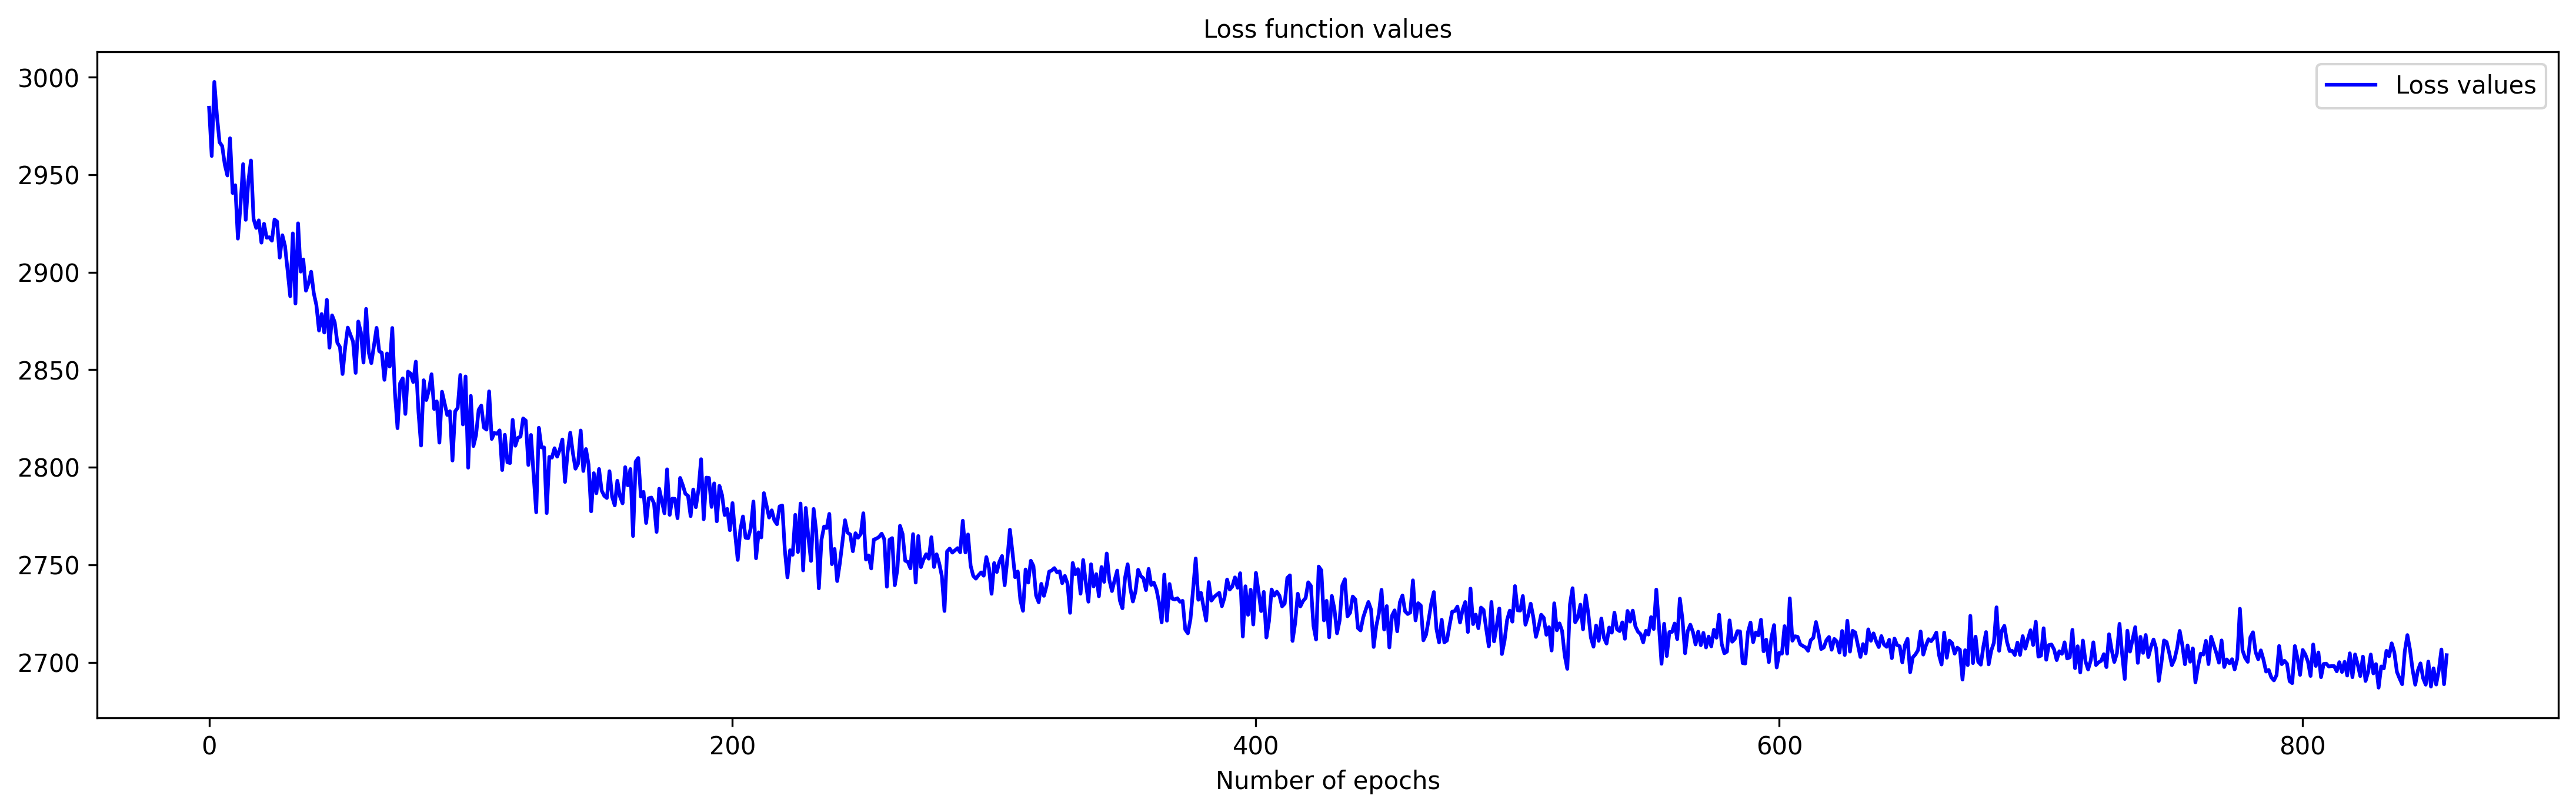

In [258]:
display_loss_values(deepsurv.model)

#### Tuning RSF

In [176]:
rsf = RSF()
rsf.tuning_and_construct(X_train, T_train, E_train,max_iter=max_iter)

Number 3 thread ... mean_c_index: Number 6 thread  ... 0.6519355725618909 is the best so far
mean_c_index: Number 2 thread ... mean_c_index:  0.7195951387192732 is the best so far
 Number 9 thread0.7167724840808445 
Number 1 thread ...  ... mean_c_index:  0.7117622645887074 
mean_c_index:  Number 5 thread ... mean_c_index:  0.7144057552836246 
0.7285308629810764Number 8 threadNumber 4 thread ...  ... mean_c_index:  0.7240690185425342 is the best so far
mean_c_index:  is the best so far
 0.7239371376890769 
Number 7 threadNumber 10 thread ...  ... mean_c_index:  0.7205086426908716 
mean_c_index:  0.7168022251932654 
{'total iteration': 11, 'best_param': {'num_trees': 238, 'max_features': 'log2', 'min_node_size': 31, 'sample_size_pct': 0.8, 'importance_mode': 'permutation'}, 'best_score': 0.7285308629810764}
Number 17 thread ... mean_c_index:  0.7301354531905061 is the best so far
Number 18 thread ... mean_c_index:  0.7332890744518851 is the best so farNumber 12 thread ... 
Number 11 thr

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 25 threadNumber 23 thread ...  ... mean_c_index:  0.7048368533564547mean_c_index:   0.7124831488484994Number 27 threadNumber 26 threadNumber 22 thread
 ...  ...  ... mean_c_index:  0.7247302864039662  

mean_c_index:  mean_c_index: Number 28 thread ...  

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


mean_c_index: 0.7128227441923267 0.6575655501651648  
0.7209114923437892 
Number 24 thread
Number 30 thread ...  ... mean_c_index:  0.6220388300149831 
mean_c_index:  0.7241521903605515 


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 29 thread ... mean_c_index:  0.5 
{'total iteration': 31, 'best_param': {'num_trees': 993, 'max_features': 'sqrt', 'min_node_size': 20, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.738320543275016}
Number 33 threadNumber 34 thread ... mean_c_index:  0.7128226618574566 ...  
mean_c_index:  0.7264175493080586Number 35 thread  ... mean_c_index:  0.7267047373034872 

Number 40 threadNumber 39 thread ... Number 38 threadNumber 36 thread ...  ...  ... mean_c_index: mean_c_index: mean_c_index: mean_c_index:  0.7286435133631708 
   Number 32 thread0.7175637743483321 0.72796296368706590.7354550594039191 Number 31 thread 

 ... mean_c_index:  0.730005307118618 
 ... mean_c_index: 
 0.7394762867741467 is the best so far
Number 37 thread ... mean_c_index:  0.7154657346931794 
{'total iteration': 41, 'best_param': {'num_trees': 756, 'max_features': 'all', 'min_node_size': 13, 'sample_size_pct': 0.8, 'importance_mode': 'normalized_permutation'}, 'best_score': 0.7

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 73 thread ... mean_c_index:  0.6557895711721542 
Number 77 thread ... mean_c_index:  0.6675358059141723 


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 72 threadNumber 80 threadNumber 76 thread ...  ... mean_c_index:  0.7184878082481635 
Number 71 thread ...  ... mean_c_index:  0.7026634130309276 mean_c_index:  0.673106000281288 

Number 79 thread ... mean_c_index:  0.7244898181145324Number 74 thread mean_c_index:  
0.5 ...  
mean_c_index:  0.7251740675025431 Number 78 thread ... 
mean_c_index: Number 75 thread  ... mean_c_index:  0.7232740946819961 
0.7263075010413342 
{'total iteration': 81, 'best_param': {'num_trees': 262, 'max_features': 'sqrt', 'min_node_size': 9, 'sample_size_pct': 0.8, 'importance_mode': 'normalized_permutation'}, 'best_score': 0.740597031458788}
Number 82 threadNumber 84 thread ...  ... mean_c_index: Number 86 threadmean_c_index:  0.7152411424274249 
Number 83 thread ... mean_c_index:  0.7387732325635971 Number 87 thread ...  ... Number 85 threadmean_c_index:  Number 89 thread0.6652463236501968mean_c_index:   ... mean_c_index:  0.7052903728017499 
  ... 0.6064804628150127 
 
0.6985897232189956mean_c_ind

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 101 thread ... mean_c_index:  0.7077175921702101 


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 106 threadNumber 105 threadNumber 107 thread ... mean_c_index:  ...   ... Number 102 thread0.700912063350132 ... mean_c_index: Number 110 threadmean_c_index:    0.5 ... 
Number 104 threadmean_c_index:  0.7270107508708149 
mean_c_index:   Number 108 thread0.72775253573857310.7125910122993742
 ...  mean_c_index:  ...  0.7159465083365717 
 mean_c_index: Number 109 thread 
Number 103 thread ... 0.7270110914618158
 
 ... mean_c_index: mean_c_index:   0.7049874281410347 
0.7287837055302908 
{'total iteration': 111, 'best_param': {'num_trees': 262, 'max_features': 'sqrt', 'min_node_size': 9, 'sample_size_pct': 0.8, 'importance_mode': 'normalized_permutation'}, 'best_score': 0.740597031458788}
Number 113 thread ... Number 112 threadNumber 120 thread ...  ... mean_c_index: Number 111 threadNumber 117 thread ... mean_c_index:  mean_c_index:   ... Number 119 thread0.7096305109175167 mean_c_index: Number 115 thread ...  ... mean_c_index:  0.7196195232660504 
0.7201676547995948  
0.707957058

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 132 thread ... mean_c_index:  0.7292623160778835 
Number 137 thread ... mean_c_index:  0.6359191553851952 
Number 136 threadNumber 139 thread ...  ... Number 138 threadmean_c_index: mean_c_index:  0.72145378086697 
 ... mean_c_index:  0.5 
 0.6263072428195542 Number 134 thread ... mean_c_index: Number 131 thread 

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 135 thread ... 0.7156232955015056mean_c_index:  0.6826870243705871 
 
 ... 
mean_c_index:  0.5 Number 140 thread ... mean_c_index:  0.5 



/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 133 thread ... mean_c_index:  0.7271159620960328 
{'total iteration': 141, 'best_param': {'num_trees': 262, 'max_features': 'sqrt', 'min_node_size': 9, 'sample_size_pct': 0.8, 'importance_mode': 'normalized_permutation'}, 'best_score': 0.740597031458788}
Number 143 thread ... mean_c_index:  0.6113731485114428 
Number 150 thread ... Number 141 threadNumber 146 thread ... mean_c_index:  ...  mean_c_index:  0.7132064760107679 
0.7238401880291789mean_c_index:   0.7188313254151397 

Number 144 threadNumber 149 thread ... mean_c_index:  0.7118946693148727Number 142 thread ... mean_c_index:  0.709047410401431 
 ...  
mean_c_index:  0.7138649947509078 
Number 145 thread ... Number 148 threadmean_c_index: Number 147 thread ...  ... mean_c_index:  0.7386843955834175 
mean_c_index:  0.7305270358141238 
 0.719182570907839 
{'total iteration': 151, 'best_param': {'num_trees': 262, 'max_features': 'sqrt', 'min_node_size': 9, 'sample_size_pct': 0.8, 'importance_mode': 'normalized_permutation'}

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 184 thread ... mean_c_index: Number 183 thread ... mean_c_index:  0.7229396494757199 
 0.699920256031538 Number 181 thread ... 
mean_c_index:  Number 187 thread0.6443556281881244 
 ... mean_c_index: Number 186 thread ... mean_c_index:  0.7172489699972748Number 185 thread 0.722506813729604 


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 182 thread  ... mean_c_index: Number 189 thread
  ... 0.7188520866350562 ...  
mean_c_index: mean_c_index:  0.7122539678737387 
 0.7022294434934382 Number 188 threadNumber 190 thread ... 


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


mean_c_index:  ...  0.720299184474443 
mean_c_index:  0.5 
{'total iteration': 191, 'best_param': {'num_trees': 262, 'max_features': 'sqrt', 'min_node_size': 9, 'sample_size_pct': 0.8, 'importance_mode': 'normalized_permutation'}, 'best_score': 0.740597031458788}
Number 194 thread ... Number 191 thread ... mean_c_index: Number 197 thread ...  Number 192 threadmean_c_index: 0.7165779909629932 
mean_c_index:  0.7118889209327687 
 ... mean_c_index: Number 193 thread ...  mean_c_index:  0.7201887683716909 0.7293423252451474
 Number 198 thread0.7274956978215406 ... mean_c_index:  0.7347911738637537   


Number 199 threadNumber 200 thread ...  ... mean_c_index: Number 195 thread mean_c_index: 0.7272107969179689 
 ...  0.7275176369853537mean_c_index:   0.7194449092871469 
Number 196 thread ... mean_c_index:  0.7333484922988415 

{'total iteration': 201, 'best_param': {'num_trees': 262, 'max_features': 'sqrt', 'min_node_size': 9, 'sample_size_pct': 0.8, 'importance_mode': 'normalized_permutati

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 201 thread ... mean_c_index:  0.5 
Number 208 thread ... mean_c_index:  0.7301446943624614 


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 205 threadNumber 202 threadNumber 203 thread ... mean_c_index:  0.5 
 ... Number 210 thread ...  ... mean_c_index: mean_c_index:  0.7212891764177718  0.7217914649268609 

mean_c_index:  Number 207 thread ... 0.7199807169716083 
mean_c_index:  0.7115102785018759 
Number 204 thread ... mean_c_index:  0.7244138474230146 
Number 209 threadNumber 206 thread ... mean_c_index:  0.7107985275444217 
 ... mean_c_index:  0.7214952386628612 
{'total iteration': 211, 'best_param': {'num_trees': 262, 'max_features': 'sqrt', 'min_node_size': 9, 'sample_size_pct': 0.8, 'importance_mode': 'normalized_permutation'}, 'best_score': 0.740597031458788}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 211 threadNumber 212 thread ... mean_c_index:  ...  mean_c_index:  0.6638736396689211 
0.6272945154392864 
Number 217 threadNumber 220 thread ... mean_c_index:  0.7168230399713893 
 ... Number 218 threadmean_c_index:  ... Number 213 thread Number 215 threadmean_c_index: 0.5 ...  mean_c_index:  0.6925127076687144 
0.7202477030731086 
  ... Number 214 thread ... mean_c_index:  0.7315651054855017 
mean_c_index: 
 0.6544998235822531 


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 216 thread ... mean_c_index:  0.7085251873233591 
Number 219 thread ... mean_c_index:  0.7350159593694405 
{'total iteration': 221, 'best_param': {'num_trees': 262, 'max_features': 'sqrt', 'min_node_size': 9, 'sample_size_pct': 0.8, 'importance_mode': 'normalized_permutation'}, 'best_score': 0.740597031458788}
Number 226 threadNumber 227 thread ... mean_c_index:  Number 221 thread ...  ... mean_c_index: Number 225 thread  ... 0.7406886452393924 is the best so far
mean_c_index: mean_c_index: 0.6885864630045525 0.7008920806132803 
  Number 224 thread0.7055209671708426 ...  mean_c_index: 
Number 222 threadNumber 223 thread ...  ... mean_c_index:  0.7386600139164804 
Number 229 threadmean_c_index:  0.7243981973214108 

 ...  0.7206012948398245mean_c_index:  0.7159592313991849 
 Number 230 thread
 ... Number 228 threadmean_c_index:  ... mean_c_index:  0.7251656491221645 
 0.7235313145414621 
{'total iteration': 231, 'best_param': {'num_trees': 286, 'max_features': 0.1, 'min_node_size

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 234 thread ... mean_c_index:  0.7097151681830092 
Number 231 thread ... mean_c_index:  0.6999865990827432 
Number 232 thread ... mean_c_index:  0.5 
Number 235 thread ... mean_c_index:  0.720099583872397 
Number 238 thread ... Number 236 threadmean_c_index: Number 240 thread ...  0.722177103911917 
 ... mean_c_index:  Number 239 threadNumber 237 threadmean_c_index: 0.7134924983714852 0.733573867934476 
 ... Number 233 threadmean_c_index:   ... 
mean_c_index:   ... mean_c_index:  0.7189745933013157 
0.6228548348775136  0.7129874303834213 

{'total iteration': 241, 'best_param': {'num_trees': 286, 'max_features': 0.1, 'min_node_size': 23, 'sample_size_pct': 0.6, 'importance_mode': 'normalized_permutation'}, 'best_score': 0.7406886452393924}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 244 thread ... Number 249 thread ... Number 241 threadmean_c_index:  ... mean_c_index: mean_c_index:    0.6934205345787322 0.7180198022680504
 0.64280396178815 

Number 242 threadNumber 243 thread ... mean_c_index:  0.7277992969227803  ... 
Number 247 thread ... mean_c_index: Number 246 threadmean_c_index:  ... Number 245 threadmean_c_index:   0.70998563814252380.724173513914356 ...    

mean_c_index: Number 248 thread 0.5 ... mean_c_index:  0.6376960965628674 
 
0.7280399494243811 
Number 250 thread ... mean_c_index:  0.7174521117179056 
{'total iteration': 251, 'best_param': {'num_trees': 286, 'max_features': 0.1, 'min_node_size': 23, 'sample_size_pct': 0.6, 'importance_mode': 'normalized_permutation'}, 'best_score': 0.7406886452393924}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 251 threadNumber 255 thread ...  ... mean_c_index:  0.7145647177981383 
mean_c_index:  0.7070690466611081 
Number 254 threadNumber 258 thread ...  ... mean_c_index:  0.7175180706779781 
mean_c_index:  0.730894326505515Number 259 thread  ... mean_c_index:  0.622124064663449 

Number 256 thread ... mean_c_index:  0.6428724364709966 
Number 257 thread ... mean_c_index:  0.7263438851441182 
Number 253 threadNumber 260 thread ...  ... mean_c_index:  0.7142866149760054 mean_c_index:  0.6981113537088776 

Number 252 thread ... mean_c_index:  0.7293826907547961 
{'total iteration': 261, 'best_param': {'num_trees': 286, 'max_features': 0.1, 'min_node_size': 23, 'sample_size_pct': 0.6, 'importance_mode': 'normalized_permutation'}, 'best_score': 0.7406886452393924}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 262 thread ... mean_c_index: Number 261 thread ...  mean_c_index:  0.7054873987799958

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


 0.7195751189035797 

Number 267 threadNumber 264 threadNumber 269 thread ...  ... mean_c_index:  0.7109867479345325Number 268 thread ... mean_c_index:   0.5 
mean_c_index: 
 ... 

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


 0.7366690690285572 mean_c_index:  Number 270 threadNumber 266 thread0.7107645853963274 ...  
 ... Number 263 threadNumber 265 thread ... mean_c_index: 
 ... mean_c_index: mean_c_index:  0.7102250473702022 
mean_c_index:    0.7057994376863507 
0.720488147020115 
0.7275580476985685 
{'total iteration': 271, 'best_param': {'num_trees': 286, 'max_features': 0.1, 'min_node_size': 23, 'sample_size_pct': 0.6, 'importance_mode': 'normalized_permutation'}, 'best_score': 0.7406886452393924}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 272 thread ... mean_c_index:  0.6680864486590739 
Number 271 thread ... mean_c_index: 

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


 0.6665685160540133 
Number 273 thread ... mean_c_index:  0.5 Number 279 thread ... 
mean_c_index:  0.7018491188899529 
Number 278 thread ... Number 276 threadNumber 274 thread ... mean_c_index:  ... mean_c_index:   0.7083692971540099 
Number 277 thread0.6193145658169319 ... mean_c_index:   0.7209544526431261 

mean_c_index: Number 275 thread 0.6650854514126896 
 ... mean_c_index:  Number 280 thread0.7180157175855338 ... mean_c_index:  0.730971020643703 
 
{'total iteration': 281, 'best_param': {'num_trees': 286, 'max_features': 0.1, 'min_node_size': 23, 'sample_size_pct': 0.6, 'importance_mode': 'normalized_permutation'}, 'best_score': 0.7406886452393924}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 283 thread ... mean_c_index:  0.7043897139340437 
Number 285 thread ... mean_c_index: 

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 288 thread Number 282 thread ... mean_c_index:  0.7390747296775493 
 ... mean_c_index:  0.7065395905216232 0.7062212275569297 

Number 290 thread ... mean_c_index:  0.5 
Number 286 thread ... mean_c_index:  0.678717640394696 
Number 284 thread ... mean_c_index:  0.6484198309395194 Number 287 thread ... 
mean_c_index:  Number 281 thread0.5  ... 
mean_c_index:  0.7233836711357149 
Number 289 thread ... mean_c_index:  0.7138801774742317 
{'total iteration': 291, 'best_param': {'num_trees': 286, 'max_features': 0.1, 'min_node_size': 23, 'sample_size_pct': 0.6, 'importance_mode': 'normalized_permutation'}, 'best_score': 0.7406886452393924}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 294 thread ... mean_c_index:  0.7137074118323075 
Number 292 thread ... mean_c_index:  0.7017546998837465 
Number 297 thread ... 

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


mean_c_index:  0.7135093786338735 
Number 295 thread ... Number 296 thread ... mean_c_index:  0.5 
Number 293 thread ... mean_c_index:  0.7303186978859271 
Number 300 threadmean_c_index:   ... mean_c_index: 0.7165213198620105  0.7269243138494657 Number 298 thread
 ... 
Number 291 threadmean_c_index:  ...  mean_c_index: 0.7175343123283531  
Number 299 thread0.7196792375542992 ... mean_c_index:  0.7253891240677662 
 
{'total iteration': 301, 'best_param': {'num_trees': 286, 'max_features': 0.1, 'min_node_size': 23, 'sample_size_pct': 0.6, 'importance_mode': 'normalized_permutation'}, 'best_score': 0.7406886452393924}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 302 threadNumber 308 thread ...  ... mean_c_index:  0.6681275450137701 
Number 301 threadNumber 309 thread ... mean_c_index:  0.6921691810307357  ... 
mean_c_index: mean_c_index:  0.7185216618166311  Number 303 thread0.6291238135785486 Number 305 thread ...  ... mean_c_index:  0.7146908769471529 
mean_c_index:  0.7101311654017813 


Number 306 thread ... mean_c_index:  0.7172189322336706 Number 304 thread ... mean_c_index:  0.7188251769513168 
Number 307 thread
 ... mean_c_index:  0.7122800530694319 
Number 310 thread ... mean_c_index:  0.7099139151612576 
{'total iteration': 311, 'best_param': {'num_trees': 286, 'max_features': 0.1, 'min_node_size': 23, 'sample_size_pct': 0.6, 'importance_mode': 'normalized_permutation'}, 'best_score': 0.7406886452393924}
Number 315 threadNumber 316 thread ...  ... mean_c_index:  0.6181940297499449 
Number 320 threadmean_c_index:  ...  mean_c_index:  0.6976019078210458 
0.6258399843743074Number 313 thread  ... 
Number 312 threadmean_c_index: Nu

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 393 thread ... mean_c_index:  0.7284520810886237 
Number 392 thread ... mean_c_index:  0.7227945512095816 
Number 391 threadNumber 394 thread ... 

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 398 threadNumber 400 thread ... mean_c_index:  0.7152593458000883 ...  ... mean_c_index:  mean_c_index:  mean_c_index: Number 396 thread  ... mean_c_index:  0.7282413398850627 
 
0.7076038893709958 
0.65136724610680190.7158672742982921 
Number 399 thread  ... mean_c_index:  0.5 
Number 395 threadNumber 397 thread ... mean_c_index:  0.7302724150549469 
 ... 
mean_c_index:  0.7153972550467569 
{'total iteration': 401, 'best_param': {'num_trees': 286, 'max_features': 0.1, 'min_node_size': 23, 'sample_size_pct': 0.6, 'importance_mode': 'normalized_permutation'}, 'best_score': 0.7406886452393924}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 402 thread ... mean_c_index:  0.6977558344614077 

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 408 thread ... 
mean_c_index:  Number 404 thread ... mean_c_index:  0.6911402873209116 
0.7105214661562377Number 405 thread  ... mean_c_index:  
0.5Number 403 thread ... mean_c_index:  0.7189062695981668 
Number 407 thread 
Number 409 threadNumber 401 thread ...  ...  ... mean_c_index:  0.5 
mean_c_index:  0.7275427255932491 mean_c_index:  0.633008450263385 

Number 410 thread ... mean_c_index:  0.7059816486007068 
Number 406 thread ... mean_c_index:  0.7211232508323391 
{'total iteration': 411, 'best_param': {'num_trees': 286, 'max_features': 0.1, 'min_node_size': 23, 'sample_size_pct': 0.6, 'importance_mode': 'normalized_permutation'}, 'best_score': 0.7406886452393924}
Number 411 threadNumber 413 thread ...  ... mean_c_index:  0.7230816474291408 
mean_c_index:  Number 414 thread0.7136034466971815  ... mean_c_index: 
 0.6319153453910794Number 418 thread ...  mean_c_index: Number 417 thread 
0.6877164693129558 
 ... mean_c_index:  0.7378204294695111 
Number 419 threadNumber 415 

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 447 thread ... mean_c_index:  0.7108939272486349 
Number 442 thread ... mean_c_index:  0.5 
Number 441 threadNumber 446 thread ... mean_c_index:  ...  Number 448 threadmean_c_index:  0.7252147336977289 ... 0.7167833701423351mean_c_index:  Number 443 thread 
 Number 445 thread ...  ... mean_c_index:  0.713696686573222 
mean_c_index:  0.7190878534945074 
0.7076423971069452
 Number 450 thread ... 
mean_c_index:  Number 449 thread0.6413132220840737 ... mean_c_index:  0.7273653740257285 
 
Number 444 thread ... mean_c_index:  0.7354092241834651 
{'total iteration': 451, 'best_param': {'num_trees': 286, 'max_features': 0.1, 'min_node_size': 23, 'sample_size_pct': 0.6, 'importance_mode': 'normalized_permutation'}, 'best_score': 0.7406886452393924}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 455 thread ... mean_c_index:  

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


0.7366674266440623 
Number 452 thread ... mean_c_index:  0.7130913015603058 
Number 453 thread ... mean_c_index: Number 457 thread Number 456 thread ... mean_c_index:  0.677099022771755 
 ... Number 454 threadmean_c_index: 0.7246878983028647 ...  mean_c_index:  0.7104368169904887  0.717007335623783
Number 451 thread ... 

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 459 threadmean_c_index:  
 ... mean_c_index:  
 0.7106796883287282 
0.5 
Number 458 thread ... mean_c_index:  0.7257031799021869 
Number 460 thread ... mean_c_index:  0.6967482343256954 
{'total iteration': 461, 'best_param': {'num_trees': 286, 'max_features': 0.1, 'min_node_size': 23, 'sample_size_pct': 0.6, 'importance_mode': 'normalized_permutation'}, 'best_score': 0.7406886452393924}
Number 465 thread ... mean_c_index:  0.6227910895148512 
Number 469 thread ... mean_c_index:  0.6894162062699346 
Number 463 threadNumber 468 thread ... mean_c_index:  0.6883647469796454 Number 464 thread
 ...  ... mean_c_index: Number 467 thread  ... mean_c_index: 0.7324787859259192 0.7056337278233562 mean_c_index:  0.6385903664687629  
Number 461 thread

Number 466 thread ...  ... mean_c_index:  0.7306138113221741 
mean_c_index:  0.7194918900289552 
Number 470 threadNumber 462 thread ... mean_c_index:  0.7266737887969633 
 ... mean_c_index:  0.7133294946321629 
{'total iteration': 471, 'best_p

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 471 thread ... mean_c_index:  0.6611536245798982 


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 473 threadNumber 474 thread ...  ... mean_c_index: mean_c_index:   0.71712023345452770.7113255966873976 
 
Number 478 threadNumber 480 thread ...  ... mean_c_index:  0.6172442424437771 
mean_c_index:  0.7300973692658949 


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 477 threadNumber 472 threadNumber 476 thread ... mean_c_index:  0.7058120958454863  ... mean_c_index:  0.6161822438971468 
 ... mean_c_index: 
Number 475 thread  ... mean_c_index:  0.7252269561164354 
0.5 
Number 479 thread ... mean_c_index:  0.7329763624732266 
{'total iteration': 481, 'best_param': {'num_trees': 286, 'max_features': 0.1, 'min_node_size': 23, 'sample_size_pct': 0.6, 'importance_mode': 'normalized_permutation'}, 'best_score': 0.7406886452393924}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 486 thread ... mean_c_index:  0.710502793094441Number 481 thread  ... mean_c_index:  0.7066938949381789 
Number 484 thread ... 
mean_c_index:  0.5 
Number 488 thread ... mean_c_index:  0.65586920669378 Number 482 thread
 ... mean_c_index:  0.7112520752209954 Number 483 thread ... mean_c_index: 
 Number 487 thread0.714322025863627  ... 
mean_c_index:  0.6517244547022771 
Number 489 thread

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 490 thread ... mean_c_index:  ...  0.7267377926309451 
Number 485 threadmean_c_index:  0.6825586584714359 
 ... mean_c_index:  0.7245265039615593 
{'total iteration': 491, 'best_param': {'num_trees': 286, 'max_features': 0.1, 'min_node_size': 23, 'sample_size_pct': 0.6, 'importance_mode': 'normalized_permutation'}, 'best_score': 0.7406886452393924}
Number 492 thread ... mean_c_index:  0.721124776245285 
Number 496 thread ... mean_c_index:  0.7116565626316855 
Number 498 threadNumber 497 threadNumber 493 threadNumber 491 thread ...  ...  ... mean_c_index:  ...  mean_c_index: mean_c_index:  0.7247547816795574 
 mean_c_index: 0.7044428874179289Number 499 thread0.7294034805596794  Number 494 thread  ... mean_c_index:  0.7171396611212696 
 ... 
mean_c_index:  0.7156296218305971 
0.6802599012020945Number 495 thread  ... 
mean_c_index:  0.619892351743464 

Number 500 thread ... mean_c_index:  0.7299874281285608 
{'total iteration': 501, 'best_param': {'num_trees': 286, 'max_features': 

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 522 thread ... mean_c_index:  0.7144127662412403 

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp



Number 526 threadNumber 521 thread

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 524 thread ...  ...  ... mean_c_index:  0.5 
mean_c_index: Number 528 thread 0.5 
 ... mean_c_index: Number 525 thread  ... mean_c_index: mean_c_index:  0.7133684784347774 
0.7228287408173104  0.7169337162671668 
Number 529 threadNumber 527 thread ...  ... mean_c_index:  0.7064158831798852 

Number 523 threadmean_c_index:  ...  mean_c_index:  0.7176366873828744 
0.7103631964239864 
Number 530 thread ... mean_c_index:  0.725658793975631 
{'total iteration': 531, 'best_param': {'num_trees': 286, 'max_features': 0.1, 'min_node_size': 23, 'sample_size_pct': 0.6, 'importance_mode': 'normalized_permutation'}, 'best_score': 0.7406886452393924}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 531 threadNumber 532 thread ... mean_c_index:  0.7023308340317234  ... 

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp



mean_c_index:  0.7153763690366428 
Number 538 thread ... mean_c_index: Number 533 thread ... mean_c_index:   

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


0.7147947168660022 
0.6442269199734846 
Number 534 thread ... mean_c_index: Number 536 thread ... mean_c_index:   0.7312781117272903Number 540 thread0.5 
  ... 
Number 535 threadmean_c_index:  ... mean_c_index:  0.7055303240471769 0.7143220289092629  Number 537 threadNumber 539 thread ... mean_c_index:  0.7355016000162649 
 ... mean_c_index:  0.716218767842442 


{'total iteration': 541, 'best_param': {'num_trees': 286, 'max_features': 0.1, 'min_node_size': 23, 'sample_size_pct': 0.6, 'importance_mode': 'normalized_permutation'}, 'best_score': 0.7406886452393924}
Number 543 thread ... mean_c_index:  0.734530356049739 Number 541 thread ... mean_c_index: Number 547 thread ...  0.6598506333365006 

mean_c_index:  0.708220065148166 
Number 546 thread ... mean_c_index:  Number 544 thread ... Number 545 thread ... 0.7090323566531936Number 542 thread mean_c_index: mean_c_index:  ... mean_c_index:  0.7278266709057138 
  0.7232547510121046 
0.7194632840350186 

Number 550 thread ... Number 549 

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 604 thread ... mean_c_index:  0.6440833542299451 
Number 602 thread ... mean_c_index:  Number 607 thread0.5 


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 605 thread ... mean_c_index:  0.7334922543456399 
 ... Number 609 thread ... mean_c_index:  0.6266166226940522 
mean_c_index:  0.7081276718741776 
Number 610 thread

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


 ... mean_c_index:  0.618192413731588 
Number 601 thread ... mean_c_index:  0.7118186002544652 
Number 603 threadNumber 606 threadNumber 608 thread ...  ...  ... mean_c_index:  0.7074888071706619 
mean_c_index:  0.5 
mean_c_index:  0.7156418905462949 
{'total iteration': 611, 'best_param': {'num_trees': 286, 'max_features': 0.1, 'min_node_size': 23, 'sample_size_pct': 0.6, 'importance_mode': 'normalized_permutation'}, 'best_score': 0.7406886452393924}
Number 614 thread ... mean_c_index:  0.7076671648241679 
Number 617 thread ... mean_c_index:  0.7181284440962472 Number 620 threadNumber 619 thread ...  ... mean_c_index: mean_c_index:  Number 611 thread
 ... Number 613 thread Number 618 threadmean_c_index: 0.6689780018712499 ...  mean_c_index:  0.7215577603290174 
  ... 0.7241432080809710.6998527828833215mean_c_index:  0.6821068678691511 

Number 615 thread   ... mean_c_index: 
 0.712387162368027 
Number 616 thread
 ... Number 612 thread ... mean_c_index:  0.7236944744452863 
mean_c_inde

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 652 thread ... mean_c_index:  0.6403148711190243 
Number 653 threadNumber 654 thread ...  ... mean_c_index:  0.7005408840070303 
Number 656 thread ... mean_c_index:  0.726438119772785 
mean_c_index:  0.7348451095261893 
Number 655 thread ... mean_c_index:  0.7355165995887799 


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 657 thread ... mean_c_index:  0.7160358224739246 
Number 660 threadNumber 651 thread ...  ... mean_c_index: mean_c_index:   0.5 
0.7154165795484335 Number 658 thread ... mean_c_index: 
Number 659 thread  ... mean_c_index:  0.7134660992827186 
0.7267717631084352 
{'total iteration': 661, 'best_param': {'num_trees': 286, 'max_features': 0.1, 'min_node_size': 23, 'sample_size_pct': 0.6, 'importance_mode': 'normalized_permutation'}, 'best_score': 0.7406886452393924}
Number 664 thread ... Number 670 thread ... Number 661 threadmean_c_index: Number 663 thread ...  0.7190564029399196mean_c_index:   mean_c_index: 0.6553864335999451 
 Number 662 thread0.7261007198946658 ...  ... mean_c_index:  mean_c_index:  

0.7195892851793391 0.718093555527419 
Number 665 thread ... mean_c_index:  0.7107813189610835 
 Number 669 thread
 ... mean_c_index:  0.6902863701352802 
Number 668 thread ... mean_c_index:  0.7162375064146248 
Number 666 threadNumber 667 thread ... mean_c_index:  0.723690722511020

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 724 thread ... mean_c_index:  0.7183006390774034 
Number 725 threadNumber 730 thread ...  ... mean_c_index:  0.7129196348694122 
mean_c_index:  0.7344258654612927 
Number 727 threadNumber 723 thread ...  ... mean_c_index: Number 721 threadmean_c_index:  ... 

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


mean_c_index:  0.5 
  0.68048987662236040.7134324359740865  

Number 729 threadNumber 722 thread ... Number 728 threadmean_c_index:  ...   ... 0.7112685122661271 
mean_c_index: mean_c_index:   0.7176460465078707 
0.6248469158055002 
Number 726 thread ... mean_c_index:  0.7279555902088397 
{'total iteration': 731, 'best_param': {'num_trees': 286, 'max_features': 0.1, 'min_node_size': 23, 'sample_size_pct': 0.6, 'importance_mode': 'normalized_permutation'}, 'best_score': 0.7406886452393924}
Number 732 thread ... mean_c_index:  0.6914995160574966 
Number 736 thread ... mean_c_index:  0.7102877187418997 
Number 731 threadNumber 737 thread ... mean_c_index:  0.6866744666612099 
 ... mean_c_index:  0.7104323509678344 
Number 733 thread ... mean_c_index:  0.7340442381753753 Number 735 thread
Number 738 threadNumber 740 threadNumber 739 thread ...  ...  ... mean_c_index:  0.7080369318808091 
 ... Number 734 threadmean_c_index: mean_c_index:  ...  mean_c_index: mean_c_index:  0.7116532506077105

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 790 thread ... mean_c_index:  0.7071835724441018 
Number 781 threadNumber 782 thread ...  ... mean_c_index: mean_c_index:  0.7122481337741193 0.710337541905466 
 


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 786 threadNumber 788 thread ... mean_c_index:  0.7287461932883552  ... Number 787 threadmean_c_index:  ...  mean_c_index: 0.7165634713817555  Number 784 thread ... mean_c_index:  0.7053949955100981 
0.7223579551153326
Number 789 thread 

 ... mean_c_index: Number 783 thread ... mean_c_index:  0.5 
 0.7112958108495664 


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 785 thread ... mean_c_index:  0.7209778984484836 
{'total iteration': 791, 'best_param': {'num_trees': 286, 'max_features': 0.1, 'min_node_size': 23, 'sample_size_pct': 0.6, 'importance_mode': 'normalized_permutation'}, 'best_score': 0.7406886452393924}
Number 796 thread ... mean_c_index: Number 794 thread ... mean_c_index:  0.7142769734199435  0.7097695983154366 

Number 797 thread ... mean_c_index:  0.6296263269303108 Number 791 thread
 ... mean_c_index:  0.7237220169417323Number 799 thread ... mean_c_index:  0.7062270087834956 
 
Number 793 threadNumber 792 thread ...  ... mean_c_index:  0.7174956263379547 
mean_c_index: Number 798 threadNumber 795 thread ...  ... mean_c_index:  0.7093349224486112 
 mean_c_index:  0.7211155774611706 
0.7177791074084192 
Number 800 thread ... mean_c_index:  0.7333747045249106 
{'total iteration': 801, 'best_param': {'num_trees': 286, 'max_features': 0.1, 'min_node_size': 23, 'sample_size_pct': 0.6, 'importance_mode': 'normalized_permutation'},

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 848 thread ... mean_c_index:  0.7079991806455306 
Number 845 thread ... mean_c_index:  0.6464932385836226 
Number 843 thread ... mean_c_index: 

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 844 thread 0.7156030494238174 
 ... mean_c_index:  0.6496694376355411 
Number 850 thread ... mean_c_index:  0.7273945672499454 
Number 847 threadNumber 842 threadNumber 849 thread ...  ... mean_c_index:  ... mean_c_index: mean_c_index:  0.717835544350599 
  0.5 
0.7177053032080908 


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 841 threadNumber 846 thread ... mean_c_index:  0.7389657122653135 
 ... mean_c_index:  0.7191384915609667 
{'total iteration': 851, 'best_param': {'num_trees': 286, 'max_features': 0.1, 'min_node_size': 23, 'sample_size_pct': 0.6, 'importance_mode': 'normalized_permutation'}, 'best_score': 0.7406886452393924}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 852 thread ... Number 854 threadmean_c_index:  ... mean_c_index:  0.7095848474172441 
 0.6189372482354024 
Number 857 thread ... mean_c_index: Number 853 thread ... mean_c_index:   Number 851 thread0.60932344216886690.7172756856578445 
 
 ... Number 855 thread ... mean_c_index:  0.7305515481719068 
Number 856 thread ... mean_c_index: Number 860 thread  ... mean_c_index: mean_c_index: 0.7132156130574043 0.659530847402229 
  0.5
Number 859 thread  ... mean_c_index:  0.7382660287716194 

Number 858 thread ... mean_c_index:  0.7230306807221506 
{'total iteration': 861, 'best_param': {'num_trees': 286, 'max_features': 0.1, 'min_node_size': 23, 'sample_size_pct': 0.6, 'importance_mode': 'normalized_permutation'}, 'best_score': 0.7406886452393924}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 864 thread ... mean_c_index:  0.7194358873874206 
Number 861 thread ... 

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


mean_c_index: Number 865 thread ... Number 862 thread ... mean_c_index:  mean_c_index: Number 870 thread0.7143765043550179 ...    0.7337105439548466 
0.7273749889542721 Number 868 thread
 ... mean_c_index:  
0.7100666710239302mean_c_index:  Number 867 thread0.7102688729500197Number 863 thread ...  ...  Number 866 threadmean_c_index:  ... mean_c_index:  0.7124725065081882  
 mean_c_index: 
 0.71033653337014380.5
  

Number 869 thread ... mean_c_index:  0.7351471859125004 
{'total iteration': 871, 'best_param': {'num_trees': 286, 'max_features': 0.1, 'min_node_size': 23, 'sample_size_pct': 0.6, 'importance_mode': 'normalized_permutation'}, 'best_score': 0.7406886452393924}
Number 871 threadNumber 879 thread ... mean_c_index:  Number 874 threadNumber 873 thread ... mean_c_index: 0.7342227346227047 
 ... Number 878 thread ...  mean_c_index:  0.7173652957250343 
 ... mean_c_index:  0.7240539464411035 
mean_c_index: 0.7129491414481626 0.6131599521017341 
 Number 880 thread ... mean_c_index: 

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 901 thread ... mean_c_index:  0.6628160857736238 Number 904 thread


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


 ... Number 902 threadNumber 903 thread ... mean_c_index: mean_c_index:  ...  0.7075837170346071 
mean_c_index: Number 907 thread  ... mean_c_index:  0.7187579117327445 
0.5  
0.7387799432238135 
Number 906 thread ... mean_c_index:  0.7084667347741778 
Number 909 thread ... mean_c_index:  0.714987606958139 
Number 908 thread ... Number 905 thread ... mean_c_index:  0.7022926024658968 
mean_c_index:  0.7165053480140695Number 910 thread  ... mean_c_index:  0.6778521835443592 

{'total iteration': 911, 'best_param': {'num_trees': 286, 'max_features': 0.1, 'min_node_size': 23, 'sample_size_pct': 0.6, 'importance_mode': 'normalized_permutation'}, 'best_score': 0.7406886452393924}
Number 911 thread ... Number 918 thread ... mean_c_index: mean_c_index:  0.6610994312224114  Number 912 thread ... mean_c_index:  0.7145577912263318 0.7264807431011528 


Number 920 thread ... mean_c_index:  0.7016858064118018Number 915 thread  ... 
mean_c_index:  Number 913 thread0.7326749368168992 ...  mean_c_ind

RandomSurvivalForestModel

In [27]:
c_index_train = concordance_index(rsf.model, X_train, T_train, E_train)
c_index_test = concordance_index(rsf.model, X_test, T_test, E_test)
print('C-index of train: {:.4f}; C-index of test: {:.4f}'.format(c_index_train,c_index_test)) #C-index: 0.6996


C-index of train: 0.7590; C-index of test: 0.7403


In [180]:
rsf.tuning_result['best_param']

{'num_trees': 286,
 'max_features': 0.1,
 'min_node_size': 23,
 'sample_size_pct': 0.6,
 'importance_mode': 'normalized_permutation'}

## Metrics

In [28]:
save_path = './output/'
import os
if not os.path.exists(save_path):
    os.mkdir(save_path)

### Generate data for prediction error curve

In [335]:
from pysurvival.utils.metrics import brier_score
t_max = max(T_test)

times_cph, brier_scores_cph = brier_score(cph.model, X_test, T_test, E_test, t_max=t_max, use_mean_point=True)
ibs_cph =  np.trapz(brier_scores_cph, times_cph)/t_max 

times_tnm, brier_scores_tnm = brier_score(tnm.model,  data_test[['Stage']], T_test, E_test, t_max=t_max, use_mean_point=True)
ibs_tnm =  np.trapz(brier_scores_tnm, times_tnm)/t_max

times_nmtlr, brier_scores_nmtlr = brier_score(nmtlr.model,  X_test, T_test, E_test, t_max=t_max, use_mean_point=True)
ibs_nmtlr =  np.trapz(brier_scores_nmtlr, times_nmtlr)/t_max

times_deepsurv, brier_scores_deepsurv = brier_score(deepsurv.model,  X_test, T_test, E_test, t_max=t_max, use_mean_point=True)
ibs_deepsurv =  np.trapz(brier_scores_deepsurv, times_deepsurv)/t_max

times_rsf, brier_scores_rsf = brier_score(rsf.model,  X_test, T_test, E_test, t_max=t_max, use_mean_point=True)
ibs_rsf =  np.trapz(brier_scores_rsf, times_rsf)/t_max


pd.DataFrame(
    {'times':times_cph+times_tnm+times_nmtlr+times_deepsurv+times_rsf,
    'brier_scores':brier_scores_cph+brier_scores_tnm+brier_scores_nmtlr+brier_scores_deepsurv+brier_scores_rsf,
    'models':[
        'CoxPH (IBS: {:.4f})'.format(ibs_cph) for i in brier_scores_cph] + 
     ['TNM (IBS: {:.4f})'.format(ibs_tnm) for i in brier_scores_tnm] + 
     ['NMTLR (IBS: {:.4f})'.format(ibs_nmtlr) for i in brier_scores_nmtlr]+
     ['DeepSurv (IBS: {:.4f})'.format(ibs_deepsurv) for i in brier_scores_deepsurv]+
     ['RSF (IBS: {:.4f})'.format(ibs_rsf) for i in brier_scores_rsf
      ]
            }).to_csv(os.path.join(save_path,'brier_score.csv'))

### Generate data for calibration curves and roc curves

In [336]:
def generate_prediction_by_year(data_,time_=12,file_name='1 year prediction.csv'):
#     index = -((T_test<=time_) & (E_test == 0))
    X_ = data_[features]
    survival_cph = cph.model.predict_survival(X_,t=time_)
    survival_nmtlr = nmtlr.model.predict_survival(X_,t=time_)
    survival_deepsurv = deepsurv.model.predict_survival(X_,t=time_)
    survival_rsf = rsf.model.predict_survival(X_,t=time_)
    survival_tnm = tnm.model.predict_survival(data_[['Stage']],t=time_)
    risk_cph = cph.model.predict_risk(X_)
    risk_nmtlr = nmtlr.model.predict_risk(X_)
    risk_deepsurv = deepsurv.model.predict_risk(X_)
    risk_rsf = rsf.model.predict_risk(X_)
    risk_tnm = tnm.model.predict_risk(data_[['Stage']])
    df_cph = pd.concat([data_,pd.DataFrame({
        'models':['CoxPH' for i in range(X_.shape[0])],
        'score':survival_cph.tolist(),
        'risk':risk_cph.tolist()
    })],axis=1)
    df_nmtlr = pd.concat([data_,pd.DataFrame({
        'models':['NMTLR' for i in range(X_.shape[0])],
        'score':survival_nmtlr.tolist(),
        'risk':risk_nmtlr.tolist()
    })],axis=1)
    df_deepsurv = pd.concat([data_,pd.DataFrame({
        'models':['DeepSurv' for i in range(X_.shape[0])],
        'score':survival_deepsurv.tolist(),
        'risk':risk_deepsurv.tolist()
    })],axis=1)
    df_rsf = pd.concat([data_,pd.DataFrame({
        'models':['RSF' for i in range(X_.shape[0])],
        'score':survival_rsf.tolist(),
        'risk':risk_rsf.tolist()
    })],axis=1)
    df_tnm = pd.concat([data_,pd.DataFrame({
        'models':['TNM' for i in range(X_.shape[0])],
        'score':survival_tnm.tolist(),
        'risk':risk_tnm.tolist()
    })],axis=1)
    pd.concat(
        [df_cph,df_nmtlr,df_deepsurv,df_rsf,df_tnm]
    ).reset_index(drop=True).to_csv(os.path.join(save_path,file_name))
    

generate_prediction_by_year(data_test,time_=12,file_name='1 year prediction.csv')
generate_prediction_by_year(data_test,time_=36,file_name='3 year prediction.csv')
generate_prediction_by_year(data_test,time_=60,file_name='5 year prediction.csv')
generate_prediction_by_year(data_test,time_=120,file_name='10 year prediction.csv')

### Generate data for Loss converge graph

In [337]:
pd.DataFrame(
{'loss_values':deepsurv.model.loss_values}
).to_csv(os.path.join(save_path,'deesurv_loss_values.csv'))

In [338]:
pd.DataFrame(
{'loss_values':nmtlr.model.loss_values}
).to_csv(os.path.join(save_path,'nmtlr_loss_values.csv'))

###  Feature importance plot

In [204]:
def variableImportance(model, X, T, E):
    ctmp = concordance_index(model, X, T, E)
    imps = []
    for column in X:
        tmpX = X.copy()
        tmpX[column] = np.random.permutation(tmpX[column])
        ctmp2 = concordance_index(model, tmpX, T, E)
        imps.append((ctmp - ctmp2)/ctmp)
    return imps

In [205]:
imp_df = pd.DataFrame(
    {
        'DeepSurv': variableImportance(deepsurv.model, X_test, T_test, E_test),
        'NMTLR': variableImportance(nmtlr.model, X_test, T_test, E_test),
        'RSF': variableImportance(rsf.model, X_test, T_test, E_test),
    },
    index= X_test.columns
)
imp_df['Average'] = imp_df.mean(axis=1)
print(imp_df)

                    DeepSurv     NMTLR       RSF   Average
Age                 0.085371  0.084308  0.026465  0.065381
Distant metastasis  0.089432  0.079086  0.043018  0.070512
Gender             -0.002949  0.000806  0.001684 -0.000153
Grade               0.033839  0.098422  0.058273  0.063511
Marital status     -0.000374  0.004142  0.003568  0.002445
Number of tumors    0.007458  0.000636  0.011146  0.006413
Surgery             0.028074  0.040867  0.012814  0.027251
Systemic therapy    0.014440  0.010421  0.021404  0.015422
Tumor extension     0.035910  0.019734  0.021312  0.025652
Tumor size          0.042765  0.032199  0.037173  0.037379


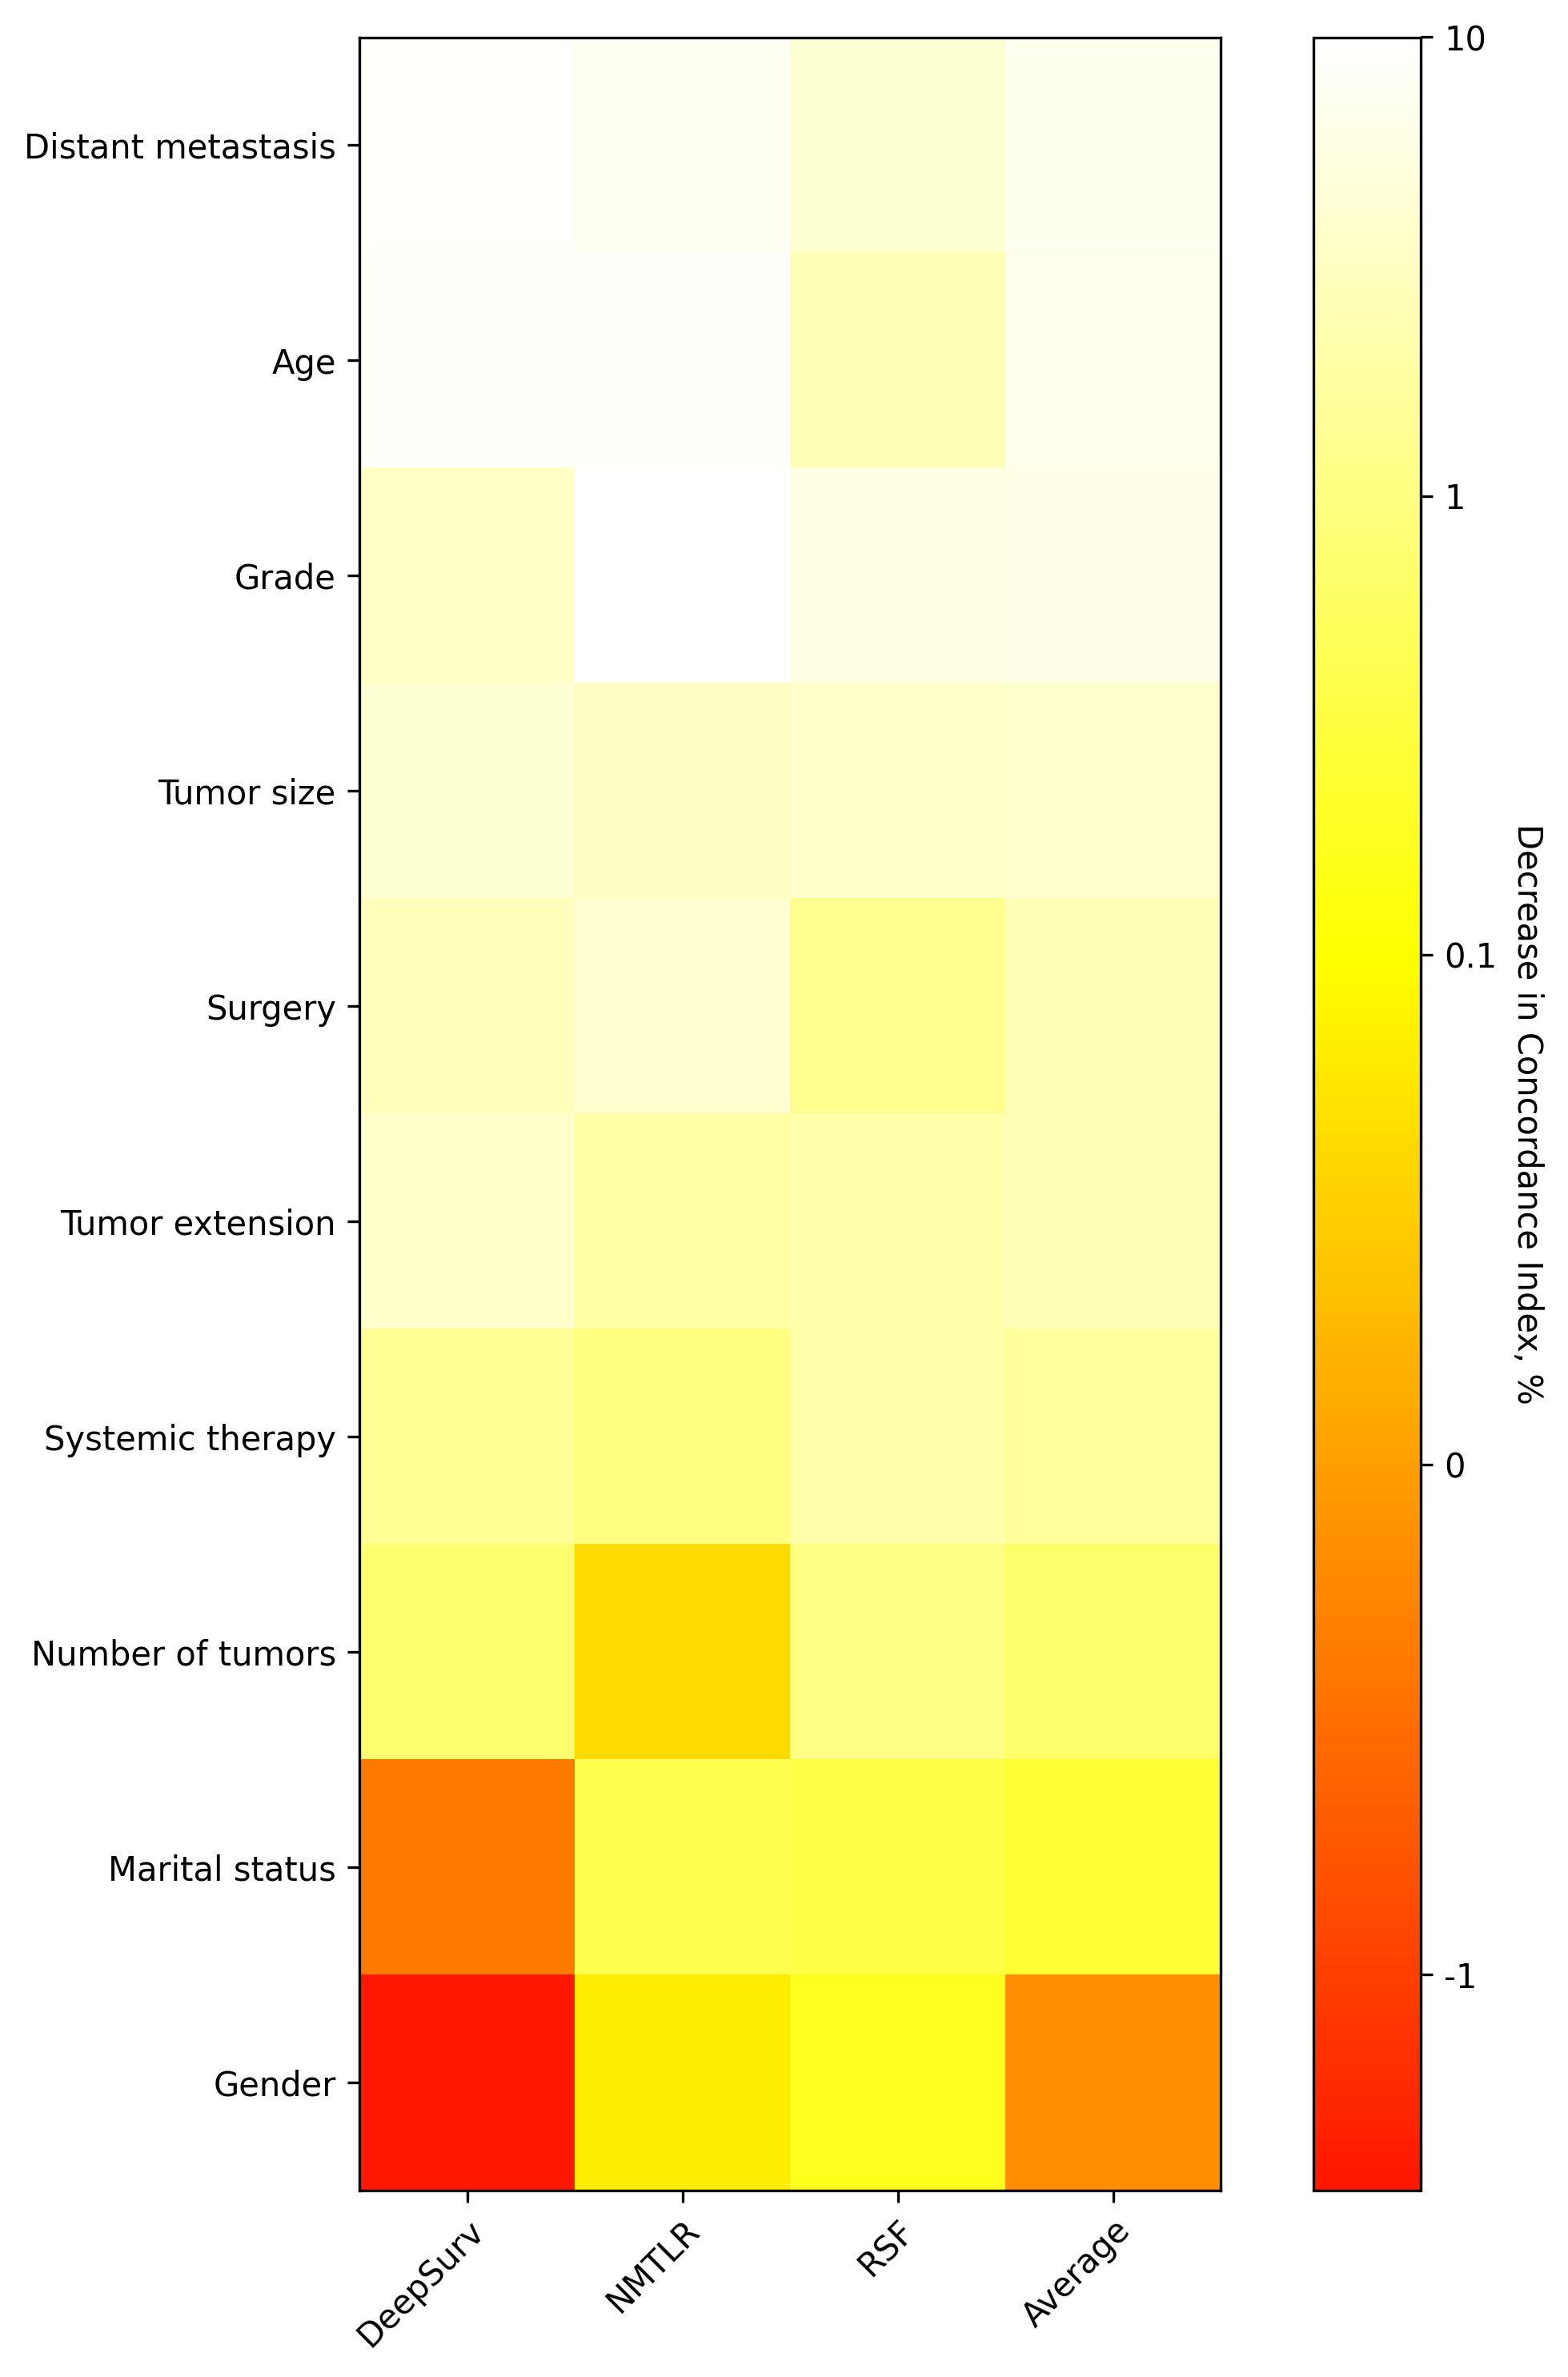

In [206]:
def plotFeatureImportance(a):
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    import matplotlib.cm as cm
    import matplotlib.colors as colors
    mpl.rcParams['figure.dpi'] = 300
    # a = pd.read_csv(feature_filename)
    a = a.sort_values(by=['Average'], ascending=False)
    fig, ax = plt.subplots(figsize=(8, 10))

    def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
        new_cmap = colors.LinearSegmentedColormap.from_list(
            'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
            cmap(np.linspace(minval, maxval, n)))
        return new_cmap

    im = ax.imshow(a[['DeepSurv', 'NMTLR', 'RSF', 'Average']],
                   cmap=truncate_colormap(cm.get_cmap("hot"), minval=0.4, maxval=1), norm=colors.SymLogNorm(1e-3))
    # im.set_clim(-5, -2)
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Decrease in Concordance Index, %", rotation=-90, va="bottom")
    # cbar.ax.set_aspect(50)
    cbar.set_ticks([0.1,0.01,0.001,0,-0.001])
    cbar.set_ticklabels(['10',"1","0.1",0,'-1'])

    ax.set_yticks(np.arange(len(a)))
    ax.set_xticks(np.arange(len(a.columns)))
    ax.set_xticklabels(['DeepSurv', 'NMTLR', 'RSF', 'Average'])
    ax.set_yticklabels(a.index)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    fig.tight_layout()
    plt.savefig("./Figures/variable.eps")
    plt.show()
plotFeatureImportance(imp_df)

### Treatment recommendation

In [32]:
def rec_chemo(model,X,col=0):
    if isinstance(X,pd.core.series.Series):
        x_trt = np.copy(X.to_numpy())
    else:
        x_trt = np.copy(X)
    # Risk of observations in treatment 0
    x_trt[:, col] = 0
    h_0 = model.predict_risk(x_trt)
    #print(h_0)
    # Risk of observations in treatment 1
    x_trt[:, col] = 1 
    h_1 = model.predict_risk(x_trt)
    # Risk of observations in treatment 2
    x_trt[:, col] = 2
    h_2 = model.predict_risk(x_trt) 
    # Risk of observations in treatment 3
    x_trt[:, col] = 3
    h_3 = model.predict_risk(x_trt)
    # the faster death accurs, the higher patient's risk score is
    # The minimum risk score corresponds to the recommended treatment
    hs = np.stack((h_0,h_1,h_2,h_3)).T
    rec_ = np.argmin(hs, axis=1)
    # print(hs)
    # print(rec_)
    return pd.DataFrame(rec_, columns=["Recommendation"])

In [33]:
# model: cph, treatment:chemo
rec_ = rec_chemo(cph.model,X_test,col=7)
data_rec = pd.concat([data_test,rec_],axis=1)
data_rec['Align'] = np.where(data_rec["Recommendation"] == data_rec["Systemic therapy"], 'Yes', 'No')
data_rec.to_csv(os.path.join(save_path,'cph_Systemic_therapy.csv'))

In [354]:
# model: nmtlr, treatment:chemo
rec_ = rec_surgery(nmtlr.model,X_test,col=7)
data_rec = pd.concat([data_test,rec_],axis=1)
data_rec['Align'] = np.where(data_rec["Recommendation"] == data_rec["Systemic therapy"], 'Yes', 'No')
data_rec.to_csv(os.path.join(save_path,'nmtlr_Systemic_therapy.csv'))

In [355]:
# model: deepsurv, treatment:chemo
rec_ = rec_surgery(deepsurv.model,X_test,col=7)
data_rec = pd.concat([data_test,rec_],axis=1)
data_rec['Align'] = np.where(data_rec["Recommendation"] == data_rec["Systemic therapy"], 'Yes', 'No')
data_rec.to_csv(os.path.join(save_path,'deepsurv_Systemic_therapy.csv'))

In [356]:
# model: rsf, treatment:chemo
rec_ = rec_surgery(rsf.model,X_test,col=7)
data_rec = pd.concat([data_test,rec_],axis=1)
data_rec['Align'] = np.where(data_rec["Recommendation"] == data_rec["Systemic therapy"], 'Yes', 'No')
data_rec.to_csv(os.path.join(save_path,'rsf_Systemic_therapy.csv'))

### Save models

In [36]:
from pysurvival.utils import save_model
save_model(cph.model, os.path.join(save_path,'CoxPH.zip'))
save_model(deepsurv.model, os.path.join(save_path,'DeepSurv.zip'))
save_model(nmtlr.model, os.path.join(save_path,'NMTLR.zip'))
save_model(rsf.model, os.path.join(save_path,'RSF.zip'))

/var/folders/9y/04p_lrdx74x2xkyfbd8l_rkh0000gn/T/ipykernel_75831/1383573925.py:2: FutureWarning: 'pyarrow.serialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  save_model(cph.model, os.path.join(save_path,'CoxPH.zip'))
/var/folders/9y/04p_lrdx74x2xkyfbd8l_rkh0000gn/T/ipykernel_75831/1383573925.py:3: FutureWarning: 'pyarrow.serialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  save_model(deepsurv.model, os.path.join(save_path,'DeepSurv.zip'))
/var/folders/9y/04p_lrdx74x2xkyfbd8l_rkh0000gn/T/ipykernel_75831/1383573925.py:4: FutureWarning: 'pyarrow.serialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  save_model(nmtlr.model, os.path.join(save_path,'NMTLR.zip'))
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/utils/__

Saving the model to disk as ./output/CoxPH.zip
Saving the model to disk as ./output/DeepSurv.zip
Saving the model to disk as ./output/NMTLR.zip
Saving the model to disk as ./output/RSF.zip
